# **Necessary imports**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io, transform
import torch
from tqdm import tqdm
import os
import time
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import copy
from skimage import io, transform
from IPython.display import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import PIL
import torch.nn as nn
from sklearn.model_selection import train_test_split
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# **Exploring the dataset**


In [2]:
columns = {'name': 'X', 'score': 'y'}
dataset = pd.read_csv("data/dataset.csv")
dataset.rename(columns=columns, inplace=True)

In [3]:
dataset.head()

image  memorability_score
0  0002.jpg            0.708333
1  0003.jpg            0.703704
2  0004.jpg            0.703704
3  0008.jpg            0.700000
4  0005.jpg            0.680000

In [4]:
len(dataset)

1000

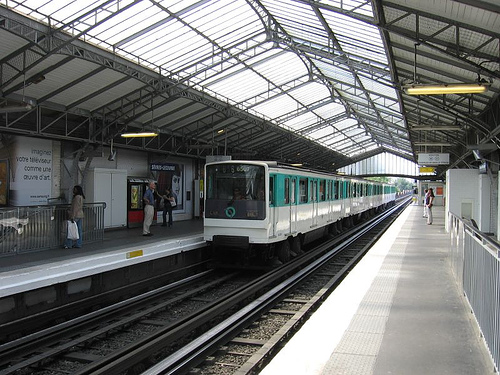

In [5]:
Image(filename="images/000981.jpg")

In [6]:
# train validation split
dataset_train, dataset_validation = train_test_split(
    dataset, test_size=0.2, random_state=90)

In [7]:
dataset_train = pd.read_csv("data/train.csv")
dataset_validation = pd.read_csv("data/val.csv")

In [8]:
dataset_train

image  memorability_score
0      0002.jpg            0.708333
1      0003.jpg            0.703704
2      0004.jpg            0.703704
3      0008.jpg            0.700000
4      0005.jpg            0.680000
..          ...                 ...
845  000845.jpg            0.708333
846  000846.jpg            0.703704
847  000856.jpg            0.696970
848  000847.jpg            0.680000
849  000848.jpg            0.680000

[850 rows x 2 columns]

In [9]:
len(dataset_train), len(dataset_validation)

(850, 150)

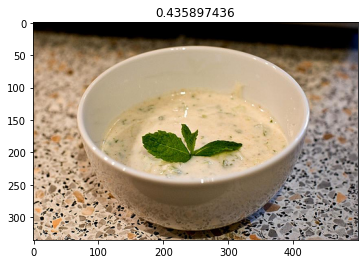

In [10]:
def show_sample_from_dataset(i=0):
    def show_image(image, asethics_value=0):
        plt.imshow(image)
        plt.title(str(asethics_value))
    image_path = os.path.join("images/"+str(dataset_train.iloc[i]["image"]))
    mem_value = os.path.join(str(dataset_train.iloc[i]["memorability_score"]))
    show_image(io.imread(image_path), mem_value)

show_sample_from_dataset(300)

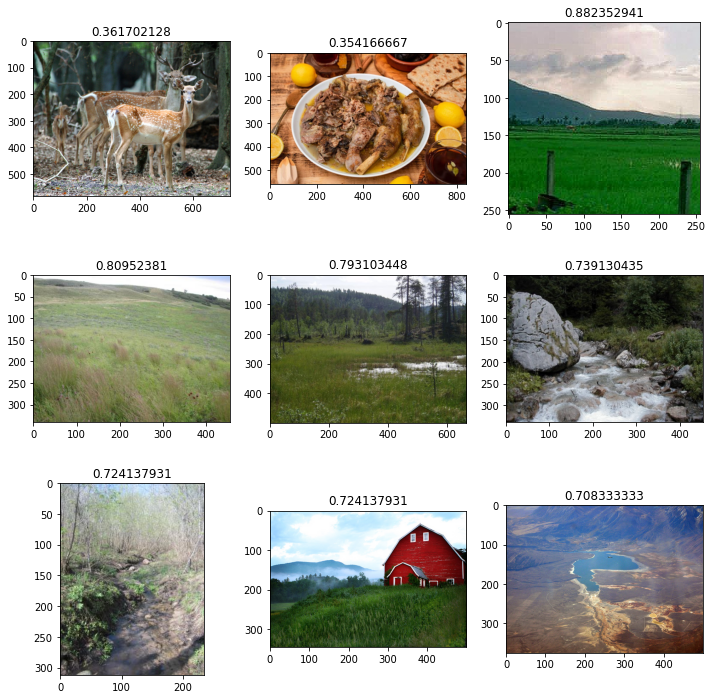

In [11]:
def show_grid(n_row, n_col):
    i = 500
    _, fig = plt.subplots(n_row, n_col, figsize=(12, 12))
    fig = fig.flatten()
    for f in fig:
        image_path = os.path.join(
            "images/"+str(dataset_train.iloc[i]["image"]))
        mem_value = os.path.join(
            str(dataset_train.iloc[i]["memorability_score"]))
        f.imshow(io.imread(image_path))
        f.title.set_text(str(mem_value))
        i = i+1

show_grid(3, 3)

# **Statistics**


In [12]:
dataset_train["memorability_score"].describe()

count    850.000000
mean       0.521978
std        0.093039
min        0.269231
25%        0.459459
50%        0.513514
75%        0.575758
max        0.913043
Name: memorability_score, dtype: float64

In [13]:
dataset_validation["memorability_score"].describe()

count    150.000000
mean       0.504780
std        0.076966
min        0.354167
25%        0.446948
50%        0.500000
75%        0.566667
max        0.678571
Name: memorability_score, dtype: float64

## **Data preprocessing**


In [14]:
class LaMemDataset(Dataset):
    '''largescale image memorablity  dataset'''

    def __init__(self, dataframe, root_dir, transform=None):
        """
            Args:
                csv_file (string): Path to the csv file with annotations.
                root_dir (string): Directory with all the images.
                transform (callable, optional): Optional transform to be applied
                    on a sample.
        """
        self.data = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = io.imread(image_name)
        mem_val = self.data.iloc[idx, 1]
        return_sample = {
            'image': image,
            'memorability_score': mem_val
        }
        if self.transform:
            return_sample = self.transform(return_sample)

        return return_sample

In [15]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mem_val = sample['image'], sample["memorability_score"]
        img = transform.resize(image, (self.output_size, self.output_size, 3))
        return {'image': img, 'memorability_score': mem_val}

In [16]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mem_val = sample['image'], sample['memorability_score']
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'memorability_score': mem_val}

In [17]:
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        image, mem_val = sample["image"], sample["memorability_score"]
        normalized = (image - self.mean) / self.std
        return {
            "image": normalized,
            "memorability_score": mem_val
        }

In [18]:
transformed_dataset_train = LaMemDataset(dataset_train, root_dir="images",
                                         transform=transforms.Compose([Rescale(224), ToTensor(), Normalize(0.5, 0.5)
                                                                       ]))

transformed_dataset_val = LaMemDataset(dataset_validation, root_dir="images",
                                       transform=transforms.Compose([Rescale(224), ToTensor(), Normalize(0.5, 0.5)
                                                                     ]))

In [19]:
train_dataloader = DataLoader(
    transformed_dataset_train, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(
    transformed_dataset_val, batch_size=32, shuffle=True)

In [20]:
dataloaders = {
    "train": train_dataloader,
    "val": validation_dataloader
}

In [21]:
dataset_sizes = {
    "train": len(dataset_train),
    "val": len(dataset_validation)
}

In [22]:
epchocs_count = 100

# **ResNet50**



In [23]:
model_50 = models.resnet50("pth/resnet50-0676ba61.pth")

In [24]:
# model_50 = models.resnet50(pretrained=True)
for param in model_50.parameters():
  param.requires_grad = False
import torch.nn as nn
 
n_inputs = model_50.fc.in_features
last_layer = nn.Linear(n_inputs, 1)
model_50.fc = last_layer
model_50.to(device)
print(model_50.fc.out_features)

1


In [25]:
model_50 = model_50.double()
resmodel_50=copy.deepcopy(model_50)

In [26]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_50.parameters(), lr = 0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [27]:
np.inf>90

True

In [28]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    running_loss_history = []
    val_running_loss_history=[]
    orignal_model=None
    best_model_wts = copy.deepcopy(model.state_dict())
    low_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batched_data in tqdm(dataloaders[phase]):
          
                inputs=batched_data["image"]
                inputs = inputs.to(device)
                labels=batched_data["memorability_score"]
                labels=labels.view(-1,1).double()
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    print("  batch loss:    ",loss.item())
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            if phase=="train":
              running_loss_history.append(epoch_loss)
            else:
              val_running_loss_history.append(epoch_loss)
            

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))
            

            # deep copy the model
            if phase == 'val' and epoch_loss < low_loss:
                low_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                print("saving best model....")
                torch.save(best_model_wts,"models/ResNet50-in-resnet101.pth")

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    original_model =copy.deepcopy(model)
    model.load_state_dict(best_model_wts)
    return model,original_model,running_loss_history,val_running_loss_history

In [29]:
best_model_50,model_50,running_loss_history,val_running_loss_history = train_model(model_50,criterion,optimizer,exp_lr_scheduler, epchocs_count)

Epoch 0/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:55,  2.15s/it]

  batch loss:     0.3409661976899706


  7%|██████▏                                                                             | 2/27 [00:04<00:51,  2.07s/it]

  batch loss:     0.2532678018907625


 11%|█████████▎                                                                          | 3/27 [00:06<00:49,  2.04s/it]

  batch loss:     0.23011415638475474


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.03s/it]

  batch loss:     0.15800289257791386


 19%|███████████████▌                                                                    | 5/27 [00:10<00:45,  2.06s/it]

  batch loss:     0.09754372834780989


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:45,  2.19s/it]

  batch loss:     0.09875345357445858


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:42,  2.11s/it]

  batch loss:     0.05065355023935808


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:39,  2.07s/it]

  batch loss:     0.05514130572239024


 33%|████████████████████████████                                                        | 9/27 [00:18<00:37,  2.06s/it]

  batch loss:     0.08605267304572982


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:35,  2.10s/it]

  batch loss:     0.05091897777103256


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.05s/it]

  batch loss:     0.07074100573247367


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.07s/it]

  batch loss:     0.10668664059214134


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.07s/it]

  batch loss:     0.08246941919823009


 52%|███████████████████████████████████████████                                        | 14/27 [00:29<00:27,  2.11s/it]

  batch loss:     0.08457624516320222


 56%|██████████████████████████████████████████████                                     | 15/27 [00:31<00:26,  2.17s/it]

  batch loss:     0.08338508917689272


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:33<00:23,  2.14s/it]

  batch loss:     0.11571022719335503


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:35<00:20,  2.10s/it]

  batch loss:     0.08580112898434072


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:37<00:18,  2.09s/it]

  batch loss:     0.0634958254907783


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:39<00:16,  2.07s/it]

  batch loss:     0.06559985299788601


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:41<00:14,  2.06s/it]

  batch loss:     0.054168260875902645


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:43<00:12,  2.05s/it]

  batch loss:     0.05238226548286727


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:45<00:10,  2.08s/it]

  batch loss:     0.04577125225544626


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:47<00:08,  2.08s/it]

  batch loss:     0.05132863950210272


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:49<00:06,  2.06s/it]

  batch loss:     0.05957429084164813


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:52<00:04,  2.05s/it]

  batch loss:     0.033154969513160854


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:54<00:02,  2.08s/it]

  batch loss:     0.04291457713958284


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:55<00:00,  2.05s/it]


  batch loss:     0.036565485013578
train Loss: 0.0956


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.82s/it]

  batch loss:     0.04752633725920921


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.85s/it]

  batch loss:     0.040338869420525704


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.81s/it]

  batch loss:     0.04364558327796063


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.83s/it]

  batch loss:     0.04622094012778104


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.75s/it]


  batch loss:     0.030435376244990344
val Loss: 0.0424
saving best model....

Epoch 1/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:56,  2.15s/it]

  batch loss:     0.057715793402046994


  7%|██████▏                                                                             | 2/27 [00:04<00:57,  2.29s/it]

  batch loss:     0.05394321925954297


 11%|█████████▎                                                                          | 3/27 [00:06<00:56,  2.36s/it]

  batch loss:     0.05781468003802348


 15%|████████████▍                                                                       | 4/27 [00:09<00:52,  2.28s/it]

  batch loss:     0.04294793079665597


 19%|███████████████▌                                                                    | 5/27 [00:11<00:48,  2.19s/it]

  batch loss:     0.04314424980134298


 22%|██████████████████▋                                                                 | 6/27 [00:13<00:44,  2.13s/it]

  batch loss:     0.06735421880976182


 26%|█████████████████████▊                                                              | 7/27 [00:15<00:42,  2.12s/it]

  batch loss:     0.04735623025502216


 30%|████████████████████████▉                                                           | 8/27 [00:17<00:39,  2.09s/it]

  batch loss:     0.06766731158277049


 33%|████████████████████████████                                                        | 9/27 [00:19<00:37,  2.08s/it]

  batch loss:     0.05909926419891401


 37%|██████████████████████████████▋                                                    | 10/27 [00:21<00:37,  2.19s/it]

  batch loss:     0.035890799195692547


 41%|█████████████████████████████████▊                                                 | 11/27 [00:23<00:34,  2.16s/it]

  batch loss:     0.049927647389352375


 44%|████████████████████████████████████▉                                              | 12/27 [00:25<00:31,  2.11s/it]

  batch loss:     0.06116182207223919


 48%|███████████████████████████████████████▉                                           | 13/27 [00:27<00:29,  2.10s/it]

  batch loss:     0.04120054243480689


 52%|███████████████████████████████████████████                                        | 14/27 [00:30<00:27,  2.09s/it]

  batch loss:     0.06363146923337742


 56%|██████████████████████████████████████████████                                     | 15/27 [00:32<00:24,  2.05s/it]

  batch loss:     0.03653002963269931


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:34<00:22,  2.08s/it]

  batch loss:     0.031954259449236404


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:36<00:20,  2.06s/it]

  batch loss:     0.027895774465938963


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:38<00:18,  2.05s/it]

  batch loss:     0.029034480530849952


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:40<00:16,  2.04s/it]

  batch loss:     0.02991285802276037


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:42<00:14,  2.04s/it]

  batch loss:     0.0443155454055217


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:44<00:12,  2.13s/it]

  batch loss:     0.074195030894454


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:46<00:10,  2.13s/it]

  batch loss:     0.03737431940689896


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:48<00:08,  2.09s/it]

  batch loss:     0.06339866234925134


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:50<00:06,  2.12s/it]

  batch loss:     0.030968528218648067


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:52<00:04,  2.11s/it]

  batch loss:     0.04430213106873336


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:55<00:02,  2.12s/it]

  batch loss:     0.025075170115564285


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:56<00:00,  2.09s/it]


  batch loss:     0.062312714629054716
train Loss: 0.0474


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.86s/it]

  batch loss:     0.029397001663005094


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.88s/it]

  batch loss:     0.03969830564315675


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.87s/it]

  batch loss:     0.05055892817255257


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.83s/it]

  batch loss:     0.0334653375322938


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.73s/it]


  batch loss:     0.041178382983869735
val Loss: 0.0387
saving best model....

Epoch 2/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:52,  2.01s/it]

  batch loss:     0.025959059209406356


  7%|██████▏                                                                             | 2/27 [00:04<00:50,  2.03s/it]

  batch loss:     0.041328623560180744


 11%|█████████▎                                                                          | 3/27 [00:06<00:49,  2.07s/it]

  batch loss:     0.048389941476216336


 15%|████████████▍                                                                       | 4/27 [00:08<00:47,  2.06s/it]

  batch loss:     0.031353680249792626


 19%|███████████████▌                                                                    | 5/27 [00:10<00:45,  2.06s/it]

  batch loss:     0.045916740442846556


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:44,  2.10s/it]

  batch loss:     0.033105598181838516


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:41,  2.08s/it]

  batch loss:     0.03250496527828646


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:39,  2.08s/it]

  batch loss:     0.03990549879624463


 33%|████████████████████████████                                                        | 9/27 [00:18<00:37,  2.08s/it]

  batch loss:     0.0249658426246352


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:35,  2.09s/it]

  batch loss:     0.025957843388756584


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:33,  2.10s/it]

  batch loss:     0.03805721496441519


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.06s/it]

  batch loss:     0.035694364220699736


 48%|███████████████████████████████████████▉                                           | 13/27 [00:27<00:31,  2.23s/it]

  batch loss:     0.04920784363228563


 52%|███████████████████████████████████████████                                        | 14/27 [00:29<00:28,  2.22s/it]

  batch loss:     0.03681446232818498


 56%|██████████████████████████████████████████████                                     | 15/27 [00:31<00:26,  2.20s/it]

  batch loss:     0.062149207684320654


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:33<00:23,  2.16s/it]

  batch loss:     0.03548360088415335


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:36<00:21,  2.16s/it]

  batch loss:     0.03539719337530381


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:38<00:18,  2.11s/it]

  batch loss:     0.03865544266440918


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:40<00:16,  2.11s/it]

  batch loss:     0.029050788998313995


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:42<00:14,  2.11s/it]

  batch loss:     0.035207976264085734


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:44<00:12,  2.10s/it]

  batch loss:     0.04506492429568905


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:46<00:10,  2.14s/it]

  batch loss:     0.045560377438663396


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:48<00:08,  2.11s/it]

  batch loss:     0.05166832799796228


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:50<00:06,  2.09s/it]

  batch loss:     0.029331357477105337


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:52<00:04,  2.09s/it]

  batch loss:     0.034017442664165176


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:54<00:02,  2.05s/it]

  batch loss:     0.04772212103991034


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:55<00:00,  2.07s/it]


  batch loss:     0.035235794942795134
train Loss: 0.0383


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.71s/it]

  batch loss:     0.03550399214973104


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.73s/it]

  batch loss:     0.026375128914141774


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.71s/it]

  batch loss:     0.04406458519102707


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.72s/it]

  batch loss:     0.04316316442646419


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


  batch loss:     0.037575252194831155
val Loss: 0.0373
saving best model....

Epoch 3/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:50,  1.96s/it]

  batch loss:     0.050791582520717186


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  1.96s/it]

  batch loss:     0.024896427774731982


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.98s/it]

  batch loss:     0.024305092562746104


 15%|████████████▍                                                                       | 4/27 [00:07<00:46,  2.01s/it]

  batch loss:     0.022286244152360357


 19%|███████████████▌                                                                    | 5/27 [00:10<00:45,  2.05s/it]

  batch loss:     0.03164525209828585


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:42,  2.01s/it]

  batch loss:     0.031904671756970156


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.01s/it]

  batch loss:     0.047010658655368506


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:39,  2.06s/it]

  batch loss:     0.04731733846964905


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.05s/it]

  batch loss:     0.035741490069063825


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.05s/it]

  batch loss:     0.02861457790613489


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:33,  2.08s/it]

  batch loss:     0.038554742549407287


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:31,  2.08s/it]

  batch loss:     0.03351003311706993


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:29,  2.09s/it]

  batch loss:     0.032540900820915916


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.07s/it]

  batch loss:     0.03752832936985796


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.05s/it]

  batch loss:     0.026912847394148006


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:33<00:24,  2.18s/it]

  batch loss:     0.03089492816058266


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:35<00:21,  2.14s/it]

  batch loss:     0.026273320689913723


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:37<00:18,  2.09s/it]

  batch loss:     0.02558254256970275


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:39<00:16,  2.06s/it]

  batch loss:     0.039267164067240526


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:41<00:14,  2.13s/it]

  batch loss:     0.0289378619792972


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:43<00:13,  2.17s/it]

  batch loss:     0.03662260853718455


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:46<00:11,  2.23s/it]

  batch loss:     0.028428806708772694


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:48<00:08,  2.21s/it]

  batch loss:     0.035459207420959905


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:50<00:06,  2.18s/it]

  batch loss:     0.050123080884944854


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:52<00:04,  2.12s/it]

  batch loss:     0.025450511149456675


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:54<00:02,  2.10s/it]

  batch loss:     0.035357902671644306


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:55<00:00,  2.06s/it]


  batch loss:     0.04075683082072082
train Loss: 0.0338


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.76s/it]

  batch loss:     0.030523566680805067


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.73s/it]

  batch loss:     0.03422127288560234


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.74s/it]

  batch loss:     0.048725258434082236


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.74s/it]

  batch loss:     0.02668730411529613


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.65s/it]


  batch loss:     0.03668930194675896
val Loss: 0.0353
saving best model....

Epoch 4/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.96s/it]

  batch loss:     0.018528071933930693


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  1.97s/it]

  batch loss:     0.06254582424994667


 11%|█████████▎                                                                          | 3/27 [00:05<00:48,  2.01s/it]

  batch loss:     0.03890001648155395


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.04s/it]

  batch loss:     0.04358312306250509


 19%|███████████████▌                                                                    | 5/27 [00:10<00:45,  2.05s/it]

  batch loss:     0.027391272202148174


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:43,  2.06s/it]

  batch loss:     0.04091360350272543


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:43,  2.16s/it]

  batch loss:     0.04531676584083574


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:41,  2.17s/it]

  batch loss:     0.03777113571842687


 33%|████████████████████████████                                                        | 9/27 [00:18<00:38,  2.11s/it]

  batch loss:     0.03563148583993114


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:35,  2.07s/it]

  batch loss:     0.033068815602110606


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.04s/it]

  batch loss:     0.0476913908623713


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.02s/it]

  batch loss:     0.025220783343039507


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.03s/it]

  batch loss:     0.0192175207527129


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.03s/it]

  batch loss:     0.030766571286892398


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.01s/it]

  batch loss:     0.027619801521146358


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.01s/it]

  batch loss:     0.028866555083034675


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:19,  2.00s/it]

  batch loss:     0.03096253336981726


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.00s/it]

  batch loss:     0.05433492144188424


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:15,  1.98s/it]

  batch loss:     0.018736751037786926


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:13,  1.99s/it]

  batch loss:     0.024942347161066237


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:11,  2.00s/it]

  batch loss:     0.026385905686453447


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.08s/it]

  batch loss:     0.026640195344745543


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:47<00:08,  2.08s/it]

  batch loss:     0.02885049988449495


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:06,  2.03s/it]

  batch loss:     0.03045797792444502


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:04,  2.02s/it]

  batch loss:     0.01856366159509166


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:53<00:02,  2.05s/it]

  batch loss:     0.02204004554873818


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:54<00:00,  2.01s/it]


  batch loss:     0.03394873075983467
train Loss: 0.0325


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.73s/it]

  batch loss:     0.03467250521297392


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.72s/it]

  batch loss:     0.04391936657566502


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.72s/it]

  batch loss:     0.03818935997135613


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.73s/it]

  batch loss:     0.033949767422663306


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


  batch loss:     0.034098765976471754
val Loss: 0.0372

Epoch 5/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.98s/it]

  batch loss:     0.023772622756784524


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  1.97s/it]

  batch loss:     0.029955859317815046


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.98s/it]

  batch loss:     0.036573075378337386


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.97s/it]

  batch loss:     0.022129159290534682


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.99s/it]

  batch loss:     0.0334600310080453


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.99s/it]

  batch loss:     0.020178631120716037


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:40,  2.02s/it]

  batch loss:     0.030452075887627966


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.04s/it]

  batch loss:     0.022577491326290347


 33%|████████████████████████████                                                        | 9/27 [00:17<00:36,  2.00s/it]

  batch loss:     0.03261887685140305


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  1.98s/it]

  batch loss:     0.016159280261428592


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.97s/it]

  batch loss:     0.023685766982163885


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:31,  2.12s/it]

  batch loss:     0.02137739912444871


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.07s/it]

  batch loss:     0.029644165960631914


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.06s/it]

  batch loss:     0.020928791676495268


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.06s/it]

  batch loss:     0.021930646628013813


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:23,  2.11s/it]

  batch loss:     0.0257411716183496


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:21,  2.15s/it]

  batch loss:     0.026950935316306157


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:19,  2.14s/it]

  batch loss:     0.03106209114027514


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:39<00:17,  2.16s/it]

  batch loss:     0.0410082275785191


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:41<00:15,  2.15s/it]

  batch loss:     0.038710503709851


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:43<00:12,  2.17s/it]

  batch loss:     0.03266748621639815


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:45<00:10,  2.14s/it]

  batch loss:     0.022685335333413544


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:47<00:08,  2.09s/it]

  batch loss:     0.0209049264825417


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:49<00:06,  2.05s/it]

  batch loss:     0.03323908029137309


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:51<00:04,  2.04s/it]

  batch loss:     0.027033408259796776


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:53<00:02,  2.01s/it]

  batch loss:     0.023941073424401136


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:54<00:00,  2.02s/it]


  batch loss:     0.01450931945579306
train Loss: 0.0270


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.72s/it]

  batch loss:     0.030427317738881104


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.73s/it]

  batch loss:     0.019100656452748957


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.73s/it]

  batch loss:     0.027944658849571723


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.72s/it]

  batch loss:     0.043613271614670546


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


  batch loss:     0.029408775548972203
val Loss: 0.0301
saving best model....

Epoch 6/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:52,  2.01s/it]

  batch loss:     0.02108641254453304


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  1.99s/it]

  batch loss:     0.025883174785927165


 11%|█████████▎                                                                          | 3/27 [00:05<00:46,  1.94s/it]

  batch loss:     0.014268682722364676


 15%|████████████▍                                                                       | 4/27 [00:07<00:44,  1.94s/it]

  batch loss:     0.025718672125098825


 19%|███████████████▌                                                                    | 5/27 [00:09<00:42,  1.95s/it]

  batch loss:     0.0266903974711528


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:40,  1.94s/it]

  batch loss:     0.028917823040847265


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.96s/it]

  batch loss:     0.03732499281097499


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.98s/it]

  batch loss:     0.023271597014084787


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.97s/it]

  batch loss:     0.02421815483448741


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  1.98s/it]

  batch loss:     0.017799737541184094


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.97s/it]

  batch loss:     0.04697889332977327


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:31,  2.12s/it]

  batch loss:     0.02267754257637429


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:29,  2.08s/it]

  batch loss:     0.020326716667632916


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.04s/it]

  batch loss:     0.033224313338087855


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.05s/it]

  batch loss:     0.03220214161292483


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.02s/it]

  batch loss:     0.020274979055149397


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.01s/it]

  batch loss:     0.02590685886762683


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.01s/it]

  batch loss:     0.029233390377833728


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.00s/it]

  batch loss:     0.020504460121823814


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.02s/it]

  batch loss:     0.022491067822281524


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.01s/it]

  batch loss:     0.02400612851252587


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.02s/it]

  batch loss:     0.02259316448736077


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:08,  2.01s/it]

  batch loss:     0.020252813002657258


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.97s/it]

  batch loss:     0.025451738803359006


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.95s/it]

  batch loss:     0.020961493811572498


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.99s/it]

  batch loss:     0.021480083800140135


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.97s/it]


  batch loss:     0.030876797382652532
train Loss: 0.0253


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.71s/it]

  batch loss:     0.02513854033039467


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.70s/it]

  batch loss:     0.03549370527232737


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.73s/it]

  batch loss:     0.03046364386561787


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.74s/it]

  batch loss:     0.04770127547812692


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


  batch loss:     0.013632773724683711
val Loss: 0.0316

Epoch 7/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.99s/it]

  batch loss:     0.022328192236526632


  7%|██████▏                                                                             | 2/27 [00:04<00:52,  2.11s/it]

  batch loss:     0.01874512973032616


 11%|█████████▎                                                                          | 3/27 [00:06<00:49,  2.06s/it]

  batch loss:     0.028892557658376932


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.02s/it]

  batch loss:     0.029955317746255705


 19%|███████████████▌                                                                    | 5/27 [00:10<00:44,  2.01s/it]

  batch loss:     0.023562241408554403


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:41,  1.99s/it]

  batch loss:     0.024843705907621527


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:41,  2.06s/it]

  batch loss:     0.02192470152366947


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:39,  2.07s/it]

  batch loss:     0.03657663284915614


 33%|████████████████████████████                                                        | 9/27 [00:18<00:37,  2.06s/it]

  batch loss:     0.014400393000564162


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.05s/it]

  batch loss:     0.010905559247126216


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:33,  2.07s/it]

  batch loss:     0.022017646285618194


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:31,  2.07s/it]

  batch loss:     0.02365813353095529


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.05s/it]

  batch loss:     0.02677409107562382


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.05s/it]

  batch loss:     0.020836931742813886


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.04s/it]

  batch loss:     0.01556054839553646


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.06s/it]

  batch loss:     0.02977592446484989


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.07s/it]

  batch loss:     0.02447970336207435


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:37<00:18,  2.09s/it]

  batch loss:     0.018304289562198213


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:39<00:17,  2.23s/it]

  batch loss:     0.02329791142748903


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:41<00:15,  2.24s/it]

  batch loss:     0.02508387126377956


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:43<00:12,  2.16s/it]

  batch loss:     0.023526389254583936


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:45<00:10,  2.11s/it]

  batch loss:     0.027820684483307698


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:47<00:08,  2.10s/it]

  batch loss:     0.03287021295085435


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:49<00:06,  2.07s/it]

  batch loss:     0.014029659190114136


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:52<00:04,  2.08s/it]

  batch loss:     0.03456466724490942


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:54<00:02,  2.07s/it]

  batch loss:     0.019953066921395483


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:55<00:00,  2.05s/it]


  batch loss:     0.02148079934808704
train Loss: 0.0236


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.75s/it]

  batch loss:     0.03332547565111847


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.75s/it]

  batch loss:     0.03010255095479467


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.75s/it]

  batch loss:     0.030477296140620985


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.75s/it]

  batch loss:     0.03180695391951112


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.65s/it]


  batch loss:     0.025405645938118247
val Loss: 0.0305

Epoch 8/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:54,  2.08s/it]

  batch loss:     0.018805798435328827


  7%|██████▏                                                                             | 2/27 [00:04<00:51,  2.06s/it]

  batch loss:     0.03229242160245306


 11%|█████████▎                                                                          | 3/27 [00:06<00:48,  2.02s/it]

  batch loss:     0.02583568904099582


 15%|████████████▍                                                                       | 4/27 [00:08<00:45,  1.99s/it]

  batch loss:     0.0261644135436924


 19%|███████████████▌                                                                    | 5/27 [00:10<00:43,  1.99s/it]

  batch loss:     0.02216020335534217


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:42,  2.02s/it]

  batch loss:     0.024897276361651524


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.02s/it]

  batch loss:     0.022365809345916164


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.05s/it]

  batch loss:     0.017407453901603


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.05s/it]

  batch loss:     0.019898923030629297


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:35,  2.08s/it]

  batch loss:     0.030742677682366663


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:33,  2.10s/it]

  batch loss:     0.019008660016511223


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:31,  2.10s/it]

  batch loss:     0.03737006774331018


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:29,  2.09s/it]

  batch loss:     0.027986003665938418


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:27,  2.08s/it]

  batch loss:     0.011782475983538864


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.06s/it]

  batch loss:     0.020474024130665208


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.02s/it]

  batch loss:     0.03904166979381904


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:35<00:21,  2.13s/it]

  batch loss:     0.02000679822148285


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:37<00:18,  2.08s/it]

  batch loss:     0.016953702588732703


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:39<00:16,  2.08s/it]

  batch loss:     0.016502455188725323


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:41<00:14,  2.05s/it]

  batch loss:     0.025136383080799407


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:43<00:12,  2.02s/it]

  batch loss:     0.021755125209436767


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:45<00:10,  2.02s/it]

  batch loss:     0.02469176960342447


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:47<00:08,  2.02s/it]

  batch loss:     0.02275654861839977


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:49<00:06,  2.01s/it]

  batch loss:     0.031778475414838664


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:51<00:03,  2.00s/it]

  batch loss:     0.021464862392415355


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:53<00:02,  2.01s/it]

  batch loss:     0.02379895110243647


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:54<00:00,  2.01s/it]


  batch loss:     0.01314322509608564
train Loss: 0.0237


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.79s/it]

  batch loss:     0.029352491079296904


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.78s/it]

  batch loss:     0.033089064344011265


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.75s/it]

  batch loss:     0.022804494447275808


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.77s/it]

  batch loss:     0.038010316478570436


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.68s/it]


  batch loss:     0.036693669136960066
val Loss: 0.0317

Epoch 9/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:52,  2.03s/it]

  batch loss:     0.024772939263189273


  7%|██████▏                                                                             | 2/27 [00:04<00:50,  2.01s/it]

  batch loss:     0.03113953697670089


 11%|█████████▎                                                                          | 3/27 [00:06<00:48,  2.03s/it]

  batch loss:     0.0181867547027518


 15%|████████████▍                                                                       | 4/27 [00:08<00:47,  2.07s/it]

  batch loss:     0.017308889419302392


 19%|███████████████▌                                                                    | 5/27 [00:10<00:46,  2.12s/it]

  batch loss:     0.025111570946214547


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:45,  2.17s/it]

  batch loss:     0.02321791854984908


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:43,  2.17s/it]

  batch loss:     0.017406161687000613


 30%|████████████████████████▉                                                           | 8/27 [00:17<00:41,  2.20s/it]

  batch loss:     0.022811771012850587


 33%|████████████████████████████                                                        | 9/27 [00:19<00:38,  2.15s/it]

  batch loss:     0.03176904854562137


 37%|██████████████████████████████▋                                                    | 10/27 [00:21<00:36,  2.13s/it]

  batch loss:     0.037308593790661766


 41%|█████████████████████████████████▊                                                 | 11/27 [00:23<00:33,  2.12s/it]

  batch loss:     0.01907294542890082


 44%|████████████████████████████████████▉                                              | 12/27 [00:25<00:32,  2.15s/it]

  batch loss:     0.029198799985626103


 48%|███████████████████████████████████████▉                                           | 13/27 [00:27<00:29,  2.14s/it]

  batch loss:     0.01853031611262905


 52%|███████████████████████████████████████████                                        | 14/27 [00:29<00:28,  2.16s/it]

  batch loss:     0.015430124127276786


 56%|██████████████████████████████████████████████                                     | 15/27 [00:32<00:26,  2.24s/it]

  batch loss:     0.02451909227486721


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:34<00:24,  2.18s/it]

  batch loss:     0.015695596629914522


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:36<00:21,  2.11s/it]

  batch loss:     0.016983519417157384


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:38<00:18,  2.07s/it]

  batch loss:     0.020310260927546953


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:40<00:16,  2.06s/it]

  batch loss:     0.02755053195358194


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:42<00:14,  2.04s/it]

  batch loss:     0.025183976168328775


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:44<00:12,  2.04s/it]

  batch loss:     0.033645485144170574


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:46<00:10,  2.04s/it]

  batch loss:     0.016926490168471364


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:48<00:08,  2.01s/it]

  batch loss:     0.026730656631628463


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:50<00:06,  2.03s/it]

  batch loss:     0.01990826775397042


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:52<00:04,  2.02s/it]

  batch loss:     0.022968481238989962


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:54<00:02,  2.05s/it]

  batch loss:     0.022651740414977275


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:55<00:00,  2.06s/it]


  batch loss:     0.015910101702578124
train Loss: 0.0231


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.79s/it]

  batch loss:     0.041475219637015545


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.77s/it]

  batch loss:     0.023404409423115613


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.75s/it]

  batch loss:     0.023874761850571982


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.74s/it]

  batch loss:     0.040989162921642126


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.65s/it]


  batch loss:     0.035989781088491414
val Loss: 0.0330

Epoch 10/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.99s/it]

  batch loss:     0.01481776937657801


  7%|██████▏                                                                             | 2/27 [00:04<00:50,  2.04s/it]

  batch loss:     0.024186598609111355


 11%|█████████▎                                                                          | 3/27 [00:06<00:50,  2.10s/it]

  batch loss:     0.020268093620935346


 15%|████████████▍                                                                       | 4/27 [00:08<00:47,  2.08s/it]

  batch loss:     0.021112156678676896


 19%|███████████████▌                                                                    | 5/27 [00:10<00:45,  2.07s/it]

  batch loss:     0.025394202161092106


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:43,  2.07s/it]

  batch loss:     0.04512356543936247


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.05s/it]

  batch loss:     0.02079681641728161


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.04s/it]

  batch loss:     0.026142647376607518


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.04s/it]

  batch loss:     0.02788122944174788


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.02s/it]

  batch loss:     0.022230614876020627


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.00s/it]

  batch loss:     0.028163669276439554


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.03s/it]

  batch loss:     0.034276477727464325


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:29,  2.09s/it]

  batch loss:     0.02286968219028052


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:27,  2.10s/it]

  batch loss:     0.021344945084441732


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:25,  2.09s/it]

  batch loss:     0.020995680413741426


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:33<00:23,  2.10s/it]

  batch loss:     0.030418603297595423


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:35<00:20,  2.10s/it]

  batch loss:     0.012189206135450758


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:37<00:18,  2.08s/it]

  batch loss:     0.023468566783917587


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:39<00:16,  2.05s/it]

  batch loss:     0.014681130269936178


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:41<00:14,  2.04s/it]

  batch loss:     0.021955809213066012


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:43<00:12,  2.02s/it]

  batch loss:     0.026238459871636474


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:45<00:10,  2.06s/it]

  batch loss:     0.023687212213403204


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:47<00:08,  2.05s/it]

  batch loss:     0.018665314536717777


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:49<00:06,  2.16s/it]

  batch loss:     0.026511546869621094


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:51<00:04,  2.14s/it]

  batch loss:     0.018794504088993837


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:53<00:02,  2.11s/it]

  batch loss:     0.02187869753444446


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:54<00:00,  2.04s/it]


  batch loss:     0.021297012219183085
train Loss: 0.0236


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.76s/it]

  batch loss:     0.024455875107749225


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.82s/it]

  batch loss:     0.03738243456991254


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.85s/it]

  batch loss:     0.024977477728642374


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.82s/it]

  batch loss:     0.03679724631243693


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.71s/it]


  batch loss:     0.035877706393954795
val Loss: 0.0316

Epoch 11/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:52,  2.01s/it]

  batch loss:     0.03602579618650805


  7%|██████▏                                                                             | 2/27 [00:04<00:51,  2.08s/it]

  batch loss:     0.019473800761311662


 11%|█████████▎                                                                          | 3/27 [00:06<00:49,  2.05s/it]

  batch loss:     0.017601820090568043


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.03s/it]

  batch loss:     0.017715229444078207


 19%|███████████████▌                                                                    | 5/27 [00:10<00:44,  2.02s/it]

  batch loss:     0.023165832762834366


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:41,  2.00s/it]

  batch loss:     0.01906954580005721


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.00s/it]

  batch loss:     0.018031040554425976


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.03s/it]

  batch loss:     0.02331672213233908


 33%|████████████████████████████                                                        | 9/27 [00:18<00:35,  1.99s/it]

  batch loss:     0.018385270555449567


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.00s/it]

  batch loss:     0.027584166520510517


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.01s/it]

  batch loss:     0.024084991340400624


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.01s/it]

  batch loss:     0.02678791090505184


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:29,  2.09s/it]

  batch loss:     0.01763201139623026


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:27,  2.13s/it]

  batch loss:     0.027494605636946483


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:25,  2.13s/it]

  batch loss:     0.03347747649978578


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:33<00:24,  2.23s/it]

  batch loss:     0.03652711233193872


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:35<00:22,  2.24s/it]

  batch loss:     0.01822715241970219


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:37<00:19,  2.18s/it]

  batch loss:     0.020380948171522473


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:39<00:17,  2.19s/it]

  batch loss:     0.024243046524102762


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:41<00:15,  2.15s/it]

  batch loss:     0.016889077920009495


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:43<00:12,  2.09s/it]

  batch loss:     0.026304242208320058


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:46<00:10,  2.19s/it]

  batch loss:     0.02332428150808929


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:48<00:08,  2.15s/it]

  batch loss:     0.015300651877600418


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:50<00:06,  2.10s/it]

  batch loss:     0.016181049227637866


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:52<00:04,  2.07s/it]

  batch loss:     0.019994667721387784


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:54<00:02,  2.06s/it]

  batch loss:     0.025314061432557943


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:55<00:00,  2.06s/it]


  batch loss:     0.035251181839331985
train Loss: 0.0231


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.81s/it]

  batch loss:     0.0301775251349743


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.83s/it]

  batch loss:     0.01828085870686657


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.80s/it]

  batch loss:     0.04534917437349467


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.79s/it]

  batch loss:     0.028938471218593328


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.72s/it]


  batch loss:     0.03410287090457421
val Loss: 0.0312

Epoch 12/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:56,  2.17s/it]

  batch loss:     0.01889887202481443


  7%|██████▏                                                                             | 2/27 [00:04<00:53,  2.13s/it]

  batch loss:     0.020704163073756165


 11%|█████████▎                                                                          | 3/27 [00:06<00:51,  2.15s/it]

  batch loss:     0.023364526994784064


 15%|████████████▍                                                                       | 4/27 [00:09<00:53,  2.32s/it]

  batch loss:     0.016173546677665105


 19%|███████████████▌                                                                    | 5/27 [00:11<00:50,  2.30s/it]

  batch loss:     0.021164896146502896


 22%|██████████████████▋                                                                 | 6/27 [00:13<00:49,  2.34s/it]

  batch loss:     0.01916975926826937


 26%|█████████████████████▊                                                              | 7/27 [00:15<00:45,  2.25s/it]

  batch loss:     0.02627956368107478


 30%|████████████████████████▉                                                           | 8/27 [00:17<00:41,  2.18s/it]

  batch loss:     0.02656875446599826


 33%|████████████████████████████                                                        | 9/27 [00:20<00:39,  2.19s/it]

  batch loss:     0.02633895565879892


 37%|██████████████████████████████▋                                                    | 10/27 [00:22<00:36,  2.16s/it]

  batch loss:     0.018121158354936648


 41%|█████████████████████████████████▊                                                 | 11/27 [00:24<00:34,  2.13s/it]

  batch loss:     0.02402583549866268


 44%|████████████████████████████████████▉                                              | 12/27 [00:26<00:31,  2.12s/it]

  batch loss:     0.030831884311659688


 48%|███████████████████████████████████████▉                                           | 13/27 [00:28<00:29,  2.10s/it]

  batch loss:     0.009088221150995394


 52%|███████████████████████████████████████████                                        | 14/27 [00:30<00:27,  2.10s/it]

  batch loss:     0.03046039124250017


 56%|██████████████████████████████████████████████                                     | 15/27 [00:32<00:25,  2.10s/it]

  batch loss:     0.0250172254497175


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:34<00:22,  2.09s/it]

  batch loss:     0.026330782783811443


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:36<00:20,  2.07s/it]

  batch loss:     0.02419228030881003


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:38<00:18,  2.07s/it]

  batch loss:     0.014703725900062765


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:40<00:16,  2.07s/it]

  batch loss:     0.027291208671934145


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:42<00:14,  2.04s/it]

  batch loss:     0.03523528102078251


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:44<00:12,  2.05s/it]

  batch loss:     0.01606092261336675


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:46<00:10,  2.04s/it]

  batch loss:     0.021623389046161463


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:48<00:08,  2.01s/it]

  batch loss:     0.019568458438616154


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:50<00:06,  2.02s/it]

  batch loss:     0.01989113536220038


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:52<00:04,  2.04s/it]

  batch loss:     0.02858742618811091


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:55<00:02,  2.08s/it]

  batch loss:     0.015760521724863974


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:56<00:00,  2.08s/it]


  batch loss:     0.029430919088497567
train Loss: 0.0227


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.77s/it]

  batch loss:     0.021450915449383358


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.74s/it]

  batch loss:     0.04720478880508908


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.74s/it]

  batch loss:     0.03174439247727556


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.75s/it]

  batch loss:     0.021921173860163522


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.65s/it]


  batch loss:     0.031662471141010236
val Loss: 0.0307

Epoch 13/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:52,  2.01s/it]

  batch loss:     0.009359749739161599


  7%|██████▏                                                                             | 2/27 [00:04<00:51,  2.06s/it]

  batch loss:     0.014022779794683955


 11%|█████████▎                                                                          | 3/27 [00:06<00:48,  2.01s/it]

  batch loss:     0.020923434582811023


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.02s/it]

  batch loss:     0.020883226626258508


 19%|███████████████▌                                                                    | 5/27 [00:10<00:47,  2.14s/it]

  batch loss:     0.018115239646997936


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:43,  2.09s/it]

  batch loss:     0.02359890390476752


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:41,  2.08s/it]

  batch loss:     0.006468342192066609


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.04s/it]

  batch loss:     0.030773457021338244


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.03s/it]

  batch loss:     0.021126969777127417


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.02s/it]

  batch loss:     0.017615307804868047


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.03s/it]

  batch loss:     0.03826559568045945


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.06s/it]

  batch loss:     0.017171874796658885


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.05s/it]

  batch loss:     0.032140630189467986


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.06s/it]

  batch loss:     0.028615615964171073


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.04s/it]

  batch loss:     0.027035250230467663


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.03s/it]

  batch loss:     0.018954112054076863


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.07s/it]

  batch loss:     0.025215018083284087


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.05s/it]

  batch loss:     0.03120761494191713


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.04s/it]

  batch loss:     0.03063283806081331


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.02s/it]

  batch loss:     0.024106582129216854


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.02s/it]

  batch loss:     0.03547308751996801


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.03s/it]

  batch loss:     0.019600345346082765


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:08,  2.03s/it]

  batch loss:     0.01681075531348709


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:06,  2.02s/it]

  batch loss:     0.02800114786341147


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:51<00:04,  2.02s/it]

  batch loss:     0.01929804748055157


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:02,  2.00s/it]

  batch loss:     0.019810165491011094


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:54<00:00,  2.01s/it]


  batch loss:     0.018209947279895056
train Loss: 0.0228


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.90s/it]

  batch loss:     0.01809303989364494


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.89s/it]

  batch loss:     0.02386724826895783


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.87s/it]

  batch loss:     0.04462361394278788


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.86s/it]

  batch loss:     0.02871406691139136


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.76s/it]


  batch loss:     0.04470950843929837
val Loss: 0.0312

Epoch 14/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:57,  2.23s/it]

  batch loss:     0.018462365859516508


  7%|██████▏                                                                             | 2/27 [00:04<00:55,  2.22s/it]

  batch loss:     0.021487775758417614


 11%|█████████▎                                                                          | 3/27 [00:06<00:53,  2.23s/it]

  batch loss:     0.023920760997791245


 15%|████████████▍                                                                       | 4/27 [00:08<00:51,  2.25s/it]

  batch loss:     0.03193917628105944


 19%|███████████████▌                                                                    | 5/27 [00:11<00:48,  2.22s/it]

  batch loss:     0.03219139614670523


 22%|██████████████████▋                                                                 | 6/27 [00:13<00:46,  2.20s/it]

  batch loss:     0.024882581539862184


 26%|█████████████████████▊                                                              | 7/27 [00:15<00:43,  2.18s/it]

  batch loss:     0.028300187106047352


 30%|████████████████████████▉                                                           | 8/27 [00:17<00:40,  2.15s/it]

  batch loss:     0.023085718135062792


 33%|████████████████████████████                                                        | 9/27 [00:19<00:38,  2.11s/it]

  batch loss:     0.023909208384260354


 37%|██████████████████████████████▋                                                    | 10/27 [00:21<00:35,  2.10s/it]

  batch loss:     0.01999498531858824


 41%|█████████████████████████████████▊                                                 | 11/27 [00:23<00:33,  2.10s/it]

  batch loss:     0.022283227565469896


 44%|████████████████████████████████████▉                                              | 12/27 [00:25<00:31,  2.08s/it]

  batch loss:     0.022505068397231258


 48%|███████████████████████████████████████▉                                           | 13/27 [00:27<00:29,  2.08s/it]

  batch loss:     0.013920981907106875


 52%|███████████████████████████████████████████                                        | 14/27 [00:29<00:26,  2.04s/it]

  batch loss:     0.033047840339505884


 56%|██████████████████████████████████████████████                                     | 15/27 [00:31<00:24,  2.03s/it]

  batch loss:     0.023155291351684898


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:33<00:22,  2.01s/it]

  batch loss:     0.026160659977957128


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:35<00:19,  1.99s/it]

  batch loss:     0.02153567404368268


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:37<00:17,  1.99s/it]

  batch loss:     0.013121209789016165


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:39<00:15,  1.98s/it]

  batch loss:     0.017481353509553713


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:41<00:13,  1.98s/it]

  batch loss:     0.02829728430911518


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:43<00:11,  1.97s/it]

  batch loss:     0.028317782354145147


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:45<00:09,  1.99s/it]

  batch loss:     0.016404613034419813


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:47<00:08,  2.00s/it]

  batch loss:     0.02421237440211016


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:50<00:06,  2.11s/it]

  batch loss:     0.02309925630409091


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:52<00:04,  2.10s/it]

  batch loss:     0.022775222895181642


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:54<00:02,  2.07s/it]

  batch loss:     0.016671092862122153


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:55<00:00,  2.05s/it]


  batch loss:     0.018211515726762807
train Loss: 0.0230


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.75s/it]

  batch loss:     0.04170518815268495


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.75s/it]

  batch loss:     0.02202890242506915


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.75s/it]

  batch loss:     0.023479569619951374


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.74s/it]

  batch loss:     0.04033337131533364


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.65s/it]


  batch loss:     0.03563415166056182
val Loss: 0.0324

Epoch 15/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:52,  2.02s/it]

  batch loss:     0.013637108487610426


  7%|██████▏                                                                             | 2/27 [00:04<00:50,  2.02s/it]

  batch loss:     0.017020977309742173


 11%|█████████▎                                                                          | 3/27 [00:06<00:48,  2.02s/it]

  batch loss:     0.043970631358657905


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.01s/it]

  batch loss:     0.022512506543268484


 19%|███████████████▌                                                                    | 5/27 [00:10<00:44,  2.04s/it]

  batch loss:     0.02681738000843819


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:42,  2.03s/it]

  batch loss:     0.021662572881296745


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.03s/it]

  batch loss:     0.029909964806978245


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.01s/it]

  batch loss:     0.01757635890336955


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.00s/it]

  batch loss:     0.02381324507754627


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.01s/it]

  batch loss:     0.023655227346262735


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.01s/it]

  batch loss:     0.02864634148648526


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.01s/it]

  batch loss:     0.021858500246400646


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:27,  2.00s/it]

  batch loss:     0.027324802358723834


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.00s/it]

  batch loss:     0.015263274783664328


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.01s/it]

  batch loss:     0.015055521445495079


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:21,  2.00s/it]

  batch loss:     0.02259781147400016


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.03s/it]

  batch loss:     0.020348570546289895


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.01s/it]

  batch loss:     0.02502608903904808


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.02s/it]

  batch loss:     0.030988418996160512


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.05s/it]

  batch loss:     0.007872723894415897


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.11s/it]

  batch loss:     0.02569522154635657


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:45<00:11,  2.20s/it]

  batch loss:     0.021890476927681625


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:47<00:08,  2.15s/it]

  batch loss:     0.0187991646737467


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:49<00:06,  2.11s/it]

  batch loss:     0.017445854797476776


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:51<00:04,  2.09s/it]

  batch loss:     0.030113433340599835


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:53<00:02,  2.08s/it]

  batch loss:     0.02594639502871872


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:54<00:00,  2.01s/it]


  batch loss:     0.014881315355172373
train Loss: 0.0227


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.76s/it]

  batch loss:     0.03408996721923449


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.77s/it]

  batch loss:     0.02532444727749626


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.76s/it]

  batch loss:     0.030954686957439234


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.76s/it]

  batch loss:     0.028836056957303263


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.66s/it]


  batch loss:     0.037463111563209424
val Loss: 0.0309

Epoch 16/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:55,  2.13s/it]

  batch loss:     0.020296627864718024


  7%|██████▏                                                                             | 2/27 [00:04<00:51,  2.07s/it]

  batch loss:     0.03646967637994098


 11%|█████████▎                                                                          | 3/27 [00:06<00:48,  2.03s/it]

  batch loss:     0.017132208346563926


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.03s/it]

  batch loss:     0.01814615619199031


 19%|███████████████▌                                                                    | 5/27 [00:10<00:44,  2.01s/it]

  batch loss:     0.01782777091110622


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:42,  2.01s/it]

  batch loss:     0.031106262138715406


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.01s/it]

  batch loss:     0.022329094330302172


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:37,  1.99s/it]

  batch loss:     0.0166148616432691


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.03s/it]

  batch loss:     0.02643536168910731


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.03s/it]

  batch loss:     0.02494462066306413


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.03s/it]

  batch loss:     0.02097128347453968


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.03s/it]

  batch loss:     0.019320707983994136


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.04s/it]

  batch loss:     0.01831451656736663


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.01s/it]

  batch loss:     0.023266922688721804


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.02s/it]

  batch loss:     0.017994250784857713


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.03s/it]

  batch loss:     0.02380110114844098


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.05s/it]

  batch loss:     0.024390267629521515


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.06s/it]

  batch loss:     0.02095205113950569


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.06s/it]

  batch loss:     0.017454668704816226


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.05s/it]

  batch loss:     0.03253663753230973


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.08s/it]

  batch loss:     0.016768177402083816


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.09s/it]

  batch loss:     0.01591717767336234


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:47<00:08,  2.20s/it]

  batch loss:     0.02252923758041522


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:49<00:06,  2.16s/it]

  batch loss:     0.03841572153291928


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:51<00:04,  2.17s/it]

  batch loss:     0.02105309493962991


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:53<00:02,  2.12s/it]

  batch loss:     0.02362444649588347


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:54<00:00,  2.03s/it]


  batch loss:     0.013403905252332609
train Loss: 0.0224


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.78s/it]

  batch loss:     0.038819888681274624


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.77s/it]

  batch loss:     0.035069145844871086


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.78s/it]

  batch loss:     0.024332931385375043


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.78s/it]

  batch loss:     0.027341747232083997


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.68s/it]


  batch loss:     0.03083174830634665
val Loss: 0.0313

Epoch 17/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.98s/it]

  batch loss:     0.025147579996312175


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  1.97s/it]

  batch loss:     0.014628643086444982


 11%|█████████▎                                                                          | 3/27 [00:06<00:49,  2.05s/it]

  batch loss:     0.01929286818374319


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.04s/it]

  batch loss:     0.026506458317361214


 19%|███████████████▌                                                                    | 5/27 [00:10<00:45,  2.06s/it]

  batch loss:     0.016768967363728148


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:42,  2.02s/it]

  batch loss:     0.03539792203999094


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:41,  2.06s/it]

  batch loss:     0.031333363172080096


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:39,  2.10s/it]

  batch loss:     0.015883358205134725


 33%|████████████████████████████                                                        | 9/27 [00:18<00:37,  2.09s/it]

  batch loss:     0.034911890450962116


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:36,  2.14s/it]

  batch loss:     0.018343778991421134


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:33,  2.11s/it]

  batch loss:     0.016002343666840595


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:31,  2.09s/it]

  batch loss:     0.02302416787155764


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:29,  2.08s/it]

  batch loss:     0.018557212967514572


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.05s/it]

  batch loss:     0.024843054002592013


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.05s/it]

  batch loss:     0.017972323581184377


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.05s/it]

  batch loss:     0.02505117671375609


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.02s/it]

  batch loss:     0.02869369151367936


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.02s/it]

  batch loss:     0.017681194501094236


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.02s/it]

  batch loss:     0.029028636636232612


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:13,  1.99s/it]

  batch loss:     0.026060644291227973


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.02s/it]

  batch loss:     0.017167551699989424


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:45<00:10,  2.02s/it]

  batch loss:     0.025714396189083166


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:08,  2.00s/it]

  batch loss:     0.015595116154123232


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:05,  1.99s/it]

  batch loss:     0.02622814701779877


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:03,  2.00s/it]

  batch loss:     0.01877736053577525


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:53<00:02,  2.11s/it]

  batch loss:     0.01794938487995381


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:54<00:00,  2.02s/it]


  batch loss:     0.017632580307928167
train Loss: 0.0225


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.77s/it]

  batch loss:     0.027655934587307657


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.78s/it]

  batch loss:     0.03523307749799032


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.77s/it]

  batch loss:     0.028046574178191126


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.76s/it]

  batch loss:     0.03736129904103498


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.66s/it]


  batch loss:     0.024582139790119948
val Loss: 0.0310

Epoch 18/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:50,  1.95s/it]

  batch loss:     0.027774346630298576


  7%|██████▏                                                                             | 2/27 [00:04<00:50,  2.01s/it]

  batch loss:     0.016847521928677067


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  2.00s/it]

  batch loss:     0.015754046729204427


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.98s/it]

  batch loss:     0.022903622708002818


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.99s/it]

  batch loss:     0.023441106290453307


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.97s/it]

  batch loss:     0.019368377377411324


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.97s/it]

  batch loss:     0.027040341711048525


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.97s/it]

  batch loss:     0.0312850442998498


 33%|████████████████████████████                                                        | 9/27 [00:17<00:36,  2.02s/it]

  batch loss:     0.013014178262050709


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:34,  2.02s/it]

  batch loss:     0.03311143298703193


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:32,  2.01s/it]

  batch loss:     0.026207492011743824


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.03s/it]

  batch loss:     0.012496889249435992


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:28,  2.01s/it]

  batch loss:     0.027807766611930372


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:27,  2.11s/it]

  batch loss:     0.03005862858034234


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:25,  2.09s/it]

  batch loss:     0.015247204272788983


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.09s/it]

  batch loss:     0.02138392570272512


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.09s/it]

  batch loss:     0.027962153287256243


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.05s/it]

  batch loss:     0.03769193537974752


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.01s/it]

  batch loss:     0.01824212627903953


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:13,  1.99s/it]

  batch loss:     0.020741125717633223


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:11,  1.97s/it]

  batch loss:     0.014893150878023568


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:09,  1.96s/it]

  batch loss:     0.022692785063707144


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:07,  1.97s/it]

  batch loss:     0.021479638139210073


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:05,  1.99s/it]

  batch loss:     0.026848082273451115


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:04,  2.01s/it]

  batch loss:     0.017385002876283764


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:01,  1.99s/it]

  batch loss:     0.011681286741932417


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.98s/it]


  batch loss:     0.025938886618050702
train Loss: 0.0225


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.71s/it]

  batch loss:     0.025721717105197713


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.71s/it]

  batch loss:     0.025820887237348468


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.72s/it]

  batch loss:     0.03164505412925574


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.030804599112680638


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


  batch loss:     0.039811871420468666
val Loss: 0.0302

Epoch 19/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.99s/it]

  batch loss:     0.031087565338396107


  7%|██████▏                                                                             | 2/27 [00:04<00:50,  2.03s/it]

  batch loss:     0.0179901385443285


 11%|█████████▎                                                                          | 3/27 [00:06<00:49,  2.06s/it]

  batch loss:     0.019893354779371483


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.02s/it]

  batch loss:     0.041048117839568


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.97s/it]

  batch loss:     0.0280336196756716


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:40,  1.94s/it]

  batch loss:     0.023636930220898314


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:38,  1.94s/it]

  batch loss:     0.020949728761339246


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.95s/it]

  batch loss:     0.020282120968925607


 33%|████████████████████████████                                                        | 9/27 [00:18<00:38,  2.11s/it]

  batch loss:     0.022192668226351006


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.05s/it]

  batch loss:     0.0243993396844363


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.04s/it]

  batch loss:     0.02257682593390536


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:29,  2.00s/it]

  batch loss:     0.011053580093642166


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.97s/it]

  batch loss:     0.02692309393979809


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.96s/it]

  batch loss:     0.018758844565099086


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.99s/it]

  batch loss:     0.0232951206712183


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.98s/it]

  batch loss:     0.03086012779849713


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.97s/it]

  batch loss:     0.0198667837642642


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  1.98s/it]

  batch loss:     0.020849265151275484


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.99s/it]

  batch loss:     0.015805306466978232


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  1.97s/it]

  batch loss:     0.020397427477299196


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.97s/it]

  batch loss:     0.023066531598054104


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.97s/it]

  batch loss:     0.009726712348831606


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  1.96s/it]

  batch loss:     0.020475676968599005


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.97s/it]

  batch loss:     0.022190053274454353


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.95s/it]

  batch loss:     0.04165319591812755


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  2.00s/it]

  batch loss:     0.017160862660008592


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.96s/it]


  batch loss:     0.016405165725017882
train Loss: 0.0227


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.71s/it]

  batch loss:     0.021311127738439458


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.72s/it]

  batch loss:     0.049317864734936774


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.72s/it]

  batch loss:     0.03085898538167129


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.73s/it]

  batch loss:     0.019373452665417044


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


  batch loss:     0.03833135253647062
val Loss: 0.0314

Epoch 20/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:54,  2.08s/it]

  batch loss:     0.033259474081557716


  7%|██████▏                                                                             | 2/27 [00:04<00:51,  2.04s/it]

  batch loss:     0.03212870352364079


 11%|█████████▎                                                                          | 3/27 [00:06<00:49,  2.05s/it]

  batch loss:     0.014792677882339535


 15%|████████████▍                                                                       | 4/27 [00:08<00:48,  2.09s/it]

  batch loss:     0.021509713819884452


 19%|███████████████▌                                                                    | 5/27 [00:10<00:45,  2.07s/it]

  batch loss:     0.027179657122862754


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:43,  2.05s/it]

  batch loss:     0.02895868906683181


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.02s/it]

  batch loss:     0.027260227109400282


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:37,  2.00s/it]

  batch loss:     0.028849215749879552


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.04s/it]

  batch loss:     0.020188639539066876


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:35,  2.10s/it]

  batch loss:     0.024541165794951133


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:33,  2.08s/it]

  batch loss:     0.01475112384663059


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.05s/it]

  batch loss:     0.027558953988209293


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.03s/it]

  batch loss:     0.014159111877422916


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.01s/it]

  batch loss:     0.032027558205112536


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:23,  2.00s/it]

  batch loss:     0.03036575288467701


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:21,  1.98s/it]

  batch loss:     0.016750700404878367


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:19,  1.96s/it]

  batch loss:     0.01611764044371465


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.08s/it]

  batch loss:     0.028620053034777326


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.07s/it]

  batch loss:     0.024415306041910993


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.05s/it]

  batch loss:     0.01145087729404007


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.03s/it]

  batch loss:     0.007670638411721425


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:09,  2.00s/it]

  batch loss:     0.02135200353080325


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:07,  1.99s/it]

  batch loss:     0.021349316161331216


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:06,  2.01s/it]

  batch loss:     0.0231927949350911


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:04,  2.02s/it]

  batch loss:     0.017246803353629735


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:02,  2.03s/it]

  batch loss:     0.020133371762463596


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:54<00:00,  2.00s/it]


  batch loss:     0.017932043813634377
train Loss: 0.0224


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.83s/it]

  batch loss:     0.027294404639032765


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.79s/it]

  batch loss:     0.023635783644137466


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.76s/it]

  batch loss:     0.03146834704520883


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.77s/it]

  batch loss:     0.03766442944764094


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.68s/it]


  batch loss:     0.03417326002931798
val Loss: 0.0306

Epoch 21/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.97s/it]

  batch loss:     0.01861415936289032


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  1.99s/it]

  batch loss:     0.023841554856268363


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.99s/it]

  batch loss:     0.021395164411259177


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  2.00s/it]

  batch loss:     0.016937202684285675


 19%|███████████████▌                                                                    | 5/27 [00:10<00:44,  2.02s/it]

  batch loss:     0.02341181503601536


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:42,  2.02s/it]

  batch loss:     0.029753306803485424


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.00s/it]

  batch loss:     0.02811035740108992


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.01s/it]

  batch loss:     0.025088482636484884


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.02s/it]

  batch loss:     0.02177237885605953


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.05s/it]

  batch loss:     0.020128167892897713


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.03s/it]

  batch loss:     0.021694883287050774


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.02s/it]

  batch loss:     0.01887233890257109


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:27,  1.99s/it]

  batch loss:     0.021504263368044924


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.00s/it]

  batch loss:     0.041129624186834565


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.06s/it]

  batch loss:     0.023200813661444074


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.04s/it]

  batch loss:     0.021650645043709647


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.03s/it]

  batch loss:     0.016252446293631942


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:17,  2.00s/it]

  batch loss:     0.020160963484284228


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.06s/it]

  batch loss:     0.02308799004156094


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.09s/it]

  batch loss:     0.024908497562292607


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.06s/it]

  batch loss:     0.030004611149561107


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:45<00:10,  2.17s/it]

  batch loss:     0.032058271189781


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:47<00:08,  2.15s/it]

  batch loss:     0.01699476057496735


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:49<00:06,  2.15s/it]

  batch loss:     0.009825613652096367


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:51<00:04,  2.12s/it]

  batch loss:     0.018561744745323867


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:53<00:02,  2.07s/it]

  batch loss:     0.03109055991100332


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:54<00:00,  2.02s/it]


  batch loss:     0.015295281721150182
train Loss: 0.0229


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.77s/it]

  batch loss:     0.026081097182629513


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.80s/it]

  batch loss:     0.023769775724198344


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.76s/it]

  batch loss:     0.03627307877983297


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.78s/it]

  batch loss:     0.030353379906794275


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.69s/it]


  batch loss:     0.0464072037727512
val Loss: 0.0317

Epoch 22/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:56,  2.18s/it]

  batch loss:     0.023771966280443


  7%|██████▏                                                                             | 2/27 [00:04<00:52,  2.10s/it]

  batch loss:     0.029663107916303607


 11%|█████████▎                                                                          | 3/27 [00:06<00:50,  2.12s/it]

  batch loss:     0.022957872860006886


 15%|████████████▍                                                                       | 4/27 [00:08<00:48,  2.12s/it]

  batch loss:     0.02001583746825908


 19%|███████████████▌                                                                    | 5/27 [00:10<00:44,  2.04s/it]

  batch loss:     0.018130382724872163


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:42,  2.02s/it]

  batch loss:     0.024392477648743145


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:41,  2.07s/it]

  batch loss:     0.026495595686082812


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:39,  2.08s/it]

  batch loss:     0.021274685747694106


 33%|████████████████████████████                                                        | 9/27 [00:18<00:37,  2.09s/it]

  batch loss:     0.02627260422637717


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:35,  2.06s/it]

  batch loss:     0.015250104614750647


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.04s/it]

  batch loss:     0.028784616284819355


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.02s/it]

  batch loss:     0.021413199695883716


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.00s/it]

  batch loss:     0.019445362682741087


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.05s/it]

  batch loss:     0.019346067205652635


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.06s/it]

  batch loss:     0.023132538165692523


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.04s/it]

  batch loss:     0.022279300337014907


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:35<00:20,  2.06s/it]

  batch loss:     0.02304967772870307


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:37<00:18,  2.04s/it]

  batch loss:     0.027672414869675168


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:39<00:16,  2.03s/it]

  batch loss:     0.030010550587078973


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:41<00:15,  2.15s/it]

  batch loss:     0.017392904948713532


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:43<00:12,  2.10s/it]

  batch loss:     0.02536572739347287


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:45<00:10,  2.07s/it]

  batch loss:     0.018248855723124853


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:47<00:08,  2.07s/it]

  batch loss:     0.023167068955825487


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:49<00:06,  2.07s/it]

  batch loss:     0.01902074908960273


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:51<00:04,  2.05s/it]

  batch loss:     0.019640717000569442


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:53<00:02,  2.05s/it]

  batch loss:     0.017993393278819762


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:54<00:00,  2.03s/it]


  batch loss:     0.02438551850001227
train Loss: 0.0225


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.72s/it]

  batch loss:     0.03449453897079171


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.74s/it]

  batch loss:     0.025684623129667586


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.73s/it]

  batch loss:     0.04409705419694054


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.74s/it]

  batch loss:     0.02724550709498298


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


  batch loss:     0.025942354398114865
val Loss: 0.0319

Epoch 23/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:53,  2.06s/it]

  batch loss:     0.024276689748861657


  7%|██████▏                                                                             | 2/27 [00:04<00:51,  2.04s/it]

  batch loss:     0.018295480847755445


 11%|█████████▎                                                                          | 3/27 [00:06<00:48,  2.02s/it]

  batch loss:     0.015416482103097482


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.03s/it]

  batch loss:     0.03343540358697778


 19%|███████████████▌                                                                    | 5/27 [00:10<00:46,  2.12s/it]

  batch loss:     0.017750351328036262


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:44,  2.10s/it]

  batch loss:     0.014831435054172951


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:41,  2.09s/it]

  batch loss:     0.02121514671240042


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:39,  2.09s/it]

  batch loss:     0.0166557990132449


 33%|████████████████████████████                                                        | 9/27 [00:18<00:37,  2.10s/it]

  batch loss:     0.01812091175634651


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:35,  2.09s/it]

  batch loss:     0.02706627011771934


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:33,  2.07s/it]

  batch loss:     0.03604949715297063


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.05s/it]

  batch loss:     0.019515288180180237


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.06s/it]

  batch loss:     0.01800166787507113


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.06s/it]

  batch loss:     0.03743591554312735


 56%|██████████████████████████████████████████████                                     | 15/27 [00:31<00:24,  2.07s/it]

  batch loss:     0.013817303526273902


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:33<00:22,  2.04s/it]

  batch loss:     0.019605309933452757


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:35<00:20,  2.03s/it]

  batch loss:     0.012195026997886028


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:37<00:18,  2.05s/it]

  batch loss:     0.019251845891184147


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:39<00:16,  2.08s/it]

  batch loss:     0.03033547140157647


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:41<00:15,  2.20s/it]

  batch loss:     0.015765351757088285


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:43<00:12,  2.16s/it]

  batch loss:     0.019134597557233332


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:46<00:10,  2.19s/it]

  batch loss:     0.03254890702016436


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:48<00:08,  2.16s/it]

  batch loss:     0.024950910232055055


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:50<00:06,  2.11s/it]

  batch loss:     0.015302725272363912


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:52<00:04,  2.08s/it]

  batch loss:     0.022030381790486053


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:54<00:02,  2.04s/it]

  batch loss:     0.027460533923798384


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:55<00:00,  2.05s/it]


  batch loss:     0.024012144492861227
train Loss: 0.0220


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.74s/it]

  batch loss:     0.05032384900711748


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.75s/it]

  batch loss:     0.021542118882371133


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.75s/it]

  batch loss:     0.027620901016064972


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.74s/it]

  batch loss:     0.030206356731668986


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.65s/it]


  batch loss:     0.019968220784364832
val Loss: 0.0306

Epoch 24/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:52,  2.01s/it]

  batch loss:     0.018100967946670283


  7%|██████▏                                                                             | 2/27 [00:04<00:50,  2.04s/it]

  batch loss:     0.015588920871743035


 11%|█████████▎                                                                          | 3/27 [00:06<00:48,  2.03s/it]

  batch loss:     0.0334508286261096


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.00s/it]

  batch loss:     0.022332732936647465


 19%|███████████████▌                                                                    | 5/27 [00:10<00:43,  1.99s/it]

  batch loss:     0.029033856260522153


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:43,  2.07s/it]

  batch loss:     0.02985024065525338


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:41,  2.07s/it]

  batch loss:     0.016313708320837048


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:39,  2.09s/it]

  batch loss:     0.011476517063948253


 33%|████████████████████████████                                                        | 9/27 [00:18<00:37,  2.09s/it]

  batch loss:     0.020279115288234575


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:35,  2.12s/it]

  batch loss:     0.024801982687079914


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:33,  2.11s/it]

  batch loss:     0.021087944314798334


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:31,  2.10s/it]

  batch loss:     0.011623469702152844


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:29,  2.07s/it]

  batch loss:     0.019150688433936244


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.08s/it]

  batch loss:     0.01590751377808864


 56%|██████████████████████████████████████████████                                     | 15/27 [00:31<00:24,  2.07s/it]

  batch loss:     0.0207375956956333


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:33<00:22,  2.06s/it]

  batch loss:     0.027274330796088236


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:35<00:20,  2.07s/it]

  batch loss:     0.023127682007390717


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:37<00:18,  2.07s/it]

  batch loss:     0.023609752109180076


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:39<00:16,  2.05s/it]

  batch loss:     0.018297215542075675


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:41<00:14,  2.08s/it]

  batch loss:     0.018669944024342


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:43<00:12,  2.05s/it]

  batch loss:     0.032327565773636394


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:45<00:10,  2.15s/it]

  batch loss:     0.018217189545709372


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:47<00:08,  2.12s/it]

  batch loss:     0.026436194615641027


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:49<00:06,  2.11s/it]

  batch loss:     0.028345534778853362


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:51<00:04,  2.10s/it]

  batch loss:     0.03531294547914854


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:53<00:02,  2.06s/it]

  batch loss:     0.027408931459334585


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:55<00:00,  2.04s/it]


  batch loss:     0.021282129420658397
train Loss: 0.0226


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.73s/it]

  batch loss:     0.03138502447947719


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.75s/it]

  batch loss:     0.047358176550042


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.78s/it]

  batch loss:     0.02104212801540461


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.79s/it]

  batch loss:     0.023424516689136796


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.68s/it]


  batch loss:     0.03374869267598906
val Loss: 0.0312

Epoch 25/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:56,  2.17s/it]

  batch loss:     0.0313471235595314


  7%|██████▏                                                                             | 2/27 [00:04<00:52,  2.10s/it]

  batch loss:     0.02378530117758826


 11%|█████████▎                                                                          | 3/27 [00:06<00:49,  2.06s/it]

  batch loss:     0.012000728889718808


 15%|████████████▍                                                                       | 4/27 [00:08<00:47,  2.06s/it]

  batch loss:     0.01766235840320395


 19%|███████████████▌                                                                    | 5/27 [00:10<00:45,  2.08s/it]

  batch loss:     0.021483560798711134


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:43,  2.08s/it]

  batch loss:     0.010437188464689127


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:42,  2.12s/it]

  batch loss:     0.017896395609426016


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:39,  2.09s/it]

  batch loss:     0.01662668974705408


 33%|████████████████████████████                                                        | 9/27 [00:18<00:37,  2.09s/it]

  batch loss:     0.026846668392331702


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.06s/it]

  batch loss:     0.0248207769041071


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.02s/it]

  batch loss:     0.026778488664992533


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.01s/it]

  batch loss:     0.020849050374592257


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.04s/it]

  batch loss:     0.014108234336451277


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.05s/it]

  batch loss:     0.016459788971068624


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.07s/it]

  batch loss:     0.020612798642936914


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:33<00:22,  2.09s/it]

  batch loss:     0.019731753015892646


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:35<00:20,  2.08s/it]

  batch loss:     0.03432297489603974


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:37<00:18,  2.11s/it]

  batch loss:     0.02244635539415787


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:39<00:16,  2.11s/it]

  batch loss:     0.012720427425394445


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:41<00:14,  2.10s/it]

  batch loss:     0.018375628132687748


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:43<00:12,  2.12s/it]

  batch loss:     0.024577422747711165


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:45<00:10,  2.14s/it]

  batch loss:     0.03638849430031062


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:48<00:08,  2.13s/it]

  batch loss:     0.025677600978794277


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:50<00:06,  2.13s/it]

  batch loss:     0.03808036317672067


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:52<00:04,  2.24s/it]

  batch loss:     0.02489446656782487


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:54<00:02,  2.17s/it]

  batch loss:     0.021053023458809068


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:55<00:00,  2.07s/it]


  batch loss:     0.01665202722149566
train Loss: 0.0222


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.80s/it]

  batch loss:     0.02741727214237432


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.75s/it]

  batch loss:     0.027993323849694666


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.74s/it]

  batch loss:     0.03072712611788447


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.76s/it]

  batch loss:     0.03760843958845838


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.68s/it]


  batch loss:     0.024816572348697597
val Loss: 0.0300
saving best model....

Epoch 26/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:54,  2.11s/it]

  batch loss:     0.01788599777303245


  7%|██████▏                                                                             | 2/27 [00:04<00:54,  2.16s/it]

  batch loss:     0.01775078398154566


 11%|█████████▎                                                                          | 3/27 [00:06<00:51,  2.16s/it]

  batch loss:     0.020785220381424604


 15%|████████████▍                                                                       | 4/27 [00:08<00:47,  2.08s/it]

  batch loss:     0.02853190480554258


 19%|███████████████▌                                                                    | 5/27 [00:10<00:46,  2.12s/it]

  batch loss:     0.02937104376594122


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:44,  2.10s/it]

  batch loss:     0.024811998157181346


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:41,  2.07s/it]

  batch loss:     0.03095004288238168


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.05s/it]

  batch loss:     0.028213839517862837


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.05s/it]

  batch loss:     0.019449652398404748


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:35,  2.07s/it]

  batch loss:     0.018479093239349105


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.06s/it]

  batch loss:     0.02474466530154316


 44%|████████████████████████████████████▉                                              | 12/27 [00:25<00:32,  2.14s/it]

  batch loss:     0.01281168328160956


 48%|███████████████████████████████████████▉                                           | 13/27 [00:27<00:30,  2.16s/it]

  batch loss:     0.01938679946366973


 52%|███████████████████████████████████████████                                        | 14/27 [00:29<00:27,  2.13s/it]

  batch loss:     0.022898858385974247


 56%|██████████████████████████████████████████████                                     | 15/27 [00:31<00:24,  2.07s/it]

  batch loss:     0.01638876825975151


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:33<00:22,  2.09s/it]

  batch loss:     0.034402642761940216


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:35<00:20,  2.08s/it]

  batch loss:     0.02055900754670122


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:37<00:18,  2.10s/it]

  batch loss:     0.024199655994991312


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:39<00:16,  2.09s/it]

  batch loss:     0.029818790094746295


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:41<00:14,  2.08s/it]

  batch loss:     0.02933556240959885


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:43<00:12,  2.05s/it]

  batch loss:     0.02086387111424173


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:45<00:10,  2.05s/it]

  batch loss:     0.02045427995196762


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:47<00:08,  2.05s/it]

  batch loss:     0.02347393053354142


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:49<00:06,  2.05s/it]

  batch loss:     0.014305070675349989


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:52<00:04,  2.06s/it]

  batch loss:     0.015882940224676137


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:54<00:02,  2.08s/it]

  batch loss:     0.013276245564495835


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:55<00:00,  2.05s/it]


  batch loss:     0.024715603164489005
train Loss: 0.0223


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.77s/it]

  batch loss:     0.027549400795195113


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.80s/it]

  batch loss:     0.03370624744175245


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.80s/it]

  batch loss:     0.025386314558666388


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.79s/it]

  batch loss:     0.03422395218127018


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.69s/it]


  batch loss:     0.032695879126503374
val Loss: 0.0306

Epoch 27/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:53,  2.06s/it]

  batch loss:     0.021141412315691062


  7%|██████▏                                                                             | 2/27 [00:04<00:51,  2.07s/it]

  batch loss:     0.02097529653298502


 11%|█████████▎                                                                          | 3/27 [00:06<00:50,  2.11s/it]

  batch loss:     0.032348151182827134


 15%|████████████▍                                                                       | 4/27 [00:08<00:48,  2.12s/it]

  batch loss:     0.025994456413475954


 19%|███████████████▌                                                                    | 5/27 [00:10<00:46,  2.12s/it]

  batch loss:     0.021925036354541495


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:45,  2.16s/it]

  batch loss:     0.031220399112137344


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:42,  2.15s/it]

  batch loss:     0.014118101006751486


 30%|████████████████████████▉                                                           | 8/27 [00:17<00:40,  2.14s/it]

  batch loss:     0.01927414123433733


 33%|████████████████████████████                                                        | 9/27 [00:19<00:38,  2.12s/it]

  batch loss:     0.02102224756491597


 37%|██████████████████████████████▋                                                    | 10/27 [00:21<00:36,  2.12s/it]

  batch loss:     0.023156052100240423


 41%|█████████████████████████████████▊                                                 | 11/27 [00:23<00:34,  2.13s/it]

  batch loss:     0.02094727587692028


 44%|████████████████████████████████████▉                                              | 12/27 [00:25<00:31,  2.11s/it]

  batch loss:     0.019293926608607723


 48%|███████████████████████████████████████▉                                           | 13/27 [00:27<00:29,  2.13s/it]

  batch loss:     0.024996831267486475


 52%|███████████████████████████████████████████                                        | 14/27 [00:29<00:27,  2.09s/it]

  batch loss:     0.02965424917162662


 56%|██████████████████████████████████████████████                                     | 15/27 [00:32<00:26,  2.19s/it]

  batch loss:     0.01879437616520278


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:34<00:23,  2.17s/it]

  batch loss:     0.02736423928173956


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:36<00:21,  2.12s/it]

  batch loss:     0.020801141425819153


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:38<00:18,  2.09s/it]

  batch loss:     0.01874312629245805


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:40<00:16,  2.10s/it]

  batch loss:     0.015234335621989802


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:42<00:14,  2.11s/it]

  batch loss:     0.025918431816974428


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:44<00:12,  2.10s/it]

  batch loss:     0.028831056256992962


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:46<00:10,  2.08s/it]

  batch loss:     0.02388621909213438


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:48<00:08,  2.10s/it]

  batch loss:     0.020551093671433852


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:50<00:06,  2.09s/it]

  batch loss:     0.018598751014548127


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:52<00:04,  2.08s/it]

  batch loss:     0.02589549458142176


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:55<00:02,  2.11s/it]

  batch loss:     0.02412388372029172


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:56<00:00,  2.08s/it]


  batch loss:     0.019779445391983373
train Loss: 0.0228


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.90s/it]

  batch loss:     0.03547869751520169


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.90s/it]

  batch loss:     0.036114333093294426


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.86s/it]

  batch loss:     0.03434505934122237


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.83s/it]

  batch loss:     0.023432734247038636


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.73s/it]


  batch loss:     0.027914104142085415
val Loss: 0.0317

Epoch 28/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:55,  2.13s/it]

  batch loss:     0.014230641710184025


  7%|██████▏                                                                             | 2/27 [00:04<00:54,  2.19s/it]

  batch loss:     0.027379291638851028


 11%|█████████▎                                                                          | 3/27 [00:06<00:54,  2.28s/it]

  batch loss:     0.02531292287339671


 15%|████████████▍                                                                       | 4/27 [00:08<00:50,  2.21s/it]

  batch loss:     0.020589559806998517


 19%|███████████████▌                                                                    | 5/27 [00:11<00:48,  2.21s/it]

  batch loss:     0.016249665582578295


 22%|██████████████████▋                                                                 | 6/27 [00:13<00:45,  2.19s/it]

  batch loss:     0.03383367713008849


 26%|█████████████████████▊                                                              | 7/27 [00:15<00:43,  2.15s/it]

  batch loss:     0.022264953934309557


 30%|████████████████████████▉                                                           | 8/27 [00:17<00:40,  2.14s/it]

  batch loss:     0.024684342095903485


 33%|████████████████████████████                                                        | 9/27 [00:19<00:38,  2.12s/it]

  batch loss:     0.01913417089300423


 37%|██████████████████████████████▋                                                    | 10/27 [00:21<00:35,  2.09s/it]

  batch loss:     0.017539871331924806


 41%|█████████████████████████████████▊                                                 | 11/27 [00:23<00:33,  2.11s/it]

  batch loss:     0.03016883345428474


 44%|████████████████████████████████████▉                                              | 12/27 [00:25<00:32,  2.15s/it]

  batch loss:     0.01661805669588821


 48%|███████████████████████████████████████▉                                           | 13/27 [00:27<00:29,  2.13s/it]

  batch loss:     0.031197854514364465


 52%|███████████████████████████████████████████                                        | 14/27 [00:30<00:27,  2.13s/it]

  batch loss:     0.01210016187239135


 56%|██████████████████████████████████████████████                                     | 15/27 [00:32<00:25,  2.10s/it]

  batch loss:     0.025556881218665187


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:34<00:23,  2.11s/it]

  batch loss:     0.034580865585013575


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:36<00:20,  2.09s/it]

  batch loss:     0.019189527941581748


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:38<00:18,  2.09s/it]

  batch loss:     0.015127450453397554


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:40<00:16,  2.08s/it]

  batch loss:     0.02173840748239058


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:42<00:14,  2.06s/it]

  batch loss:     0.01559406624081676


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:44<00:12,  2.05s/it]

  batch loss:     0.0272396662332407


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:46<00:10,  2.05s/it]

  batch loss:     0.017691299624160148


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:48<00:08,  2.07s/it]

  batch loss:     0.026011015126258114


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:50<00:06,  2.03s/it]

  batch loss:     0.01537499873816792


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:52<00:04,  2.04s/it]

  batch loss:     0.021930874765499972


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:54<00:02,  2.05s/it]

  batch loss:     0.015727876467051427


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:55<00:00,  2.07s/it]


  batch loss:     0.02150110663156582
train Loss: 0.0218


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.74s/it]

  batch loss:     0.03160804200584136


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.74s/it]

  batch loss:     0.036049631056038


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.75s/it]

  batch loss:     0.0318331991263529


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.77s/it]

  batch loss:     0.03627567601385229


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.67s/it]


  batch loss:     0.025268391308645135
val Loss: 0.0327

Epoch 29/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:53,  2.06s/it]

  batch loss:     0.016353328148834865


  7%|██████▏                                                                             | 2/27 [00:04<00:51,  2.06s/it]

  batch loss:     0.023127981368704646


 11%|█████████▎                                                                          | 3/27 [00:06<00:49,  2.08s/it]

  batch loss:     0.023687771928480712


 15%|████████████▍                                                                       | 4/27 [00:08<00:48,  2.11s/it]

  batch loss:     0.01687496108473077


 19%|███████████████▌                                                                    | 5/27 [00:10<00:47,  2.15s/it]

  batch loss:     0.018908009483849755


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:44,  2.14s/it]

  batch loss:     0.03978800728294823


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:43,  2.16s/it]

  batch loss:     0.022968288205860537


 30%|████████████████████████▉                                                           | 8/27 [00:17<00:40,  2.14s/it]

  batch loss:     0.019580573799578234


 33%|████████████████████████████                                                        | 9/27 [00:19<00:38,  2.13s/it]

  batch loss:     0.019751510169937533


 37%|██████████████████████████████▋                                                    | 10/27 [00:21<00:36,  2.13s/it]

  batch loss:     0.020961073500280106


 41%|█████████████████████████████████▊                                                 | 11/27 [00:23<00:34,  2.15s/it]

  batch loss:     0.02373718791107383


 44%|████████████████████████████████████▉                                              | 12/27 [00:25<00:31,  2.13s/it]

  batch loss:     0.014895641463081227


 48%|███████████████████████████████████████▉                                           | 13/27 [00:27<00:29,  2.10s/it]

  batch loss:     0.026298493611861522


 52%|███████████████████████████████████████████                                        | 14/27 [00:29<00:27,  2.10s/it]

  batch loss:     0.01741977305364299


 56%|██████████████████████████████████████████████                                     | 15/27 [00:31<00:25,  2.09s/it]

  batch loss:     0.013181280435236486


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:34<00:24,  2.19s/it]

  batch loss:     0.035428063369872885


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:36<00:21,  2.13s/it]

  batch loss:     0.0255755813752818


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:38<00:18,  2.09s/it]

  batch loss:     0.02764498957198765


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:40<00:16,  2.03s/it]

  batch loss:     0.018200935923649172


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:42<00:14,  2.03s/it]

  batch loss:     0.019224083220083243


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:44<00:12,  2.02s/it]

  batch loss:     0.0468610680579377


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:46<00:10,  2.01s/it]

  batch loss:     0.01941096193546657


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:48<00:08,  2.05s/it]

  batch loss:     0.02400796237566308


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:50<00:06,  2.04s/it]

  batch loss:     0.024596609479176218


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:52<00:04,  2.03s/it]

  batch loss:     0.015749449093061745


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:54<00:02,  2.07s/it]

  batch loss:     0.01892572900476089


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:55<00:00,  2.06s/it]


  batch loss:     0.014221308098640861
train Loss: 0.0226


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.72s/it]

  batch loss:     0.02299381481348685


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.73s/it]

  batch loss:     0.025849369768690095


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.73s/it]

  batch loss:     0.044746047680666326


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.74s/it]

  batch loss:     0.02305378524946835


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


  batch loss:     0.041358759724975776
val Loss: 0.0309

Epoch 30/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:55,  2.12s/it]

  batch loss:     0.017416515216622235


  7%|██████▏                                                                             | 2/27 [00:04<00:51,  2.08s/it]

  batch loss:     0.024746165117359463


 11%|█████████▎                                                                          | 3/27 [00:06<00:48,  2.01s/it]

  batch loss:     0.014802563582570667


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.02s/it]

  batch loss:     0.019087883377673226


 19%|███████████████▌                                                                    | 5/27 [00:10<00:45,  2.05s/it]

  batch loss:     0.02077953710694361


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:44,  2.14s/it]

  batch loss:     0.016099250565992138


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:41,  2.10s/it]

  batch loss:     0.021152749709410328


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:39,  2.08s/it]

  batch loss:     0.036500473930869345


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.05s/it]

  batch loss:     0.02562636270998815


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.06s/it]

  batch loss:     0.01642759229418509


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.05s/it]

  batch loss:     0.02440741616642591


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.03s/it]

  batch loss:     0.02202188586810538


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.03s/it]

  batch loss:     0.017146370779761735


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.01s/it]

  batch loss:     0.025261259562549432


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.00s/it]

  batch loss:     0.024235369306438867


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:21,  1.99s/it]

  batch loss:     0.01924200713082413


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:19,  1.99s/it]

  batch loss:     0.03201122830162493


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.01s/it]

  batch loss:     0.030507239404132663


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:15,  1.99s/it]

  batch loss:     0.026834983699393196


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:13,  1.98s/it]

  batch loss:     0.02264463448782681


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:11,  1.97s/it]

  batch loss:     0.023854501520920186


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.01s/it]

  batch loss:     0.023913698173580897


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:08,  2.03s/it]

  batch loss:     0.021337585270915976


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:06,  2.04s/it]

  batch loss:     0.0315324258853576


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:04,  2.03s/it]

  batch loss:     0.02097841197530018


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:02,  2.04s/it]

  batch loss:     0.015868894209155895


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  2.00s/it]


  batch loss:     0.01642243962960963
train Loss: 0.0227


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.79s/it]

  batch loss:     0.03647681587444832


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.78s/it]

  batch loss:     0.03226255538505218


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.76s/it]

  batch loss:     0.02640273234495572


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.74s/it]

  batch loss:     0.03394539846324919


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


  batch loss:     0.015886184992465354
val Loss: 0.0299
saving best model....

Epoch 31/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:53,  2.07s/it]

  batch loss:     0.020525464410431953


  7%|██████▏                                                                             | 2/27 [00:04<00:51,  2.06s/it]

  batch loss:     0.020398311539445258


 11%|█████████▎                                                                          | 3/27 [00:06<00:49,  2.07s/it]

  batch loss:     0.0216283279675696


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.04s/it]

  batch loss:     0.02419584174548806


 19%|███████████████▌                                                                    | 5/27 [00:10<00:44,  2.01s/it]

  batch loss:     0.021205346151059727


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:41,  2.00s/it]

  batch loss:     0.02003963092383195


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.96s/it]

  batch loss:     0.03027724857572551


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.96s/it]

  batch loss:     0.027462219133681937


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.95s/it]

  batch loss:     0.020076530343409574


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:32,  1.94s/it]

  batch loss:     0.02017149133184546


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.96s/it]

  batch loss:     0.021094190417766497


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.94s/it]

  batch loss:     0.012424351138405865


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:26,  1.93s/it]

  batch loss:     0.017908721151712225


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.95s/it]

  batch loss:     0.023824709160129322


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.96s/it]

  batch loss:     0.030974859493101862


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.96s/it]

  batch loss:     0.022906417583802758


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.95s/it]

  batch loss:     0.021184195040296158


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  1.97s/it]

  batch loss:     0.0220146327278916


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.99s/it]

  batch loss:     0.018204640230510872


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  2.00s/it]

  batch loss:     0.022340626317259128


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.96s/it]

  batch loss:     0.019938799874629074


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.98s/it]

  batch loss:     0.03595949939480904


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:08,  2.09s/it]

  batch loss:     0.02203845876444456


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:06,  2.06s/it]

  batch loss:     0.020919077169732042


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:04,  2.05s/it]

  batch loss:     0.026460223898104603


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:02,  2.06s/it]

  batch loss:     0.03274024643379437


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.96s/it]


  batch loss:     0.013598584404309146
train Loss: 0.0228


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.68s/it]

  batch loss:     0.02635418968586852


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.70s/it]

  batch loss:     0.02348899057998336


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.036412813392900235


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.69s/it]

  batch loss:     0.03574276712352081


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.60s/it]


  batch loss:     0.03836369522077542
val Loss: 0.0317

Epoch 32/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:50,  1.95s/it]

  batch loss:     0.019721649379275567


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  1.97s/it]

  batch loss:     0.03153321015965677


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.98s/it]

  batch loss:     0.017220066082123626


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.97s/it]

  batch loss:     0.025506421464641705


 19%|███████████████▌                                                                    | 5/27 [00:09<00:42,  1.95s/it]

  batch loss:     0.02319280393560285


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:40,  1.92s/it]

  batch loss:     0.01924946170192384


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:38,  1.92s/it]

  batch loss:     0.02805438503343012


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:36,  1.90s/it]

  batch loss:     0.009366690701631208


 33%|████████████████████████████                                                        | 9/27 [00:17<00:34,  1.93s/it]

  batch loss:     0.02433657283911813


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  1.97s/it]

  batch loss:     0.028212793872843384


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:32,  2.01s/it]

  batch loss:     0.023360839002825002


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.99s/it]

  batch loss:     0.015103384639959675


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.97s/it]

  batch loss:     0.028845903798595824


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.97s/it]

  batch loss:     0.014070926361462602


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.96s/it]

  batch loss:     0.025606613939601515


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.94s/it]

  batch loss:     0.027219689944325946


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:20,  2.07s/it]

  batch loss:     0.03063355740032466


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:18,  2.08s/it]

  batch loss:     0.025073305406554013


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:16,  2.06s/it]

  batch loss:     0.02414603698157373


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:14,  2.02s/it]

  batch loss:     0.024093976440513233


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:12,  2.01s/it]

  batch loss:     0.017071378164617422


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.97s/it]

  batch loss:     0.020969226608685915


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  1.95s/it]

  batch loss:     0.01551781008273902


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.94s/it]

  batch loss:     0.019122142637935574


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.95s/it]

  batch loss:     0.03361518631173023


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.98s/it]

  batch loss:     0.016663092270530547


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.95s/it]


  batch loss:     0.03015442796565441
train Loss: 0.0228


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.68s/it]

  batch loss:     0.03441308577304008


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.68s/it]

  batch loss:     0.019064570065254915


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.69s/it]

  batch loss:     0.024465582818759997


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.69s/it]

  batch loss:     0.041897645482267785


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]


  batch loss:     0.03241777616110879
val Loss: 0.0303

Epoch 33/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.99s/it]

  batch loss:     0.017305769576690003


  7%|██████▏                                                                             | 2/27 [00:03<00:48,  1.93s/it]

  batch loss:     0.01963078673864864


 11%|█████████▎                                                                          | 3/27 [00:05<00:46,  1.92s/it]

  batch loss:     0.020942111393045436


 15%|████████████▍                                                                       | 4/27 [00:07<00:44,  1.92s/it]

  batch loss:     0.022733650843877722


 19%|███████████████▌                                                                    | 5/27 [00:09<00:42,  1.93s/it]

  batch loss:     0.017934155968695967


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:40,  1.95s/it]

  batch loss:     0.02252623177724073


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.95s/it]

  batch loss:     0.021879230491876622


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.97s/it]

  batch loss:     0.016388405079763423


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.96s/it]

  batch loss:     0.023270704958175216


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:34,  2.01s/it]

  batch loss:     0.02241248809686302


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:32,  2.04s/it]

  batch loss:     0.022759433882071977


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:30,  2.00s/it]

  batch loss:     0.018026807143096603


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:28,  2.01s/it]

  batch loss:     0.024982340881222847


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.98s/it]

  batch loss:     0.022735844433299308


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.97s/it]

  batch loss:     0.026407625505190345


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.96s/it]

  batch loss:     0.02516415853390836


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.96s/it]

  batch loss:     0.01740286991609143


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  1.97s/it]

  batch loss:     0.026813916725211055


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.94s/it]

  batch loss:     0.04934076763286225


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  1.95s/it]

  batch loss:     0.02214455647807855


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.94s/it]

  batch loss:     0.033122607814797166


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.97s/it]

  batch loss:     0.019446766994941227


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  1.97s/it]

  batch loss:     0.016059898322194614


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.99s/it]

  batch loss:     0.022405261927413433


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:04,  2.10s/it]

  batch loss:     0.012305141798824939


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:02,  2.03s/it]

  batch loss:     0.016754221000322762


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.95s/it]


  batch loss:     0.02187420278814931
train Loss: 0.0223


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.67s/it]

  batch loss:     0.027560716390975508


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.67s/it]

  batch loss:     0.03041702533173344


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.69s/it]

  batch loss:     0.04023910516548551


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.69s/it]

  batch loss:     0.03841090153026244


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.60s/it]


  batch loss:     0.019976949849337466
val Loss: 0.0321

Epoch 34/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:52,  2.03s/it]

  batch loss:     0.012977194843239682


  7%|██████▏                                                                             | 2/27 [00:03<00:48,  1.96s/it]

  batch loss:     0.02240426271972009


 11%|█████████▎                                                                          | 3/27 [00:05<00:46,  1.94s/it]

  batch loss:     0.024167165701100946


 15%|████████████▍                                                                       | 4/27 [00:07<00:44,  1.94s/it]

  batch loss:     0.014167298186850297


 19%|███████████████▌                                                                    | 5/27 [00:09<00:42,  1.94s/it]

  batch loss:     0.01908007557616491


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.97s/it]

  batch loss:     0.019426047213538893


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.97s/it]

  batch loss:     0.030187727947233067


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.97s/it]

  batch loss:     0.0230159273468424


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.96s/it]

  batch loss:     0.01954930682166046


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  1.97s/it]

  batch loss:     0.026567560091783307


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.96s/it]

  batch loss:     0.018847695281241937


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.97s/it]

  batch loss:     0.010807302838816604


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.98s/it]

  batch loss:     0.01713818965547774


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.99s/it]

  batch loss:     0.03688623941144974


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.95s/it]

  batch loss:     0.024045336564543586


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.97s/it]

  batch loss:     0.021661696020224743


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.97s/it]

  batch loss:     0.018676442804180206


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  1.95s/it]

  batch loss:     0.01491370891016232


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.98s/it]

  batch loss:     0.013855918431332838


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  2.00s/it]

  batch loss:     0.024124240311960497


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.98s/it]

  batch loss:     0.02637070902957045


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.96s/it]

  batch loss:     0.023467475092582603


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  1.96s/it]

  batch loss:     0.031745182327027666


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.94s/it]

  batch loss:     0.019121051911293353


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.94s/it]

  batch loss:     0.03596819653925978


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.98s/it]

  batch loss:     0.024693696284757507


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.95s/it]


  batch loss:     0.014174363117394291
train Loss: 0.0219


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.69s/it]

  batch loss:     0.021051300595455767


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.68s/it]

  batch loss:     0.03561426955647087


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.03492541448698867


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.70s/it]

  batch loss:     0.03966960489416724


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


  batch loss:     0.027402217871811244
val Loss: 0.0320

Epoch 35/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:52,  2.01s/it]

  batch loss:     0.015769212487416404


  7%|██████▏                                                                             | 2/27 [00:04<00:50,  2.02s/it]

  batch loss:     0.019932124985796426


 11%|█████████▎                                                                          | 3/27 [00:06<00:48,  2.02s/it]

  batch loss:     0.020831997562916003


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.98s/it]

  batch loss:     0.020603377266477898


 19%|███████████████▌                                                                    | 5/27 [00:10<00:45,  2.06s/it]

  batch loss:     0.022398457562304686


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:42,  2.03s/it]

  batch loss:     0.01940421630603724


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.01s/it]

  batch loss:     0.039984944327579854


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:37,  1.98s/it]

  batch loss:     0.025376933082838123


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.96s/it]

  batch loss:     0.01724105418838558


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  1.95s/it]

  batch loss:     0.03061545212804364


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.96s/it]

  batch loss:     0.014089838030356317


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.94s/it]

  batch loss:     0.0156506012839161


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.95s/it]

  batch loss:     0.0336053552728852


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.96s/it]

  batch loss:     0.029320596637445212


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.94s/it]

  batch loss:     0.03281482419087012


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.92s/it]

  batch loss:     0.02971522519505217


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.94s/it]

  batch loss:     0.026874758086852683


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  1.95s/it]

  batch loss:     0.029610568255889286


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:16,  2.07s/it]

  batch loss:     0.015567824130774895


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:14,  2.07s/it]

  batch loss:     0.015700261268671488


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:12,  2.03s/it]

  batch loss:     0.019028408603057316


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.99s/it]

  batch loss:     0.022468089880434673


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:08,  2.01s/it]

  batch loss:     0.017969875082955035


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.99s/it]

  batch loss:     0.03030746045742641


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.97s/it]

  batch loss:     0.017336272840284193


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.97s/it]

  batch loss:     0.02056098203132626


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.95s/it]


  batch loss:     0.007783834090543621
train Loss: 0.0229


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.70s/it]

  batch loss:     0.03175957925690425


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.72s/it]

  batch loss:     0.027112990562326415


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.72s/it]

  batch loss:     0.0213363347206275


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.04609301040776469


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


  batch loss:     0.031083329644663416
val Loss: 0.0315

Epoch 36/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:50,  1.95s/it]

  batch loss:     0.020141029527030556


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  1.96s/it]

  batch loss:     0.01622779841451436


 11%|█████████▎                                                                          | 3/27 [00:05<00:46,  1.94s/it]

  batch loss:     0.030758298085252336


 15%|████████████▍                                                                       | 4/27 [00:07<00:44,  1.93s/it]

  batch loss:     0.01690577154526466


 19%|███████████████▌                                                                    | 5/27 [00:10<00:45,  2.07s/it]

  batch loss:     0.0233472512600062


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  2.00s/it]

  batch loss:     0.015651044833671433


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.98s/it]

  batch loss:     0.030546666455896158


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.97s/it]

  batch loss:     0.029206410132256798


 33%|████████████████████████████                                                        | 9/27 [00:17<00:36,  2.00s/it]

  batch loss:     0.018352532081047382


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  1.98s/it]

  batch loss:     0.020521444652221853


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.98s/it]

  batch loss:     0.02691780384703793


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.98s/it]

  batch loss:     0.020654610852526636


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.97s/it]

  batch loss:     0.020602329406372737


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.97s/it]

  batch loss:     0.02839492067434614


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.97s/it]

  batch loss:     0.011990088257995683


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.95s/it]

  batch loss:     0.020910739660671335


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.95s/it]

  batch loss:     0.032379601926347


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  1.99s/it]

  batch loss:     0.018039988218373798


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.97s/it]

  batch loss:     0.027708365213865726


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  2.00s/it]

  batch loss:     0.022816390149107336


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.99s/it]

  batch loss:     0.028236718318242413


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:10,  2.01s/it]

  batch loss:     0.014167533077745324


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  2.00s/it]

  batch loss:     0.030200195040918157


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.99s/it]

  batch loss:     0.02575328599475108


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:04,  2.00s/it]

  batch loss:     0.01342695169545046


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  2.00s/it]

  batch loss:     0.028017321445513724


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.95s/it]


  batch loss:     0.032021378806448425
train Loss: 0.0230


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.70s/it]

  batch loss:     0.02176386528786362


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.70s/it]

  batch loss:     0.02553693087706453


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.040059218627712216


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.69s/it]

  batch loss:     0.03678850184222995


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.60s/it]


  batch loss:     0.027497506769837334
val Loss: 0.0305

Epoch 37/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.97s/it]

  batch loss:     0.019914741823055762


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  2.00s/it]

  batch loss:     0.016670682029086836


 11%|█████████▎                                                                          | 3/27 [00:05<00:48,  2.00s/it]

  batch loss:     0.02294719999484858


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.97s/it]

  batch loss:     0.024175479811311847


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.97s/it]

  batch loss:     0.01930486385585035


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.95s/it]

  batch loss:     0.02474995402111965


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:38,  1.93s/it]

  batch loss:     0.02572652566384247


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.96s/it]

  batch loss:     0.020343129445867986


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.97s/it]

  batch loss:     0.02108345988318949


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:35,  2.07s/it]

  batch loss:     0.02116613470726148


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:32,  2.04s/it]

  batch loss:     0.02087131936027614


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:30,  2.01s/it]

  batch loss:     0.01428375194568288


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  2.00s/it]

  batch loss:     0.02690520510209865


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.99s/it]

  batch loss:     0.028998355663627972


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.98s/it]

  batch loss:     0.021475211089570997


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.96s/it]

  batch loss:     0.023834139723668837


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.97s/it]

  batch loss:     0.01941169929859287


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  1.99s/it]

  batch loss:     0.022294554142218405


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.99s/it]

  batch loss:     0.015422342993429674


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  1.97s/it]

  batch loss:     0.03323190688063903


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.97s/it]

  batch loss:     0.02643297684019472


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.98s/it]

  batch loss:     0.03175243772449128


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:08,  2.02s/it]

  batch loss:     0.023206189636010222


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.98s/it]

  batch loss:     0.021180908510428753


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.99s/it]

  batch loss:     0.018202300597042722


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.98s/it]

  batch loss:     0.02669463283363691


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.95s/it]


  batch loss:     0.007082904743225569
train Loss: 0.0224


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.70s/it]

  batch loss:     0.026118254406691816


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.70s/it]

  batch loss:     0.025981467558112717


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.03168791994021103


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.70s/it]

  batch loss:     0.028147757169207796


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


  batch loss:     0.043040091344867464
val Loss: 0.0302

Epoch 38/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.99s/it]

  batch loss:     0.018204309996649203


  7%|██████▏                                                                             | 2/27 [00:04<00:50,  2.04s/it]

  batch loss:     0.021714125122147043


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.98s/it]

  batch loss:     0.022112685424420468


 15%|████████████▍                                                                       | 4/27 [00:07<00:44,  1.96s/it]

  batch loss:     0.023855976393145836


 19%|███████████████▌                                                                    | 5/27 [00:10<00:45,  2.08s/it]

  batch loss:     0.021759384987160853


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:42,  2.03s/it]

  batch loss:     0.017476119823097148


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.05s/it]

  batch loss:     0.0291150673074475


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.02s/it]

  batch loss:     0.026460266416459027


 33%|████████████████████████████                                                        | 9/27 [00:18<00:35,  1.99s/it]

  batch loss:     0.019443208075717314


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:33,  1.97s/it]

  batch loss:     0.02970217314525776


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.02s/it]

  batch loss:     0.021965306915842447


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.01s/it]

  batch loss:     0.02699978199709013


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.02s/it]

  batch loss:     0.036183795996618855


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.02s/it]

  batch loss:     0.029159689570479364


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:23,  1.99s/it]

  batch loss:     0.015376868723155215


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:21,  1.97s/it]

  batch loss:     0.025585034405514837


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.96s/it]

  batch loss:     0.03521148792303692


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  1.96s/it]

  batch loss:     0.025454121378618383


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.98s/it]

  batch loss:     0.019812376226258265


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  1.99s/it]

  batch loss:     0.01782318431240547


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.97s/it]

  batch loss:     0.025647136747902012


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.96s/it]

  batch loss:     0.016408479533855172


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  1.94s/it]

  batch loss:     0.026733220586547687


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.92s/it]

  batch loss:     0.02026740331717903


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.95s/it]

  batch loss:     0.020907033569249927


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.92s/it]

  batch loss:     0.011783893633917422


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.95s/it]


  batch loss:     0.02685154939085185
train Loss: 0.0234


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.67s/it]

  batch loss:     0.024203260254853084


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.69s/it]

  batch loss:     0.025792623655359205


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.69s/it]

  batch loss:     0.029873659465014028


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.69s/it]

  batch loss:     0.040524308165572384


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.60s/it]


  batch loss:     0.037415768889059536
val Loss: 0.0312

Epoch 39/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:53,  2.08s/it]

  batch loss:     0.026717141801651502


  7%|██████▏                                                                             | 2/27 [00:04<00:50,  2.01s/it]

  batch loss:     0.023701116743887456


 11%|█████████▎                                                                          | 3/27 [00:06<00:48,  2.00s/it]

  batch loss:     0.028426852909218432


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.97s/it]

  batch loss:     0.016130496767692997


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.97s/it]

  batch loss:     0.015907533312602102


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.99s/it]

  batch loss:     0.014252879268425405


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.99s/it]

  batch loss:     0.022051505844212484


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.99s/it]

  batch loss:     0.02174415051290423


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.98s/it]

  batch loss:     0.021178141058522556


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  1.98s/it]

  batch loss:     0.024176823161024166


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.98s/it]

  batch loss:     0.027812776836485406


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.96s/it]

  batch loss:     0.024256061632674034


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:26,  1.93s/it]

  batch loss:     0.024593578072480388


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:24,  1.92s/it]

  batch loss:     0.022182650180275827


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:22,  1.91s/it]

  batch loss:     0.01558954579603218


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.93s/it]

  batch loss:     0.018123456398657197


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:20,  2.07s/it]

  batch loss:     0.02015933765587853


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:18,  2.05s/it]

  batch loss:     0.029758767674788824


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:16,  2.04s/it]

  batch loss:     0.019151424630888998


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:14,  2.03s/it]

  batch loss:     0.020378180580789527


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.99s/it]

  batch loss:     0.021898762006985456


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.98s/it]

  batch loss:     0.024965230200124606


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  1.97s/it]

  batch loss:     0.02920673642301313


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.96s/it]

  batch loss:     0.028645199676543248


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.96s/it]

  batch loss:     0.0199717393138897


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.95s/it]

  batch loss:     0.022174671081447432


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.95s/it]


  batch loss:     0.03312872197966792
train Loss: 0.0227


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.69s/it]

  batch loss:     0.030206377170215317


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.68s/it]

  batch loss:     0.03511779824819104


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.030493663429760086


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.69s/it]

  batch loss:     0.033174168594255864


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.60s/it]


  batch loss:     0.025331871303592567
val Loss: 0.0312

Epoch 40/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:52,  2.04s/it]

  batch loss:     0.026223535823366305


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  1.97s/it]

  batch loss:     0.015506720378109422


 11%|█████████▎                                                                          | 3/27 [00:06<00:51,  2.14s/it]

  batch loss:     0.011904607251861928


 15%|████████████▍                                                                       | 4/27 [00:08<00:49,  2.13s/it]

  batch loss:     0.024240959285947897


 19%|███████████████▌                                                                    | 5/27 [00:10<00:45,  2.07s/it]

  batch loss:     0.020165069804446187


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:42,  2.05s/it]

  batch loss:     0.030801044170725267


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.00s/it]

  batch loss:     0.012552709791905106


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:37,  1.99s/it]

  batch loss:     0.013600467585302133


 33%|████████████████████████████                                                        | 9/27 [00:18<00:35,  1.98s/it]

  batch loss:     0.030816474960121788


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:33,  1.95s/it]

  batch loss:     0.020163967884678908


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:31,  1.95s/it]

  batch loss:     0.01479444984786171


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.94s/it]

  batch loss:     0.020530385279974153


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.94s/it]

  batch loss:     0.0276295003338951


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.98s/it]

  batch loss:     0.027946286315497892


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:23,  1.99s/it]

  batch loss:     0.03153189046798492


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:21,  1.99s/it]

  batch loss:     0.03278126632842607


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.97s/it]

  batch loss:     0.021724694659328466


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  1.96s/it]

  batch loss:     0.02267866536531015


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.97s/it]

  batch loss:     0.015092258442319978


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  1.98s/it]

  batch loss:     0.023651886694406942


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.96s/it]

  batch loss:     0.02209208507732685


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.95s/it]

  batch loss:     0.028592888625076945


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  1.96s/it]

  batch loss:     0.025074515327552793


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.95s/it]

  batch loss:     0.021259561107537062


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.95s/it]

  batch loss:     0.020101988272273167


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.94s/it]

  batch loss:     0.028257928661118946


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.95s/it]


  batch loss:     0.01510255108492806
train Loss: 0.0225


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.68s/it]

  batch loss:     0.02822443022915131


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.70s/it]

  batch loss:     0.02973119181214034


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.69s/it]

  batch loss:     0.032562773093776635


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.69s/it]

  batch loss:     0.03641378343448331


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]


  batch loss:     0.03172006704663367
val Loss: 0.0317

Epoch 41/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.98s/it]

  batch loss:     0.017840561852792973


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  1.97s/it]

  batch loss:     0.02711775082864161


 11%|█████████▎                                                                          | 3/27 [00:05<00:46,  1.95s/it]

  batch loss:     0.04399137343829098


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.98s/it]

  batch loss:     0.026824646519796373


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.96s/it]

  batch loss:     0.01883428045288968


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.97s/it]

  batch loss:     0.018571313136330713


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:40,  2.00s/it]

  batch loss:     0.0215334079905345


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.99s/it]

  batch loss:     0.019290987291989387


 33%|████████████████████████████                                                        | 9/27 [00:17<00:36,  2.01s/it]

  batch loss:     0.02516827292189914


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  2.00s/it]

  batch loss:     0.023621233487730677


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.96s/it]

  batch loss:     0.017349578239423978


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.95s/it]

  batch loss:     0.015328056218951459


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.93s/it]

  batch loss:     0.015141939475720803


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:24,  1.92s/it]

  batch loss:     0.023294826572653332


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.92s/it]

  batch loss:     0.02009878601893176


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.92s/it]

  batch loss:     0.01883278664064973


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.98s/it]

  batch loss:     0.02647168449961282


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  1.97s/it]

  batch loss:     0.014523911704238609


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.96s/it]

  batch loss:     0.02098304942078994


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  1.93s/it]

  batch loss:     0.0159700864222435


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.92s/it]

  batch loss:     0.02469003286670131


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:10,  2.07s/it]

  batch loss:     0.012981310751002924


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:08,  2.04s/it]

  batch loss:     0.02276975525448512


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:06,  2.01s/it]

  batch loss:     0.024004722282848806


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:04,  2.01s/it]

  batch loss:     0.01846384125769067


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:02,  2.01s/it]

  batch loss:     0.03624968535875446


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.95s/it]


  batch loss:     0.024294017557129927
train Loss: 0.0220


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.68s/it]

  batch loss:     0.03578733348749085


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.69s/it]

  batch loss:     0.026900320092794645


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.02490826774968375


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.69s/it]

  batch loss:     0.03604713417105415


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.60s/it]


  batch loss:     0.028483071546954356
val Loss: 0.0306

Epoch 42/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.97s/it]

  batch loss:     0.029535719774901138


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  1.98s/it]

  batch loss:     0.012364150720328235


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.98s/it]

  batch loss:     0.018862932163992634


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.98s/it]

  batch loss:     0.020859839009319193


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.96s/it]

  batch loss:     0.019782531130735373


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.96s/it]

  batch loss:     0.014683914743114892


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:38,  1.94s/it]

  batch loss:     0.02302142237875498


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:36,  1.94s/it]

  batch loss:     0.028940424169167776


 33%|████████████████████████████                                                        | 9/27 [00:17<00:34,  1.92s/it]

  batch loss:     0.02133461284234496


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:32,  1.92s/it]

  batch loss:     0.0192699396998475


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:32,  2.03s/it]

  batch loss:     0.02516351733616382


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.98s/it]

  batch loss:     0.02915269665590573


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.99s/it]

  batch loss:     0.01557261679783747


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.99s/it]

  batch loss:     0.018084060770543992


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.96s/it]

  batch loss:     0.023903651187576605


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.96s/it]

  batch loss:     0.024098025796061084


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:20,  2.01s/it]

  batch loss:     0.02234715372597046


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:18,  2.03s/it]

  batch loss:     0.018200112232421344


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  2.00s/it]

  batch loss:     0.02543178428288452


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  1.98s/it]

  batch loss:     0.011797194875767442


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.99s/it]

  batch loss:     0.02421902379248529


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.98s/it]

  batch loss:     0.028479539697290876


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  1.99s/it]

  batch loss:     0.02368064709979011


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.97s/it]

  batch loss:     0.03242563923986916


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.95s/it]

  batch loss:     0.01859771027102647


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.96s/it]

  batch loss:     0.025474193995301687


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.94s/it]


  batch loss:     0.03251659285916189
train Loss: 0.0223


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.69s/it]

  batch loss:     0.03247389359927941


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.70s/it]

  batch loss:     0.038579516037537814


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.025959117677602138


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.69s/it]

  batch loss:     0.034871355396647624


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.60s/it]


  batch loss:     0.02575663676415342
val Loss: 0.0319

Epoch 43/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  2.00s/it]

  batch loss:     0.007315675780774757


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  1.96s/it]

  batch loss:     0.021368958294293656


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.97s/it]

  batch loss:     0.009663930503265826


 15%|████████████▍                                                                       | 4/27 [00:07<00:44,  1.94s/it]

  batch loss:     0.018281475294189758


 19%|███████████████▌                                                                    | 5/27 [00:09<00:42,  1.95s/it]

  batch loss:     0.021851700349846192


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:40,  1.94s/it]

  batch loss:     0.024694650813922497


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.95s/it]

  batch loss:     0.023750400491750222


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.96s/it]

  batch loss:     0.026836364571294007


 33%|████████████████████████████                                                        | 9/27 [00:17<00:37,  2.08s/it]

  batch loss:     0.034262995204689124


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:35,  2.07s/it]

  batch loss:     0.023911216491677892


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:32,  2.02s/it]

  batch loss:     0.022585910415966748


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  2.00s/it]

  batch loss:     0.023353239270156697


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.99s/it]

  batch loss:     0.01928840859163268


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.97s/it]

  batch loss:     0.014622074879885823


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.95s/it]

  batch loss:     0.02363146191097528


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.95s/it]

  batch loss:     0.024843428425133013


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.96s/it]

  batch loss:     0.029651077412788676


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  1.97s/it]

  batch loss:     0.0371122192026346


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.97s/it]

  batch loss:     0.028326017556930788


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  1.97s/it]

  batch loss:     0.01803397107470312


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.98s/it]

  batch loss:     0.02824649910229811


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:10,  2.01s/it]

  batch loss:     0.01840526064078323


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  1.99s/it]

  batch loss:     0.019924110825416605


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.96s/it]

  batch loss:     0.014648677042984929


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:04,  2.01s/it]

  batch loss:     0.028734833195584036


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  2.00s/it]

  batch loss:     0.023677552965820695


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.95s/it]


  batch loss:     0.019937087835274394
train Loss: 0.0225


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.68s/it]

  batch loss:     0.03160881873563291


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.68s/it]

  batch loss:     0.03693086272886028


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.68s/it]

  batch loss:     0.026342610474406464


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.69s/it]

  batch loss:     0.033541014241575295


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]


  batch loss:     0.029578812790911825
val Loss: 0.0317

Epoch 44/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:48,  1.87s/it]

  batch loss:     0.014851651237587901


  7%|██████▏                                                                             | 2/27 [00:03<00:48,  1.93s/it]

  batch loss:     0.019969692843102172


 11%|█████████▎                                                                          | 3/27 [00:06<00:51,  2.13s/it]

  batch loss:     0.014677796491263669


 15%|████████████▍                                                                       | 4/27 [00:08<00:47,  2.05s/it]

  batch loss:     0.01433650883823083


 19%|███████████████▌                                                                    | 5/27 [00:10<00:45,  2.07s/it]

  batch loss:     0.029686779092993207


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:42,  2.03s/it]

  batch loss:     0.03292541258710939


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.01s/it]

  batch loss:     0.022121239353261005


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.03s/it]

  batch loss:     0.027064940415130367


 33%|████████████████████████████                                                        | 9/27 [00:18<00:35,  1.99s/it]

  batch loss:     0.013617634665059802


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:33,  2.00s/it]

  batch loss:     0.030322277887486607


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:31,  1.98s/it]

  batch loss:     0.0248482802720347


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:29,  1.97s/it]

  batch loss:     0.014847031708539344


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.96s/it]

  batch loss:     0.027505873686788966


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.97s/it]

  batch loss:     0.018258788179897022


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.97s/it]

  batch loss:     0.022668329343560046


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.96s/it]

  batch loss:     0.02752908638468943


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.94s/it]

  batch loss:     0.026261194866510587


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  1.93s/it]

  batch loss:     0.022376433704294103


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.92s/it]

  batch loss:     0.02289108772400683


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  1.92s/it]

  batch loss:     0.024646608233633217


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.92s/it]

  batch loss:     0.025481732243865747


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.94s/it]

  batch loss:     0.038274879718085124


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  1.95s/it]

  batch loss:     0.01550689046258728


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.97s/it]

  batch loss:     0.027346579700843882


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.98s/it]

  batch loss:     0.00823007065578844


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.99s/it]

  batch loss:     0.022725092086954335


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.95s/it]


  batch loss:     0.020450083258870988
train Loss: 0.0226


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.69s/it]

  batch loss:     0.022700259694207994


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.69s/it]

  batch loss:     0.03293764798044882


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.68s/it]

  batch loss:     0.029708112403220258


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.69s/it]

  batch loss:     0.03405679333151452


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]


  batch loss:     0.029794814603808662
val Loss: 0.0298
saving best model....

Epoch 45/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.98s/it]

  batch loss:     0.01105804292333415


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  1.97s/it]

  batch loss:     0.02047511357871764


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.96s/it]

  batch loss:     0.035895360068759444


 15%|████████████▍                                                                       | 4/27 [00:07<00:44,  1.94s/it]

  batch loss:     0.027541545587035463


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.96s/it]

  batch loss:     0.01823060699908352


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.96s/it]

  batch loss:     0.020597842416536262


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.97s/it]

  batch loss:     0.02758512841895655


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.97s/it]

  batch loss:     0.03042658898392639


 33%|████████████████████████████                                                        | 9/27 [00:17<00:36,  2.01s/it]

  batch loss:     0.024706529811314486


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:34,  2.01s/it]

  batch loss:     0.04552376353546436


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.99s/it]

  batch loss:     0.02280142953287384


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.97s/it]

  batch loss:     0.01632031119003329


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:28,  2.01s/it]

  batch loss:     0.03617784224972297


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  2.00s/it]

  batch loss:     0.01796632790049473


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.98s/it]

  batch loss:     0.018513594232252892


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:22,  2.00s/it]

  batch loss:     0.020170575038942366


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:20,  2.01s/it]

  batch loss:     0.031217485966185253


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  1.99s/it]

  batch loss:     0.02695974924059419


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.98s/it]

  batch loss:     0.02371114678495287


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  1.97s/it]

  batch loss:     0.025723408556461522


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.97s/it]

  batch loss:     0.023436873315172295


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.97s/it]

  batch loss:     0.018118713921191295


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  1.95s/it]

  batch loss:     0.016904680148961446


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:06,  2.05s/it]

  batch loss:     0.01928506378725554


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:04,  2.01s/it]

  batch loss:     0.02781476437786096


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.99s/it]

  batch loss:     0.019675211091595885


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.95s/it]


  batch loss:     0.03864184381072119
train Loss: 0.0244


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.70s/it]

  batch loss:     0.03293194119843084


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.72s/it]

  batch loss:     0.03258508622732166


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.72s/it]

  batch loss:     0.02102286402014286


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.04069591174117165


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


  batch loss:     0.025876191705403954
val Loss: 0.0309

Epoch 46/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:52,  2.01s/it]

  batch loss:     0.016066614302370975


  7%|██████▏                                                                             | 2/27 [00:03<00:48,  1.96s/it]

  batch loss:     0.027014293422299843


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.97s/it]

  batch loss:     0.014763129632648506


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.97s/it]

  batch loss:     0.032086202917353784


 19%|███████████████▌                                                                    | 5/27 [00:09<00:44,  2.00s/it]

  batch loss:     0.02408381700360435


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.99s/it]

  batch loss:     0.02693507019170738


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.98s/it]

  batch loss:     0.022383679870352686


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.97s/it]

  batch loss:     0.02936147753633303


 33%|████████████████████████████                                                        | 9/27 [00:17<00:34,  1.94s/it]

  batch loss:     0.01578702026279668


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  1.94s/it]

  batch loss:     0.016253457525095945


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.95s/it]

  batch loss:     0.03359231164313463


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.98s/it]

  batch loss:     0.02727679685233065


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.95s/it]

  batch loss:     0.029030447880115343


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.97s/it]

  batch loss:     0.01749269527975497


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.96s/it]

  batch loss:     0.01972271871844645


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.98s/it]

  batch loss:     0.02328355318735579


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.97s/it]

  batch loss:     0.026155157516331424


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  1.95s/it]

  batch loss:     0.02101830630517742


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.97s/it]

  batch loss:     0.014282163282594391


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  1.96s/it]

  batch loss:     0.02668919254862659


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.97s/it]

  batch loss:     0.030232112793949474


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.95s/it]

  batch loss:     0.024288202425406025


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  1.96s/it]

  batch loss:     0.026745537007490654


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.97s/it]

  batch loss:     0.01051165852332591


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.98s/it]

  batch loss:     0.02962098181289613


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:02,  2.10s/it]

  batch loss:     0.02541103975235984


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.96s/it]


  batch loss:     0.00944279557399967
train Loss: 0.0232


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.72s/it]

  batch loss:     0.04323088214302072


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.72s/it]

  batch loss:     0.03122636829524547


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.73s/it]

  batch loss:     0.02785028333846657


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.72s/it]

  batch loss:     0.023518359627229476


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


  batch loss:     0.023710853187858535
val Loss: 0.0303

Epoch 47/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.97s/it]

  batch loss:     0.02088469788602222


  7%|██████▏                                                                             | 2/27 [00:03<00:48,  1.92s/it]

  batch loss:     0.03718211839965249


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.96s/it]

  batch loss:     0.014158971590243562


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.97s/it]

  batch loss:     0.026031842683965956


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.97s/it]

  batch loss:     0.02036029356330829


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:42,  2.01s/it]

  batch loss:     0.030476630574285627


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.99s/it]

  batch loss:     0.03244270831366654


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.98s/it]

  batch loss:     0.022757472462069144


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.98s/it]

  batch loss:     0.02370356665672633


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  1.99s/it]

  batch loss:     0.019804465921387553


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:32,  2.00s/it]

  batch loss:     0.02756536884999444


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.98s/it]

  batch loss:     0.023803577889031598


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.98s/it]

  batch loss:     0.018391740660717956


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.96s/it]

  batch loss:     0.02767958125598164


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.96s/it]

  batch loss:     0.023929946206640927


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.98s/it]

  batch loss:     0.026279055958567832


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:20,  2.00s/it]

  batch loss:     0.02585448337413893


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:18,  2.01s/it]

  batch loss:     0.010492041170047478


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  2.00s/it]

  batch loss:     0.02597605259293914


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:14,  2.03s/it]

  batch loss:     0.016861772679451232


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:12,  2.02s/it]

  batch loss:     0.021570847282353187


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:10,  2.02s/it]

  batch loss:     0.029196230882304282


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:08,  2.02s/it]

  batch loss:     0.01928903545881545


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:06,  2.12s/it]

  batch loss:     0.023574797921207726


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:04,  2.07s/it]

  batch loss:     0.013728266498238871


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:02,  2.03s/it]

  batch loss:     0.02068183348682566


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.97s/it]


  batch loss:     0.030596910768561372
train Loss: 0.0233


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.73s/it]

  batch loss:     0.04193409845389553


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.74s/it]

  batch loss:     0.01852605195327484


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.73s/it]

  batch loss:     0.03231629041568512


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.73s/it]

  batch loss:     0.032945357441881803


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


  batch loss:     0.029305832609302803
val Loss: 0.0311

Epoch 48/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:54,  2.09s/it]

  batch loss:     0.01997596753058819


  7%|██████▏                                                                             | 2/27 [00:04<00:50,  2.01s/it]

  batch loss:     0.022673292280039253


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.98s/it]

  batch loss:     0.01881799093857854


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.97s/it]

  batch loss:     0.01869032962568882


 19%|███████████████▌                                                                    | 5/27 [00:09<00:42,  1.94s/it]

  batch loss:     0.01715950352046809


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:40,  1.95s/it]

  batch loss:     0.01847038834293907


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.96s/it]

  batch loss:     0.020105584399021374


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:36,  1.94s/it]

  batch loss:     0.01980856475508253


 33%|████████████████████████████                                                        | 9/27 [00:18<00:37,  2.09s/it]

  batch loss:     0.016654335008246778


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:35,  2.06s/it]

  batch loss:     0.034083001994701496


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.05s/it]

  batch loss:     0.02350328002645509


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.03s/it]

  batch loss:     0.02288116131380317


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.02s/it]

  batch loss:     0.034646939003112415


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.01s/it]

  batch loss:     0.019549929090516442


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:23,  2.00s/it]

  batch loss:     0.02206261725490285


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.97s/it]

  batch loss:     0.02971852649986128


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.98s/it]

  batch loss:     0.022935456995590173


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  1.95s/it]

  batch loss:     0.016291809557945718


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.94s/it]

  batch loss:     0.03513769736200631


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  1.94s/it]

  batch loss:     0.014413038005957696


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.99s/it]

  batch loss:     0.0307860684078737


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:10,  2.03s/it]

  batch loss:     0.020261963129812693


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:08,  2.02s/it]

  batch loss:     0.026415006684067967


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:06,  2.01s/it]

  batch loss:     0.018032827871198823


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:04,  2.02s/it]

  batch loss:     0.024619197872375743


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:02,  2.00s/it]

  batch loss:     0.015745331162725508


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.96s/it]


  batch loss:     0.02336945553126273
train Loss: 0.0225


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.75s/it]

  batch loss:     0.02266490102256035


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.74s/it]

  batch loss:     0.027663657256128057


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.73s/it]

  batch loss:     0.03313499121331141


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.73s/it]

  batch loss:     0.0373173984284726


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


  batch loss:     0.03149365804486725
val Loss: 0.0304

Epoch 49/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:50,  1.93s/it]

  batch loss:     0.022976222424099864


  7%|██████▏                                                                             | 2/27 [00:04<00:51,  2.05s/it]

  batch loss:     0.026448515100888265


 11%|█████████▎                                                                          | 3/27 [00:06<00:48,  2.02s/it]

  batch loss:     0.02326306737450247


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.03s/it]

  batch loss:     0.030589660410523647


 19%|███████████████▌                                                                    | 5/27 [00:10<00:44,  2.03s/it]

  batch loss:     0.014198827961264052


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:42,  2.01s/it]

  batch loss:     0.02103505514256206


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:42,  2.12s/it]

  batch loss:     0.0246961382103992


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:39,  2.06s/it]

  batch loss:     0.01925699282024002


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.04s/it]

  batch loss:     0.015866368368549055


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.01s/it]

  batch loss:     0.02105114685897911


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.05s/it]

  batch loss:     0.02300993828539538


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.04s/it]

  batch loss:     0.018512790450492908


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.00s/it]

  batch loss:     0.01747283846293294


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:25,  2.00s/it]

  batch loss:     0.018742323991610518


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.00s/it]

  batch loss:     0.027447399093527048


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:21,  1.98s/it]

  batch loss:     0.024028886213860776


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:19,  1.97s/it]

  batch loss:     0.0262859775194223


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:17,  1.95s/it]

  batch loss:     0.024521083026993504


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:15,  1.94s/it]

  batch loss:     0.03551416011601697


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:13,  1.96s/it]

  batch loss:     0.01731690138773369


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:11,  1.97s/it]

  batch loss:     0.017790990782741732


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.95s/it]

  batch loss:     0.011855811782386455


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:07,  1.98s/it]

  batch loss:     0.019891863692097854


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.95s/it]

  batch loss:     0.01911653722376019


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.96s/it]

  batch loss:     0.024998552915213888


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.97s/it]

  batch loss:     0.029829745881512763


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.96s/it]


  batch loss:     0.015475519320876914
train Loss: 0.0220


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.75s/it]

  batch loss:     0.02904746828834507


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.74s/it]

  batch loss:     0.027525016166438973


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.73s/it]

  batch loss:     0.02650330792737332


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.74s/it]

  batch loss:     0.03732337963606921


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


  batch loss:     0.03934538669919838
val Loss: 0.0315

Epoch 50/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:50,  1.94s/it]

  batch loss:     0.018951963352305194


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  1.97s/it]

  batch loss:     0.018853019028402907


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.97s/it]

  batch loss:     0.024106455421288402


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.99s/it]

  batch loss:     0.019914314458274865


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.98s/it]

  batch loss:     0.018009146126426987


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.99s/it]

  batch loss:     0.025468984449907646


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:40,  2.03s/it]

  batch loss:     0.02080882727843671


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:38,  2.01s/it]

  batch loss:     0.02490462275195779


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.99s/it]

  batch loss:     0.021222929450282563


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  1.98s/it]

  batch loss:     0.023291105149666726


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:32,  2.01s/it]

  batch loss:     0.01602870749595576


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.99s/it]

  batch loss:     0.014250273076387841


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.98s/it]

  batch loss:     0.0238588889275973


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.96s/it]

  batch loss:     0.029387134071577573


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.94s/it]

  batch loss:     0.01525441747031257


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.96s/it]

  batch loss:     0.016604407991898378


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.97s/it]

  batch loss:     0.028883546697748112


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  1.97s/it]

  batch loss:     0.030760664304135273


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:16,  2.02s/it]

  batch loss:     0.01650026945082246


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:14,  2.01s/it]

  batch loss:     0.020676433828340383


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:12,  2.02s/it]

  batch loss:     0.014402148701590792


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.14s/it]

  batch loss:     0.012291909415128609


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:08,  2.07s/it]

  batch loss:     0.02724765339299216


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:06,  2.05s/it]

  batch loss:     0.02491288650946855


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:04,  2.04s/it]

  batch loss:     0.029248533505451244


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:02,  2.01s/it]

  batch loss:     0.04205406701356782


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.97s/it]


  batch loss:     0.031947594281277386
train Loss: 0.0224


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.73s/it]

  batch loss:     0.021184933367658497


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.74s/it]

  batch loss:     0.03177693154754037


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.74s/it]

  batch loss:     0.03565681390063322


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.73s/it]

  batch loss:     0.035786752410419884


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


  batch loss:     0.032638242858885204
val Loss: 0.0313

Epoch 51/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:49,  1.92s/it]

  batch loss:     0.019317565352011117


  7%|██████▏                                                                             | 2/27 [00:03<00:48,  1.94s/it]

  batch loss:     0.015561117696236571


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.98s/it]

  batch loss:     0.023992751262426816


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.03s/it]

  batch loss:     0.010390188943515066


 19%|███████████████▌                                                                    | 5/27 [00:10<00:44,  2.02s/it]

  batch loss:     0.029679843283041428


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:42,  2.00s/it]

  batch loss:     0.019381541989196442


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.02s/it]

  batch loss:     0.0475594521977714


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.00s/it]

  batch loss:     0.02715423040394322


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.98s/it]

  batch loss:     0.03339057545457916


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  1.98s/it]

  batch loss:     0.019717927325938887


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.97s/it]

  batch loss:     0.027294368470620153


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.96s/it]

  batch loss:     0.0263582394994846


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.97s/it]

  batch loss:     0.02383185417814273


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.97s/it]

  batch loss:     0.02303050307332596


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.98s/it]

  batch loss:     0.013294111898308241


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.99s/it]

  batch loss:     0.023636325456904618


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.99s/it]

  batch loss:     0.04012513106417033


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:18,  2.02s/it]

  batch loss:     0.02098731974270291


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.99s/it]

  batch loss:     0.016764368211825354


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.10s/it]

  batch loss:     0.01605864184541194


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.05s/it]

  batch loss:     0.014690245042897713


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.02s/it]

  batch loss:     0.030395838756347916


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  1.99s/it]

  batch loss:     0.021993002479897137


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.99s/it]

  batch loss:     0.012641622548833147


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.98s/it]

  batch loss:     0.013685638172245888


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.99s/it]

  batch loss:     0.006852320106264129


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.97s/it]


  batch loss:     0.014463153327021253
train Loss: 0.0221


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.73s/it]

  batch loss:     0.027889613151625043


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.73s/it]

  batch loss:     0.032273698589057896


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.72s/it]

  batch loss:     0.04231656786333339


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.73s/it]

  batch loss:     0.03176153346112009


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


  batch loss:     0.018570901571510232
val Loss: 0.0314

Epoch 52/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.98s/it]

  batch loss:     0.03023832904821193


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  1.97s/it]

  batch loss:     0.022143592446116536


 11%|█████████▎                                                                          | 3/27 [00:05<00:46,  1.96s/it]

  batch loss:     0.04231026250809138


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.96s/it]

  batch loss:     0.023836555561203576


 19%|███████████████▌                                                                    | 5/27 [00:09<00:44,  2.01s/it]

  batch loss:     0.02413803172035539


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:44,  2.12s/it]

  batch loss:     0.01442955185742353


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:41,  2.09s/it]

  batch loss:     0.016520398018843994


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.05s/it]

  batch loss:     0.030146340746149372


 33%|████████████████████████████                                                        | 9/27 [00:18<00:37,  2.06s/it]

  batch loss:     0.02348072769423128


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.01s/it]

  batch loss:     0.015957226330634445


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.02s/it]

  batch loss:     0.01753225092808215


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.01s/it]

  batch loss:     0.021701652044310304


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.01s/it]

  batch loss:     0.025825430267154833


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.01s/it]

  batch loss:     0.01786652125733952


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.00s/it]

  batch loss:     0.024432018161403238


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:21,  1.98s/it]

  batch loss:     0.029546516055075977


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:19,  1.97s/it]

  batch loss:     0.023364032837004015


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:17,  1.98s/it]

  batch loss:     0.016188008998004766


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:15,  1.96s/it]

  batch loss:     0.02754268735519306


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:13,  1.98s/it]

  batch loss:     0.02979282740339425


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:11,  1.96s/it]

  batch loss:     0.015757027689355683


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:09,  1.98s/it]

  batch loss:     0.02071695979556848


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:07,  1.99s/it]

  batch loss:     0.021302943855895623


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:06,  2.00s/it]

  batch loss:     0.01947085316193311


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:03,  1.98s/it]

  batch loss:     0.033930830427712534


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.98s/it]

  batch loss:     0.016270355100790827


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.97s/it]


  batch loss:     0.016259705833627076
train Loss: 0.0231


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.77s/it]

  batch loss:     0.02810198126415116


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.75s/it]

  batch loss:     0.035128899492546474


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.71s/it]

  batch loss:     0.025485507695459632


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.03994257962797552


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


  batch loss:     0.025690172395708703
val Loss: 0.0312

Epoch 53/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.98s/it]

  batch loss:     0.018934672305312886


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  1.96s/it]

  batch loss:     0.0195208938800941


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.97s/it]

  batch loss:     0.013158802603144825


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.98s/it]

  batch loss:     0.019678807452893698


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.99s/it]

  batch loss:     0.021952580021152024


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.97s/it]

  batch loss:     0.024855037163360433


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.96s/it]

  batch loss:     0.02446715718519334


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.96s/it]

  batch loss:     0.03050847411100374


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.97s/it]

  batch loss:     0.028745841966674485


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  1.96s/it]

  batch loss:     0.03526066993333259


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:33,  2.07s/it]

  batch loss:     0.018938434722902582


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:31,  2.07s/it]

  batch loss:     0.03401558398397863


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.06s/it]

  batch loss:     0.014808844955953344


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.02s/it]

  batch loss:     0.03248689648499063


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.01s/it]

  batch loss:     0.016474323942962624


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.99s/it]

  batch loss:     0.020275982043218038


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:20,  2.00s/it]

  batch loss:     0.011205162794647639


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  1.98s/it]

  batch loss:     0.022528510763946442


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.97s/it]

  batch loss:     0.01765719571613371


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  1.96s/it]

  batch loss:     0.02894569828913529


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.95s/it]

  batch loss:     0.024207080263537756


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.96s/it]

  batch loss:     0.01913285290581689


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  1.98s/it]

  batch loss:     0.024427029129473442


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  2.00s/it]

  batch loss:     0.01846977769031095


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:04,  2.02s/it]

  batch loss:     0.01894907596879445


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:02,  2.00s/it]

  batch loss:     0.012587067134751249


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.96s/it]


  batch loss:     0.04931356603932812
train Loss: 0.0226


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.74s/it]

  batch loss:     0.03685204995203796


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.72s/it]

  batch loss:     0.031898648609480475


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.72s/it]

  batch loss:     0.027233553004831892


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.72s/it]

  batch loss:     0.022922273564574713


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


  batch loss:     0.038280367347478424
val Loss: 0.0310

Epoch 54/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:52,  2.02s/it]

  batch loss:     0.014619846529750055


  7%|██████▏                                                                             | 2/27 [00:04<00:50,  2.00s/it]

  batch loss:     0.022080088055032653


 11%|█████████▎                                                                          | 3/27 [00:06<00:48,  2.01s/it]

  batch loss:     0.023845210489060277


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.96s/it]

  batch loss:     0.009961993625326241


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.98s/it]

  batch loss:     0.017421786065293383


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.99s/it]

  batch loss:     0.02035611352446666


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.97s/it]

  batch loss:     0.042036070744081


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.98s/it]

  batch loss:     0.024004677493614086


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.95s/it]

  batch loss:     0.028153375407657263


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  1.97s/it]

  batch loss:     0.023376583470397568


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  2.00s/it]

  batch loss:     0.02769115345091445


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.98s/it]

  batch loss:     0.02757873969734805


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:29,  2.08s/it]

  batch loss:     0.0222689138972034


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.03s/it]

  batch loss:     0.025473426060821057


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.05s/it]

  batch loss:     0.02340158824868837


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.02s/it]

  batch loss:     0.016475879986503076


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.01s/it]

  batch loss:     0.022630247404777502


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.00s/it]

  batch loss:     0.01928918274460365


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.98s/it]

  batch loss:     0.023842895772836804


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  1.99s/it]

  batch loss:     0.022939687446067985


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.98s/it]

  batch loss:     0.022093196817331476


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.97s/it]

  batch loss:     0.023035021101463438


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  1.97s/it]

  batch loss:     0.02481861070890187


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.95s/it]

  batch loss:     0.027992185397886712


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.96s/it]

  batch loss:     0.02193079458328965


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:02,  2.00s/it]

  batch loss:     0.019919749593660788


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.96s/it]


  batch loss:     0.018942531905495868
train Loss: 0.0229


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.71s/it]

  batch loss:     0.031221377737201402


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.73s/it]

  batch loss:     0.03539188454901515


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.73s/it]

  batch loss:     0.027003433433734063


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.73s/it]

  batch loss:     0.031867049576508065


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


  batch loss:     0.02563020752841051
val Loss: 0.0305

Epoch 55/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:54,  2.10s/it]

  batch loss:     0.0226912367401516


  7%|██████▏                                                                             | 2/27 [00:04<00:50,  2.03s/it]

  batch loss:     0.01670463930959696


 11%|█████████▎                                                                          | 3/27 [00:06<00:49,  2.06s/it]

  batch loss:     0.024536062727600425


 15%|████████████▍                                                                       | 4/27 [00:08<00:49,  2.16s/it]

  batch loss:     0.030431877269813192


 19%|███████████████▌                                                                    | 5/27 [00:10<00:46,  2.12s/it]

  batch loss:     0.016673324431119692


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:43,  2.07s/it]

  batch loss:     0.018516998138375988


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.02s/it]

  batch loss:     0.01691111303245969


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:37,  2.00s/it]

  batch loss:     0.020181018114005255


 33%|████████████████████████████                                                        | 9/27 [00:18<00:35,  1.98s/it]

  batch loss:     0.03371735150799643


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:33,  1.96s/it]

  batch loss:     0.018513522397000437


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:31,  1.98s/it]

  batch loss:     0.022967394879318277


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:29,  1.96s/it]

  batch loss:     0.015407916996100831


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:27,  1.96s/it]

  batch loss:     0.01858658962691071


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:25,  1.98s/it]

  batch loss:     0.020518103113121074


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:23,  2.00s/it]

  batch loss:     0.02220108003188516


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.00s/it]

  batch loss:     0.017962247500944706


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.04s/it]

  batch loss:     0.02609362923571981


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.00s/it]

  batch loss:     0.026577583307116816


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:15,  1.99s/it]

  batch loss:     0.02702406088561353


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:13,  1.98s/it]

  batch loss:     0.017953474112758383


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.01s/it]

  batch loss:     0.023471831108163713


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:09,  1.98s/it]

  batch loss:     0.03192551459603574


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:07,  1.97s/it]

  batch loss:     0.01936761465187435


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:06,  2.00s/it]

  batch loss:     0.017209738606019657


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:03,  1.99s/it]

  batch loss:     0.02878591252629977


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:01,  1.98s/it]

  batch loss:     0.026242087388906946


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.97s/it]


  batch loss:     0.018484106821897814
train Loss: 0.0223


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.75s/it]

  batch loss:     0.02340431016792139


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.75s/it]

  batch loss:     0.029549251893867257


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.73s/it]

  batch loss:     0.029063468908095635


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.72s/it]

  batch loss:     0.03480821523082644


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


  batch loss:     0.0431076240954527
val Loss: 0.0312

Epoch 56/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:52,  2.03s/it]

  batch loss:     0.03472663143721015


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  1.97s/it]

  batch loss:     0.025790024210745385


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.97s/it]

  batch loss:     0.029360431182039196


 15%|████████████▍                                                                       | 4/27 [00:07<00:44,  1.94s/it]

  batch loss:     0.014726915935481722


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.97s/it]

  batch loss:     0.015842108694335236


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:40,  1.95s/it]

  batch loss:     0.021661083242794293


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:38,  1.93s/it]

  batch loss:     0.025024056300992113


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:36,  1.93s/it]

  batch loss:     0.034196148924118604


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.95s/it]

  batch loss:     0.02595444996469815


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:32,  1.93s/it]

  batch loss:     0.012650409008721088


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.94s/it]

  batch loss:     0.025703091213657995


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.98s/it]

  batch loss:     0.01982594012138431


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.98s/it]

  batch loss:     0.027502555873850507


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:26,  2.03s/it]

  batch loss:     0.02600224049347706


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:24,  2.02s/it]

  batch loss:     0.01702562746894732


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:22,  2.02s/it]

  batch loss:     0.019099407603138864


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:20,  2.02s/it]

  batch loss:     0.01657190350619941


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:18,  2.02s/it]

  batch loss:     0.03403570549541066


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:17,  2.14s/it]

  batch loss:     0.011093713190810336


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.12s/it]

  batch loss:     0.011583085853428661


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.09s/it]

  batch loss:     0.03447503393693696


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.05s/it]

  batch loss:     0.022910577696446003


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:08,  2.03s/it]

  batch loss:     0.01918074198148533


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:06,  2.01s/it]

  batch loss:     0.026700305580566002


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:03,  1.99s/it]

  batch loss:     0.03186906081788012


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.98s/it]

  batch loss:     0.017154705973595655


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.97s/it]


  batch loss:     0.029574744339429852
train Loss: 0.0232


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.71s/it]

  batch loss:     0.031167473803469157


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.72s/it]

  batch loss:     0.035323720237946374


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.72s/it]

  batch loss:     0.02642172738696829


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.74s/it]

  batch loss:     0.03444213306943723


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


  batch loss:     0.025573473554045812
val Loss: 0.0309

Epoch 57/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:50,  1.94s/it]

  batch loss:     0.03409170907359793


  7%|██████▏                                                                             | 2/27 [00:03<00:50,  2.00s/it]

  batch loss:     0.009682763251506833


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.99s/it]

  batch loss:     0.02274685749847333


 15%|████████████▍                                                                       | 4/27 [00:07<00:46,  2.01s/it]

  batch loss:     0.019716780473083652


 19%|███████████████▌                                                                    | 5/27 [00:10<00:46,  2.13s/it]

  batch loss:     0.026725057950235182


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:44,  2.12s/it]

  batch loss:     0.028372400788603282


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:42,  2.13s/it]

  batch loss:     0.018996158987423902


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:39,  2.08s/it]

  batch loss:     0.034786832710556034


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.04s/it]

  batch loss:     0.025692961092929796


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.02s/it]

  batch loss:     0.020100336745401445


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:31,  1.99s/it]

  batch loss:     0.021418155837045354


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:29,  1.98s/it]

  batch loss:     0.02718804894568322


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.00s/it]

  batch loss:     0.014508572517948229


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.02s/it]

  batch loss:     0.013799367323894229


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.00s/it]

  batch loss:     0.029765045721469617


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.01s/it]

  batch loss:     0.02057860001719993


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.00s/it]

  batch loss:     0.01982143400480305


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.01s/it]

  batch loss:     0.023848787811657165


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.01s/it]

  batch loss:     0.011990399373933253


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.02s/it]

  batch loss:     0.024164157610828206


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.00s/it]

  batch loss:     0.02968538882214515


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:09,  1.98s/it]

  batch loss:     0.022984194255135607


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:07,  2.00s/it]

  batch loss:     0.024492250276772175


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:05,  1.97s/it]

  batch loss:     0.018666794860434217


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:03,  1.99s/it]

  batch loss:     0.024826299922932914


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:02,  2.02s/it]

  batch loss:     0.019475522635540605


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.99s/it]


  batch loss:     0.01860802604112034
train Loss: 0.0225


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.73s/it]

  batch loss:     0.03423258499884634


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.74s/it]

  batch loss:     0.02368485955935449


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.74s/it]

  batch loss:     0.024607700733295098


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.74s/it]

  batch loss:     0.03748978820453988


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.65s/it]


  batch loss:     0.03413729111509864
val Loss: 0.0306

Epoch 58/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:53,  2.05s/it]

  batch loss:     0.01831963513682755


  7%|██████▏                                                                             | 2/27 [00:04<00:50,  2.01s/it]

  batch loss:     0.03709968738272171


 11%|█████████▎                                                                          | 3/27 [00:06<00:47,  2.00s/it]

  batch loss:     0.015042970002532427


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.01s/it]

  batch loss:     0.01919295763790215


 19%|███████████████▌                                                                    | 5/27 [00:10<00:44,  2.01s/it]

  batch loss:     0.018823871901093026


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:41,  1.99s/it]

  batch loss:     0.02316591481156969


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:39,  2.00s/it]

  batch loss:     0.015016569037945307


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.99s/it]

  batch loss:     0.017304192359448613


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  2.00s/it]

  batch loss:     0.023770803160302535


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  1.98s/it]

  batch loss:     0.0419642888563032


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:33,  2.10s/it]

  batch loss:     0.024169010234635253


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.05s/it]

  batch loss:     0.027441209058938328


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.02s/it]

  batch loss:     0.018576650468807184


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.02s/it]

  batch loss:     0.026493653370338058


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.00s/it]

  batch loss:     0.03036592667786553


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:21,  1.99s/it]

  batch loss:     0.02673634754399843


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.02s/it]

  batch loss:     0.024570298511533438


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:17,  1.99s/it]

  batch loss:     0.02403063915459535


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:15,  1.97s/it]

  batch loss:     0.021243072645317683


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:13,  1.97s/it]

  batch loss:     0.025050907040119245


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.02s/it]

  batch loss:     0.02099737408932943


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.00s/it]

  batch loss:     0.01829254832640566


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:07,  2.00s/it]

  batch loss:     0.016715536079361777


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:05,  1.98s/it]

  batch loss:     0.02407413781820928


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:04,  2.01s/it]

  batch loss:     0.024651133000349115


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:01,  1.98s/it]

  batch loss:     0.014946396589068761


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.97s/it]


  batch loss:     0.0164458412501426
train Loss: 0.0229


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.73s/it]

  batch loss:     0.03916582816873529


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.74s/it]

  batch loss:     0.03032469632046316


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.74s/it]

  batch loss:     0.023282229120236596


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.73s/it]

  batch loss:     0.03580940044618649


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


  batch loss:     0.030179387295222012
val Loss: 0.0319

Epoch 59/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:50,  1.94s/it]

  batch loss:     0.024042740774344765


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  1.97s/it]

  batch loss:     0.019713877444479583


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.98s/it]

  batch loss:     0.014921572593494813


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.99s/it]

  batch loss:     0.022431028845833374


 19%|███████████████▌                                                                    | 5/27 [00:10<00:48,  2.19s/it]

  batch loss:     0.01911400732596437


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:44,  2.10s/it]

  batch loss:     0.024521781906713478


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.04s/it]

  batch loss:     0.026676748751045434


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:39,  2.06s/it]

  batch loss:     0.023555821272831803


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.04s/it]

  batch loss:     0.03207680502884257


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.02s/it]

  batch loss:     0.022169522714917126


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.02s/it]

  batch loss:     0.012577232053207382


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:29,  1.98s/it]

  batch loss:     0.02512618755702609


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.01s/it]

  batch loss:     0.024153168288243806


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.01s/it]

  batch loss:     0.022358859609874854


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.04s/it]

  batch loss:     0.025505330999985202


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.04s/it]

  batch loss:     0.03318152487235447


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.03s/it]

  batch loss:     0.01691580055050507


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.03s/it]

  batch loss:     0.026863330474620885


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.00s/it]

  batch loss:     0.017192997180069496


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:13,  1.97s/it]

  batch loss:     0.020479925232138065


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:11,  1.97s/it]

  batch loss:     0.032904604927217015


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:09,  1.98s/it]

  batch loss:     0.011529010304572547


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:08,  2.00s/it]

  batch loss:     0.015844577303175678


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:05,  1.97s/it]

  batch loss:     0.020060307958285825


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:03,  1.96s/it]

  batch loss:     0.023915791276886974


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:01,  1.96s/it]

  batch loss:     0.017411829004296383


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.98s/it]


  batch loss:     0.01847206263228321
train Loss: 0.0220


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.75s/it]

  batch loss:     0.030660886073591305


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.76s/it]

  batch loss:     0.035665522490542126


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.74s/it]

  batch loss:     0.0360524439819289


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.74s/it]

  batch loss:     0.03720942585827172


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.65s/it]


  batch loss:     0.015519742914819884
val Loss: 0.0321

Epoch 60/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:50,  1.94s/it]

  batch loss:     0.015003116551221265


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  1.98s/it]

  batch loss:     0.019145756913060932


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.98s/it]

  batch loss:     0.030215882157471098


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.98s/it]

  batch loss:     0.013072189647737764


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.98s/it]

  batch loss:     0.021901350258712055


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.98s/it]

  batch loss:     0.02899003206851914


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.99s/it]

  batch loss:     0.01711932962625251


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  2.00s/it]

  batch loss:     0.016541782694988356


 33%|████████████████████████████                                                        | 9/27 [00:17<00:36,  2.03s/it]

  batch loss:     0.026566469552109458


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.05s/it]

  batch loss:     0.02605069824766091


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.04s/it]

  batch loss:     0.015280517946119156


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.03s/it]

  batch loss:     0.019831803108370353


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.01s/it]

  batch loss:     0.018136566175162037


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.01s/it]

  batch loss:     0.023214380539037023


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.01s/it]

  batch loss:     0.03299498943298606


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.00s/it]

  batch loss:     0.02913971707125551


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.02s/it]

  batch loss:     0.018508526105748005


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.03s/it]

  batch loss:     0.03007462657981251


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.12s/it]

  batch loss:     0.024722338343445876


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.07s/it]

  batch loss:     0.02170973488155636


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.06s/it]

  batch loss:     0.023855828452919545


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.05s/it]

  batch loss:     0.028683526381097155


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:08,  2.01s/it]

  batch loss:     0.015754326415002684


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:06,  2.01s/it]

  batch loss:     0.01540727964267199


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:04,  2.01s/it]

  batch loss:     0.018050347961442215


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:02,  2.01s/it]

  batch loss:     0.02160982317714962


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.99s/it]


  batch loss:     0.03384171936003396
train Loss: 0.0222


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.75s/it]

  batch loss:     0.03574397944321733


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.74s/it]

  batch loss:     0.028235144340384405


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.74s/it]

  batch loss:     0.018782433234856663


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.73s/it]

  batch loss:     0.036291764459200335


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


  batch loss:     0.03948240899160756
val Loss: 0.0312

Epoch 61/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:50,  1.92s/it]

  batch loss:     0.02393957077792454


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  1.97s/it]

  batch loss:     0.02403431464512864


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.98s/it]

  batch loss:     0.02271225905920782


 15%|████████████▍                                                                       | 4/27 [00:07<00:46,  2.01s/it]

  batch loss:     0.02251204216976452


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.99s/it]

  batch loss:     0.026556971042180483


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:42,  2.00s/it]

  batch loss:     0.024528139453416004


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:40,  2.01s/it]

  batch loss:     0.01507774445014774


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.99s/it]

  batch loss:     0.03944859918706956


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  2.00s/it]

  batch loss:     0.021011757438680376


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  1.98s/it]

  batch loss:     0.024303268960073378


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:34,  2.13s/it]

  batch loss:     0.014036283967606599


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:31,  2.08s/it]

  batch loss:     0.025443589140299205


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.05s/it]

  batch loss:     0.022009897303092246


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.03s/it]

  batch loss:     0.033464247836571225


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.02s/it]

  batch loss:     0.020186606064245875


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.01s/it]

  batch loss:     0.027059121742730664


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:19,  2.00s/it]

  batch loss:     0.013167687535629443


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:17,  1.99s/it]

  batch loss:     0.023669526324942777


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.04s/it]

  batch loss:     0.021765915523611238


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.05s/it]

  batch loss:     0.020786786988160964


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.03s/it]

  batch loss:     0.01735364677116256


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.02s/it]

  batch loss:     0.01582126372986936


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:08,  2.00s/it]

  batch loss:     0.03389581659592371


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:06,  2.00s/it]

  batch loss:     0.020521389530734555


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:03,  1.98s/it]

  batch loss:     0.023457669321054624


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:01,  1.97s/it]

  batch loss:     0.025438510463413475


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.98s/it]


  batch loss:     0.0175973361108871
train Loss: 0.0230


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.75s/it]

  batch loss:     0.04249847772587821


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.74s/it]

  batch loss:     0.040016670440427525


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.73s/it]

  batch loss:     0.022548534531828007


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.73s/it]

  batch loss:     0.025489328990278618


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


  batch loss:     0.031640323597784695
val Loss: 0.0325

Epoch 62/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:52,  2.03s/it]

  batch loss:     0.03139408420231694


  7%|██████▏                                                                             | 2/27 [00:04<00:50,  2.02s/it]

  batch loss:     0.02343101851113982


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.98s/it]

  batch loss:     0.0219590277451667


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.98s/it]

  batch loss:     0.016416364604881616


 19%|███████████████▌                                                                    | 5/27 [00:10<00:44,  2.00s/it]

  batch loss:     0.024181130606462424


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.99s/it]

  batch loss:     0.023260565507679635


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.99s/it]

  batch loss:     0.018818809983622384


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.99s/it]

  batch loss:     0.019570582735901842


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.01s/it]

  batch loss:     0.0197642680476515


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:36,  2.13s/it]

  batch loss:     0.018318222511978878


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:33,  2.07s/it]

  batch loss:     0.022295244799797623


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:31,  2.10s/it]

  batch loss:     0.01805514900292815


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:29,  2.08s/it]

  batch loss:     0.028016177705892188


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.05s/it]

  batch loss:     0.017673900187668304


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.06s/it]

  batch loss:     0.02935026918471633


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.04s/it]

  batch loss:     0.037673047617270215


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.02s/it]

  batch loss:     0.02300801988844909


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.03s/it]

  batch loss:     0.03430743674430452


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.02s/it]

  batch loss:     0.03132704211835146


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.03s/it]

  batch loss:     0.016297532132601246


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.00s/it]

  batch loss:     0.013611631375466485


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.01s/it]

  batch loss:     0.019394841847081172


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:08,  2.00s/it]

  batch loss:     0.028917306877184232


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:05,  1.97s/it]

  batch loss:     0.026480571792042412


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:03,  1.98s/it]

  batch loss:     0.024182334619250352


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:01,  1.98s/it]

  batch loss:     0.018878711172339215


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.99s/it]


  batch loss:     0.017660781933710894
train Loss: 0.0232


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.75s/it]

  batch loss:     0.03684261958043551


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.74s/it]

  batch loss:     0.03049747501728109


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.73s/it]

  batch loss:     0.02969727864079701


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.74s/it]

  batch loss:     0.03261691565140973


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


  batch loss:     0.023415550406177224
val Loss: 0.0311

Epoch 63/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.97s/it]

  batch loss:     0.023615259978630627


  7%|██████▏                                                                             | 2/27 [00:04<00:50,  2.03s/it]

  batch loss:     0.01818880033004717


 11%|█████████▎                                                                          | 3/27 [00:06<00:48,  2.04s/it]

  batch loss:     0.026434019354308936


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.01s/it]

  batch loss:     0.02698715533671863


 19%|███████████████▌                                                                    | 5/27 [00:10<00:47,  2.16s/it]

  batch loss:     0.019955532776412075


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:44,  2.10s/it]

  batch loss:     0.017427901245190627


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:41,  2.07s/it]

  batch loss:     0.02422476016729941


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.03s/it]

  batch loss:     0.01806957883169701


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.02s/it]

  batch loss:     0.018861660957913404


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:33,  1.98s/it]

  batch loss:     0.02257004524091325


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:31,  1.97s/it]

  batch loss:     0.025942864868914298


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:29,  1.97s/it]

  batch loss:     0.013665869250298033


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:27,  1.99s/it]

  batch loss:     0.022151072765036653


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:25,  1.99s/it]

  batch loss:     0.019811773148168392


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.07s/it]

  batch loss:     0.02281982062842728


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.02s/it]

  batch loss:     0.02305062820263585


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.03s/it]

  batch loss:     0.018937182193681373


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.03s/it]

  batch loss:     0.025892048678643042


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.02s/it]

  batch loss:     0.030038738811469918


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:13,  1.99s/it]

  batch loss:     0.02193499319100903


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.01s/it]

  batch loss:     0.02396519663851781


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:09,  1.99s/it]

  batch loss:     0.014315429374865605


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:07,  1.99s/it]

  batch loss:     0.020673564489743675


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:05,  1.99s/it]

  batch loss:     0.019783491950589153


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:03,  2.00s/it]

  batch loss:     0.017693897148461694


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:02,  2.01s/it]

  batch loss:     0.02908666111711843


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.99s/it]


  batch loss:     0.03549277234057546
train Loss: 0.0221


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.73s/it]

  batch loss:     0.032134347208886214


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.73s/it]

  batch loss:     0.024905418309962467


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.73s/it]

  batch loss:     0.028627106185098526


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.74s/it]

  batch loss:     0.042459650400129785


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


  batch loss:     0.022030402903538162
val Loss: 0.0306

Epoch 64/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:56,  2.19s/it]

  batch loss:     0.0274273395497336


  7%|██████▏                                                                             | 2/27 [00:04<00:51,  2.08s/it]

  batch loss:     0.017997885031535807


 11%|█████████▎                                                                          | 3/27 [00:06<00:49,  2.05s/it]

  batch loss:     0.023183099323420844


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.01s/it]

  batch loss:     0.02194728714416837


 19%|███████████████▌                                                                    | 5/27 [00:10<00:43,  2.00s/it]

  batch loss:     0.018000638240352154


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:42,  2.01s/it]

  batch loss:     0.02480509761028498


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.01s/it]

  batch loss:     0.024251660621491852


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.00s/it]

  batch loss:     0.01815976852431097


 33%|████████████████████████████                                                        | 9/27 [00:18<00:35,  1.97s/it]

  batch loss:     0.010172058260228148


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:33,  1.97s/it]

  batch loss:     0.015947601441594652


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:33,  2.08s/it]

  batch loss:     0.01780480523271615


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.05s/it]

  batch loss:     0.030537078398462238


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.02s/it]

  batch loss:     0.021386976902023118


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.00s/it]

  batch loss:     0.04142857649318507


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:23,  2.00s/it]

  batch loss:     0.02284961019194128


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:21,  2.00s/it]

  batch loss:     0.023250412819897086


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.02s/it]

  batch loss:     0.020723103326168942


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.04s/it]

  batch loss:     0.026483665278688298


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.04s/it]

  batch loss:     0.01808727267046334


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.03s/it]

  batch loss:     0.024492506173993903


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.01s/it]

  batch loss:     0.009259125305041426


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.03s/it]

  batch loss:     0.02328002264043058


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:08,  2.01s/it]

  batch loss:     0.016097717717476742


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:06,  2.02s/it]

  batch loss:     0.030078281672750624


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:04,  2.03s/it]

  batch loss:     0.023126213639984447


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:02,  2.03s/it]

  batch loss:     0.018657807113441723


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.99s/it]


  batch loss:     0.019230233744713127
train Loss: 0.0218


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.73s/it]

  batch loss:     0.03466483112048976


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.73s/it]

  batch loss:     0.03384812251200039


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.73s/it]

  batch loss:     0.023449999385936043


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.73s/it]

  batch loss:     0.031097792984771416


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


  batch loss:     0.035841304742730486
val Loss: 0.0315

Epoch 65/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.97s/it]

  batch loss:     0.02735020740883596


  7%|██████▏                                                                             | 2/27 [00:03<00:48,  1.96s/it]

  batch loss:     0.030339693634682835


 11%|█████████▎                                                                          | 3/27 [00:06<00:48,  2.03s/it]

  batch loss:     0.024401253604387194


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.01s/it]

  batch loss:     0.02262594796286868


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  2.00s/it]

  batch loss:     0.02327969121829882


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:42,  2.03s/it]

  batch loss:     0.01703179943349355


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.03s/it]

  batch loss:     0.018444160036210102


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.03s/it]

  batch loss:     0.018709909674130595


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.00s/it]

  batch loss:     0.028324756481809647


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:33,  2.00s/it]

  batch loss:     0.020441003839168928


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:31,  1.99s/it]

  batch loss:     0.016321982361332962


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:31,  2.11s/it]

  batch loss:     0.028869091204808187


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:29,  2.08s/it]

  batch loss:     0.03146448565903246


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.05s/it]

  batch loss:     0.014874029183171232


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.04s/it]

  batch loss:     0.022703117346834514


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.01s/it]

  batch loss:     0.018572769879470805


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.01s/it]

  batch loss:     0.020934790932653984


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.01s/it]

  batch loss:     0.01820859874746795


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.02s/it]

  batch loss:     0.015097713348507763


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.00s/it]

  batch loss:     0.02504105217468187


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.00s/it]

  batch loss:     0.026260991282033803


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.01s/it]

  batch loss:     0.021556197897537814


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:08,  2.04s/it]

  batch loss:     0.008399339331926969


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:06,  2.03s/it]

  batch loss:     0.02550623301042989


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:04,  2.00s/it]

  batch loss:     0.02350386362177796


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:02,  2.02s/it]

  batch loss:     0.024349687072898585


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.99s/it]


  batch loss:     0.031168466668991326
train Loss: 0.0222


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.73s/it]

  batch loss:     0.03126247726478532


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.74s/it]

  batch loss:     0.023535987111923874


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.74s/it]

  batch loss:     0.02707673677517367


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.74s/it]

  batch loss:     0.042065626061768835


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


  batch loss:     0.026453436740717252
val Loss: 0.0303

Epoch 66/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:53,  2.04s/it]

  batch loss:     0.01325945893904339


  7%|██████▏                                                                             | 2/27 [00:04<00:51,  2.06s/it]

  batch loss:     0.023121634067279517


 11%|█████████▎                                                                          | 3/27 [00:06<00:49,  2.04s/it]

  batch loss:     0.027403602209146928


 15%|████████████▍                                                                       | 4/27 [00:08<00:47,  2.05s/it]

  batch loss:     0.02046055047641769


 19%|███████████████▌                                                                    | 5/27 [00:10<00:44,  2.01s/it]

  batch loss:     0.021636956846093503


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:41,  1.99s/it]

  batch loss:     0.02200236366044393


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.00s/it]

  batch loss:     0.02072013395845276


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.04s/it]

  batch loss:     0.022285635746445355


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.02s/it]

  batch loss:     0.026426817210685863


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:33,  1.99s/it]

  batch loss:     0.014698213970871794


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.00s/it]

  batch loss:     0.02361593280931335


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:29,  2.00s/it]

  batch loss:     0.025266902474626304


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.02s/it]

  batch loss:     0.009855172065039667


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.02s/it]

  batch loss:     0.028543800638523256


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.01s/it]

  batch loss:     0.022482190555617166


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.02s/it]

  batch loss:     0.03298278961473647


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:19,  2.00s/it]

  batch loss:     0.02720457600590561


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:17,  2.00s/it]

  batch loss:     0.01719527497261719


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.01s/it]

  batch loss:     0.029222057170118165


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.12s/it]

  batch loss:     0.014697216623105558


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.08s/it]

  batch loss:     0.023043254466554447


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.05s/it]

  batch loss:     0.023361928842669025


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:08,  2.04s/it]

  batch loss:     0.0253767102388354


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:06,  2.06s/it]

  batch loss:     0.030114877755441746


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:04,  2.02s/it]

  batch loss:     0.018025424600456634


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:01,  2.00s/it]

  batch loss:     0.028757685942692263


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.99s/it]


  batch loss:     0.028370678129165567
train Loss: 0.0229


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.73s/it]

  batch loss:     0.026662960805222048


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.73s/it]

  batch loss:     0.03851024311422495


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.71s/it]

  batch loss:     0.031962747855098186


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.72s/it]

  batch loss:     0.030226307992140412


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


  batch loss:     0.019683817240819388
val Loss: 0.0301

Epoch 67/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:50,  1.93s/it]

  batch loss:     0.02771832989828449


  7%|██████▏                                                                             | 2/27 [00:03<00:50,  2.01s/it]

  batch loss:     0.02798728649133574


 11%|█████████▎                                                                          | 3/27 [00:06<00:48,  2.01s/it]

  batch loss:     0.0127414150900766


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.99s/it]

  batch loss:     0.025662381855907173


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.99s/it]

  batch loss:     0.027609913875611906


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.97s/it]

  batch loss:     0.023606907234616874


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.96s/it]

  batch loss:     0.023310137913845026


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.98s/it]

  batch loss:     0.021230009685513994


 33%|████████████████████████████                                                        | 9/27 [00:17<00:36,  2.00s/it]

  batch loss:     0.026099003694661997


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  2.00s/it]

  batch loss:     0.01383759220063111


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.99s/it]

  batch loss:     0.03624396216322831


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.99s/it]

  batch loss:     0.022038188512288913


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  2.00s/it]

  batch loss:     0.013453205762901965


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:26,  2.01s/it]

  batch loss:     0.010722021288985872


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:24,  2.03s/it]

  batch loss:     0.020162958029680975


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.99s/it]

  batch loss:     0.026529004250961344


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.03s/it]

  batch loss:     0.018257311267264847


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.03s/it]

  batch loss:     0.03205165933625949


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.04s/it]

  batch loss:     0.01877034947721626


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.02s/it]

  batch loss:     0.02123764243723289


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.01s/it]

  batch loss:     0.021092899808493423


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.02s/it]

  batch loss:     0.027799236867739646


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:08,  2.00s/it]

  batch loss:     0.031657248022101715


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:06,  2.01s/it]

  batch loss:     0.01978459393407299


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:04,  2.01s/it]

  batch loss:     0.02415523204449959


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:02,  2.11s/it]

  batch loss:     0.013042522843859315


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.99s/it]


  batch loss:     0.01916681453528106
train Loss: 0.0225


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.75s/it]

  batch loss:     0.03041347036581498


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.73s/it]

  batch loss:     0.03113881998737115


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.73s/it]

  batch loss:     0.04131710640090003


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.73s/it]

  batch loss:     0.018952266805678436


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


  batch loss:     0.028567162510331215
val Loss: 0.0302

Epoch 68/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:53,  2.06s/it]

  batch loss:     0.02361684502525751


  7%|██████▏                                                                             | 2/27 [00:04<00:50,  2.01s/it]

  batch loss:     0.02290562091173861


 11%|█████████▎                                                                          | 3/27 [00:06<00:48,  2.02s/it]

  batch loss:     0.020203387668380757


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.03s/it]

  batch loss:     0.02244882077691341


 19%|███████████████▌                                                                    | 5/27 [00:10<00:44,  2.02s/it]

  batch loss:     0.014801719641366545


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:41,  1.99s/it]

  batch loss:     0.03033229414035003


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:39,  1.99s/it]

  batch loss:     0.016454752368630518


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.98s/it]

  batch loss:     0.02466407109576658


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.96s/it]

  batch loss:     0.016650848801509723


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.02s/it]

  batch loss:     0.029543399375232836


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.01s/it]

  batch loss:     0.018707206665232252


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.02s/it]

  batch loss:     0.02164674352329073


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.04s/it]

  batch loss:     0.02212377538605402


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.03s/it]

  batch loss:     0.02664916553413714


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:25,  2.13s/it]

  batch loss:     0.022902219593653617


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:23,  2.10s/it]

  batch loss:     0.019164341074964356


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.08s/it]

  batch loss:     0.037420117963697846


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.03s/it]

  batch loss:     0.018920150897167733


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.03s/it]

  batch loss:     0.02490102162647856


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.02s/it]

  batch loss:     0.020661951399392704


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.01s/it]

  batch loss:     0.018771744346350358


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:09,  2.00s/it]

  batch loss:     0.021090042400316793


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:08,  2.02s/it]

  batch loss:     0.018507345591403625


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:05,  2.00s/it]

  batch loss:     0.025405964704005114


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:03,  2.00s/it]

  batch loss:     0.033272927216002265


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:02,  2.01s/it]

  batch loss:     0.022152785374399648


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.99s/it]


  batch loss:     0.01368086725433677
train Loss: 0.0226


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.71s/it]

  batch loss:     0.028136896261993623


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.72s/it]

  batch loss:     0.04110693057388859


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.74s/it]

  batch loss:     0.034859736233201086


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.73s/it]

  batch loss:     0.028187220634243317


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


  batch loss:     0.02455729601138604
val Loss: 0.0318

Epoch 69/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:52,  2.04s/it]

  batch loss:     0.012397420810055883


  7%|██████▏                                                                             | 2/27 [00:04<00:49,  2.00s/it]

  batch loss:     0.02085140160613287


 11%|█████████▎                                                                          | 3/27 [00:05<00:46,  1.95s/it]

  batch loss:     0.02392066350966254


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.99s/it]

  batch loss:     0.03537545474014192


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  2.00s/it]

  batch loss:     0.018478735865816748


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:42,  2.01s/it]

  batch loss:     0.024200374494377952


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.02s/it]

  batch loss:     0.010944445085365209


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.03s/it]

  batch loss:     0.01962220859562354


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.01s/it]

  batch loss:     0.024354848682291014


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.04s/it]

  batch loss:     0.023117779048011405


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.04s/it]

  batch loss:     0.025112695422879906


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.06s/it]

  batch loss:     0.014137765406804347


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.02s/it]

  batch loss:     0.021485369499577488


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:25,  2.00s/it]

  batch loss:     0.02588760809807571


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:23,  1.99s/it]

  batch loss:     0.027758331679538055


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:21,  1.99s/it]

  batch loss:     0.026391855914483554


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:19,  1.98s/it]

  batch loss:     0.032300973047942556


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:17,  1.98s/it]

  batch loss:     0.014855304933967658


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.01s/it]

  batch loss:     0.025584585571058076


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.01s/it]

  batch loss:     0.013887729234577838


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.00s/it]

  batch loss:     0.025245610050788958


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.01s/it]

  batch loss:     0.013484486721326253


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:07,  2.00s/it]

  batch loss:     0.03138047169891302


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:06,  2.03s/it]

  batch loss:     0.025732924353249777


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:04,  2.04s/it]

  batch loss:     0.021911133424545714


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:02,  2.13s/it]

  batch loss:     0.022424156206692726


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.99s/it]


  batch loss:     0.024723100551609686
train Loss: 0.0224


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.70s/it]

  batch loss:     0.03534704694785123


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.72s/it]

  batch loss:     0.03531105362180353


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.74s/it]

  batch loss:     0.021896128506555285


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.73s/it]

  batch loss:     0.025187389998821728


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


  batch loss:     0.041968610662521735
val Loss: 0.0313

Epoch 70/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:52,  2.03s/it]

  batch loss:     0.026045095751930064


  7%|██████▏                                                                             | 2/27 [00:04<00:55,  2.22s/it]

  batch loss:     0.025962254064388478


 11%|█████████▎                                                                          | 3/27 [00:06<00:50,  2.11s/it]

  batch loss:     0.029312560330856142


 15%|████████████▍                                                                       | 4/27 [00:08<00:48,  2.09s/it]

  batch loss:     0.02400087398377287


 19%|███████████████▌                                                                    | 5/27 [00:10<00:45,  2.06s/it]

  batch loss:     0.02059802549877519


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:42,  2.04s/it]

  batch loss:     0.024209913122421888


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.02s/it]

  batch loss:     0.03994821636062457


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:37,  1.99s/it]

  batch loss:     0.032577119895653865


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.01s/it]

  batch loss:     0.024311673809779187


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:33,  1.99s/it]

  batch loss:     0.021395909804788307


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:31,  1.99s/it]

  batch loss:     0.02463000092906849


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.00s/it]

  batch loss:     0.019504090696972835


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.05s/it]

  batch loss:     0.021809281657599495


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.04s/it]

  batch loss:     0.01919827109729362


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.02s/it]

  batch loss:     0.01888645017108045


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:21,  1.99s/it]

  batch loss:     0.014703631562941081


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:19,  2.00s/it]

  batch loss:     0.019914284008520036


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.02s/it]

  batch loss:     0.015089939894005673


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.03s/it]

  batch loss:     0.029052148873907516


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.03s/it]

  batch loss:     0.009770848685429497


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.00s/it]

  batch loss:     0.024621000781899886


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:09,  1.98s/it]

  batch loss:     0.02093632626219762


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:07,  1.97s/it]

  batch loss:     0.01972480851419139


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:05,  1.97s/it]

  batch loss:     0.02388932503742583


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:03,  1.98s/it]

  batch loss:     0.03421140479033154


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:01,  1.99s/it]

  batch loss:     0.016750164381276793


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.98s/it]


  batch loss:     0.01997353523265609
train Loss: 0.0231


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.73s/it]

  batch loss:     0.04325038356314984


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.74s/it]

  batch loss:     0.02066265035597625


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.74s/it]

  batch loss:     0.028650476947875484


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.74s/it]

  batch loss:     0.02647040449265356


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.64s/it]


  batch loss:     0.045094012744429236
val Loss: 0.0320

Epoch 71/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.97s/it]

  batch loss:     0.02127933447000093


  7%|██████▏                                                                             | 2/27 [00:03<00:48,  1.95s/it]

  batch loss:     0.02649390232554283


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.98s/it]

  batch loss:     0.02190072259948069


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.03s/it]

  batch loss:     0.014214443487254182


 19%|███████████████▌                                                                    | 5/27 [00:10<00:45,  2.05s/it]

  batch loss:     0.020974314817478808


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:42,  2.04s/it]

  batch loss:     0.01742598112982687


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.04s/it]

  batch loss:     0.026736919506951506


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.04s/it]

  batch loss:     0.025429702737193843


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.02s/it]

  batch loss:     0.023399341255175204


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:33,  1.98s/it]

  batch loss:     0.0208805167165834


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.00s/it]

  batch loss:     0.017941652985167422


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:29,  2.00s/it]

  batch loss:     0.02948733015305928


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:27,  2.00s/it]

  batch loss:     0.014706747735464463


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:25,  1.98s/it]

  batch loss:     0.028877463679623926


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:23,  1.97s/it]

  batch loss:     0.01772506099524159


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.01s/it]

  batch loss:     0.02135524769719136


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:19,  1.99s/it]

  batch loss:     0.024464456194108936


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.11s/it]

  batch loss:     0.016722800265868448


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.08s/it]

  batch loss:     0.01705895164663936


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.06s/it]

  batch loss:     0.016838227251708353


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.02s/it]

  batch loss:     0.03409606609974854


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.01s/it]

  batch loss:     0.020668325127377513


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:07,  2.00s/it]

  batch loss:     0.026948313146323604


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:05,  1.99s/it]

  batch loss:     0.023068418541722785


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:04,  2.01s/it]

  batch loss:     0.01949892067569159


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:02,  2.02s/it]

  batch loss:     0.026135529274434507


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.98s/it]


  batch loss:     0.026776685125518992
train Loss: 0.0222


 20%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.76s/it]

  batch loss:     0.03049054773507599


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.76s/it]

  batch loss:     0.03013808847076153


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.75s/it]

  batch loss:     0.030769183779161068


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:07<00:01,  1.75s/it]

  batch loss:     0.030800044677581705


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.65s/it]


  batch loss:     0.028277336311212407
val Loss: 0.0302

Epoch 72/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:02,  2.39s/it]

  batch loss:     0.020563566223979868


  7%|██████▏                                                                             | 2/27 [00:04<00:52,  2.12s/it]

  batch loss:     0.02546333895817933


 11%|█████████▎                                                                          | 3/27 [00:06<00:49,  2.06s/it]

  batch loss:     0.020651822169314722


 15%|████████████▍                                                                       | 4/27 [00:08<00:47,  2.06s/it]

  batch loss:     0.015936813559906084


 19%|███████████████▌                                                                    | 5/27 [00:10<00:44,  2.02s/it]

  batch loss:     0.021807770532872063


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:43,  2.05s/it]

  batch loss:     0.03139281484771688


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:41,  2.06s/it]

  batch loss:     0.018414926486587553


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.03s/it]

  batch loss:     0.024687943775310334


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.01s/it]

  batch loss:     0.02439017559939734


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:33,  1.99s/it]

  batch loss:     0.03181414077220283


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:31,  1.99s/it]

  batch loss:     0.019533023078401178


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:29,  1.98s/it]

  batch loss:     0.029400716493739536


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:27,  1.99s/it]

  batch loss:     0.02014084192516328


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:25,  1.99s/it]

  batch loss:     0.021339520849986124


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:23,  1.96s/it]

  batch loss:     0.024459637194671795


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:21,  1.93s/it]

  batch loss:     0.02221449137549223


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:19,  1.95s/it]

  batch loss:     0.019980857171804374


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:17,  1.96s/it]

  batch loss:     0.017421662249567888


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:15,  1.97s/it]

  batch loss:     0.021617429524760364


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:13,  1.98s/it]

  batch loss:     0.01485090035026895


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:11,  1.97s/it]

  batch loss:     0.023267563846054662


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.95s/it]

  batch loss:     0.0315811357050684


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:07,  1.99s/it]

  batch loss:     0.023687240081411196


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.98s/it]

  batch loss:     0.031160072803926252


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.96s/it]

  batch loss:     0.014642378572238171


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.97s/it]

  batch loss:     0.01766440576221645


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.96s/it]


  batch loss:     0.01738240523892287
train Loss: 0.0225


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.70s/it]

  batch loss:     0.034055758588490574


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.70s/it]

  batch loss:     0.028261810903415393


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.72s/it]

  batch loss:     0.03177364512085894


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.03197307437522065


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


  batch loss:     0.023498329864206493
val Loss: 0.0303

Epoch 73/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:50,  1.93s/it]

  batch loss:     0.01611853134278356


  7%|██████▏                                                                             | 2/27 [00:03<00:48,  1.95s/it]

  batch loss:     0.021619218129750234


 11%|█████████▎                                                                          | 3/27 [00:06<00:49,  2.06s/it]

  batch loss:     0.021505040396763098


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.04s/it]

  batch loss:     0.0224896347073446


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.98s/it]

  batch loss:     0.02119930880302602


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.97s/it]

  batch loss:     0.02642111006009043


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.98s/it]

  batch loss:     0.025015044961319295


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  2.00s/it]

  batch loss:     0.039175471039856635


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.97s/it]

  batch loss:     0.02269611389673941


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:32,  1.94s/it]

  batch loss:     0.017917868751506725


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.94s/it]

  batch loss:     0.017853516678071425


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.94s/it]

  batch loss:     0.016075995581359807


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.95s/it]

  batch loss:     0.021735917250438833


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.97s/it]

  batch loss:     0.016138733814622445


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.96s/it]

  batch loss:     0.018927589683632534


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.97s/it]

  batch loss:     0.018519474002573033


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.98s/it]

  batch loss:     0.03220820328725619


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:18,  2.09s/it]

  batch loss:     0.01918209626433886


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.10s/it]

  batch loss:     0.02451346582035686


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:14,  2.04s/it]

  batch loss:     0.02165605938626402


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  2.00s/it]

  batch loss:     0.020556162751102464


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  2.00s/it]

  batch loss:     0.01863105576699068


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  1.97s/it]

  batch loss:     0.024731543713226285


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.99s/it]

  batch loss:     0.03227139761321904


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.97s/it]

  batch loss:     0.025553675452021474


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.97s/it]

  batch loss:     0.025051539975162334


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.95s/it]


  batch loss:     0.02865322535349097
train Loss: 0.0227


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.70s/it]

  batch loss:     0.0317552696774687


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.68s/it]

  batch loss:     0.032746005272773916


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.026469468876004938


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.72s/it]

  batch loss:     0.041250402753763536


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


  batch loss:     0.019824141587786757
val Loss: 0.0311

Epoch 74/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:49,  1.90s/it]

  batch loss:     0.034913732278460424


  7%|██████▏                                                                             | 2/27 [00:03<00:48,  1.92s/it]

  batch loss:     0.02565999107088838


 11%|█████████▎                                                                          | 3/27 [00:05<00:46,  1.94s/it]

  batch loss:     0.024474086647621983


 15%|████████████▍                                                                       | 4/27 [00:07<00:44,  1.93s/it]

  batch loss:     0.03340140267479628


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.96s/it]

  batch loss:     0.015942628296914466


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.99s/it]

  batch loss:     0.013755649882543387


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.96s/it]

  batch loss:     0.02438768629227798


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.99s/it]

  batch loss:     0.019847733914810192


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  2.00s/it]

  batch loss:     0.014979060948967223


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:34,  2.02s/it]

  batch loss:     0.030905903336895253


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:32,  2.02s/it]

  batch loss:     0.03078956281899699


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.98s/it]

  batch loss:     0.020188504537004597


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.98s/it]

  batch loss:     0.02505652019140638


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.99s/it]

  batch loss:     0.02656036466535646


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.98s/it]

  batch loss:     0.012075485886601048


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.98s/it]

  batch loss:     0.019288487261451104


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  2.00s/it]

  batch loss:     0.019116907010709512


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:18,  2.04s/it]

  batch loss:     0.021715678657785956


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:16,  2.03s/it]

  batch loss:     0.026383392951450157


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  2.00s/it]

  batch loss:     0.018424679208265876


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.11s/it]

  batch loss:     0.02999124555912027


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.05s/it]

  batch loss:     0.02239974478513935


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  2.00s/it]

  batch loss:     0.024337412248850873


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:06,  2.02s/it]

  batch loss:     0.01659451265296552


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.99s/it]

  batch loss:     0.01545924729258992


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.98s/it]

  batch loss:     0.014311901507995125


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.96s/it]


  batch loss:     0.03007579432496322
train Loss: 0.0225


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.73s/it]

  batch loss:     0.02586680557031858


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.70s/it]

  batch loss:     0.027004564099940124


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.044043510304072934


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.70s/it]

  batch loss:     0.03222139474858257


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


  batch loss:     0.026653200056466365
val Loss: 0.0315

Epoch 75/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:52,  2.01s/it]

  batch loss:     0.026371527953880352


  7%|██████▏                                                                             | 2/27 [00:03<00:48,  1.96s/it]

  batch loss:     0.02006842324337223


 11%|█████████▎                                                                          | 3/27 [00:05<00:46,  1.94s/it]

  batch loss:     0.016193666344257725


 15%|████████████▍                                                                       | 4/27 [00:08<00:48,  2.09s/it]

  batch loss:     0.038856270897523096


 19%|███████████████▌                                                                    | 5/27 [00:10<00:44,  2.02s/it]

  batch loss:     0.023095444445348827


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:41,  1.99s/it]

  batch loss:     0.014000293358832407


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.98s/it]

  batch loss:     0.02677653876367455


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.96s/it]

  batch loss:     0.027517924261534713


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.98s/it]

  batch loss:     0.022881781251188758


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:34,  2.01s/it]

  batch loss:     0.03669418696140764


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:32,  2.00s/it]

  batch loss:     0.02221009018469806


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.99s/it]

  batch loss:     0.020518834187142992


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:28,  2.01s/it]

  batch loss:     0.02032401625223623


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.98s/it]

  batch loss:     0.018935801542403576


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.97s/it]

  batch loss:     0.03180215507827037


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.96s/it]

  batch loss:     0.014030604431323257


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.95s/it]

  batch loss:     0.030113439664845594


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  1.96s/it]

  batch loss:     0.02116424183852899


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.96s/it]

  batch loss:     0.02678497842346699


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  1.96s/it]

  batch loss:     0.021793238292446306


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.96s/it]

  batch loss:     0.017227216445117037


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:10,  2.02s/it]

  batch loss:     0.017120562606646687


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:08,  2.01s/it]

  batch loss:     0.016505196750224792


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:06,  2.02s/it]

  batch loss:     0.020141815106477598


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:04,  2.02s/it]

  batch loss:     0.01781796721647521


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:02,  2.01s/it]

  batch loss:     0.024003225193828217


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.96s/it]


  batch loss:     0.0230609081806462
train Loss: 0.0228


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.72s/it]

  batch loss:     0.02768685697022863


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.72s/it]

  batch loss:     0.027409694587583668


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.71s/it]

  batch loss:     0.03972126554834045


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.70s/it]

  batch loss:     0.030271283056274356


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


  batch loss:     0.03359558636383706
val Loss: 0.0316

Epoch 76/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:50,  1.93s/it]

  batch loss:     0.022263707373720725


  7%|██████▏                                                                             | 2/27 [00:03<00:48,  1.95s/it]

  batch loss:     0.03268447540461202


 11%|█████████▎                                                                          | 3/27 [00:06<00:49,  2.05s/it]

  batch loss:     0.017455757730415265


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.01s/it]

  batch loss:     0.03120854388956548


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  2.00s/it]

  batch loss:     0.02972508662861826


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.99s/it]

  batch loss:     0.015782326852240233


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.97s/it]

  batch loss:     0.025019906806884255


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  2.00s/it]

  batch loss:     0.023149315477820013


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.03s/it]

  batch loss:     0.02939214577347011


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.02s/it]

  batch loss:     0.018511656432887658


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.02s/it]

  batch loss:     0.020245958697362662


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.98s/it]

  batch loss:     0.019927901687963306


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.97s/it]

  batch loss:     0.022671528718973915


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.97s/it]

  batch loss:     0.024288556772290696


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.96s/it]

  batch loss:     0.018668133402154605


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.95s/it]

  batch loss:     0.03431312472585778


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.95s/it]

  batch loss:     0.025899595310652206


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  1.96s/it]

  batch loss:     0.024018972508971382


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.98s/it]

  batch loss:     0.0210328035588185


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  2.00s/it]

  batch loss:     0.024950582599581345


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:12,  2.01s/it]

  batch loss:     0.017927926093169063


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  2.00s/it]

  batch loss:     0.016631664010981276


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:08,  2.09s/it]

  batch loss:     0.024821889939282048


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:06,  2.03s/it]

  batch loss:     0.018574035751179396


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:04,  2.01s/it]

  batch loss:     0.016614955588368452


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:02,  2.00s/it]

  batch loss:     0.02182954504001977


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.96s/it]


  batch loss:     0.009836198352560535
train Loss: 0.0227


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.74s/it]

  batch loss:     0.03893894020939018


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.71s/it]

  batch loss:     0.0229957167429451


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.03241552220058188


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.03912358061595854


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


  batch loss:     0.018098036127066664
val Loss: 0.0311

Epoch 77/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:49,  1.92s/it]

  batch loss:     0.021458936909848812


  7%|██████▏                                                                             | 2/27 [00:03<00:48,  1.95s/it]

  batch loss:     0.024176285725419862


 11%|█████████▎                                                                          | 3/27 [00:05<00:48,  2.00s/it]

  batch loss:     0.019875364108701936


 15%|████████████▍                                                                       | 4/27 [00:07<00:46,  2.02s/it]

  batch loss:     0.0342538770541186


 19%|███████████████▌                                                                    | 5/27 [00:10<00:44,  2.02s/it]

  batch loss:     0.0364046783696479


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.99s/it]

  batch loss:     0.02124844520462577


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.97s/it]

  batch loss:     0.027558024760468154


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.96s/it]

  batch loss:     0.01957909102892351


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.95s/it]

  batch loss:     0.019805697854466446


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  1.97s/it]

  batch loss:     0.015554179967880503


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:32,  2.01s/it]

  batch loss:     0.019959820791078692


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:30,  2.00s/it]

  batch loss:     0.017749310418238833


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:28,  2.02s/it]

  batch loss:     0.01742052225054404


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:26,  2.00s/it]

  batch loss:     0.028791923710487402


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.98s/it]

  batch loss:     0.025477051984726218


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.98s/it]

  batch loss:     0.018631622278379643


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:20,  2.02s/it]

  batch loss:     0.028166292811885277


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  2.00s/it]

  batch loss:     0.027059824287129487


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:16,  2.02s/it]

  batch loss:     0.020121014822174793


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  2.00s/it]

  batch loss:     0.02289958166061721


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.99s/it]

  batch loss:     0.015633334549712496


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.97s/it]

  batch loss:     0.013689094792868919


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:08,  2.05s/it]

  batch loss:     0.017330213957119228


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:06,  2.03s/it]

  batch loss:     0.011803252338487821


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  2.00s/it]

  batch loss:     0.0240071441814471


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.97s/it]

  batch loss:     0.02784372353091672


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.96s/it]


  batch loss:     0.03346468395726452
train Loss: 0.0224


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.73s/it]

  batch loss:     0.027037164022479077


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.72s/it]

  batch loss:     0.031083273033550428


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.71s/it]

  batch loss:     0.02819723908933598


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.032118406080270195


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


  batch loss:     0.03316323684192693
val Loss: 0.0301

Epoch 78/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.99s/it]

  batch loss:     0.02609146246112851


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  1.97s/it]

  batch loss:     0.020450785858959094


 11%|█████████▎                                                                          | 3/27 [00:06<00:52,  2.20s/it]

  batch loss:     0.020679473769733215


 15%|████████████▍                                                                       | 4/27 [00:08<00:48,  2.10s/it]

  batch loss:     0.017566700802526293


 19%|███████████████▌                                                                    | 5/27 [00:10<00:44,  2.04s/it]

  batch loss:     0.02275898960010954


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:41,  1.99s/it]

  batch loss:     0.025805731175791886


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:39,  1.97s/it]

  batch loss:     0.022844905049279718


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:37,  1.96s/it]

  batch loss:     0.014625132547125915


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.02s/it]

  batch loss:     0.02372576018619908


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:33,  1.99s/it]

  batch loss:     0.02532369678315976


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:31,  1.98s/it]

  batch loss:     0.02447977514447389


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:29,  1.98s/it]

  batch loss:     0.023546358328975996


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:27,  1.98s/it]

  batch loss:     0.025687371022938894


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:25,  2.00s/it]

  batch loss:     0.022920058541563704


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:23,  2.00s/it]

  batch loss:     0.02222485455493748


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.03s/it]

  batch loss:     0.02773297404632585


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.02s/it]

  batch loss:     0.01739251680684452


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.00s/it]

  batch loss:     0.030519809494393563


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:15,  1.98s/it]

  batch loss:     0.02293766894762868


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:13,  1.96s/it]

  batch loss:     0.02156441290459378


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:11,  1.97s/it]

  batch loss:     0.02748850967498631


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:09,  1.98s/it]

  batch loss:     0.01606595599417602


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  1.98s/it]

  batch loss:     0.015924819416830563


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:05,  1.99s/it]

  batch loss:     0.019969418616867445


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.98s/it]

  batch loss:     0.036173143356631


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.99s/it]

  batch loss:     0.022949352098034944


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.97s/it]


  batch loss:     0.024541530230448243
train Loss: 0.0230


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.70s/it]

  batch loss:     0.03131846049339122


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.71s/it]

  batch loss:     0.03052813000396951


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.71s/it]

  batch loss:     0.03395581759526086


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.72s/it]

  batch loss:     0.03334817413920493


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


  batch loss:     0.019156913286176996
val Loss: 0.0304

Epoch 79/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:49,  1.91s/it]

  batch loss:     0.02654041651730265


  7%|██████▏                                                                             | 2/27 [00:04<00:51,  2.05s/it]

  batch loss:     0.028155836989290795


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.98s/it]

  batch loss:     0.027032070262499777


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.98s/it]

  batch loss:     0.014759732310817366


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.96s/it]

  batch loss:     0.03386445982732323


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:42,  2.02s/it]

  batch loss:     0.014101130193735337


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.03s/it]

  batch loss:     0.021651184226781826


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.01s/it]

  batch loss:     0.01623670390184319


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.99s/it]

  batch loss:     0.022574751030376046


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  2.00s/it]

  batch loss:     0.028816397338046192


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.97s/it]

  batch loss:     0.014585557407781098


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.95s/it]

  batch loss:     0.01510244448652679


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.95s/it]

  batch loss:     0.033956839827496796


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.95s/it]

  batch loss:     0.024291885489783702


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.95s/it]

  batch loss:     0.02718625524015524


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.97s/it]

  batch loss:     0.024739989821947868


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:21,  2.13s/it]

  batch loss:     0.0249370133718738


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.09s/it]

  batch loss:     0.020995934767768638


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.06s/it]

  batch loss:     0.01712398487934698


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.02s/it]

  batch loss:     0.018372291831580585


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.99s/it]

  batch loss:     0.02549125864619892


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.98s/it]

  batch loss:     0.022968415548665216


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  1.99s/it]

  batch loss:     0.029206846110804423


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.99s/it]

  batch loss:     0.0212885114327265


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.99s/it]

  batch loss:     0.018299650616622993


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.98s/it]

  batch loss:     0.017967684631746923


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.96s/it]


  batch loss:     0.03353614484210047
train Loss: 0.0229


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.69s/it]

  batch loss:     0.022721809447139564


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.70s/it]

  batch loss:     0.021771145127237452


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.03781739972626381


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.03690423692005473


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


  batch loss:     0.03803890155330472
val Loss: 0.0310

Epoch 80/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:52,  2.01s/it]

  batch loss:     0.01414429594035134


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  1.97s/it]

  batch loss:     0.013887512067891364


 11%|█████████▎                                                                          | 3/27 [00:05<00:46,  1.95s/it]

  batch loss:     0.0159353462323482


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.96s/it]

  batch loss:     0.022822922402143227


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.96s/it]

  batch loss:     0.020811435756458645


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.96s/it]

  batch loss:     0.018885844079581382


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  2.00s/it]

  batch loss:     0.013183442385335828


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  2.00s/it]

  batch loss:     0.020146978229100665


 33%|████████████████████████████                                                        | 9/27 [00:17<00:36,  2.00s/it]

  batch loss:     0.0199357742985447


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  2.00s/it]

  batch loss:     0.03094156268283221


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.97s/it]

  batch loss:     0.022807054845888877


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.96s/it]

  batch loss:     0.031752732671065695


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.96s/it]

  batch loss:     0.016957167471143765


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.97s/it]

  batch loss:     0.029795862803216625


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.99s/it]

  batch loss:     0.021181354373299606


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.99s/it]

  batch loss:     0.01967063485776589


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.98s/it]

  batch loss:     0.029857894137618565


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  1.97s/it]

  batch loss:     0.022174806627475944


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.95s/it]

  batch loss:     0.025628703766615902


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:14,  2.10s/it]

  batch loss:     0.0204671261857095


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:12,  2.08s/it]

  batch loss:     0.019949032212419456


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.09s/it]

  batch loss:     0.025641378434154545


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:08,  2.03s/it]

  batch loss:     0.02536144847953426


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:06,  2.03s/it]

  batch loss:     0.01656680644910587


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:04,  2.02s/it]

  batch loss:     0.019550783800626276


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.99s/it]

  batch loss:     0.03666009339143902


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.96s/it]


  batch loss:     0.017270713587568588
train Loss: 0.0220


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.69s/it]

  batch loss:     0.03702770270081021


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.71s/it]

  batch loss:     0.035095568470740544


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.023262285520803134


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.03039135878228698


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


  batch loss:     0.02878264693096895
val Loss: 0.0311

Epoch 81/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:50,  1.94s/it]

  batch loss:     0.017010186777132424


  7%|██████▏                                                                             | 2/27 [00:03<00:48,  1.95s/it]

  batch loss:     0.03279232505282679


 11%|█████████▎                                                                          | 3/27 [00:06<00:51,  2.13s/it]

  batch loss:     0.014589622787407042


 15%|████████████▍                                                                       | 4/27 [00:08<00:47,  2.08s/it]

  batch loss:     0.013473398400821084


 19%|███████████████▌                                                                    | 5/27 [00:10<00:44,  2.03s/it]

  batch loss:     0.022785407080450563


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:42,  2.04s/it]

  batch loss:     0.020602417142523314


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:41,  2.08s/it]

  batch loss:     0.014450802484455683


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.03s/it]

  batch loss:     0.023129266783064893


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.05s/it]

  batch loss:     0.010931669225893214


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.03s/it]

  batch loss:     0.0234277990849628


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:31,  1.98s/it]

  batch loss:     0.02092502281784824


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:29,  1.97s/it]

  batch loss:     0.01657457482628054


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:27,  1.99s/it]

  batch loss:     0.025936704319971252


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:25,  1.98s/it]

  batch loss:     0.016964455819641615


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:23,  1.96s/it]

  batch loss:     0.020856108710382515


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:21,  1.94s/it]

  batch loss:     0.03633022886368982


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.95s/it]

  batch loss:     0.0319549958857725


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  1.95s/it]

  batch loss:     0.01776027234664505


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.95s/it]

  batch loss:     0.018233165822891643


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  1.94s/it]

  batch loss:     0.021600877050741773


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.93s/it]

  batch loss:     0.013485376267517798


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.95s/it]

  batch loss:     0.023652117588668795


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  1.93s/it]

  batch loss:     0.03644264052326375


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.94s/it]

  batch loss:     0.029374310500798567


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.96s/it]

  batch loss:     0.02967423460630609


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.96s/it]

  batch loss:     0.019504913961903913


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.95s/it]


  batch loss:     0.040884660782792535
train Loss: 0.0224


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.69s/it]

  batch loss:     0.03476135121937006


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.69s/it]

  batch loss:     0.02871423743569534


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.023924090119052572


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.041930254812979705


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


  batch loss:     0.016405326475850954
val Loss: 0.0300

Epoch 82/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.99s/it]

  batch loss:     0.018986197432736586


  7%|██████▏                                                                             | 2/27 [00:04<00:50,  2.01s/it]

  batch loss:     0.012074801836265841


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.97s/it]

  batch loss:     0.01353255432229904


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.96s/it]

  batch loss:     0.021630595769513282


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.97s/it]

  batch loss:     0.017765328978689505


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.97s/it]

  batch loss:     0.017274839969328395


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.96s/it]

  batch loss:     0.030540992517726708


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:39,  2.10s/it]

  batch loss:     0.017231790299865286


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.04s/it]

  batch loss:     0.023979891420885413


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.02s/it]

  batch loss:     0.03095294086560434


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.98s/it]

  batch loss:     0.017520953101007628


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.97s/it]

  batch loss:     0.02496791411596064


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.98s/it]

  batch loss:     0.015941223829880863


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.98s/it]

  batch loss:     0.017519573472161053


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.97s/it]

  batch loss:     0.016298256300007932


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:22,  2.00s/it]

  batch loss:     0.03407083209863154


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:20,  2.02s/it]

  batch loss:     0.027902391396927732


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:18,  2.01s/it]

  batch loss:     0.01686305756988335


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.97s/it]

  batch loss:     0.026315893043153637


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  1.98s/it]

  batch loss:     0.023262217631684658


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.98s/it]

  batch loss:     0.02193081940070544


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.96s/it]

  batch loss:     0.01899433815497354


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  1.98s/it]

  batch loss:     0.025622946272823223


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.98s/it]

  batch loss:     0.01550134249696496


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.96s/it]

  batch loss:     0.029603868920090187


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.96s/it]

  batch loss:     0.019772749633312686


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.96s/it]


  batch loss:     0.026277218298739774
train Loss: 0.0215


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.68s/it]

  batch loss:     0.02434619347381075


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.70s/it]

  batch loss:     0.03262370444838908


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.71s/it]

  batch loss:     0.038614964192009466


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.03035453093523605


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


  batch loss:     0.021677122851234135
val Loss: 0.0300

Epoch 83/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.99s/it]

  batch loss:     0.022065148388004496


  7%|██████▏                                                                             | 2/27 [00:03<00:48,  1.95s/it]

  batch loss:     0.023945139618794596


 11%|█████████▎                                                                          | 3/27 [00:05<00:46,  1.95s/it]

  batch loss:     0.02822667814834697


 15%|████████████▍                                                                       | 4/27 [00:07<00:44,  1.96s/it]

  batch loss:     0.023787465513137096


 19%|███████████████▌                                                                    | 5/27 [00:09<00:42,  1.94s/it]

  batch loss:     0.02824888341818029


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.98s/it]

  batch loss:     0.020739787131417636


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.99s/it]

  batch loss:     0.02554707711584657


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.98s/it]

  batch loss:     0.018752490411124756


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.98s/it]

  batch loss:     0.024504525196699378


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  1.97s/it]

  batch loss:     0.017188739390122207


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.97s/it]

  batch loss:     0.018023268222260816


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:31,  2.11s/it]

  batch loss:     0.012534269464361963


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.07s/it]

  batch loss:     0.02142005988151261


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.04s/it]

  batch loss:     0.03219220447804026


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.02s/it]

  batch loss:     0.02524260668239244


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.99s/it]

  batch loss:     0.02051361297867248


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.98s/it]

  batch loss:     0.019897539127533316


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  1.99s/it]

  batch loss:     0.024291220214480047


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.99s/it]

  batch loss:     0.02179581576582661


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  1.98s/it]

  batch loss:     0.03284288075771501


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.97s/it]

  batch loss:     0.02790171375282493


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.99s/it]

  batch loss:     0.022258111319074313


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  1.99s/it]

  batch loss:     0.02062341169858181


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  2.00s/it]

  batch loss:     0.010661266599318106


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:04,  2.01s/it]

  batch loss:     0.01908651389683378


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.98s/it]

  batch loss:     0.02229314741611093


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.96s/it]


  batch loss:     0.009238629025616792
train Loss: 0.0222


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.72s/it]

  batch loss:     0.030946209483074902


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.72s/it]

  batch loss:     0.026236519278421494


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.72s/it]

  batch loss:     0.03330033718192599


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.0369993304858149


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


  batch loss:     0.023489593540092658
val Loss: 0.0306

Epoch 84/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:50,  1.94s/it]

  batch loss:     0.029763162873289797


  7%|██████▏                                                                             | 2/27 [00:03<00:48,  1.94s/it]

  batch loss:     0.02057739253399362


 11%|█████████▎                                                                          | 3/27 [00:05<00:46,  1.94s/it]

  batch loss:     0.023646891457336217


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.97s/it]

  batch loss:     0.023892664049619164


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.98s/it]

  batch loss:     0.012743285646079218


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.99s/it]

  batch loss:     0.01851181455909641


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.98s/it]

  batch loss:     0.0169594144537962


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.95s/it]

  batch loss:     0.0391423076957368


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.95s/it]

  batch loss:     0.0160474109817031


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  1.95s/it]

  batch loss:     0.020941049962937334


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.97s/it]

  batch loss:     0.022710095337126163


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:30,  2.01s/it]

  batch loss:     0.027589844398884213


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:28,  2.01s/it]

  batch loss:     0.014538789028244367


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:26,  2.02s/it]

  batch loss:     0.02892176887358068


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:24,  2.03s/it]

  batch loss:     0.02321017525867311


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:22,  2.01s/it]

  batch loss:     0.009217875020670745


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.99s/it]

  batch loss:     0.017426187333999088


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  2.00s/it]

  batch loss:     0.025917253235369368


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:16,  2.00s/it]

  batch loss:     0.027024070576082897


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:14,  2.02s/it]

  batch loss:     0.011737318674474742


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.13s/it]

  batch loss:     0.023508556451118157


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.08s/it]

  batch loss:     0.017599309073707638


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:08,  2.09s/it]

  batch loss:     0.024898836633281095


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:06,  2.04s/it]

  batch loss:     0.02849666824595446


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:04,  2.01s/it]

  batch loss:     0.023194634125472933


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:02,  2.02s/it]

  batch loss:     0.02567071808658207


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.97s/it]


  batch loss:     0.023038379478531476
train Loss: 0.0221


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.74s/it]

  batch loss:     0.03792529250435141


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.72s/it]

  batch loss:     0.03425435714509649


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.71s/it]

  batch loss:     0.028617340294358362


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.72s/it]

  batch loss:     0.021727908546451586


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


  batch loss:     0.029828961579490467
val Loss: 0.0305

Epoch 85/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.99s/it]

  batch loss:     0.03241573122839967


  7%|██████▏                                                                             | 2/27 [00:04<00:51,  2.04s/it]

  batch loss:     0.013477842695968908


 11%|█████████▎                                                                          | 3/27 [00:06<00:48,  2.02s/it]

  batch loss:     0.027034134635642713


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.01s/it]

  batch loss:     0.03860977946176704


 19%|███████████████▌                                                                    | 5/27 [00:10<00:44,  2.00s/it]

  batch loss:     0.01843898576599719


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.98s/it]

  batch loss:     0.015773996892679002


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:39,  1.99s/it]

  batch loss:     0.020915127289204354


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.99s/it]

  batch loss:     0.023550493848115202


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.98s/it]

  batch loss:     0.03431461937136393


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  1.96s/it]

  batch loss:     0.02370273749286854


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.94s/it]

  batch loss:     0.010406945910092797


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.96s/it]

  batch loss:     0.035127495518218574


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.95s/it]

  batch loss:     0.02540389927372868


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.07s/it]

  batch loss:     0.018775612546697202


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.04s/it]

  batch loss:     0.026655797305702812


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:22,  2.02s/it]

  batch loss:     0.030397971481493053


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:20,  2.01s/it]

  batch loss:     0.029338187953607767


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:18,  2.01s/it]

  batch loss:     0.01974779441801593


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.04s/it]

  batch loss:     0.015792946592499087


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.01s/it]

  batch loss:     0.014534650456358773


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.05s/it]

  batch loss:     0.02646920692876763


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.04s/it]

  batch loss:     0.026640939954966886


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:08,  2.05s/it]

  batch loss:     0.027643850943821446


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:06,  2.02s/it]

  batch loss:     0.023515673694427586


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:03,  1.99s/it]

  batch loss:     0.024979531338332746


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:01,  1.97s/it]

  batch loss:     0.021419423933681517


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.97s/it]


  batch loss:     0.012914860859555087
train Loss: 0.0238


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.75s/it]

  batch loss:     0.03290868088584953


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.73s/it]

  batch loss:     0.036771946381376416


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.72s/it]

  batch loss:     0.028190485361947418


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.030317657411449168


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


  batch loss:     0.02334161281113356
val Loss: 0.0308

Epoch 86/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:50,  1.95s/it]

  batch loss:     0.0211488707915262


  7%|██████▏                                                                             | 2/27 [00:03<00:47,  1.92s/it]

  batch loss:     0.017550551452910405


 11%|█████████▎                                                                          | 3/27 [00:05<00:46,  1.94s/it]

  batch loss:     0.03216884286653329


 15%|████████████▍                                                                       | 4/27 [00:07<00:44,  1.95s/it]

  batch loss:     0.030207003089004134


 19%|███████████████▌                                                                    | 5/27 [00:09<00:42,  1.95s/it]

  batch loss:     0.030889163473001274


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:40,  1.95s/it]

  batch loss:     0.03098625355590657


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:38,  1.95s/it]

  batch loss:     0.020540937489739456


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.95s/it]

  batch loss:     0.02035804124448368


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.97s/it]

  batch loss:     0.014048470727542476


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  1.99s/it]

  batch loss:     0.028370985358839283


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  2.00s/it]

  batch loss:     0.016183127104418216


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.98s/it]

  batch loss:     0.02423279348196035


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.99s/it]

  batch loss:     0.02766522442987441


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  2.00s/it]

  batch loss:     0.030837157379164728


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.97s/it]

  batch loss:     0.020828328476033907


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.99s/it]

  batch loss:     0.017318119503836944


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:21,  2.11s/it]

  batch loss:     0.01685947613067302


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:18,  2.06s/it]

  batch loss:     0.022661338976819108


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.10s/it]

  batch loss:     0.022724339843998808


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.07s/it]

  batch loss:     0.025221925344352036


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.08s/it]

  batch loss:     0.015769485544241988


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.11s/it]

  batch loss:     0.026596685233077625


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:08,  2.05s/it]

  batch loss:     0.022487631610152416


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:06,  2.02s/it]

  batch loss:     0.012376014023871434


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:03,  1.99s/it]

  batch loss:     0.020016575166958796


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:01,  1.98s/it]

  batch loss:     0.022998217365360715


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.97s/it]


  batch loss:     0.051042400654145594
train Loss: 0.0233


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.72s/it]

  batch loss:     0.02388699800194271


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.72s/it]

  batch loss:     0.021041457312847144


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.71s/it]

  batch loss:     0.03223139521702628


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.03898880805561515


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


  batch loss:     0.03172345739189464
val Loss: 0.0294
saving best model....

Epoch 87/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.98s/it]

  batch loss:     0.014722978892080685


  7%|██████▏                                                                             | 2/27 [00:03<00:48,  1.96s/it]

  batch loss:     0.02197910343750689


 11%|█████████▎                                                                          | 3/27 [00:05<00:46,  1.95s/it]

  batch loss:     0.021741802304935255


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.98s/it]

  batch loss:     0.021378774266695308


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.98s/it]

  batch loss:     0.024864523359203167


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.96s/it]

  batch loss:     0.031286168685866755


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.99s/it]

  batch loss:     0.03635280560354882


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:38,  2.00s/it]

  batch loss:     0.02255330345731226


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  2.00s/it]

  batch loss:     0.014516026695012417


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  2.00s/it]

  batch loss:     0.016210972409817167


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.98s/it]

  batch loss:     0.016512533945463603


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.98s/it]

  batch loss:     0.023171482164867398


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:29,  2.09s/it]

  batch loss:     0.026941304956837022


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:27,  2.08s/it]

  batch loss:     0.02509678399654415


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.02s/it]

  batch loss:     0.013867664101912966


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.01s/it]

  batch loss:     0.03301630474885321


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.02s/it]

  batch loss:     0.020196037306637576


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:17,  1.99s/it]

  batch loss:     0.016207156014175248


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.99s/it]

  batch loss:     0.02581137558133209


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  1.99s/it]

  batch loss:     0.027427683085181148


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.96s/it]

  batch loss:     0.02373422073948145


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.94s/it]

  batch loss:     0.020021687667086768


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  1.95s/it]

  batch loss:     0.018283646796722335


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.95s/it]

  batch loss:     0.017797411719973528


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.96s/it]

  batch loss:     0.03519012805029127


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.98s/it]

  batch loss:     0.02707328737519616


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:52<00:00,  1.96s/it]


  batch loss:     0.022552325845112096
train Loss: 0.0229


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.71s/it]

  batch loss:     0.036766655579064604


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.71s/it]

  batch loss:     0.026492463442930513


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.71s/it]

  batch loss:     0.03798871604678195


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.72s/it]

  batch loss:     0.019846395606079505


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


  batch loss:     0.03498315151106686
val Loss: 0.0310

Epoch 88/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:49,  1.91s/it]

  batch loss:     0.01745799752637403


  7%|██████▏                                                                             | 2/27 [00:03<00:47,  1.90s/it]

  batch loss:     0.022894234167070225


 11%|█████████▎                                                                          | 3/27 [00:05<00:46,  1.95s/it]

  batch loss:     0.03317568269459709


 15%|████████████▍                                                                       | 4/27 [00:08<00:48,  2.11s/it]

  batch loss:     0.0334272154021171


 19%|███████████████▌                                                                    | 5/27 [00:10<00:46,  2.11s/it]

  batch loss:     0.022099364185103356


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:43,  2.06s/it]

  batch loss:     0.014906483114458751


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:41,  2.05s/it]

  batch loss:     0.02426759397878114


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.02s/it]

  batch loss:     0.014708322692613508


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.02s/it]

  batch loss:     0.026565725803310757


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.02s/it]

  batch loss:     0.02362407951537169


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.01s/it]

  batch loss:     0.015934368182160995


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:29,  1.99s/it]

  batch loss:     0.027830534651055852


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.05s/it]

  batch loss:     0.030305798946047766


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.02s/it]

  batch loss:     0.017413644578548174


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.01s/it]

  batch loss:     0.010139532089987127


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:21,  1.97s/it]

  batch loss:     0.03389596313259168


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:19,  1.96s/it]

  batch loss:     0.016829106874872785


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:17,  1.96s/it]

  batch loss:     0.019928650859362473


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:15,  1.97s/it]

  batch loss:     0.015533903499997882


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:13,  1.99s/it]

  batch loss:     0.04117717213284047


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:11,  1.99s/it]

  batch loss:     0.01978561456949826


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.96s/it]

  batch loss:     0.01718237434620315


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:07,  1.98s/it]

  batch loss:     0.02448666444363366


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:05,  1.99s/it]

  batch loss:     0.0176598242338603


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:03,  1.99s/it]

  batch loss:     0.02122443879722788


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:02,  2.00s/it]

  batch loss:     0.024482466756765506


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.97s/it]


  batch loss:     0.021208421068080137
train Loss: 0.0225


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.72s/it]

  batch loss:     0.022863459684037902


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.73s/it]

  batch loss:     0.04013216613887255


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.71s/it]

  batch loss:     0.027176262610183653


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.03089675148976344


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


  batch loss:     0.036627552448920554
val Loss: 0.0312

Epoch 89/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:53,  2.07s/it]

  batch loss:     0.0193658838008562


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  1.98s/it]

  batch loss:     0.01056761188584433


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.99s/it]

  batch loss:     0.024602847511195316


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.98s/it]

  batch loss:     0.014154671236971186


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.96s/it]

  batch loss:     0.021657067589166454


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.98s/it]

  batch loss:     0.022013077026114977


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  2.00s/it]

  batch loss:     0.02329476691947081


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.98s/it]

  batch loss:     0.012675342565127293


 33%|████████████████████████████                                                        | 9/27 [00:17<00:36,  2.01s/it]

  batch loss:     0.019206572152366035


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.04s/it]

  batch loss:     0.017341042455344565


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.02s/it]

  batch loss:     0.022277492660648993


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:31,  2.12s/it]

  batch loss:     0.021801240556001394


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.07s/it]

  batch loss:     0.017090156464758102


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.05s/it]

  batch loss:     0.032164664280927555


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.00s/it]

  batch loss:     0.02767389848093722


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:21,  1.99s/it]

  batch loss:     0.020772495189643077


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:19,  2.00s/it]

  batch loss:     0.027143847258157154


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:17,  1.97s/it]

  batch loss:     0.015725365792650766


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:15,  1.98s/it]

  batch loss:     0.01554037194996125


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:13,  1.98s/it]

  batch loss:     0.042998498591919544


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:11,  1.97s/it]

  batch loss:     0.0333953419163423


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:09,  1.98s/it]

  batch loss:     0.019866234852766115


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:07,  1.98s/it]

  batch loss:     0.02696785433455374


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.98s/it]

  batch loss:     0.029015739497342336


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.97s/it]

  batch loss:     0.0233587824771834


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.96s/it]

  batch loss:     0.028162887413633167


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.96s/it]


  batch loss:     0.027764306227177123
train Loss: 0.0228


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.73s/it]

  batch loss:     0.02932572739634168


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.71s/it]

  batch loss:     0.02681895574790944


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.03594105270561461


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.028562138071967634


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


  batch loss:     0.028323672410973066
val Loss: 0.0299

Epoch 90/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:53,  2.06s/it]

  batch loss:     0.01512510856142464


  7%|██████▏                                                                             | 2/27 [00:04<00:49,  2.00s/it]

  batch loss:     0.022154732711509778


 11%|█████████▎                                                                          | 3/27 [00:06<00:51,  2.15s/it]

  batch loss:     0.041016741550502736


 15%|████████████▍                                                                       | 4/27 [00:08<00:47,  2.07s/it]

  batch loss:     0.027564547974825764


 19%|███████████████▌                                                                    | 5/27 [00:10<00:44,  2.00s/it]

  batch loss:     0.02645290629812554


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:41,  2.00s/it]

  batch loss:     0.02687260299717048


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.01s/it]

  batch loss:     0.022034801323071028


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.01s/it]

  batch loss:     0.022565049735199818


 33%|████████████████████████████                                                        | 9/27 [00:18<00:35,  2.00s/it]

  batch loss:     0.02369623255387742


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:33,  1.96s/it]

  batch loss:     0.027156847625442453


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.95s/it]

  batch loss:     0.026570095932245394


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:29,  1.98s/it]

  batch loss:     0.017471260040766424


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.02s/it]

  batch loss:     0.02661976085070938


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:25,  1.99s/it]

  batch loss:     0.015377500539015848


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:23,  1.98s/it]

  batch loss:     0.020392012510668207


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.97s/it]

  batch loss:     0.036553887213134906


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:19,  1.99s/it]

  batch loss:     0.018910877639978757


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.03s/it]

  batch loss:     0.014078911934991391


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.00s/it]

  batch loss:     0.022867037038040567


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:13,  2.00s/it]

  batch loss:     0.021974917734500665


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.99s/it]

  batch loss:     0.0241291243066218


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.97s/it]

  batch loss:     0.015870894660828607


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:08,  2.00s/it]

  batch loss:     0.02221198691523683


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.98s/it]

  batch loss:     0.02122516083842938


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.97s/it]

  batch loss:     0.013856551072188143


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.97s/it]

  batch loss:     0.019099819796387398


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.96s/it]


  batch loss:     0.020074455182398605
train Loss: 0.0227


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.73s/it]

  batch loss:     0.024411138259962172


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.70s/it]

  batch loss:     0.04235969182565017


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.72s/it]

  batch loss:     0.030471341858099382


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.03646935843854851


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


  batch loss:     0.020483524977614947
val Loss: 0.0315

Epoch 91/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.96s/it]

  batch loss:     0.024741474355973708


  7%|██████▏                                                                             | 2/27 [00:03<00:48,  1.96s/it]

  batch loss:     0.019101123536070533


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.99s/it]

  batch loss:     0.024322709288052975


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.03s/it]

  batch loss:     0.019902176202671353


 19%|███████████████▌                                                                    | 5/27 [00:10<00:44,  2.02s/it]

  batch loss:     0.023459433285576124


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  2.00s/it]

  batch loss:     0.023177628870948944


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.99s/it]

  batch loss:     0.022208913540673676


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.97s/it]

  batch loss:     0.017551985925331044


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.96s/it]

  batch loss:     0.02090031148471348


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  1.96s/it]

  batch loss:     0.011631912173239643


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.97s/it]

  batch loss:     0.020397181822278943


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.97s/it]

  batch loss:     0.017749800746391316


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.97s/it]

  batch loss:     0.015334327475878812


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:26,  2.01s/it]

  batch loss:     0.013899674023791015


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:24,  2.01s/it]

  batch loss:     0.022217124309846438


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:22,  2.01s/it]

  batch loss:     0.02356481918359713


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:20,  2.04s/it]

  batch loss:     0.03693733313643263


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:18,  2.02s/it]

  batch loss:     0.02073216252955993


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.99s/it]

  batch loss:     0.033348190192357866


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:14,  2.00s/it]

  batch loss:     0.021816077895734063


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.97s/it]

  batch loss:     0.0243478440658412


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.96s/it]

  batch loss:     0.03403956765462257


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  1.97s/it]

  batch loss:     0.017045668310851362


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.98s/it]

  batch loss:     0.020704589465381257


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.97s/it]

  batch loss:     0.026855824322984646


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:02,  2.06s/it]

  batch loss:     0.02821748173584632


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.96s/it]


  batch loss:     0.021276531427609158
train Loss: 0.0224


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.70s/it]

  batch loss:     0.028811324770600694


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.71s/it]

  batch loss:     0.04849102358295461


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.71s/it]

  batch loss:     0.0211710156083892


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.72s/it]

  batch loss:     0.030671294403757488


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


  batch loss:     0.024031583433790096
val Loss: 0.0311

Epoch 92/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:51,  1.99s/it]

  batch loss:     0.02552608426028672


  7%|██████▏                                                                             | 2/27 [00:04<00:52,  2.10s/it]

  batch loss:     0.02503862788551854


 11%|█████████▎                                                                          | 3/27 [00:06<00:49,  2.07s/it]

  batch loss:     0.02441896246690111


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.03s/it]

  batch loss:     0.018805036967215676


 19%|███████████████▌                                                                    | 5/27 [00:10<00:43,  1.99s/it]

  batch loss:     0.02387876486342575


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.96s/it]

  batch loss:     0.024658733626114537


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:39,  1.98s/it]

  batch loss:     0.016131965582397906


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:37,  1.98s/it]

  batch loss:     0.02464934063519522


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.97s/it]

  batch loss:     0.01924256020468481


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.01s/it]

  batch loss:     0.019776817219604448


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.97s/it]

  batch loss:     0.03231065945774016


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.97s/it]

  batch loss:     0.020264328365198682


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.98s/it]

  batch loss:     0.01597769299003361


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.99s/it]

  batch loss:     0.021704574854295115


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:25,  2.09s/it]

  batch loss:     0.024097443902712064


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.06s/it]

  batch loss:     0.04921110368183707


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.04s/it]

  batch loss:     0.018829766446814847


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.02s/it]

  batch loss:     0.017158014969237682


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.01s/it]

  batch loss:     0.017998482676020146


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.02s/it]

  batch loss:     0.015193772130011841


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.01s/it]

  batch loss:     0.019035628912645913


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:09,  1.98s/it]

  batch loss:     0.028736847880786585


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:07,  1.96s/it]

  batch loss:     0.021020307609771034


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.94s/it]

  batch loss:     0.029275113207311743


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.94s/it]

  batch loss:     0.013698205552580039


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:01,  1.94s/it]

  batch loss:     0.02669384583457158


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.96s/it]


  batch loss:     0.01978209397087677
train Loss: 0.0228


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.71s/it]

  batch loss:     0.03383924774600697


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.70s/it]

  batch loss:     0.032806177737313216


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.70s/it]

  batch loss:     0.0242366565487028


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.02826660464451087


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.61s/it]


  batch loss:     0.033605183948563495
val Loss: 0.0303

Epoch 93/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:50,  1.93s/it]

  batch loss:     0.024832028140872268


  7%|██████▏                                                                             | 2/27 [00:03<00:49,  1.97s/it]

  batch loss:     0.022143409118126123


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  2.00s/it]

  batch loss:     0.02254312623673438


 15%|████████████▍                                                                       | 4/27 [00:08<00:46,  2.02s/it]

  batch loss:     0.025837237192006597


 19%|███████████████▌                                                                    | 5/27 [00:10<00:44,  2.01s/it]

  batch loss:     0.019178770729264584


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:42,  2.04s/it]

  batch loss:     0.033027294009174965


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.03s/it]

  batch loss:     0.01838674272971976


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.00s/it]

  batch loss:     0.04033935064533054


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.98s/it]

  batch loss:     0.026955977896704952


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  1.95s/it]

  batch loss:     0.02623939518165484


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.96s/it]

  batch loss:     0.01781769641999675


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.97s/it]

  batch loss:     0.02177067534089137


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.94s/it]

  batch loss:     0.03079514941199287


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.95s/it]

  batch loss:     0.021710786668479316


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.96s/it]

  batch loss:     0.020410523791282303


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.97s/it]

  batch loss:     0.015729669269029148


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.08s/it]

  batch loss:     0.016144383969697678


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:18,  2.04s/it]

  batch loss:     0.017783530578359748


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.05s/it]

  batch loss:     0.027488977851966828


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:14,  2.03s/it]

  batch loss:     0.019099720062761415


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:12,  2.01s/it]

  batch loss:     0.02542106737690121


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.03s/it]

  batch loss:     0.023086926467913504


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  2.00s/it]

  batch loss:     0.019827992174544284


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.98s/it]

  batch loss:     0.020516811052251838


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.98s/it]

  batch loss:     0.014714019679334904


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:51<00:02,  2.01s/it]

  batch loss:     0.019813866023812257


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.97s/it]


  batch loss:     0.031093144580954135
train Loss: 0.0229


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.71s/it]

  batch loss:     0.03426190211464905


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.72s/it]

  batch loss:     0.03528934851228194


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.71s/it]

  batch loss:     0.03414870577421893


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.71s/it]

  batch loss:     0.026512786144849483


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


  batch loss:     0.019052833021120777
val Loss: 0.0306

Epoch 94/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:50,  1.95s/it]

  batch loss:     0.023792057254479457


  7%|██████▏                                                                             | 2/27 [00:03<00:50,  2.00s/it]

  batch loss:     0.02937417743381727


 11%|█████████▎                                                                          | 3/27 [00:06<00:48,  2.01s/it]

  batch loss:     0.0312192187107874


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.99s/it]

  batch loss:     0.028331801136717887


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.98s/it]

  batch loss:     0.022127973725757408


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:44,  2.11s/it]

  batch loss:     0.01549416545904202


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:41,  2.08s/it]

  batch loss:     0.030113846162766886


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.05s/it]

  batch loss:     0.01433836444142667


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.02s/it]

  batch loss:     0.020254408541328286


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.03s/it]

  batch loss:     0.025831172576557315


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.03s/it]

  batch loss:     0.033731761233919626


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:31,  2.07s/it]

  batch loss:     0.023628581264319486


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.07s/it]

  batch loss:     0.02557626493408644


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.06s/it]

  batch loss:     0.01323280332157865


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.05s/it]

  batch loss:     0.01851157843464013


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.02s/it]

  batch loss:     0.025998270396130292


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.02s/it]

  batch loss:     0.022794357929548852


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:17,  2.00s/it]

  batch loss:     0.010184681050644837


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.02s/it]

  batch loss:     0.020320454765337826


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:13,  2.00s/it]

  batch loss:     0.01750536361761134


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.02s/it]

  batch loss:     0.02083840047351468


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.01s/it]

  batch loss:     0.0178421666850657


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:07,  1.99s/it]

  batch loss:     0.01794745843473359


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:05,  1.99s/it]

  batch loss:     0.01948877090457042


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:03,  1.98s/it]

  batch loss:     0.01631146824540658


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:01,  1.98s/it]

  batch loss:     0.031283200653999484


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.99s/it]


  batch loss:     0.01920198219701568
train Loss: 0.0221


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.70s/it]

  batch loss:     0.027117360401709575


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.73s/it]

  batch loss:     0.03600217726490226


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.73s/it]

  batch loss:     0.026773378877530514


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.72s/it]

  batch loss:     0.030824563668364592


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


  batch loss:     0.038279199165963736
val Loss: 0.0314

Epoch 95/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:49,  1.88s/it]

  batch loss:     0.02743423190945522


  7%|██████▏                                                                             | 2/27 [00:03<00:48,  1.94s/it]

  batch loss:     0.020977662993724177


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.98s/it]

  batch loss:     0.02056077954382158


 15%|████████████▍                                                                       | 4/27 [00:07<00:44,  1.95s/it]

  batch loss:     0.019141781731615657


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.97s/it]

  batch loss:     0.020517694323155186


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.99s/it]

  batch loss:     0.020840646546138333


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:39,  1.96s/it]

  batch loss:     0.034361960707225664


 30%|████████████████████████▉                                                           | 8/27 [00:15<00:37,  1.98s/it]

  batch loss:     0.01937871746393746


 33%|████████████████████████████                                                        | 9/27 [00:17<00:36,  2.05s/it]

  batch loss:     0.0114930625186651


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:34,  2.02s/it]

  batch loss:     0.024579199313951555


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:32,  2.03s/it]

  batch loss:     0.03180483382879595


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:30,  2.00s/it]

  batch loss:     0.02135047620698971


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:28,  2.00s/it]

  batch loss:     0.014852927149073322


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:26,  2.01s/it]

  batch loss:     0.03431689236999978


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:24,  2.01s/it]

  batch loss:     0.01929589989289087


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.99s/it]

  batch loss:     0.017244717871795094


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:20,  2.02s/it]

  batch loss:     0.0246971414888311


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.03s/it]

  batch loss:     0.02566543215085107


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.03s/it]

  batch loss:     0.017081627114062758


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.04s/it]

  batch loss:     0.025401780055086944


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.01s/it]

  batch loss:     0.019814985482174412


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.00s/it]

  batch loss:     0.027939262257541255


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:07,  2.00s/it]

  batch loss:     0.020282257772457526


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:05,  1.99s/it]

  batch loss:     0.019684487264169607


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:49<00:03,  1.96s/it]

  batch loss:     0.017857169722274406


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:02,  2.07s/it]

  batch loss:     0.01895754553721905


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.98s/it]


  batch loss:     0.010903912664577745
train Loss: 0.0219


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.72s/it]

  batch loss:     0.03084890808952968


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.73s/it]

  batch loss:     0.025141808268687414


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.73s/it]

  batch loss:     0.044913828643755066


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.73s/it]

  batch loss:     0.02486825720940926


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


  batch loss:     0.031866582109038796
val Loss: 0.0315

Epoch 96/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:49,  1.92s/it]

  batch loss:     0.018766896723999327


  7%|██████▏                                                                             | 2/27 [00:04<00:51,  2.05s/it]

  batch loss:     0.026972613853898667


 11%|█████████▎                                                                          | 3/27 [00:06<00:49,  2.04s/it]

  batch loss:     0.0226937661653624


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.99s/it]

  batch loss:     0.015549829819406249


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.98s/it]

  batch loss:     0.0367058676929242


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:44,  2.11s/it]

  batch loss:     0.011992722148963283


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:41,  2.07s/it]

  batch loss:     0.02528066001850037


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.03s/it]

  batch loss:     0.009970329040362373


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.02s/it]

  batch loss:     0.03223236555182981


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:33,  2.00s/it]

  batch loss:     0.036551549976044505


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.02s/it]

  batch loss:     0.024058624019850504


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.03s/it]

  batch loss:     0.01821818701942364


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.02s/it]

  batch loss:     0.027465699424589346


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.02s/it]

  batch loss:     0.02501646158249482


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:24,  2.02s/it]

  batch loss:     0.01922711140827881


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:22,  2.03s/it]

  batch loss:     0.019738506100385862


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:34<00:20,  2.00s/it]

  batch loss:     0.0229831713672913


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:18,  2.02s/it]

  batch loss:     0.02090941561485484


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:15,  2.00s/it]

  batch loss:     0.021056463563465057


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:13,  1.98s/it]

  batch loss:     0.018968647225658865


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:11,  1.97s/it]

  batch loss:     0.01999667973386045


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:09,  1.98s/it]

  batch loss:     0.01445382765675653


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:07,  1.99s/it]

  batch loss:     0.0214175791693079


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:06,  2.01s/it]

  batch loss:     0.01917557439973511


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:04,  2.01s/it]

  batch loss:     0.020188729245505802


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:01,  1.99s/it]

  batch loss:     0.021234543651163864


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.98s/it]


  batch loss:     0.026112886509956357
train Loss: 0.0220


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.73s/it]

  batch loss:     0.03053280984132665


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.73s/it]

  batch loss:     0.033960125676670824


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.72s/it]

  batch loss:     0.034323549295658694


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.73s/it]

  batch loss:     0.017091576805620838


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


  batch loss:     0.038735188163124754
val Loss: 0.0304

Epoch 97/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:50,  1.94s/it]

  batch loss:     0.025699181075296805


  7%|██████▏                                                                             | 2/27 [00:03<00:48,  1.92s/it]

  batch loss:     0.026019141666099636


 11%|█████████▎                                                                          | 3/27 [00:05<00:47,  1.99s/it]

  batch loss:     0.014604106537264442


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.98s/it]

  batch loss:     0.01973257091599589


 19%|███████████████▌                                                                    | 5/27 [00:09<00:44,  2.00s/it]

  batch loss:     0.026039748523007982


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:42,  2.03s/it]

  batch loss:     0.012063189913329239


 26%|█████████████████████▊                                                              | 7/27 [00:13<00:40,  2.01s/it]

  batch loss:     0.021008398437383828


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:38,  2.04s/it]

  batch loss:     0.014155832780727608


 33%|████████████████████████████                                                        | 9/27 [00:18<00:36,  2.04s/it]

  batch loss:     0.029154066859337836


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.01s/it]

  batch loss:     0.015589574224081477


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.03s/it]

  batch loss:     0.02958132745800183


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:30,  2.01s/it]

  batch loss:     0.021284877614429185


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:28,  2.02s/it]

  batch loss:     0.009641019546862098


 52%|███████████████████████████████████████████                                        | 14/27 [00:28<00:26,  2.01s/it]

  batch loss:     0.01895245641759477


 56%|██████████████████████████████████████████████                                     | 15/27 [00:30<00:23,  2.00s/it]

  batch loss:     0.0209453965422033


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:32<00:21,  1.97s/it]

  batch loss:     0.0399596693629162


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.97s/it]

  batch loss:     0.025895188070842776


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  1.96s/it]

  batch loss:     0.029084263053098858


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.98s/it]

  batch loss:     0.030970641347808747


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:14,  2.00s/it]

  batch loss:     0.022606080566480922


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.13s/it]

  batch loss:     0.026825028188410413


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.07s/it]

  batch loss:     0.010577129476543943


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:08,  2.05s/it]

  batch loss:     0.020381380635510114


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:06,  2.02s/it]

  batch loss:     0.026493393445150972


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:04,  2.02s/it]

  batch loss:     0.027829416022331476


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:01,  1.99s/it]

  batch loss:     0.019220317642941562


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.98s/it]


  batch loss:     0.012978382087559451
train Loss: 0.0223


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.70s/it]

  batch loss:     0.031102825792342303


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.72s/it]

  batch loss:     0.04648185460631523


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.71s/it]

  batch loss:     0.02760177929589056


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.73s/it]

  batch loss:     0.022233460778931874


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


  batch loss:     0.02735793692151304
val Loss: 0.0312

Epoch 98/99
----------


  4%|███                                                                                 | 1/27 [00:01<00:49,  1.90s/it]

  batch loss:     0.020345418985531615


  7%|██████▏                                                                             | 2/27 [00:03<00:47,  1.92s/it]

  batch loss:     0.019411635454583902


 11%|█████████▎                                                                          | 3/27 [00:05<00:46,  1.95s/it]

  batch loss:     0.04209699755713515


 15%|████████████▍                                                                       | 4/27 [00:07<00:45,  1.97s/it]

  batch loss:     0.023106590239092104


 19%|███████████████▌                                                                    | 5/27 [00:09<00:43,  1.98s/it]

  batch loss:     0.02559188255194844


 22%|██████████████████▋                                                                 | 6/27 [00:11<00:41,  1.98s/it]

  batch loss:     0.022889339038402227


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:41,  2.06s/it]

  batch loss:     0.01567576171977946


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:39,  2.08s/it]

  batch loss:     0.024814194882366396


 33%|████████████████████████████                                                        | 9/27 [00:18<00:37,  2.07s/it]

  batch loss:     0.012925143318394547


 37%|██████████████████████████████▋                                                    | 10/27 [00:20<00:34,  2.04s/it]

  batch loss:     0.028504923414597913


 41%|█████████████████████████████████▊                                                 | 11/27 [00:22<00:32,  2.01s/it]

  batch loss:     0.02173618134413341


 44%|████████████████████████████████████▉                                              | 12/27 [00:24<00:29,  1.99s/it]

  batch loss:     0.016306136494559843


 48%|███████████████████████████████████████▉                                           | 13/27 [00:26<00:27,  1.99s/it]

  batch loss:     0.025915484779544383


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  1.97s/it]

  batch loss:     0.022072609975616223


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.96s/it]

  batch loss:     0.018901255848563378


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.97s/it]

  batch loss:     0.021303766299851493


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.99s/it]

  batch loss:     0.020081889413036513


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:35<00:17,  1.97s/it]

  batch loss:     0.01618072074657943


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:37<00:15,  1.97s/it]

  batch loss:     0.023061275707406872


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:39<00:13,  1.98s/it]

  batch loss:     0.03830555824080132


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:41<00:11,  1.99s/it]

  batch loss:     0.010226357999064233


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:43<00:09,  1.98s/it]

  batch loss:     0.0221906059314586


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:45<00:07,  1.99s/it]

  batch loss:     0.022117176221398756


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:47<00:05,  1.96s/it]

  batch loss:     0.03424757124583216


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:04,  2.08s/it]

  batch loss:     0.014623450280709452


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:02,  2.09s/it]

  batch loss:     0.023679809126135976


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.97s/it]


  batch loss:     0.02509514018870861
train Loss: 0.0226


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.72s/it]

  batch loss:     0.03334289226831576


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.72s/it]

  batch loss:     0.02739780884741891


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.72s/it]

  batch loss:     0.029232435963406217


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.72s/it]

  batch loss:     0.031309772404057


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]


  batch loss:     0.03620182121094411
val Loss: 0.0312

Epoch 99/99
----------


  4%|███                                                                                 | 1/27 [00:02<00:52,  2.01s/it]

  batch loss:     0.017895775176582123


  7%|██████▏                                                                             | 2/27 [00:04<00:50,  2.03s/it]

  batch loss:     0.040235881357338354


 11%|█████████▎                                                                          | 3/27 [00:06<00:47,  2.00s/it]

  batch loss:     0.022059211810297984


 15%|████████████▍                                                                       | 4/27 [00:08<00:47,  2.06s/it]

  batch loss:     0.015912399348576668


 19%|███████████████▌                                                                    | 5/27 [00:10<00:44,  2.04s/it]

  batch loss:     0.029282473193552715


 22%|██████████████████▋                                                                 | 6/27 [00:12<00:42,  2.02s/it]

  batch loss:     0.017393785202837905


 26%|█████████████████████▊                                                              | 7/27 [00:14<00:40,  2.00s/it]

  batch loss:     0.022280853240281107


 30%|████████████████████████▉                                                           | 8/27 [00:16<00:37,  1.99s/it]

  batch loss:     0.023308848063866364


 33%|████████████████████████████                                                        | 9/27 [00:17<00:35,  1.97s/it]

  batch loss:     0.018475268325706055


 37%|██████████████████████████████▋                                                    | 10/27 [00:19<00:33,  1.95s/it]

  batch loss:     0.03126639316182285


 41%|█████████████████████████████████▊                                                 | 11/27 [00:21<00:31,  1.96s/it]

  batch loss:     0.0226977361763755


 44%|████████████████████████████████████▉                                              | 12/27 [00:23<00:29,  1.98s/it]

  batch loss:     0.03832670348698138


 48%|███████████████████████████████████████▉                                           | 13/27 [00:25<00:27,  1.99s/it]

  batch loss:     0.019893497209415672


 52%|███████████████████████████████████████████                                        | 14/27 [00:27<00:25,  2.00s/it]

  batch loss:     0.011943773576076629


 56%|██████████████████████████████████████████████                                     | 15/27 [00:29<00:23,  1.97s/it]

  batch loss:     0.014907552608345543


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:31<00:21,  1.97s/it]

  batch loss:     0.021092574531746712


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:33<00:19,  1.95s/it]

  batch loss:     0.02652177683135157


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:36<00:19,  2.13s/it]

  batch loss:     0.019159595802100002


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:38<00:16,  2.08s/it]

  batch loss:     0.028704015669770645


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:40<00:14,  2.06s/it]

  batch loss:     0.024910169125753886


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [00:42<00:12,  2.08s/it]

  batch loss:     0.021819644398939964


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [00:44<00:10,  2.05s/it]

  batch loss:     0.014031440273273015


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [00:46<00:08,  2.03s/it]

  batch loss:     0.02231387808786006


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [00:48<00:06,  2.01s/it]

  batch loss:     0.017517800438010468


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [00:50<00:04,  2.02s/it]

  batch loss:     0.019374022333522048


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:52<00:01,  1.99s/it]

  batch loss:     0.023820724480836847


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:53<00:00,  1.98s/it]


  batch loss:     0.02065890116476424
train Loss: 0.0225


 20%|█████████████████                                                                    | 1/5 [00:01<00:06,  1.73s/it]

  batch loss:     0.03723290400721499


 40%|██████████████████████████████████                                                   | 2/5 [00:03<00:05,  1.73s/it]

  batch loss:     0.02092913294864039


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:05<00:03,  1.72s/it]

  batch loss:     0.022717634735915322


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:06<00:01,  1.72s/it]

  batch loss:     0.03420971065608064


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.63s/it]

  batch loss:     0.042823079186188245
val Loss: 0.0308

Training complete in 103m 7s


# **ResNet101**


In [30]:
model_101 = models.resnet101("pth/resnet101-63fe2227.pth")

In [31]:
models.resnet101

<function torchvision.models.resnet.resnet101(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> torchvision.models.resnet.ResNet>

In [32]:
# model_50 = models.resnet50(pretrained=True)
for param in model_101.parameters():
    param.requires_grad = False

import torch.nn as nn
n_inputs = model_101.fc.in_features
last_layer = nn.Linear(n_inputs, 1)
model_101.fc = last_layer
model_101.to(device)
print(model_101.fc.out_features)

1


In [33]:
model_101 = model_101.double()
resmodel_101 = copy.deepcopy(model_101)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_101.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [34]:
model_101, original_model_101, running_loss_history, val_running_loss_history = train_model(
    model_101, criterion, optimizer, exp_lr_scheduler, epchocs_count)

Epoch 0/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:15,  2.89s/it]

  batch loss:     0.669920039686256


  7%|██████▏                                                                             | 2/27 [00:05<01:13,  2.94s/it]

  batch loss:     0.5063511790876971


 11%|█████████▎                                                                          | 3/27 [00:08<01:10,  2.92s/it]

  batch loss:     0.38559411750779754


 15%|████████████▍                                                                       | 4/27 [00:11<01:07,  2.93s/it]

  batch loss:     0.34467389331053133


 19%|███████████████▌                                                                    | 5/27 [00:14<01:04,  2.92s/it]

  batch loss:     0.22199081187967584


 22%|██████████████████▋                                                                 | 6/27 [00:17<01:00,  2.90s/it]

  batch loss:     0.1470341887307154


 26%|█████████████████████▊                                                              | 7/27 [00:20<00:57,  2.89s/it]

  batch loss:     0.1282854400702725


 30%|████████████████████████▉                                                           | 8/27 [00:23<00:54,  2.89s/it]

  batch loss:     0.07711876419099786


 33%|████████████████████████████                                                        | 9/27 [00:26<00:51,  2.88s/it]

  batch loss:     0.12176726928154458


 37%|██████████████████████████████▋                                                    | 10/27 [00:29<00:50,  2.99s/it]

  batch loss:     0.0634082662666317


 41%|█████████████████████████████████▊                                                 | 11/27 [00:32<00:47,  2.96s/it]

  batch loss:     0.07460731725703475


 44%|████████████████████████████████████▉                                              | 12/27 [00:35<00:44,  2.95s/it]

  batch loss:     0.12470579919445532


 48%|███████████████████████████████████████▉                                           | 13/27 [00:38<00:41,  2.94s/it]

  batch loss:     0.0907313891436724


 52%|███████████████████████████████████████████                                        | 14/27 [00:40<00:38,  2.94s/it]

  batch loss:     0.11792143775590465


 56%|██████████████████████████████████████████████                                     | 15/27 [00:43<00:35,  2.93s/it]

  batch loss:     0.11998337960358982


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:46<00:31,  2.90s/it]

  batch loss:     0.15417835064139618


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:49<00:28,  2.88s/it]

  batch loss:     0.12514765483374168


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:52<00:25,  2.89s/it]

  batch loss:     0.12087241467307427


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:55<00:23,  2.94s/it]

  batch loss:     0.12220329572852952


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:58<00:20,  2.91s/it]

  batch loss:     0.1397262249108121


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:01<00:17,  2.91s/it]

  batch loss:     0.09544655547130335


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:04<00:14,  2.90s/it]

  batch loss:     0.0905609817665817


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:07<00:11,  2.89s/it]

  batch loss:     0.10258671011741526


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:09<00:08,  2.91s/it]

  batch loss:     0.07015894485938365


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:12<00:05,  2.92s/it]

  batch loss:     0.09784261740938083


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:15<00:02,  2.93s/it]

  batch loss:     0.03438763513156859


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:17<00:00,  2.87s/it]


  batch loss:     0.05260858640711081
train Loss: 0.1648


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.57s/it]

  batch loss:     0.06120824562209873


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.57s/it]

  batch loss:     0.07631027231982003


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.54s/it]

  batch loss:     0.05482837739250139


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.54s/it]

  batch loss:     0.07725946501556775


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.41s/it]

  batch loss:     0.060025396038000084
val Loss: 0.0663
saving best model....



Epoch 1/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:12,  2.79s/it]

  batch loss:     0.07568887289504754


  7%|██████▏                                                                             | 2/27 [00:05<01:11,  2.88s/it]

  batch loss:     0.08354859519081362


 11%|█████████▎                                                                          | 3/27 [00:08<01:09,  2.89s/it]

  batch loss:     0.11725956756861403


 15%|████████████▍                                                                       | 4/27 [00:11<01:06,  2.89s/it]

  batch loss:     0.06476937185072279


 19%|███████████████▌                                                                    | 5/27 [00:14<01:03,  2.89s/it]

  batch loss:     0.05960157099348657


 22%|██████████████████▋                                                                 | 6/27 [00:17<01:00,  2.88s/it]

  batch loss:     0.05452739083935938


 26%|█████████████████████▊                                                              | 7/27 [00:20<00:57,  2.88s/it]

  batch loss:     0.06906266212284783


 30%|████████████████████████▉                                                           | 8/27 [00:23<00:55,  2.90s/it]

  batch loss:     0.062253618022590274


 33%|████████████████████████████                                                        | 9/27 [00:25<00:52,  2.90s/it]

  batch loss:     0.05412520870313055


 37%|██████████████████████████████▋                                                    | 10/27 [00:28<00:49,  2.88s/it]

  batch loss:     0.08224831229010252


 41%|█████████████████████████████████▊                                                 | 11/27 [00:31<00:46,  2.88s/it]

  batch loss:     0.06660825055394498


 44%|████████████████████████████████████▉                                              | 12/27 [00:34<00:43,  2.90s/it]

  batch loss:     0.04756415921105664


 48%|███████████████████████████████████████▉                                           | 13/27 [00:37<00:42,  3.02s/it]

  batch loss:     0.03484322715213478


 52%|███████████████████████████████████████████                                        | 14/27 [00:40<00:38,  2.98s/it]

  batch loss:     0.07380981324998974


 56%|██████████████████████████████████████████████                                     | 15/27 [00:43<00:35,  2.95s/it]

  batch loss:     0.05926956432515335


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:46<00:32,  2.94s/it]

  batch loss:     0.05935901165812653


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:49<00:29,  2.93s/it]

  batch loss:     0.077830411475527


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:52<00:26,  2.91s/it]

  batch loss:     0.06544567406700554


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:55<00:23,  2.93s/it]

  batch loss:     0.051441020668990284


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:58<00:20,  2.90s/it]

  batch loss:     0.055982736698073854


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:01<00:17,  2.94s/it]

  batch loss:     0.05666089624323244


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:04<00:14,  2.94s/it]

  batch loss:     0.06684128786894378


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:07<00:11,  2.91s/it]

  batch loss:     0.04426341233422429


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:09<00:08,  2.90s/it]

  batch loss:     0.05702519652339416


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:12<00:05,  2.90s/it]

  batch loss:     0.0701520465095331


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:15<00:02,  2.90s/it]

  batch loss:     0.07562105605835129


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:17<00:00,  2.87s/it]


  batch loss:     0.06374471947282515
train Loss: 0.0648


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.52s/it]

  batch loss:     0.0731633196885142


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.52s/it]

  batch loss:     0.06306205982701563


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.54s/it]

  batch loss:     0.06480957867290679


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.53s/it]

  batch loss:     0.04607232122851857


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.39s/it]

  batch loss:     0.06339274288282092
val Loss: 0.0620
saving best model....



Epoch 2/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:13,  2.84s/it]

  batch loss:     0.07158254290581255


  7%|██████▏                                                                             | 2/27 [00:05<01:11,  2.87s/it]

  batch loss:     0.04114771353311622


 11%|█████████▎                                                                          | 3/27 [00:08<01:08,  2.87s/it]

  batch loss:     0.05881819805823568


 15%|████████████▍                                                                       | 4/27 [00:11<01:06,  2.88s/it]

  batch loss:     0.05637138963167662


 19%|███████████████▌                                                                    | 5/27 [00:14<01:03,  2.90s/it]

  batch loss:     0.05446886698809029


 22%|██████████████████▋                                                                 | 6/27 [00:17<01:03,  3.01s/it]

  batch loss:     0.0551631994699318


 26%|█████████████████████▊                                                              | 7/27 [00:20<00:59,  2.96s/it]

  batch loss:     0.04386808621147309


 30%|████████████████████████▉                                                           | 8/27 [00:23<00:55,  2.94s/it]

  batch loss:     0.06120745075898734


 33%|████████████████████████████                                                        | 9/27 [00:26<00:52,  2.92s/it]

  batch loss:     0.05765473028053715


 37%|██████████████████████████████▋                                                    | 10/27 [00:29<00:49,  2.90s/it]

  batch loss:     0.0685850235458467


 41%|█████████████████████████████████▊                                                 | 11/27 [00:32<00:46,  2.90s/it]

  batch loss:     0.04313339248020787


 44%|████████████████████████████████████▉                                              | 12/27 [00:34<00:43,  2.90s/it]

  batch loss:     0.049404678278257876


 48%|███████████████████████████████████████▉                                           | 13/27 [00:37<00:40,  2.88s/it]

  batch loss:     0.03404482725857574


 52%|███████████████████████████████████████████                                        | 14/27 [00:40<00:37,  2.88s/it]

  batch loss:     0.04396113949595967


 56%|██████████████████████████████████████████████                                     | 15/27 [00:43<00:34,  2.87s/it]

  batch loss:     0.053740047391290395


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:46<00:32,  2.91s/it]

  batch loss:     0.07184405046727499


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:49<00:28,  2.89s/it]

  batch loss:     0.05054405264749221


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:52<00:26,  2.90s/it]

  batch loss:     0.050891702163051306


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:55<00:23,  2.91s/it]

  batch loss:     0.049054389126673634


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:58<00:20,  2.96s/it]

  batch loss:     0.051989326228083096


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:01<00:17,  2.95s/it]

  batch loss:     0.06653800635401595


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:04<00:14,  2.90s/it]

  batch loss:     0.019634508583708257


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:06<00:11,  2.89s/it]

  batch loss:     0.06546030853267411


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:09<00:08,  2.88s/it]

  batch loss:     0.03678277154467822


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:12<00:05,  2.88s/it]

  batch loss:     0.05396491015008918


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:15<00:02,  2.89s/it]

  batch loss:     0.06081554298722975


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:17<00:00,  2.86s/it]


  batch loss:     0.060676959319896556
train Loss: 0.0529


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.55s/it]

  batch loss:     0.03132407673409711


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.54s/it]

  batch loss:     0.06385109951537968


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.54s/it]

  batch loss:     0.04165177829111709


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.53s/it]

  batch loss:     0.081866843242212


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.40s/it]

  batch loss:     0.07140792922066498
val Loss: 0.0571
saving best model....



Epoch 3/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:13,  2.82s/it]

  batch loss:     0.04983567331913552


  7%|██████▏                                                                             | 2/27 [00:05<01:12,  2.92s/it]

  batch loss:     0.049968463418635214


 11%|█████████▎                                                                          | 3/27 [00:08<01:09,  2.90s/it]

  batch loss:     0.03523924216766232


 15%|████████████▍                                                                       | 4/27 [00:11<01:06,  2.90s/it]

  batch loss:     0.0437407694335742


 19%|███████████████▌                                                                    | 5/27 [00:14<01:03,  2.88s/it]

  batch loss:     0.05136542208426727


 22%|██████████████████▋                                                                 | 6/27 [00:17<01:01,  2.92s/it]

  batch loss:     0.04603764777384209


 26%|█████████████████████▊                                                              | 7/27 [00:20<00:57,  2.87s/it]

  batch loss:     0.048096055461036624


 30%|████████████████████████▉                                                           | 8/27 [00:23<00:54,  2.88s/it]

  batch loss:     0.06529666507113482


 33%|████████████████████████████                                                        | 9/27 [00:26<00:52,  2.90s/it]

  batch loss:     0.061317572392678474


 37%|██████████████████████████████▋                                                    | 10/27 [00:28<00:49,  2.91s/it]

  batch loss:     0.04170463649212998


 41%|█████████████████████████████████▊                                                 | 11/27 [00:32<00:48,  3.01s/it]

  batch loss:     0.04628767390290592


 44%|████████████████████████████████████▉                                              | 12/27 [00:35<00:44,  2.97s/it]

  batch loss:     0.04339105262201096


 48%|███████████████████████████████████████▉                                           | 13/27 [00:37<00:40,  2.93s/it]

  batch loss:     0.048046388665279376


 52%|███████████████████████████████████████████                                        | 14/27 [00:40<00:37,  2.91s/it]

  batch loss:     0.05016727773444253


 56%|██████████████████████████████████████████████                                     | 15/27 [00:43<00:34,  2.91s/it]

  batch loss:     0.06736449113026485


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:46<00:32,  2.92s/it]

  batch loss:     0.045061529331972036


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:49<00:29,  2.91s/it]

  batch loss:     0.05883042850664276


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:52<00:26,  2.90s/it]

  batch loss:     0.045123705608858054


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:55<00:23,  2.91s/it]

  batch loss:     0.03721244883835843


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:58<00:20,  2.93s/it]

  batch loss:     0.04620417657032522


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:01<00:17,  2.89s/it]

  batch loss:     0.03461163892303157


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:04<00:14,  2.91s/it]

  batch loss:     0.037967295441109966


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:07<00:11,  2.92s/it]

  batch loss:     0.049671922845040746


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:09<00:08,  2.90s/it]

  batch loss:     0.07431816123157801


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:12<00:05,  2.90s/it]

  batch loss:     0.03740059398443874


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:15<00:02,  2.91s/it]

  batch loss:     0.035906327513789874


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:17<00:00,  2.87s/it]


  batch loss:     0.03396600114434514
train Loss: 0.0478


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.53s/it]

  batch loss:     0.07458702171507638


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.55s/it]

  batch loss:     0.03367053807985907


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.54s/it]

  batch loss:     0.03104786343191744


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.53s/it]

  batch loss:     0.056097038415112946


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.40s/it]

  batch loss:     0.0650582742642534
val Loss: 0.0512
saving best model....



Epoch 4/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:18,  3.01s/it]

  batch loss:     0.04902542035992284


  7%|██████▏                                                                             | 2/27 [00:05<01:12,  2.89s/it]

  batch loss:     0.044810239107473254


 11%|█████████▎                                                                          | 3/27 [00:08<01:10,  2.94s/it]

  batch loss:     0.029635475814824487


 15%|████████████▍                                                                       | 4/27 [00:11<01:07,  2.94s/it]

  batch loss:     0.034514965652458776


 19%|███████████████▌                                                                    | 5/27 [00:15<01:07,  3.06s/it]

  batch loss:     0.040795081858781376


 22%|██████████████████▋                                                                 | 6/27 [00:17<01:02,  3.00s/it]

  batch loss:     0.032410796016952965


 26%|█████████████████████▊                                                              | 7/27 [00:20<00:59,  2.96s/it]

  batch loss:     0.042090497691029696


 30%|████████████████████████▉                                                           | 8/27 [00:23<00:55,  2.92s/it]

  batch loss:     0.035298269504737016


 33%|████████████████████████████                                                        | 9/27 [00:26<00:52,  2.90s/it]

  batch loss:     0.04824315480815363


 37%|██████████████████████████████▋                                                    | 10/27 [00:29<00:49,  2.89s/it]

  batch loss:     0.04485136747874813


 41%|█████████████████████████████████▊                                                 | 11/27 [00:32<00:46,  2.89s/it]

  batch loss:     0.035795091158839304


 44%|████████████████████████████████████▉                                              | 12/27 [00:35<00:43,  2.88s/it]

  batch loss:     0.031082556027336623


 48%|███████████████████████████████████████▉                                           | 13/27 [00:38<00:40,  2.90s/it]

  batch loss:     0.05361049200537277


 52%|███████████████████████████████████████████                                        | 14/27 [00:40<00:37,  2.89s/it]

  batch loss:     0.04561179337162251


 56%|██████████████████████████████████████████████                                     | 15/27 [00:43<00:34,  2.88s/it]

  batch loss:     0.038605040502752264


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:46<00:31,  2.87s/it]

  batch loss:     0.039843244093049915


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:49<00:28,  2.88s/it]

  batch loss:     0.05229711182338981


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:52<00:26,  2.92s/it]

  batch loss:     0.06081798668984023


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:55<00:23,  2.94s/it]

  batch loss:     0.03404029031584106


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:58<00:20,  2.91s/it]

  batch loss:     0.038982744429061036


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:01<00:17,  2.90s/it]

  batch loss:     0.03321876237389021


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:04<00:14,  2.92s/it]

  batch loss:     0.04974245132563458


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:07<00:11,  2.92s/it]

  batch loss:     0.049545836484631414


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:10<00:08,  2.97s/it]

  batch loss:     0.04364930281304833


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:13<00:06,  3.03s/it]

  batch loss:     0.03259437274905137


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:16<00:03,  3.13s/it]

  batch loss:     0.0406968878972153


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:18<00:00,  2.91s/it]


  batch loss:     0.022802392101320262
train Loss: 0.0412


 20%|█████████████████                                                                    | 1/5 [00:02<00:11,  2.85s/it]

  batch loss:     0.0546396481321576


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.88s/it]

  batch loss:     0.044053655342832496


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.85s/it]

  batch loss:     0.03644260435690423


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:11<00:02,  2.82s/it]

  batch loss:     0.059830297246286135


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.70s/it]

  batch loss:     0.05572215787097785
val Loss: 0.0498
saving best model....



Epoch 5/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:29,  3.45s/it]

  batch loss:     0.05246551813540079


  7%|██████▏                                                                             | 2/27 [00:06<01:21,  3.27s/it]

  batch loss:     0.038529901248956513


 11%|█████████▎                                                                          | 3/27 [00:09<01:15,  3.14s/it]

  batch loss:     0.03992943963416229


 15%|████████████▍                                                                       | 4/27 [00:12<01:10,  3.08s/it]

  batch loss:     0.038198637918129524


 19%|███████████████▌                                                                    | 5/27 [00:15<01:06,  3.02s/it]

  batch loss:     0.04446583065314346


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:03,  3.00s/it]

  batch loss:     0.0518189948964555


 26%|█████████████████████▊                                                              | 7/27 [00:21<00:59,  2.99s/it]

  batch loss:     0.032113901494748597


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:56,  2.97s/it]

  batch loss:     0.0358994620529289


 33%|████████████████████████████                                                        | 9/27 [00:27<00:53,  2.99s/it]

  batch loss:     0.04778393072548916


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:50,  2.95s/it]

  batch loss:     0.04809006057878009


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:47,  2.94s/it]

  batch loss:     0.03974468333989872


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:44,  2.97s/it]

  batch loss:     0.038632156233155315


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:42,  3.05s/it]

  batch loss:     0.03230487743944749


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:40,  3.12s/it]

  batch loss:     0.03846816362583641


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:37,  3.09s/it]

  batch loss:     0.036492842301958116


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:34,  3.10s/it]

  batch loss:     0.034900172975267194


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:30,  3.08s/it]

  batch loss:     0.02542209738077808


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:55<00:28,  3.21s/it]

  batch loss:     0.0513480085680455


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:25,  3.20s/it]

  batch loss:     0.02310601775556144


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:22,  3.18s/it]

  batch loss:     0.03897619304307362


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:19,  3.18s/it]

  batch loss:     0.023132030842668325


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:08<00:15,  3.18s/it]

  batch loss:     0.058699474298723936


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:11<00:12,  3.14s/it]

  batch loss:     0.037996826833879976


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:14<00:09,  3.08s/it]

  batch loss:     0.04120165317112032


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:17<00:06,  3.06s/it]

  batch loss:     0.02831014200587556


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:20<00:03,  3.02s/it]

  batch loss:     0.020998387872131378


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.03s/it]


  batch loss:     0.054250107767523204
train Loss: 0.0388


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.59s/it]

  batch loss:     0.04990720391876301


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.60s/it]

  batch loss:     0.02660979892744317


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.63s/it]

  batch loss:     0.061736624154005076


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.63s/it]

  batch loss:     0.054889940589879005


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.48s/it]

  batch loss:     0.02837464737115873
val Loss: 0.0454
saving best model....



Epoch 6/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:18,  3.01s/it]

  batch loss:     0.03821605013532209


  7%|██████▏                                                                             | 2/27 [00:06<01:15,  3.01s/it]

  batch loss:     0.022995715416694224


 11%|█████████▎                                                                          | 3/27 [00:09<01:13,  3.04s/it]

  batch loss:     0.03201737674414834


 15%|████████████▍                                                                       | 4/27 [00:12<01:10,  3.06s/it]

  batch loss:     0.03636282459193559


 19%|███████████████▌                                                                    | 5/27 [00:15<01:06,  3.02s/it]

  batch loss:     0.041797512660346745


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:03,  3.01s/it]

  batch loss:     0.025388619814047768


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:00,  3.03s/it]

  batch loss:     0.0326632672309148


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:57,  3.04s/it]

  batch loss:     0.038207959391834634


 33%|████████████████████████████                                                        | 9/27 [00:27<00:54,  3.02s/it]

  batch loss:     0.016546951262872235


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:52,  3.07s/it]

  batch loss:     0.04657128220596862


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:49,  3.09s/it]

  batch loss:     0.05105738529185967


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:46,  3.10s/it]

  batch loss:     0.023145461846060707


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:42,  3.05s/it]

  batch loss:     0.07070521929905127


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:39,  3.02s/it]

  batch loss:     0.03512989740202699


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:36,  3.02s/it]

  batch loss:     0.039612049043127956


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:33,  3.00s/it]

  batch loss:     0.025777050151119293


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:30,  3.01s/it]

  batch loss:     0.038123733254646235


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:27,  3.11s/it]

  batch loss:     0.047428859103283046


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:57<00:24,  3.06s/it]

  batch loss:     0.0510258909973542


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:00<00:21,  3.03s/it]

  batch loss:     0.03267706107154793


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:03<00:18,  3.05s/it]

  batch loss:     0.023524117544591217


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:06<00:15,  3.01s/it]

  batch loss:     0.019941304559903734


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:09<00:11,  3.00s/it]

  batch loss:     0.03613749797037775


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:12<00:08,  2.99s/it]

  batch loss:     0.02560741033270933


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:15<00:06,  3.01s/it]

  batch loss:     0.02169324952579018


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:18<00:03,  3.04s/it]

  batch loss:     0.036811377319188626


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:20<00:00,  2.99s/it]


  batch loss:     0.029518119307011308
train Loss: 0.0349


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.62s/it]

  batch loss:     0.04918948714288193


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.64s/it]

  batch loss:     0.033162966041519984


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.63s/it]

  batch loss:     0.04926376897940308


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.65s/it]

  batch loss:     0.03873792994619876


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.49s/it]

  batch loss:     0.05569119662896829
val Loss: 0.0445
saving best model....



Epoch 7/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:19,  3.07s/it]

  batch loss:     0.029440583220407247


  7%|██████▏                                                                             | 2/27 [00:06<01:17,  3.10s/it]

  batch loss:     0.04796270566428945


 11%|█████████▎                                                                          | 3/27 [00:09<01:14,  3.09s/it]

  batch loss:     0.03848890629563324


 15%|████████████▍                                                                       | 4/27 [00:12<01:11,  3.09s/it]

  batch loss:     0.034883851566746144


 19%|███████████████▌                                                                    | 5/27 [00:15<01:07,  3.09s/it]

  batch loss:     0.021774793265845506


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:04,  3.06s/it]

  batch loss:     0.02437205843597525


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.09s/it]

  batch loss:     0.0444149537252483


 30%|████████████████████████▉                                                           | 8/27 [00:25<01:01,  3.24s/it]

  batch loss:     0.028781991237634967


 33%|████████████████████████████                                                        | 9/27 [00:28<00:57,  3.21s/it]

  batch loss:     0.02183542895974191


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:54,  3.19s/it]

  batch loss:     0.018001902643690264


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:51,  3.19s/it]

  batch loss:     0.02071465466610467


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:47,  3.19s/it]

  batch loss:     0.04643175285667012


 48%|███████████████████████████████████████▉                                           | 13/27 [00:41<00:45,  3.22s/it]

  batch loss:     0.03036168528265385


 52%|███████████████████████████████████████████                                        | 14/27 [00:44<00:41,  3.21s/it]

  batch loss:     0.03805957765986757


 56%|██████████████████████████████████████████████                                     | 15/27 [00:47<00:38,  3.19s/it]

  batch loss:     0.025887374153840313


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:50<00:34,  3.13s/it]

  batch loss:     0.03518949388967671


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:30,  3.07s/it]

  batch loss:     0.02674588153904124


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:27,  3.06s/it]

  batch loss:     0.02156239527769188


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:24,  3.11s/it]

  batch loss:     0.02243107049262662


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:21,  3.10s/it]

  batch loss:     0.03318608721665372


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:05<00:18,  3.07s/it]

  batch loss:     0.04301025663065127


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:08<00:15,  3.08s/it]

  batch loss:     0.028938247834344906


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:11<00:12,  3.05s/it]

  batch loss:     0.032526969686240866


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:14<00:09,  3.05s/it]

  batch loss:     0.04147527922150164


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:18<00:06,  3.08s/it]

  batch loss:     0.02238417572204006


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:21<00:03,  3.11s/it]

  batch loss:     0.026919590644195638


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:22<00:00,  3.07s/it]


  batch loss:     0.04308008929440388
train Loss: 0.0312


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.71s/it]

  batch loss:     0.03923862350595237


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.70s/it]

  batch loss:     0.043071668744949866


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.68s/it]

  batch loss:     0.0440861131681602


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.67s/it]

  batch loss:     0.03665499728588712


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.54s/it]

  batch loss:     0.05454353717722986
val Loss: 0.0428
saving best model....



Epoch 8/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:21,  3.15s/it]

  batch loss:     0.02604917967995981


  7%|██████▏                                                                             | 2/27 [00:06<01:18,  3.14s/it]

  batch loss:     0.03282594768298925


 11%|█████████▎                                                                          | 3/27 [00:09<01:14,  3.11s/it]

  batch loss:     0.019965700577022592


 15%|████████████▍                                                                       | 4/27 [00:12<01:12,  3.16s/it]

  batch loss:     0.03548107648715833


 19%|███████████████▌                                                                    | 5/27 [00:15<01:08,  3.13s/it]

  batch loss:     0.04442105787007883


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:04,  3.07s/it]

  batch loss:     0.03999911088302684


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.10s/it]

  batch loss:     0.04546378248320736


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:58,  3.10s/it]

  batch loss:     0.03535023975799821


 33%|████████████████████████████                                                        | 9/27 [00:28<00:56,  3.16s/it]

  batch loss:     0.027614604278182794


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:53,  3.15s/it]

  batch loss:     0.04461264578646992


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:49,  3.11s/it]

  batch loss:     0.04020051318782648


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:46,  3.10s/it]

  batch loss:     0.03226320983225184


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:43,  3.09s/it]

  batch loss:     0.026131926469605896


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:40,  3.11s/it]

  batch loss:     0.02538697436850474


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:37,  3.13s/it]

  batch loss:     0.04014804141261096


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:34,  3.13s/it]

  batch loss:     0.03840412610536978


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:31,  3.15s/it]

  batch loss:     0.03509367213374146


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:28,  3.13s/it]

  batch loss:     0.028702550088754393


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:24,  3.10s/it]

  batch loss:     0.031059079145938816


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:21,  3.11s/it]

  batch loss:     0.030050013296015074


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:05<00:19,  3.19s/it]

  batch loss:     0.0316754423247418


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:08<00:15,  3.17s/it]

  batch loss:     0.0448549245200268


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:11<00:12,  3.10s/it]

  batch loss:     0.025735974058513335


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:14<00:09,  3.12s/it]

  batch loss:     0.021058165917734115


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:18<00:06,  3.11s/it]

  batch loss:     0.02949122961485151


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:21<00:03,  3.09s/it]

  batch loss:     0.03528239793085453


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:22<00:00,  3.07s/it]


  batch loss:     0.015473205482695672
train Loss: 0.0330


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.62s/it]

  batch loss:     0.04374156195062521


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.58s/it]

  batch loss:     0.04794945377062171


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.63s/it]

  batch loss:     0.033142360844874284


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.72s/it]

  batch loss:     0.04095720581166186


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]

  batch loss:     0.04178175017616595
val Loss: 0.0415
saving best model....



Epoch 9/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:29,  3.43s/it]

  batch loss:     0.027938468121087738


  7%|██████▏                                                                             | 2/27 [00:06<01:25,  3.43s/it]

  batch loss:     0.031913924279368205


 11%|█████████▎                                                                          | 3/27 [00:10<01:23,  3.47s/it]

  batch loss:     0.04356961122850401


 15%|████████████▍                                                                       | 4/27 [00:13<01:21,  3.52s/it]

  batch loss:     0.04076364028151623


 19%|███████████████▌                                                                    | 5/27 [00:17<01:15,  3.42s/it]

  batch loss:     0.033496353442449424


 22%|██████████████████▋                                                                 | 6/27 [00:20<01:10,  3.36s/it]

  batch loss:     0.03591343502477493


 26%|█████████████████████▊                                                              | 7/27 [00:23<01:06,  3.34s/it]

  batch loss:     0.028517895613750986


 30%|████████████████████████▉                                                           | 8/27 [00:26<01:02,  3.29s/it]

  batch loss:     0.049403335076599705


 33%|████████████████████████████                                                        | 9/27 [00:30<00:58,  3.24s/it]

  batch loss:     0.03893415073386666


 37%|██████████████████████████████▋                                                    | 10/27 [00:33<00:55,  3.29s/it]

  batch loss:     0.025363964596374564


 41%|█████████████████████████████████▊                                                 | 11/27 [00:36<00:51,  3.24s/it]

  batch loss:     0.035673507026323825


 44%|████████████████████████████████████▉                                              | 12/27 [00:39<00:48,  3.24s/it]

  batch loss:     0.01587234630893193


 48%|███████████████████████████████████████▉                                           | 13/27 [00:42<00:44,  3.19s/it]

  batch loss:     0.027388566091975697


 52%|███████████████████████████████████████████                                        | 14/27 [00:45<00:40,  3.14s/it]

  batch loss:     0.021245811510836404


 56%|██████████████████████████████████████████████                                     | 15/27 [00:48<00:37,  3.08s/it]

  batch loss:     0.025469953531780193


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:51<00:33,  3.06s/it]

  batch loss:     0.027484556039481516


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:54<00:30,  3.06s/it]

  batch loss:     0.035758688717602474


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:57<00:27,  3.05s/it]

  batch loss:     0.04235366810768479


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:00<00:24,  3.04s/it]

  batch loss:     0.03129063590768885


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:03<00:21,  3.02s/it]

  batch loss:     0.04152599860402876


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:06<00:18,  3.00s/it]

  batch loss:     0.029477177088423324


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:10<00:15,  3.03s/it]

  batch loss:     0.02249805478411196


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:12<00:12,  3.00s/it]

  batch loss:     0.025438102680127805


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:16<00:09,  3.06s/it]

  batch loss:     0.03039539581766766


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:19<00:06,  3.05s/it]

  batch loss:     0.04969683731882794


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:22<00:03,  3.07s/it]

  batch loss:     0.04042034174771005


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:24<00:00,  3.11s/it]


  batch loss:     0.015474337437374613
train Loss: 0.0326


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.72s/it]

  batch loss:     0.03478475633214411


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.71s/it]

  batch loss:     0.046646039820841104


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.70s/it]

  batch loss:     0.02751244348598572


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.68s/it]

  batch loss:     0.061999681483262035


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.54s/it]


  batch loss:     0.04230380279650589
val Loss: 0.0427

Epoch 10/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:21,  3.14s/it]

  batch loss:     0.02147424599273975


  7%|██████▏                                                                             | 2/27 [00:06<01:18,  3.15s/it]

  batch loss:     0.02658835478884857


 11%|█████████▎                                                                          | 3/27 [00:09<01:13,  3.07s/it]

  batch loss:     0.039814219124651565


 15%|████████████▍                                                                       | 4/27 [00:12<01:09,  3.03s/it]

  batch loss:     0.02935188555758672


 19%|███████████████▌                                                                    | 5/27 [00:15<01:05,  2.99s/it]

  batch loss:     0.0338197223107365


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:03,  3.03s/it]

  batch loss:     0.0309101302911209


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:00,  3.02s/it]

  batch loss:     0.027085863652996423


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:56,  2.99s/it]

  batch loss:     0.03502403669527587


 33%|████████████████████████████                                                        | 9/27 [00:27<00:53,  2.99s/it]

  batch loss:     0.04933261079310182


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:50,  3.00s/it]

  batch loss:     0.047097304633597556


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:48,  3.02s/it]

  batch loss:     0.01741099297602372


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:44,  2.99s/it]

  batch loss:     0.03269509427143735


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:41,  2.99s/it]

  batch loss:     0.03250379925492966


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:38,  2.99s/it]

  batch loss:     0.04696214961486433


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:35,  2.99s/it]

  batch loss:     0.04028542855970758


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:32,  3.00s/it]

  batch loss:     0.03482073703424834


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:29,  2.99s/it]

  batch loss:     0.027318862239679484


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:26,  2.98s/it]

  batch loss:     0.021475784256848013


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:57<00:23,  2.98s/it]

  batch loss:     0.025485209351965677


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:00<00:21,  3.00s/it]

  batch loss:     0.020501355924291476


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:03<00:18,  3.02s/it]

  batch loss:     0.025462612143252537


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:06<00:15,  3.01s/it]

  batch loss:     0.041112054488552936


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:09<00:12,  3.01s/it]

  batch loss:     0.035690380238367306


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:12<00:09,  3.02s/it]

  batch loss:     0.03820223248700869


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:15<00:06,  3.01s/it]

  batch loss:     0.029081709074616827


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:18<00:03,  3.11s/it]

  batch loss:     0.02393150900962592


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:20<00:00,  2.97s/it]


  batch loss:     0.013725948079755248
train Loss: 0.0317


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.69s/it]

  batch loss:     0.027813662775183767


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.65s/it]

  batch loss:     0.03818668298011978


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.62s/it]

  batch loss:     0.04760166375151103


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.62s/it]

  batch loss:     0.043166730933359154


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.48s/it]

  batch loss:     0.050886403279342976
val Loss: 0.0409
saving best model....



Epoch 11/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:18,  3.03s/it]

  batch loss:     0.04031525039293508


  7%|██████▏                                                                             | 2/27 [00:06<01:16,  3.05s/it]

  batch loss:     0.023448892233906806


 11%|█████████▎                                                                          | 3/27 [00:09<01:13,  3.06s/it]

  batch loss:     0.03267045805056227


 15%|████████████▍                                                                       | 4/27 [00:12<01:09,  3.01s/it]

  batch loss:     0.04042381443436111


 19%|███████████████▌                                                                    | 5/27 [00:15<01:05,  2.99s/it]

  batch loss:     0.03460689566841024


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:03,  3.00s/it]

  batch loss:     0.027256166063431883


 26%|█████████████████████▊                                                              | 7/27 [00:20<00:59,  2.97s/it]

  batch loss:     0.03160978374572908


 30%|████████████████████████▉                                                           | 8/27 [00:23<00:56,  2.97s/it]

  batch loss:     0.023134503102218394


 33%|████████████████████████████                                                        | 9/27 [00:26<00:53,  2.98s/it]

  batch loss:     0.025237333591546816


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:51,  3.01s/it]

  batch loss:     0.039952402173323416


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:49,  3.11s/it]

  batch loss:     0.029526338749362675


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:45,  3.06s/it]

  batch loss:     0.036278105200321834


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:42,  3.03s/it]

  batch loss:     0.026984291336150778


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:39,  3.02s/it]

  batch loss:     0.043109301422890975


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:36,  3.02s/it]

  batch loss:     0.021854606116586624


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:33,  3.02s/it]

  batch loss:     0.044895736245602544


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:29,  3.00s/it]

  batch loss:     0.02729159068627464


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:27,  3.03s/it]

  batch loss:     0.032556417909656146


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:57<00:24,  3.02s/it]

  batch loss:     0.03162655622959238


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:00<00:21,  3.01s/it]

  batch loss:     0.026152130539653373


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:03<00:18,  3.02s/it]

  batch loss:     0.04740009138593726


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:06<00:15,  3.03s/it]

  batch loss:     0.028224775965172914


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:09<00:12,  3.04s/it]

  batch loss:     0.028391889611523675


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:12<00:09,  3.03s/it]

  batch loss:     0.023747170841277677


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:15<00:06,  3.01s/it]

  batch loss:     0.04085275004933121


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:18<00:03,  3.01s/it]

  batch loss:     0.03131259503778269


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:20<00:00,  2.97s/it]


  batch loss:     0.022649207538079055
train Loss: 0.0321


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.62s/it]

  batch loss:     0.043387209189833284


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.60s/it]

  batch loss:     0.047424995091766585


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.61s/it]

  batch loss:     0.03959268518648978


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.61s/it]

  batch loss:     0.03945853722212455


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.46s/it]


  batch loss:     0.0322520235030288
val Loss: 0.0410

Epoch 12/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:16,  2.96s/it]

  batch loss:     0.031121771878177357


  7%|██████▏                                                                             | 2/27 [00:06<01:15,  3.04s/it]

  batch loss:     0.026009706064116008


 11%|█████████▎                                                                          | 3/27 [00:09<01:12,  3.02s/it]

  batch loss:     0.017465164494594322


 15%|████████████▍                                                                       | 4/27 [00:11<01:08,  2.98s/it]

  batch loss:     0.04503717447832428


 19%|███████████████▌                                                                    | 5/27 [00:14<01:05,  2.97s/it]

  batch loss:     0.0311291957041795


 22%|██████████████████▋                                                                 | 6/27 [00:17<01:01,  2.95s/it]

  batch loss:     0.04018915988567544


 26%|█████████████████████▊                                                              | 7/27 [00:20<00:59,  2.99s/it]

  batch loss:     0.028591850254697015


 30%|████████████████████████▉                                                           | 8/27 [00:23<00:56,  2.98s/it]

  batch loss:     0.0340095947917203


 33%|████████████████████████████                                                        | 9/27 [00:27<00:54,  3.05s/it]

  batch loss:     0.02120325289834201


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:52,  3.06s/it]

  batch loss:     0.04940846280174924


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:48,  3.06s/it]

  batch loss:     0.024841578747744612


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:45,  3.03s/it]

  batch loss:     0.0352361495512531


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:43,  3.07s/it]

  batch loss:     0.017311524329598024


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:39,  3.04s/it]

  batch loss:     0.019074935284920533


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:36,  3.05s/it]

  batch loss:     0.0306734107270651


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:33,  3.03s/it]

  batch loss:     0.03224171276417352


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:30,  3.01s/it]

  batch loss:     0.034632215004891026


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:26,  2.99s/it]

  batch loss:     0.03499514147419175


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:57<00:24,  3.04s/it]

  batch loss:     0.040765488607600375


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:00<00:21,  3.09s/it]

  batch loss:     0.023884902661891083


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:19,  3.27s/it]

  batch loss:     0.029220161636192614


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:16,  3.23s/it]

  batch loss:     0.030668037812119603


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.16s/it]

  batch loss:     0.03100387414868596


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:09,  3.09s/it]

  batch loss:     0.02480271142434222


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:16<00:06,  3.07s/it]

  batch loss:     0.043786567318739575


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:19<00:03,  3.03s/it]

  batch loss:     0.02692644300522121


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.00s/it]


  batch loss:     0.05431298849151917
train Loss: 0.0314


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.60s/it]

  batch loss:     0.02953820894567322


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.68s/it]

  batch loss:     0.049057715537774715


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.75s/it]

  batch loss:     0.041745536578705444


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:11<00:02,  2.93s/it]

  batch loss:     0.03943652809085929


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.72s/it]

  batch loss:     0.042915947979502184
val Loss: 0.0404
saving best model....



Epoch 13/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:28,  3.39s/it]

  batch loss:     0.03392667404460477


  7%|██████▏                                                                             | 2/27 [00:06<01:26,  3.45s/it]

  batch loss:     0.02034550728854715


 11%|█████████▎                                                                          | 3/27 [00:10<01:19,  3.30s/it]

  batch loss:     0.0421041317886582


 15%|████████████▍                                                                       | 4/27 [00:12<01:12,  3.17s/it]

  batch loss:     0.03580640028302408


 19%|███████████████▌                                                                    | 5/27 [00:16<01:08,  3.12s/it]

  batch loss:     0.02382814908962506


 22%|██████████████████▋                                                                 | 6/27 [00:19<01:05,  3.10s/it]

  batch loss:     0.0383400676608885


 26%|█████████████████████▊                                                              | 7/27 [00:22<01:01,  3.09s/it]

  batch loss:     0.03286972412137036


 30%|████████████████████████▉                                                           | 8/27 [00:25<00:57,  3.02s/it]

  batch loss:     0.02256749085567923


 33%|████████████████████████████                                                        | 9/27 [00:27<00:53,  2.99s/it]

  batch loss:     0.019081375239690425


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:50,  2.97s/it]

  batch loss:     0.047579128822473685


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:47,  2.99s/it]

  batch loss:     0.03250884665258305


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:44,  2.98s/it]

  batch loss:     0.03051947427567025


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:41,  2.99s/it]

  batch loss:     0.029104763750389895


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:38,  2.97s/it]

  batch loss:     0.026781873549282593


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:35,  2.94s/it]

  batch loss:     0.05967049170034859


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:32,  2.98s/it]

  batch loss:     0.032184506990371134


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:29,  2.99s/it]

  batch loss:     0.021462489514329858


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:27,  3.02s/it]

  batch loss:     0.0343163717814007


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:57<00:24,  3.03s/it]

  batch loss:     0.03097297144545811


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:22,  3.20s/it]

  batch loss:     0.03121044688220566


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:19,  3.20s/it]

  batch loss:     0.017245179686622675


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.15s/it]

  batch loss:     0.0450639990078707


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.09s/it]

  batch loss:     0.03168948587578858


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:09,  3.06s/it]

  batch loss:     0.023189671354443553


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:16<00:06,  3.03s/it]

  batch loss:     0.020635212801063344


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:19<00:03,  3.03s/it]

  batch loss:     0.03401198045913586


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.01s/it]


  batch loss:     0.03541978705463737
train Loss: 0.0315


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.61s/it]

  batch loss:     0.039584537474798745


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.58s/it]

  batch loss:     0.03257405904621977


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.61s/it]

  batch loss:     0.06558504523943051


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.59s/it]

  batch loss:     0.03584088210007978


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.45s/it]


  batch loss:     0.02482910214372701
val Loss: 0.0407

Epoch 14/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:16,  2.93s/it]

  batch loss:     0.024096690025172344


  7%|██████▏                                                                             | 2/27 [00:05<01:13,  2.92s/it]

  batch loss:     0.014963015297837147


 11%|█████████▎                                                                          | 3/27 [00:08<01:10,  2.94s/it]

  batch loss:     0.024905482566860863


 15%|████████████▍                                                                       | 4/27 [00:11<01:07,  2.93s/it]

  batch loss:     0.041590875736864


 19%|███████████████▌                                                                    | 5/27 [00:14<01:04,  2.93s/it]

  batch loss:     0.03235109250745624


 22%|██████████████████▋                                                                 | 6/27 [00:17<01:02,  2.95s/it]

  batch loss:     0.04752999952252914


 26%|█████████████████████▊                                                              | 7/27 [00:20<00:58,  2.94s/it]

  batch loss:     0.034664495658306226


 30%|████████████████████████▉                                                           | 8/27 [00:23<00:55,  2.94s/it]

  batch loss:     0.026882010129099264


 33%|████████████████████████████                                                        | 9/27 [00:26<00:52,  2.94s/it]

  batch loss:     0.04626897507115447


 37%|██████████████████████████████▋                                                    | 10/27 [00:29<00:50,  2.95s/it]

  batch loss:     0.053985836838588555


 41%|█████████████████████████████████▊                                                 | 11/27 [00:32<00:47,  2.94s/it]

  batch loss:     0.024200207787216862


 44%|████████████████████████████████████▉                                              | 12/27 [00:35<00:43,  2.91s/it]

  batch loss:     0.02312213620956076


 48%|███████████████████████████████████████▉                                           | 13/27 [00:38<00:41,  2.97s/it]

  batch loss:     0.025351652131522726


 52%|███████████████████████████████████████████                                        | 14/27 [00:41<00:38,  2.94s/it]

  batch loss:     0.04379137530365247


 56%|██████████████████████████████████████████████                                     | 15/27 [00:44<00:35,  2.95s/it]

  batch loss:     0.024791833741997803


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:47<00:33,  3.04s/it]

  batch loss:     0.047891312837335026


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:50<00:29,  3.00s/it]

  batch loss:     0.041537029895871005


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:53<00:26,  2.99s/it]

  batch loss:     0.023835719955504195


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:56<00:24,  3.02s/it]

  batch loss:     0.020032405852715218


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:59<00:21,  3.03s/it]

  batch loss:     0.03064299799195554


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:02<00:18,  3.06s/it]

  batch loss:     0.020247088522204047


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:05<00:15,  3.08s/it]

  batch loss:     0.032031319570179205


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:08<00:12,  3.04s/it]

  batch loss:     0.024750895590493708


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:11<00:09,  3.07s/it]

  batch loss:     0.026790342780301554


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:14<00:06,  3.02s/it]

  batch loss:     0.022268560699673166


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:17<00:03,  3.01s/it]

  batch loss:     0.03421182642201277


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:19<00:00,  2.94s/it]


  batch loss:     0.01746986323553666
train Loss: 0.0310


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.60s/it]

  batch loss:     0.04446043472111415


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.62s/it]

  batch loss:     0.0318050201024138


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.60s/it]

  batch loss:     0.055562339238555324


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.60s/it]

  batch loss:     0.037970424427845165


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.46s/it]

  batch loss:     0.022435271568315783
val Loss: 0.0395
saving best model....



Epoch 15/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:16,  2.95s/it]

  batch loss:     0.022410734770320843


  7%|██████▏                                                                             | 2/27 [00:05<01:13,  2.95s/it]

  batch loss:     0.026608844554733196


 11%|█████████▎                                                                          | 3/27 [00:08<01:11,  2.97s/it]

  batch loss:     0.016465728099182224


 15%|████████████▍                                                                       | 4/27 [00:11<01:09,  3.00s/it]

  batch loss:     0.029209858750491702


 19%|███████████████▌                                                                    | 5/27 [00:14<01:06,  3.01s/it]

  batch loss:     0.03061910103180883


 22%|██████████████████▋                                                                 | 6/27 [00:17<01:03,  3.01s/it]

  batch loss:     0.024874409373950242


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:00,  3.01s/it]

  batch loss:     0.028317520360420328


 30%|████████████████████████▉                                                           | 8/27 [00:23<00:56,  3.00s/it]

  batch loss:     0.0327716307179284


 33%|████████████████████████████                                                        | 9/27 [00:27<00:54,  3.05s/it]

  batch loss:     0.0248390554720091


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:52,  3.08s/it]

  batch loss:     0.03329143674459362


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:48,  3.02s/it]

  batch loss:     0.03302882981435154


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:44,  2.98s/it]

  batch loss:     0.04226310290662956


 48%|███████████████████████████████████████▉                                           | 13/27 [00:38<00:41,  2.96s/it]

  batch loss:     0.02226511312613178


 52%|███████████████████████████████████████████                                        | 14/27 [00:41<00:38,  2.96s/it]

  batch loss:     0.032324678461682674


 56%|██████████████████████████████████████████████                                     | 15/27 [00:44<00:35,  2.98s/it]

  batch loss:     0.044402700162027596


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:33,  3.02s/it]

  batch loss:     0.022698950434950724


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:30,  3.04s/it]

  batch loss:     0.04442753354607705


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:27,  3.03s/it]

  batch loss:     0.03556642187729063


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:57<00:24,  3.05s/it]

  batch loss:     0.030986757414605985


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:00<00:22,  3.17s/it]

  batch loss:     0.04317285461454122


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:03<00:18,  3.12s/it]

  batch loss:     0.024580286361032294


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:06<00:15,  3.09s/it]

  batch loss:     0.036808686807517525


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:09<00:12,  3.07s/it]

  batch loss:     0.025154963449144856


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:12<00:09,  3.03s/it]

  batch loss:     0.027704290115642065


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:15<00:05,  3.00s/it]

  batch loss:     0.046079034659091606


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:18<00:02,  2.97s/it]

  batch loss:     0.01874895921779643


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:20<00:00,  2.97s/it]


  batch loss:     0.03677538339788476
train Loss: 0.0309


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.59s/it]

  batch loss:     0.03696451783022077


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.66s/it]

  batch loss:     0.04838818338391323


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.65s/it]

  batch loss:     0.04990801200187661


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.65s/it]

  batch loss:     0.032027222872167804


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.49s/it]


  batch loss:     0.03300545788692474
val Loss: 0.0405

Epoch 16/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:17,  2.98s/it]

  batch loss:     0.041343331286147554


  7%|██████▏                                                                             | 2/27 [00:05<01:13,  2.93s/it]

  batch loss:     0.03189848836475381


 11%|█████████▎                                                                          | 3/27 [00:08<01:10,  2.92s/it]

  batch loss:     0.03946407878408742


 15%|████████████▍                                                                       | 4/27 [00:11<01:07,  2.95s/it]

  batch loss:     0.020350522241876987


 19%|███████████████▌                                                                    | 5/27 [00:15<01:07,  3.08s/it]

  batch loss:     0.03264212898380364


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:03,  3.03s/it]

  batch loss:     0.028693966590096223


 26%|█████████████████████▊                                                              | 7/27 [00:20<01:00,  3.00s/it]

  batch loss:     0.016097863890608514


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:57,  3.01s/it]

  batch loss:     0.02861462921659383


 33%|████████████████████████████                                                        | 9/27 [00:27<00:54,  3.04s/it]

  batch loss:     0.04511531702375053


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:51,  3.03s/it]

  batch loss:     0.028287061673296268


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:48,  3.03s/it]

  batch loss:     0.025073863790751747


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:45,  3.03s/it]

  batch loss:     0.03931303171698673


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:41,  2.98s/it]

  batch loss:     0.02486967739523871


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:38,  2.97s/it]

  batch loss:     0.026461807880371214


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:35,  3.00s/it]

  batch loss:     0.021333743245836985


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:32,  2.99s/it]

  batch loss:     0.03044322715576988


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:30,  3.02s/it]

  batch loss:     0.026961953299215233


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:27,  3.02s/it]

  batch loss:     0.030411881899677185


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:57<00:24,  3.06s/it]

  batch loss:     0.03636414745211432


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:00<00:21,  3.03s/it]

  batch loss:     0.02730833510095238


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:03<00:18,  3.02s/it]

  batch loss:     0.037202367629720776


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:06<00:15,  3.04s/it]

  batch loss:     0.04244835324437074


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:09<00:12,  3.01s/it]

  batch loss:     0.019477190446092554


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:12<00:09,  3.04s/it]

  batch loss:     0.023336500577210945


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:15<00:06,  3.12s/it]

  batch loss:     0.032491536313714486


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:19<00:03,  3.19s/it]

  batch loss:     0.03242155603658502


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:20<00:00,  3.00s/it]


  batch loss:     0.02793177759147629
train Loss: 0.0303


 20%|█████████████████                                                                    | 1/5 [00:02<00:11,  2.78s/it]

  batch loss:     0.04447893828520603


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.76s/it]

  batch loss:     0.03785594670764868


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.70s/it]

  batch loss:     0.029041325589479312


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.68s/it]

  batch loss:     0.038477954920970336


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


  batch loss:     0.05683204557092987
val Loss: 0.0403

Epoch 17/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:21,  3.12s/it]

  batch loss:     0.026915463405970494


  7%|██████▏                                                                             | 2/27 [00:06<01:15,  3.04s/it]

  batch loss:     0.03366772148760269


 11%|█████████▎                                                                          | 3/27 [00:09<01:13,  3.04s/it]

  batch loss:     0.045451638744480743


 15%|████████████▍                                                                       | 4/27 [00:12<01:09,  3.02s/it]

  batch loss:     0.029642662750131176


 19%|███████████████▌                                                                    | 5/27 [00:15<01:06,  3.00s/it]

  batch loss:     0.033623722493940814


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:03,  3.02s/it]

  batch loss:     0.032588535184219836


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:00,  3.02s/it]

  batch loss:     0.009419893056401986


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:57,  3.01s/it]

  batch loss:     0.02335354188295834


 33%|████████████████████████████                                                        | 9/27 [00:27<00:53,  2.98s/it]

  batch loss:     0.03682317369625843


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:50,  2.97s/it]

  batch loss:     0.03956487701208436


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:47,  2.98s/it]

  batch loss:     0.028612069120522565


 44%|████████████████████████████████████▉                                              | 12/27 [00:35<00:44,  2.98s/it]

  batch loss:     0.016321113450119783


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:42,  3.06s/it]

  batch loss:     0.045216913159149524


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:39,  3.06s/it]

  batch loss:     0.05192341865843844


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:36,  3.04s/it]

  batch loss:     0.030047335554134434


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:33,  3.04s/it]

  batch loss:     0.036197072328150656


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:29,  2.99s/it]

  batch loss:     0.023519313953067843


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:26,  3.00s/it]

  batch loss:     0.0207196734925657


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:57<00:23,  2.97s/it]

  batch loss:     0.01668576337158243


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:00<00:20,  2.98s/it]

  batch loss:     0.022825386575886307


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:03<00:18,  3.10s/it]

  batch loss:     0.024661613741646785


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:06<00:15,  3.06s/it]

  batch loss:     0.031075460787667056


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:09<00:12,  3.09s/it]

  batch loss:     0.04951996786200593


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:12<00:09,  3.09s/it]

  batch loss:     0.03222548554673498


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:15<00:06,  3.08s/it]

  batch loss:     0.028958301589312792


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:19<00:03,  3.14s/it]

  batch loss:     0.01829707810218932


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:20<00:00,  3.00s/it]


  batch loss:     0.04407362904708344
train Loss: 0.0306


 20%|█████████████████                                                                    | 1/5 [00:02<00:11,  2.80s/it]

  batch loss:     0.04874615979777292


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.75s/it]

  batch loss:     0.0325948905795387


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.83s/it]

  batch loss:     0.031779094544936326


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:11<00:02,  2.78s/it]

  batch loss:     0.049503519295974054


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.65s/it]


  batch loss:     0.033632156631268305
val Loss: 0.0396

Epoch 18/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:19,  3.06s/it]

  batch loss:     0.03034869599163927


  7%|██████▏                                                                             | 2/27 [00:06<01:18,  3.13s/it]

  batch loss:     0.030304691356909667


 11%|█████████▎                                                                          | 3/27 [00:09<01:15,  3.13s/it]

  batch loss:     0.03388374760755293


 15%|████████████▍                                                                       | 4/27 [00:12<01:12,  3.14s/it]

  batch loss:     0.04316010704803499


 19%|███████████████▌                                                                    | 5/27 [00:15<01:11,  3.25s/it]

  batch loss:     0.021421463094017663


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:06,  3.16s/it]

  batch loss:     0.020357787291586684


 26%|█████████████████████▊                                                              | 7/27 [00:22<01:02,  3.14s/it]

  batch loss:     0.019796093013244975


 30%|████████████████████████▉                                                           | 8/27 [00:25<01:00,  3.21s/it]

  batch loss:     0.03988904567910338


 33%|████████████████████████████                                                        | 9/27 [00:28<00:58,  3.23s/it]

  batch loss:     0.016855322297381167


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:55,  3.24s/it]

  batch loss:     0.024544495090952127


 41%|█████████████████████████████████▊                                                 | 11/27 [00:35<00:51,  3.23s/it]

  batch loss:     0.033971058476365515


 44%|████████████████████████████████████▉                                              | 12/27 [00:38<00:48,  3.20s/it]

  batch loss:     0.03110068077107392


 48%|███████████████████████████████████████▉                                           | 13/27 [00:41<00:45,  3.23s/it]

  batch loss:     0.04426782658551001


 52%|███████████████████████████████████████████                                        | 14/27 [00:44<00:41,  3.22s/it]

  batch loss:     0.02519725910541271


 56%|██████████████████████████████████████████████                                     | 15/27 [00:47<00:37,  3.15s/it]

  batch loss:     0.012732577169411199


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:50<00:33,  3.08s/it]

  batch loss:     0.03452617925143907


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:30,  3.08s/it]

  batch loss:     0.040042628163398986


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:57<00:28,  3.14s/it]

  batch loss:     0.023768780888227477


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:00<00:25,  3.14s/it]

  batch loss:     0.03832527737001285


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:03<00:22,  3.15s/it]

  batch loss:     0.034590476820163654


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:06<00:18,  3.15s/it]

  batch loss:     0.031104504037144057


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:09<00:15,  3.19s/it]

  batch loss:     0.029375559926867405


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:12<00:12,  3.13s/it]

  batch loss:     0.039869211565288123


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:15<00:09,  3.12s/it]

  batch loss:     0.029923018234450934


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:18<00:06,  3.08s/it]

  batch loss:     0.025271797589491492


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:22<00:03,  3.10s/it]

  batch loss:     0.04008961328197065


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:23<00:00,  3.11s/it]


  batch loss:     0.04305331946654459
train Loss: 0.0308


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.72s/it]

  batch loss:     0.028455411176692924


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.74s/it]

  batch loss:     0.04783829674179066


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.71s/it]

  batch loss:     0.047719844572774714


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.68s/it]

  batch loss:     0.0488635915689093


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


  batch loss:     0.02680553519218303
val Loss: 0.0408

Epoch 19/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:22,  3.18s/it]

  batch loss:     0.03387241714546346


  7%|██████▏                                                                             | 2/27 [00:06<01:18,  3.12s/it]

  batch loss:     0.02878087406363799


 11%|█████████▎                                                                          | 3/27 [00:09<01:14,  3.10s/it]

  batch loss:     0.02528819558551002


 15%|████████████▍                                                                       | 4/27 [00:12<01:11,  3.10s/it]

  batch loss:     0.026254152999984477


 19%|███████████████▌                                                                    | 5/27 [00:15<01:07,  3.06s/it]

  batch loss:     0.02072917936120437


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:03,  3.02s/it]

  batch loss:     0.049094280998466126


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:00,  3.03s/it]

  batch loss:     0.03149871399778607


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:58,  3.06s/it]

  batch loss:     0.043582150314057655


 33%|████████████████████████████                                                        | 9/27 [00:27<00:55,  3.08s/it]

  batch loss:     0.015205569978898627


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:54,  3.18s/it]

  batch loss:     0.021486488834927917


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:50,  3.19s/it]

  batch loss:     0.029901034738467808


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:49,  3.28s/it]

  batch loss:     0.022536178993823285


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:45,  3.24s/it]

  batch loss:     0.03837772310071748


 52%|███████████████████████████████████████████                                        | 14/27 [00:44<00:42,  3.25s/it]

  batch loss:     0.04285707061753364


 56%|██████████████████████████████████████████████                                     | 15/27 [00:47<00:38,  3.21s/it]

  batch loss:     0.02945094192380914


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:50<00:34,  3.13s/it]

  batch loss:     0.03340842185589794


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:30,  3.10s/it]

  batch loss:     0.02110889520287887


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:27,  3.09s/it]

  batch loss:     0.025659236773178606


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:24,  3.08s/it]

  batch loss:     0.02257251831044666


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:21,  3.11s/it]

  batch loss:     0.02379219698247966


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:05<00:18,  3.10s/it]

  batch loss:     0.01647065100497987


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:08<00:15,  3.10s/it]

  batch loss:     0.03483707964873617


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:11<00:12,  3.12s/it]

  batch loss:     0.03212762735974145


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:15<00:09,  3.14s/it]

  batch loss:     0.03441324807434154


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:18<00:06,  3.20s/it]

  batch loss:     0.040262750940152185


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:21<00:03,  3.19s/it]

  batch loss:     0.03454072508292553


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:23<00:00,  3.09s/it]


  batch loss:     0.022721505908625674
train Loss: 0.0298


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.73s/it]

  batch loss:     0.043073005409434


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.82s/it]

  batch loss:     0.054430191276340405


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.83s/it]

  batch loss:     0.044210723113186565


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:11<00:02,  2.81s/it]

  batch loss:     0.039599678520065545


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.64s/it]


  batch loss:     0.016681554325424855
val Loss: 0.0411

Epoch 20/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:26,  3.32s/it]

  batch loss:     0.043446265909366844


  7%|██████▏                                                                             | 2/27 [00:06<01:22,  3.30s/it]

  batch loss:     0.028768213808215867


 11%|█████████▎                                                                          | 3/27 [00:09<01:17,  3.22s/it]

  batch loss:     0.028396807009936575


 15%|████████████▍                                                                       | 4/27 [00:12<01:13,  3.20s/it]

  batch loss:     0.024845692742003392


 19%|███████████████▌                                                                    | 5/27 [00:16<01:09,  3.16s/it]

  batch loss:     0.04042178015189801


 22%|██████████████████▋                                                                 | 6/27 [00:19<01:05,  3.12s/it]

  batch loss:     0.023687101197123056


 26%|█████████████████████▊                                                              | 7/27 [00:22<01:01,  3.08s/it]

  batch loss:     0.02358212121025844


 30%|████████████████████████▉                                                           | 8/27 [00:25<01:01,  3.22s/it]

  batch loss:     0.02392962206473591


 33%|████████████████████████████                                                        | 9/27 [00:28<00:58,  3.26s/it]

  batch loss:     0.023902078460831575


 37%|██████████████████████████████▋                                                    | 10/27 [00:32<00:55,  3.27s/it]

  batch loss:     0.03892864622482681


 41%|█████████████████████████████████▊                                                 | 11/27 [00:35<00:52,  3.27s/it]

  batch loss:     0.037256282008767724


 44%|████████████████████████████████████▉                                              | 12/27 [00:38<00:48,  3.26s/it]

  batch loss:     0.040020654274906094


 48%|███████████████████████████████████████▉                                           | 13/27 [00:42<00:45,  3.28s/it]

  batch loss:     0.02822969928335739


 52%|███████████████████████████████████████████                                        | 14/27 [00:45<00:42,  3.26s/it]

  batch loss:     0.02010568749611542


 56%|██████████████████████████████████████████████                                     | 15/27 [00:48<00:38,  3.21s/it]

  batch loss:     0.029137235151212013


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:51<00:35,  3.21s/it]

  batch loss:     0.02139620393054205


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:54<00:31,  3.17s/it]

  batch loss:     0.027351287689200674


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:57<00:28,  3.15s/it]

  batch loss:     0.02267572115845173


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:00<00:24,  3.11s/it]

  batch loss:     0.037962679839980265


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:03<00:21,  3.09s/it]

  batch loss:     0.030892749785594163


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:06<00:18,  3.09s/it]

  batch loss:     0.027595414405932595


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:09<00:15,  3.09s/it]

  batch loss:     0.03497755011528696


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:13<00:12,  3.11s/it]

  batch loss:     0.017931944041883204


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:16<00:09,  3.09s/it]

  batch loss:     0.025921783388871744


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:19<00:06,  3.06s/it]

  batch loss:     0.037922466042911745


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:22<00:03,  3.13s/it]

  batch loss:     0.03556105088408227


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:24<00:00,  3.12s/it]


  batch loss:     0.018201278123595812
train Loss: 0.0296


 20%|█████████████████                                                                    | 1/5 [00:02<00:11,  2.83s/it]

  batch loss:     0.043650094919174355


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.86s/it]

  batch loss:     0.025929824870428143


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.86s/it]

  batch loss:     0.03513794926366574


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:11<00:02,  2.79s/it]

  batch loss:     0.042583243874851476


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.65s/it]


  batch loss:     0.057624085959607906
val Loss: 0.0399

Epoch 21/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:20,  3.08s/it]

  batch loss:     0.020021024115087147


  7%|██████▏                                                                             | 2/27 [00:06<01:15,  3.04s/it]

  batch loss:     0.03457261095100092


 11%|█████████▎                                                                          | 3/27 [00:09<01:12,  3.02s/it]

  batch loss:     0.03858943210780298


 15%|████████████▍                                                                       | 4/27 [00:12<01:09,  3.01s/it]

  batch loss:     0.02640587888742168


 19%|███████████████▌                                                                    | 5/27 [00:15<01:05,  3.00s/it]

  batch loss:     0.03343227748126517


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:02,  2.99s/it]

  batch loss:     0.021891843585738615


 26%|█████████████████████▊                                                              | 7/27 [00:20<00:59,  2.97s/it]

  batch loss:     0.02793544077892111


 30%|████████████████████████▉                                                           | 8/27 [00:23<00:56,  2.97s/it]

  batch loss:     0.04603117142046295


 33%|████████████████████████████                                                        | 9/27 [00:26<00:53,  3.00s/it]

  batch loss:     0.015278047651208024


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:52,  3.07s/it]

  batch loss:     0.03847565982058053


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:50,  3.13s/it]

  batch loss:     0.0318755181739164


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:46,  3.08s/it]

  batch loss:     0.029413746946601052


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:44,  3.18s/it]

  batch loss:     0.02021021341335717


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:41,  3.20s/it]

  batch loss:     0.02421234154264998


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:38,  3.22s/it]

  batch loss:     0.03348237388166128


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:50<00:36,  3.34s/it]

  batch loss:     0.03972021879156


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:33,  3.35s/it]

  batch loss:     0.025774163781920625


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:29,  3.31s/it]

  batch loss:     0.03249387084076689


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:25,  3.24s/it]

  batch loss:     0.0311151872581635


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:22,  3.20s/it]

  batch loss:     0.02180396878631318


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:06<00:19,  3.30s/it]

  batch loss:     0.043418248695340465


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:09<00:16,  3.24s/it]

  batch loss:     0.03842118573871353


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:12<00:12,  3.21s/it]

  batch loss:     0.03507758116040649


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:15<00:09,  3.19s/it]

  batch loss:     0.03365321129796542


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:18<00:06,  3.20s/it]

  batch loss:     0.016118344010284058


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:22<00:03,  3.23s/it]

  batch loss:     0.049010963825106606


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:24<00:00,  3.11s/it]


  batch loss:     0.031741602256546965
train Loss: 0.0311


 20%|█████████████████                                                                    | 1/5 [00:02<00:11,  2.76s/it]

  batch loss:     0.029789131442045577


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.86s/it]

  batch loss:     0.032747738939199536


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.85s/it]

  batch loss:     0.05038519120416923


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:11<00:02,  2.81s/it]

  batch loss:     0.034367276474120995


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.64s/it]

  batch loss:     0.05508746590479566
val Loss: 0.0395
saving best model....



Epoch 22/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:31,  3.54s/it]

  batch loss:     0.024168756063528505


  7%|██████▏                                                                             | 2/27 [00:06<01:20,  3.24s/it]

  batch loss:     0.033904962362522086


 11%|█████████▎                                                                          | 3/27 [00:09<01:17,  3.22s/it]

  batch loss:     0.036533629578659924


 15%|████████████▍                                                                       | 4/27 [00:12<01:12,  3.14s/it]

  batch loss:     0.020479476219980093


 19%|███████████████▌                                                                    | 5/27 [00:15<01:08,  3.12s/it]

  batch loss:     0.03264242152062091


 22%|██████████████████▋                                                                 | 6/27 [00:19<01:05,  3.14s/it]

  batch loss:     0.02922738274689049


 26%|█████████████████████▊                                                              | 7/27 [00:22<01:02,  3.13s/it]

  batch loss:     0.03444825627465256


 30%|████████████████████████▉                                                           | 8/27 [00:25<01:00,  3.20s/it]

  batch loss:     0.02052538543174988


 33%|████████████████████████████                                                        | 9/27 [00:28<00:57,  3.19s/it]

  batch loss:     0.03451493410240517


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:54,  3.21s/it]

  batch loss:     0.01823848870254329


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:50,  3.13s/it]

  batch loss:     0.0517325231026471


 44%|████████████████████████████████████▉                                              | 12/27 [00:38<00:46,  3.13s/it]

  batch loss:     0.019309152504542862


 48%|███████████████████████████████████████▉                                           | 13/27 [00:41<00:43,  3.11s/it]

  batch loss:     0.02842655965230368


 52%|███████████████████████████████████████████                                        | 14/27 [00:44<00:40,  3.09s/it]

  batch loss:     0.025476071672987124


 56%|██████████████████████████████████████████████                                     | 15/27 [00:47<00:37,  3.09s/it]

  batch loss:     0.04542678559974804


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:50<00:34,  3.10s/it]

  batch loss:     0.033691097501698346


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:31,  3.14s/it]

  batch loss:     0.050194907934838974


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:28,  3.13s/it]

  batch loss:     0.02691232177515511


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:25,  3.13s/it]

  batch loss:     0.04291459399303434


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:21,  3.14s/it]

  batch loss:     0.042619563839373084


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:06<00:18,  3.14s/it]

  batch loss:     0.025511212245607106


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:09<00:15,  3.10s/it]

  batch loss:     0.03349228990433016


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:12<00:12,  3.09s/it]

  batch loss:     0.03197926344023312


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:15<00:09,  3.14s/it]

  batch loss:     0.018697313955841455


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:18<00:06,  3.21s/it]

  batch loss:     0.03667153328711881


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:21<00:03,  3.20s/it]

  batch loss:     0.019052628512565947


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:23<00:00,  3.11s/it]


  batch loss:     0.029391553087443654
train Loss: 0.0314


 20%|█████████████████                                                                    | 1/5 [00:03<00:12,  3.08s/it]

  batch loss:     0.031202225009735032


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.97s/it]

  batch loss:     0.02971550647899647


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.93s/it]

  batch loss:     0.0475774521530394


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:11<00:02,  2.93s/it]

  batch loss:     0.048082725431855405


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.83s/it]


  batch loss:     0.04402985027720408
val Loss: 0.0399

Epoch 23/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:26,  3.32s/it]

  batch loss:     0.02336261845399814


  7%|██████▏                                                                             | 2/27 [00:06<01:20,  3.21s/it]

  batch loss:     0.03397187935825988


 11%|█████████▎                                                                          | 3/27 [00:09<01:16,  3.17s/it]

  batch loss:     0.035098017271634765


 15%|████████████▍                                                                       | 4/27 [00:13<01:19,  3.45s/it]

  batch loss:     0.023778839688501346


 19%|███████████████▌                                                                    | 5/27 [00:16<01:15,  3.41s/it]

  batch loss:     0.03304329572605282


 22%|██████████████████▋                                                                 | 6/27 [00:20<01:14,  3.56s/it]

  batch loss:     0.011044412196082558


 26%|█████████████████████▊                                                              | 7/27 [00:23<01:08,  3.42s/it]

  batch loss:     0.040174662075059944


 30%|████████████████████████▉                                                           | 8/27 [00:26<01:03,  3.34s/it]

  batch loss:     0.02763784722307968


 33%|████████████████████████████                                                        | 9/27 [00:30<00:58,  3.27s/it]

  batch loss:     0.02816047882630915


 37%|██████████████████████████████▋                                                    | 10/27 [00:33<00:54,  3.21s/it]

  batch loss:     0.04185530678367448


 41%|█████████████████████████████████▊                                                 | 11/27 [00:36<00:51,  3.19s/it]

  batch loss:     0.03407849597125169


 44%|████████████████████████████████████▉                                              | 12/27 [00:39<00:47,  3.19s/it]

  batch loss:     0.03620708084825245


 48%|███████████████████████████████████████▉                                           | 13/27 [00:42<00:45,  3.25s/it]

  batch loss:     0.029317595437509746


 52%|███████████████████████████████████████████                                        | 14/27 [00:45<00:41,  3.20s/it]

  batch loss:     0.04250309706524501


 56%|██████████████████████████████████████████████                                     | 15/27 [00:48<00:37,  3.15s/it]

  batch loss:     0.02390348411931839


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:52<00:34,  3.12s/it]

  batch loss:     0.029971094076131407


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:55<00:31,  3.10s/it]

  batch loss:     0.016772845297126124


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:58<00:28,  3.14s/it]

  batch loss:     0.03879534552509663


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:01<00:24,  3.12s/it]

  batch loss:     0.031034064493768738


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:04<00:21,  3.13s/it]

  batch loss:     0.04577212804871082


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:07<00:18,  3.14s/it]

  batch loss:     0.036515700054606796


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:10<00:15,  3.09s/it]

  batch loss:     0.02809635760575662


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:13<00:12,  3.05s/it]

  batch loss:     0.034080479643295226


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:16<00:09,  3.04s/it]

  batch loss:     0.02454637588091529


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:19<00:06,  3.01s/it]

  batch loss:     0.03470593123358833


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:22<00:02,  2.98s/it]

  batch loss:     0.020722905575980485


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:24<00:00,  3.12s/it]


  batch loss:     0.03760432064952694
train Loss: 0.0311


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.62s/it]

  batch loss:     0.03674738232002101


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.61s/it]

  batch loss:     0.036026421110595744


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.60s/it]

  batch loss:     0.04964621832065799


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.58s/it]

  batch loss:     0.019646389957031316


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.44s/it]


  batch loss:     0.06831318647849187
val Loss: 0.0403

Epoch 24/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:20,  3.09s/it]

  batch loss:     0.02186816601795053


  7%|██████▏                                                                             | 2/27 [00:06<01:16,  3.06s/it]

  batch loss:     0.029019792463606066


 11%|█████████▎                                                                          | 3/27 [00:09<01:13,  3.05s/it]

  batch loss:     0.03616862607624277


 15%|████████████▍                                                                       | 4/27 [00:12<01:09,  3.03s/it]

  batch loss:     0.023926616609635964


 19%|███████████████▌                                                                    | 5/27 [00:15<01:05,  2.98s/it]

  batch loss:     0.025845623524723423


 22%|██████████████████▋                                                                 | 6/27 [00:17<01:02,  2.97s/it]

  batch loss:     0.022653863123710753


 26%|█████████████████████▊                                                              | 7/27 [00:20<00:59,  2.97s/it]

  batch loss:     0.030639777381059302


 30%|████████████████████████▉                                                           | 8/27 [00:23<00:55,  2.95s/it]

  batch loss:     0.03475184107184305


 33%|████████████████████████████                                                        | 9/27 [00:26<00:52,  2.93s/it]

  batch loss:     0.028072593236992828


 37%|██████████████████████████████▋                                                    | 10/27 [00:29<00:49,  2.92s/it]

  batch loss:     0.031626092777196704


 41%|█████████████████████████████████▊                                                 | 11/27 [00:32<00:46,  2.91s/it]

  batch loss:     0.016377391447641075


 44%|████████████████████████████████████▉                                              | 12/27 [00:35<00:44,  2.94s/it]

  batch loss:     0.02614625780256983


 48%|███████████████████████████████████████▉                                           | 13/27 [00:38<00:41,  2.93s/it]

  batch loss:     0.04715151480012927


 52%|███████████████████████████████████████████                                        | 14/27 [00:41<00:38,  2.96s/it]

  batch loss:     0.042696351273177266


 56%|██████████████████████████████████████████████                                     | 15/27 [00:44<00:35,  2.94s/it]

  batch loss:     0.038519690731828045


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:47<00:32,  2.92s/it]

  batch loss:     0.051402420052490835


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:50<00:29,  2.92s/it]

  batch loss:     0.022851341384917012


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:53<00:26,  2.94s/it]

  batch loss:     0.026503164350091923


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:56<00:23,  2.98s/it]

  batch loss:     0.03646285033280657


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:59<00:20,  2.95s/it]

  batch loss:     0.04110300257104653


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:02<00:18,  3.05s/it]

  batch loss:     0.047239888866108595


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:05<00:15,  3.01s/it]

  batch loss:     0.014823191774492244


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:08<00:11,  2.95s/it]

  batch loss:     0.02904111998909722


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:11<00:08,  2.94s/it]

  batch loss:     0.033014796190130154


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:13<00:05,  2.92s/it]

  batch loss:     0.034751716475306435


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:16<00:02,  2.90s/it]

  batch loss:     0.02006757352275416


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:18<00:00,  2.91s/it]


  batch loss:     0.028159423166156813
train Loss: 0.0312


 20%|█████████████████                                                                    | 1/5 [00:02<00:11,  2.77s/it]

  batch loss:     0.03236808353138381


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.79s/it]

  batch loss:     0.04760367983802425


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.78s/it]

  batch loss:     0.04162775871706025


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:11<00:02,  2.77s/it]

  batch loss:     0.03532278424392097


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.61s/it]


  batch loss:     0.047492405947916344
val Loss: 0.0404

Epoch 25/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:26,  3.32s/it]

  batch loss:     0.020376388006309705


  7%|██████▏                                                                             | 2/27 [00:06<01:19,  3.16s/it]

  batch loss:     0.04216496498355548


 11%|█████████▎                                                                          | 3/27 [00:09<01:14,  3.10s/it]

  batch loss:     0.033447156346641596


 15%|████████████▍                                                                       | 4/27 [00:12<01:11,  3.11s/it]

  batch loss:     0.03146668909146357


 19%|███████████████▌                                                                    | 5/27 [00:15<01:07,  3.05s/it]

  batch loss:     0.041623177701017616


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:03,  3.00s/it]

  batch loss:     0.02348531395731444


 26%|█████████████████████▊                                                              | 7/27 [00:21<00:59,  2.96s/it]

  batch loss:     0.030745216872094094


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:55,  2.94s/it]

  batch loss:     0.025736458871510177


 33%|████████████████████████████                                                        | 9/27 [00:27<00:52,  2.93s/it]

  batch loss:     0.034144609695461146


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:50,  2.95s/it]

  batch loss:     0.023200504551596397


 41%|█████████████████████████████████▊                                                 | 11/27 [00:32<00:47,  2.94s/it]

  batch loss:     0.027333531354377043


 44%|████████████████████████████████████▉                                              | 12/27 [00:35<00:43,  2.92s/it]

  batch loss:     0.028684240293698218


 48%|███████████████████████████████████████▉                                           | 13/27 [00:38<00:40,  2.91s/it]

  batch loss:     0.02234033475742655


 52%|███████████████████████████████████████████                                        | 14/27 [00:41<00:38,  2.95s/it]

  batch loss:     0.018754490029123314


 56%|██████████████████████████████████████████████                                     | 15/27 [00:44<00:35,  2.93s/it]

  batch loss:     0.02573892122625617


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:47<00:31,  2.90s/it]

  batch loss:     0.030602511659825027


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:50<00:29,  2.91s/it]

  batch loss:     0.036576993531934845


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:53<00:26,  2.94s/it]

  batch loss:     0.03436247277309586


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:56<00:23,  2.94s/it]

  batch loss:     0.03346697418496184


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:59<00:21,  3.05s/it]

  batch loss:     0.03270045953667866


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:02<00:18,  3.03s/it]

  batch loss:     0.031233731154978815


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:05<00:14,  3.00s/it]

  batch loss:     0.02662612077941394


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:08<00:11,  2.96s/it]

  batch loss:     0.03288908362489856


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:11<00:08,  2.98s/it]

  batch loss:     0.0353431987753946


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:14<00:05,  2.99s/it]

  batch loss:     0.03530897515432378


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:17<00:02,  2.96s/it]

  batch loss:     0.01980126932589703


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:19<00:00,  2.93s/it]


  batch loss:     0.025194180452741813
train Loss: 0.0298


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.61s/it]

  batch loss:     0.04022664234060404


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.61s/it]

  batch loss:     0.0329635392857438


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.59s/it]

  batch loss:     0.04168372403656811


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.58s/it]

  batch loss:     0.04504646004237977


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.44s/it]


  batch loss:     0.03927645948967146
val Loss: 0.0399

Epoch 26/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:25,  3.30s/it]

  batch loss:     0.03601991329727215


  7%|██████▏                                                                             | 2/27 [00:06<01:20,  3.22s/it]

  batch loss:     0.03467789555474605


 11%|█████████▎                                                                          | 3/27 [00:09<01:17,  3.21s/it]

  batch loss:     0.03617902819827447


 15%|████████████▍                                                                       | 4/27 [00:12<01:14,  3.22s/it]

  batch loss:     0.029313840812422


 19%|███████████████▌                                                                    | 5/27 [00:16<01:10,  3.21s/it]

  batch loss:     0.021089980151019424


 22%|██████████████████▋                                                                 | 6/27 [00:19<01:07,  3.21s/it]

  batch loss:     0.026092429253463223


 26%|█████████████████████▊                                                              | 7/27 [00:22<01:04,  3.22s/it]

  batch loss:     0.03023802774411786


 30%|████████████████████████▉                                                           | 8/27 [00:25<01:00,  3.20s/it]

  batch loss:     0.03195316103818624


 33%|████████████████████████████                                                        | 9/27 [00:28<00:57,  3.20s/it]

  batch loss:     0.033586639382989426


 37%|██████████████████████████████▋                                                    | 10/27 [00:32<00:54,  3.23s/it]

  batch loss:     0.032596591596769815


 41%|█████████████████████████████████▊                                                 | 11/27 [00:35<00:52,  3.25s/it]

  batch loss:     0.029937026894347712


 44%|████████████████████████████████████▉                                              | 12/27 [00:38<00:48,  3.21s/it]

  batch loss:     0.03274735155626892


 48%|███████████████████████████████████████▉                                           | 13/27 [00:41<00:43,  3.14s/it]

  batch loss:     0.021852511238462727


 52%|███████████████████████████████████████████                                        | 14/27 [00:44<00:40,  3.09s/it]

  batch loss:     0.028385996326381023


 56%|██████████████████████████████████████████████                                     | 15/27 [00:47<00:36,  3.05s/it]

  batch loss:     0.022767252703468632


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:50<00:33,  3.05s/it]

  batch loss:     0.035073600125760954


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:30,  3.04s/it]

  batch loss:     0.02582128816690956


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:27,  3.02s/it]

  batch loss:     0.023714504376851655


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:24,  3.06s/it]

  batch loss:     0.026427005925885087


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:21,  3.05s/it]

  batch loss:     0.027913941639133157


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:05<00:18,  3.04s/it]

  batch loss:     0.026949705817478714


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:09<00:15,  3.12s/it]

  batch loss:     0.03146076588166755


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:12<00:12,  3.07s/it]

  batch loss:     0.02906730491403802


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:15<00:09,  3.05s/it]

  batch loss:     0.03057608697927932


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:18<00:06,  3.03s/it]

  batch loss:     0.03280115835221481


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:20<00:03,  3.00s/it]

  batch loss:     0.03518069830842646


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:22<00:00,  3.06s/it]


  batch loss:     0.04918705866184618
train Loss: 0.0301


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.64s/it]

  batch loss:     0.049012792031629566


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.62s/it]

  batch loss:     0.036044805390906515


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.60s/it]

  batch loss:     0.043480930946536364


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.59s/it]

  batch loss:     0.03959096372548745


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.46s/it]


  batch loss:     0.032471600557061234
val Loss: 0.0406

Epoch 27/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:18,  3.02s/it]

  batch loss:     0.023053354381021577


  7%|██████▏                                                                             | 2/27 [00:05<01:13,  2.95s/it]

  batch loss:     0.018983892625785145


 11%|█████████▎                                                                          | 3/27 [00:08<01:10,  2.95s/it]

  batch loss:     0.0269623906184437


 15%|████████████▍                                                                       | 4/27 [00:11<01:07,  2.95s/it]

  batch loss:     0.043369980653251795


 19%|███████████████▌                                                                    | 5/27 [00:14<01:05,  2.97s/it]

  batch loss:     0.02583281606206267


 22%|██████████████████▋                                                                 | 6/27 [00:17<01:03,  3.03s/it]

  batch loss:     0.025569670938309107


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.05s/it]

  batch loss:     0.03526007191881349


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:57,  3.05s/it]

  batch loss:     0.027192137948381476


 33%|████████████████████████████                                                        | 9/27 [00:27<00:55,  3.11s/it]

  batch loss:     0.03867567302159164


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:53,  3.17s/it]

  batch loss:     0.027484520468516987


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:51,  3.21s/it]

  batch loss:     0.03318723875167136


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:48,  3.22s/it]

  batch loss:     0.04481309883003862


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:45,  3.23s/it]

  batch loss:     0.04229322260658559


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:42,  3.27s/it]

  batch loss:     0.01969762429355356


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:38,  3.25s/it]

  batch loss:     0.018758180712598136


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:50<00:35,  3.20s/it]

  batch loss:     0.03481390624434016


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:32,  3.20s/it]

  batch loss:     0.03184044887763584


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:28,  3.16s/it]

  batch loss:     0.04550594424328728


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:25,  3.16s/it]

  batch loss:     0.029452178764304365


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:03<00:23,  3.29s/it]

  batch loss:     0.012921919500617225


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:06<00:19,  3.32s/it]

  batch loss:     0.03572504973733076


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:09<00:16,  3.31s/it]

  batch loss:     0.034108853504016136


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:12<00:13,  3.27s/it]

  batch loss:     0.03082438209649899


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:16<00:09,  3.23s/it]

  batch loss:     0.03628081297940462


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:19<00:06,  3.17s/it]

  batch loss:     0.018883536987695366


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:22<00:03,  3.11s/it]

  batch loss:     0.03712403998060109


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:23<00:00,  3.11s/it]


  batch loss:     0.01778141006479827
train Loss: 0.0304


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.67s/it]

  batch loss:     0.027658902820363006


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.76s/it]

  batch loss:     0.04598578354682878


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.86s/it]

  batch loss:     0.05752721417247753


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:11<00:02,  2.90s/it]

  batch loss:     0.03658995532174602


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.71s/it]


  batch loss:     0.028330749218649035
val Loss: 0.0399

Epoch 28/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:31,  3.50s/it]

  batch loss:     0.023094262631131592


  7%|██████▏                                                                             | 2/27 [00:06<01:25,  3.41s/it]

  batch loss:     0.02605868561505084


 11%|█████████▎                                                                          | 3/27 [00:10<01:20,  3.33s/it]

  batch loss:     0.027468171742003358


 15%|████████████▍                                                                       | 4/27 [00:13<01:13,  3.21s/it]

  batch loss:     0.03871396693506786


 19%|███████████████▌                                                                    | 5/27 [00:16<01:09,  3.15s/it]

  batch loss:     0.05046882696555434


 22%|██████████████████▋                                                                 | 6/27 [00:19<01:04,  3.07s/it]

  batch loss:     0.0230626561081297


 26%|█████████████████████▊                                                              | 7/27 [00:22<01:01,  3.08s/it]

  batch loss:     0.03776609898292233


 30%|████████████████████████▉                                                           | 8/27 [00:25<00:57,  3.01s/it]

  batch loss:     0.04288138367333893


 33%|████████████████████████████                                                        | 9/27 [00:28<00:54,  3.02s/it]

  batch loss:     0.024865668035622596


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:51,  3.01s/it]

  batch loss:     0.023532343262664453


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:47,  2.98s/it]

  batch loss:     0.02275888181191328


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:44,  2.99s/it]

  batch loss:     0.039586041905318885


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:41,  2.98s/it]

  batch loss:     0.030919771714150668


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:38,  2.99s/it]

  batch loss:     0.026129463450889463


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:35,  2.98s/it]

  batch loss:     0.028395618413646465


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:33,  3.09s/it]

  batch loss:     0.033004531479518505


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:52<00:30,  3.06s/it]

  batch loss:     0.015056203097043658


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:55<00:27,  3.05s/it]

  batch loss:     0.02661176832292903


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:24,  3.05s/it]

  batch loss:     0.024051666096192865


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:21,  3.12s/it]

  batch loss:     0.03569062704514522


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:18,  3.14s/it]

  batch loss:     0.046182491232055194


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:08<00:16,  3.21s/it]

  batch loss:     0.028818160930665464


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:11<00:13,  3.26s/it]

  batch loss:     0.030305667418699535


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:14<00:09,  3.29s/it]

  batch loss:     0.01850828691818211


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:18<00:06,  3.31s/it]

  batch loss:     0.03541693543433036


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:21<00:03,  3.28s/it]

  batch loss:     0.028596121353642326


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:23<00:00,  3.09s/it]


  batch loss:     0.0328344033867225
train Loss: 0.0304


 20%|█████████████████                                                                    | 1/5 [00:02<00:11,  2.83s/it]

  batch loss:     0.03768623777553087


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.89s/it]

  batch loss:     0.03711872288070746


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.84s/it]

  batch loss:     0.041278823873190686


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:11<00:02,  2.81s/it]

  batch loss:     0.04932764594982006


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.66s/it]


  batch loss:     0.03405125571538164
val Loss: 0.0403

Epoch 29/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:19,  3.06s/it]

  batch loss:     0.02795566251672864


  7%|██████▏                                                                             | 2/27 [00:06<01:15,  3.04s/it]

  batch loss:     0.030191260309471717


 11%|█████████▎                                                                          | 3/27 [00:09<01:12,  3.03s/it]

  batch loss:     0.02442187833388043


 15%|████████████▍                                                                       | 4/27 [00:12<01:09,  3.01s/it]

  batch loss:     0.03312694174221577


 19%|███████████████▌                                                                    | 5/27 [00:15<01:06,  3.02s/it]

  batch loss:     0.023363739586985448


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:03,  3.04s/it]

  batch loss:     0.03450315591596559


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.10s/it]

  batch loss:     0.03527616209752821


 30%|████████████████████████▉                                                           | 8/27 [00:24<01:00,  3.20s/it]

  batch loss:     0.03173724521738016


 33%|████████████████████████████                                                        | 9/27 [00:28<00:58,  3.26s/it]

  batch loss:     0.02477636472747339


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:55,  3.25s/it]

  batch loss:     0.029073008484132537


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:52,  3.25s/it]

  batch loss:     0.03449948045650106


 44%|████████████████████████████████████▉                                              | 12/27 [00:38<00:50,  3.36s/it]

  batch loss:     0.029382581413587277


 48%|███████████████████████████████████████▉                                           | 13/27 [00:41<00:46,  3.29s/it]

  batch loss:     0.021429789287903424


 52%|███████████████████████████████████████████                                        | 14/27 [00:44<00:42,  3.24s/it]

  batch loss:     0.0253313708535394


 56%|██████████████████████████████████████████████                                     | 15/27 [00:47<00:38,  3.25s/it]

  batch loss:     0.03263718717579947


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:50<00:35,  3.18s/it]

  batch loss:     0.022486457261777


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:31,  3.14s/it]

  batch loss:     0.035963324406082325


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:27,  3.08s/it]

  batch loss:     0.030419559255921304


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:00<00:24,  3.11s/it]

  batch loss:     0.04047902344827642


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:03<00:21,  3.12s/it]

  batch loss:     0.040513455936031256


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:06<00:18,  3.13s/it]

  batch loss:     0.02891739577341345


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:09<00:15,  3.09s/it]

  batch loss:     0.03571343271970557


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:12<00:12,  3.10s/it]

  batch loss:     0.013928468059627124


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:15<00:09,  3.10s/it]

  batch loss:     0.024485448669978444


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:18<00:06,  3.12s/it]

  batch loss:     0.04737490072393025


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:21<00:03,  3.12s/it]

  batch loss:     0.026273767633854635


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:23<00:00,  3.10s/it]


  batch loss:     0.05314649057611746
train Loss: 0.0307


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.72s/it]

  batch loss:     0.03685692594951051


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.68s/it]

  batch loss:     0.03390712524812001


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.63s/it]

  batch loss:     0.04712588330782959


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.62s/it]

  batch loss:     0.048364125330848655


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.48s/it]


  batch loss:     0.0319444741951881
val Loss: 0.0402

Epoch 30/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:16,  2.93s/it]

  batch loss:     0.044137504713176866


  7%|██████▏                                                                             | 2/27 [00:06<01:15,  3.01s/it]

  batch loss:     0.023750098454721622


 11%|█████████▎                                                                          | 3/27 [00:09<01:12,  3.02s/it]

  batch loss:     0.037497083797527024


 15%|████████████▍                                                                       | 4/27 [00:11<01:08,  2.97s/it]

  batch loss:     0.01986823877717779


 19%|███████████████▌                                                                    | 5/27 [00:14<01:05,  3.00s/it]

  batch loss:     0.032119494326150945


 22%|██████████████████▋                                                                 | 6/27 [00:17<01:02,  2.96s/it]

  batch loss:     0.021860092287432988


 26%|█████████████████████▊                                                              | 7/27 [00:20<00:59,  2.95s/it]

  batch loss:     0.023082732236389396


 30%|████████████████████████▉                                                           | 8/27 [00:23<00:56,  2.95s/it]

  batch loss:     0.030477010741116847


 33%|████████████████████████████                                                        | 9/27 [00:27<00:55,  3.08s/it]

  batch loss:     0.028927164973811106


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:52,  3.07s/it]

  batch loss:     0.03173301285270934


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:48,  3.04s/it]

  batch loss:     0.02847009669339662


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:45,  3.05s/it]

  batch loss:     0.01992735472377437


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:43,  3.09s/it]

  batch loss:     0.029745561065815416


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:41,  3.20s/it]

  batch loss:     0.01757368307679294


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:38,  3.21s/it]

  batch loss:     0.03478136493250677


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:34,  3.17s/it]

  batch loss:     0.026398606822154738


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:52<00:31,  3.20s/it]

  batch loss:     0.027699951543555215


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:55<00:28,  3.13s/it]

  batch loss:     0.022223616411312937


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:24,  3.10s/it]

  batch loss:     0.03064978605617105


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:21,  3.06s/it]

  batch loss:     0.0333846911927526


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:18,  3.00s/it]

  batch loss:     0.02799974240974762


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:14,  2.96s/it]

  batch loss:     0.02649302343907704


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:11,  2.94s/it]

  batch loss:     0.04811787982043782


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:09,  3.02s/it]

  batch loss:     0.02277777981709905


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:16<00:05,  3.00s/it]

  batch loss:     0.0303349559535304


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:19<00:02,  2.99s/it]

  batch loss:     0.048801857856864306


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:20<00:00,  3.00s/it]


  batch loss:     0.014446393035153679
train Loss: 0.0293


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.67s/it]

  batch loss:     0.02136137283174592


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.70s/it]

  batch loss:     0.029909365760236555


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.72s/it]

  batch loss:     0.057254508474648344


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:11<00:02,  2.84s/it]

  batch loss:     0.04288557979543341


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]

  batch loss:     0.04550500307666181
val Loss: 0.0390
saving best model....



Epoch 31/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:17,  2.99s/it]

  batch loss:     0.026561902192280124


  7%|██████▏                                                                             | 2/27 [00:06<01:23,  3.35s/it]

  batch loss:     0.03407360130456515


 11%|█████████▎                                                                          | 3/27 [00:09<01:18,  3.26s/it]

  batch loss:     0.03579927552074037


 15%|████████████▍                                                                       | 4/27 [00:13<01:15,  3.28s/it]

  batch loss:     0.021005709054592807


 19%|███████████████▌                                                                    | 5/27 [00:16<01:10,  3.22s/it]

  batch loss:     0.02431965058492569


 22%|██████████████████▋                                                                 | 6/27 [00:19<01:06,  3.18s/it]

  batch loss:     0.03610951473632974


 26%|█████████████████████▊                                                              | 7/27 [00:22<01:03,  3.18s/it]

  batch loss:     0.021358820856870624


 30%|████████████████████████▉                                                           | 8/27 [00:25<01:00,  3.17s/it]

  batch loss:     0.04725974311324148


 33%|████████████████████████████                                                        | 9/27 [00:28<00:56,  3.12s/it]

  batch loss:     0.025826157808022325


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:53,  3.17s/it]

  batch loss:     0.027178565166617853


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:50,  3.15s/it]

  batch loss:     0.030829924988970484


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:46,  3.10s/it]

  batch loss:     0.02264800668705586


 48%|███████████████████████████████████████▉                                           | 13/27 [00:41<00:43,  3.10s/it]

  batch loss:     0.034925593792890064


 52%|███████████████████████████████████████████                                        | 14/27 [00:44<00:40,  3.10s/it]

  batch loss:     0.02145903618049949


 56%|██████████████████████████████████████████████                                     | 15/27 [00:47<00:37,  3.12s/it]

  batch loss:     0.028794170220989554


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:50<00:34,  3.10s/it]

  batch loss:     0.037136682923961335


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:30,  3.09s/it]

  batch loss:     0.03361420519191176


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:27,  3.09s/it]

  batch loss:     0.04212358162623828


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:24,  3.07s/it]

  batch loss:     0.046097754669210275


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:21,  3.05s/it]

  batch loss:     0.03401636779775185


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:05<00:18,  3.08s/it]

  batch loss:     0.022986435997216035


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:09<00:15,  3.15s/it]

  batch loss:     0.041035903623807456


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:12<00:12,  3.22s/it]

  batch loss:     0.022989239689891364


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:15<00:09,  3.21s/it]

  batch loss:     0.02769901951730636


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:18<00:06,  3.17s/it]

  batch loss:     0.03947607979302268


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:21<00:03,  3.16s/it]

  batch loss:     0.025354255236546594


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:23<00:00,  3.10s/it]


  batch loss:     0.02312443158634255
train Loss: 0.0310


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.69s/it]

  batch loss:     0.03789150748921702


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.67s/it]

  batch loss:     0.03488305337984106


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.71s/it]

  batch loss:     0.055894924298967474


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.74s/it]

  batch loss:     0.03183438610762086


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.60s/it]


  batch loss:     0.035894821663166133
val Loss: 0.0395

Epoch 32/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:36,  3.70s/it]

  batch loss:     0.02626757522975271


  7%|██████▏                                                                             | 2/27 [00:06<01:24,  3.38s/it]

  batch loss:     0.022023147262335237


 11%|█████████▎                                                                          | 3/27 [00:10<01:18,  3.28s/it]

  batch loss:     0.02995160618115163


 15%|████████████▍                                                                       | 4/27 [00:13<01:13,  3.19s/it]

  batch loss:     0.037932229340612425


 19%|███████████████▌                                                                    | 5/27 [00:16<01:08,  3.12s/it]

  batch loss:     0.02010803671389191


 22%|██████████████████▋                                                                 | 6/27 [00:19<01:04,  3.09s/it]

  batch loss:     0.02542527762906739


 26%|█████████████████████▊                                                              | 7/27 [00:22<01:01,  3.08s/it]

  batch loss:     0.018219024150126585


 30%|████████████████████████▉                                                           | 8/27 [00:25<00:57,  3.04s/it]

  batch loss:     0.021651134781593948


 33%|████████████████████████████                                                        | 9/27 [00:28<00:53,  3.00s/it]

  batch loss:     0.019414471014474525


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:51,  3.02s/it]

  batch loss:     0.046086223001580634


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:48,  3.03s/it]

  batch loss:     0.03419415592178885


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:45,  3.03s/it]

  batch loss:     0.03340789187282129


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:41,  3.00s/it]

  batch loss:     0.05541933068547646


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:38,  2.99s/it]

  batch loss:     0.04359758611971389


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:35,  2.96s/it]

  batch loss:     0.04955265072900375


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:32,  2.97s/it]

  batch loss:     0.02236251196587662


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:29,  2.97s/it]

  batch loss:     0.029552426457360958


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:27,  3.01s/it]

  batch loss:     0.03610398716675625


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:24,  3.02s/it]

  batch loss:     0.024265016902986332


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:21,  3.09s/it]

  batch loss:     0.01329954461118574


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:18,  3.10s/it]

  batch loss:     0.02063641001187111


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.06s/it]

  batch loss:     0.03305591638682725


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.09s/it]

  batch loss:     0.019352297178750946


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:09,  3.08s/it]

  batch loss:     0.03463887980158524


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:16<00:06,  3.08s/it]

  batch loss:     0.020216422304171887


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:19<00:03,  3.10s/it]

  batch loss:     0.021540277885546896


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.02s/it]


  batch loss:     0.057141342296949955
train Loss: 0.0298


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.67s/it]

  batch loss:     0.03584259559231715


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.68s/it]

  batch loss:     0.04195755740186084


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.73s/it]

  batch loss:     0.04334890644507314


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.71s/it]

  batch loss:     0.03980910558704136


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


  batch loss:     0.03553286305527244
val Loss: 0.0395

Epoch 33/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:21,  3.13s/it]

  batch loss:     0.03685746011442206


  7%|██████▏                                                                             | 2/27 [00:06<01:16,  3.05s/it]

  batch loss:     0.027416850041171097


 11%|█████████▎                                                                          | 3/27 [00:09<01:14,  3.12s/it]

  batch loss:     0.02768945665193957


 15%|████████████▍                                                                       | 4/27 [00:12<01:11,  3.09s/it]

  batch loss:     0.0319456879118261


 19%|███████████████▌                                                                    | 5/27 [00:15<01:08,  3.14s/it]

  batch loss:     0.02665957833132255


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:05,  3.14s/it]

  batch loss:     0.030999918382889135


 26%|█████████████████████▊                                                              | 7/27 [00:22<01:03,  3.18s/it]

  batch loss:     0.025293957598763545


 30%|████████████████████████▉                                                           | 8/27 [00:25<01:00,  3.19s/it]

  batch loss:     0.030411315250517747


 33%|████████████████████████████                                                        | 9/27 [00:28<00:56,  3.16s/it]

  batch loss:     0.02908996770405098


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:53,  3.14s/it]

  batch loss:     0.02246441731938184


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:50,  3.18s/it]

  batch loss:     0.056527964799286415


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:48,  3.21s/it]

  batch loss:     0.018793840917163813


 48%|███████████████████████████████████████▉                                           | 13/27 [00:41<00:44,  3.18s/it]

  batch loss:     0.03874045345724269


 52%|███████████████████████████████████████████                                        | 14/27 [00:44<00:40,  3.11s/it]

  batch loss:     0.03346747071367378


 56%|██████████████████████████████████████████████                                     | 15/27 [00:47<00:36,  3.08s/it]

  batch loss:     0.03464890794196618


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:50<00:33,  3.07s/it]

  batch loss:     0.035850166624567414


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:30,  3.04s/it]

  batch loss:     0.039028166005588324


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:27,  3.09s/it]

  batch loss:     0.017497955072173978


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:24,  3.04s/it]

  batch loss:     0.02458690105357183


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:21,  3.04s/it]

  batch loss:     0.02983686022201282


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:05<00:18,  3.04s/it]

  batch loss:     0.025771493491143833


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:08<00:15,  3.12s/it]

  batch loss:     0.02394548108128102


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:11<00:12,  3.08s/it]

  batch loss:     0.018737293990442945


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:14<00:09,  3.03s/it]

  batch loss:     0.03289062709405011


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:17<00:06,  3.00s/it]

  batch loss:     0.03098248189572353


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:20<00:02,  2.98s/it]

  batch loss:     0.029355460146997123


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:22<00:00,  3.04s/it]


  batch loss:     0.024312703720447235
train Loss: 0.0299


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.57s/it]

  batch loss:     0.03768902224875595


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.57s/it]

  batch loss:     0.05960889593220406


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.59s/it]

  batch loss:     0.028814157867609394


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.59s/it]

  batch loss:     0.031786909400735655


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.44s/it]


  batch loss:     0.04301953686597175
val Loss: 0.0400

Epoch 34/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:17,  2.97s/it]

  batch loss:     0.034549116370081415


  7%|██████▏                                                                             | 2/27 [00:05<01:13,  2.96s/it]

  batch loss:     0.029426282152022365


 11%|█████████▎                                                                          | 3/27 [00:08<01:10,  2.93s/it]

  batch loss:     0.017980887729400468


 15%|████████████▍                                                                       | 4/27 [00:12<01:10,  3.05s/it]

  batch loss:     0.027394029907470436


 19%|███████████████▌                                                                    | 5/27 [00:15<01:09,  3.17s/it]

  batch loss:     0.028144681711821357


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:05,  3.12s/it]

  batch loss:     0.04825846579233256


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:02,  3.12s/it]

  batch loss:     0.036229328047851964


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:58,  3.09s/it]

  batch loss:     0.031381444341257204


 33%|████████████████████████████                                                        | 9/27 [00:27<00:55,  3.08s/it]

  batch loss:     0.02345159802682411


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:51,  3.04s/it]

  batch loss:     0.020819073020349715


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:48,  3.02s/it]

  batch loss:     0.027992310347376967


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:45,  3.02s/it]

  batch loss:     0.025273438358009902


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:41,  2.98s/it]

  batch loss:     0.03300185690100441


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:38,  2.98s/it]

  batch loss:     0.01716909036227302


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:36,  3.01s/it]

  batch loss:     0.022667312111730432


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:33,  3.00s/it]

  batch loss:     0.03085867683413321


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:30,  3.01s/it]

  batch loss:     0.03167046931230323


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:27,  3.06s/it]

  batch loss:     0.03906697674595605


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:57<00:24,  3.07s/it]

  batch loss:     0.03525305780654127


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:00<00:21,  3.05s/it]

  batch loss:     0.032574698768045064


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:03<00:18,  3.04s/it]

  batch loss:     0.030185076197928592


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.08s/it]

  batch loss:     0.03155564548051658


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.09s/it]

  batch loss:     0.031027381261829454


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:09,  3.13s/it]

  batch loss:     0.021613307571002563


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:16<00:06,  3.13s/it]

  batch loss:     0.020919819230749814


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:19<00:03,  3.14s/it]

  batch loss:     0.03063077813637795


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.01s/it]


  batch loss:     0.044382338483558686
train Loss: 0.0295


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.66s/it]

  batch loss:     0.03170280589955039


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.71s/it]

  batch loss:     0.037948498135850356


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.68s/it]

  batch loss:     0.03518258968443694


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.64s/it]

  batch loss:     0.05357409785644353


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.50s/it]


  batch loss:     0.04064581716720968
val Loss: 0.0398

Epoch 35/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:21,  3.12s/it]

  batch loss:     0.028138373095231185


  7%|██████▏                                                                             | 2/27 [00:06<01:17,  3.08s/it]

  batch loss:     0.028304717571612688


 11%|█████████▎                                                                          | 3/27 [00:09<01:15,  3.15s/it]

  batch loss:     0.02827944327058074


 15%|████████████▍                                                                       | 4/27 [00:12<01:11,  3.11s/it]

  batch loss:     0.03353909924479716


 19%|███████████████▌                                                                    | 5/27 [00:15<01:08,  3.10s/it]

  batch loss:     0.03843661530499419


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:04,  3.08s/it]

  batch loss:     0.026709453785008993


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:00,  3.04s/it]

  batch loss:     0.02481687662272693


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:57,  3.04s/it]

  batch loss:     0.054833100813040964


 33%|████████████████████████████                                                        | 9/27 [00:27<00:54,  3.03s/it]

  batch loss:     0.020295971518667088


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:52,  3.07s/it]

  batch loss:     0.03782712256032483


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:50,  3.17s/it]

  batch loss:     0.028990893744828036


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:47,  3.14s/it]

  batch loss:     0.04098976346202025


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:42,  3.07s/it]

  batch loss:     0.030912414317939393


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:39,  3.05s/it]

  batch loss:     0.041476552565986924


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:36,  3.05s/it]

  batch loss:     0.04562724056361509


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:33,  3.03s/it]

  batch loss:     0.02013566597981308


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:52<00:30,  3.03s/it]

  batch loss:     0.029757893514438465


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:55<00:27,  3.04s/it]

  batch loss:     0.04733577843664623


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:24,  3.07s/it]

  batch loss:     0.02158357918458862


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:21,  3.09s/it]

  batch loss:     0.022980910738439005


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:18,  3.10s/it]

  batch loss:     0.015679634646546693


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.09s/it]

  batch loss:     0.022827443896413918


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.09s/it]

  batch loss:     0.023589366992926773


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:09,  3.06s/it]

  batch loss:     0.023845214748317876


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:17<00:06,  3.13s/it]

  batch loss:     0.027052122977804897


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:20<00:03,  3.13s/it]

  batch loss:     0.021994563416478034


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:22<00:00,  3.04s/it]


  batch loss:     0.019069326808020856
train Loss: 0.0300


 20%|█████████████████                                                                    | 1/5 [00:02<00:11,  2.95s/it]

  batch loss:     0.04419227588585139


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.81s/it]

  batch loss:     0.03183478352214684


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.73s/it]

  batch loss:     0.03337279335143385


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:11<00:02,  2.72s/it]

  batch loss:     0.05045367019351949


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.59s/it]


  batch loss:     0.03807489438760765
val Loss: 0.0397

Epoch 36/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:22,  3.18s/it]

  batch loss:     0.02709840299496663


  7%|██████▏                                                                             | 2/27 [00:06<01:18,  3.16s/it]

  batch loss:     0.035586874903647675


 11%|█████████▎                                                                          | 3/27 [00:09<01:15,  3.15s/it]

  batch loss:     0.027388618266941882


 15%|████████████▍                                                                       | 4/27 [00:12<01:11,  3.09s/it]

  batch loss:     0.03162381436963462


 19%|███████████████▌                                                                    | 5/27 [00:15<01:06,  3.03s/it]

  batch loss:     0.02476741386601304


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:02,  3.00s/it]

  batch loss:     0.03418044860346217


 26%|█████████████████████▊                                                              | 7/27 [00:21<00:59,  2.99s/it]

  batch loss:     0.05542317550429361


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:56,  2.99s/it]

  batch loss:     0.03814475177624898


 33%|████████████████████████████                                                        | 9/27 [00:27<00:54,  3.02s/it]

  batch loss:     0.03136202751913027


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:51,  3.03s/it]

  batch loss:     0.023816087183670988


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:48,  3.06s/it]

  batch loss:     0.018767371636488506


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:45,  3.04s/it]

  batch loss:     0.02866640083687127


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:42,  3.01s/it]

  batch loss:     0.022925889316622143


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:39,  3.01s/it]

  batch loss:     0.029185015706611278


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:35,  2.99s/it]

  batch loss:     0.028045418976052956


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:32,  3.00s/it]

  batch loss:     0.03919030489324671


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:31,  3.11s/it]

  batch loss:     0.03308994321306491


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:27,  3.07s/it]

  batch loss:     0.019157365634973833


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:57<00:24,  3.04s/it]

  batch loss:     0.021818636954051486


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:00<00:21,  3.06s/it]

  batch loss:     0.025666845077706814


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:03<00:18,  3.02s/it]

  batch loss:     0.03476791354443927


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:06<00:15,  3.02s/it]

  batch loss:     0.022008072218520094


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:09<00:12,  3.00s/it]

  batch loss:     0.030625896099457633


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:12<00:09,  3.04s/it]

  batch loss:     0.038929503977193546


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:15<00:06,  3.03s/it]

  batch loss:     0.019584108657418713


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:19<00:03,  3.08s/it]

  batch loss:     0.04131998003245674


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.00s/it]


  batch loss:     0.03088666505078182
train Loss: 0.0301


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.66s/it]

  batch loss:     0.046106675726672194


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.65s/it]

  batch loss:     0.03217051273174543


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.66s/it]

  batch loss:     0.03089352352585689


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.65s/it]

  batch loss:     0.028279322190860247


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.50s/it]


  batch loss:     0.072469423933768
val Loss: 0.0400

Epoch 37/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:16,  2.96s/it]

  batch loss:     0.025682696889493147


  7%|██████▏                                                                             | 2/27 [00:06<01:15,  3.04s/it]

  batch loss:     0.021757518625882405


 11%|█████████▎                                                                          | 3/27 [00:09<01:12,  3.01s/it]

  batch loss:     0.018826473383676646


 15%|████████████▍                                                                       | 4/27 [00:11<01:08,  2.99s/it]

  batch loss:     0.018865396890976462


 19%|███████████████▌                                                                    | 5/27 [00:14<01:05,  3.00s/it]

  batch loss:     0.020954419014176544


 22%|██████████████████▋                                                                 | 6/27 [00:17<01:02,  2.99s/it]

  batch loss:     0.02603390047675607


 26%|█████████████████████▊                                                              | 7/27 [00:20<00:59,  2.99s/it]

  batch loss:     0.03818941476962253


 30%|████████████████████████▉                                                           | 8/27 [00:23<00:56,  2.97s/it]

  batch loss:     0.02967620395779058


 33%|████████████████████████████                                                        | 9/27 [00:26<00:53,  2.97s/it]

  batch loss:     0.035944987078706345


 37%|██████████████████████████████▋                                                    | 10/27 [00:29<00:50,  2.99s/it]

  batch loss:     0.026507128806490126


 41%|█████████████████████████████████▊                                                 | 11/27 [00:32<00:48,  3.01s/it]

  batch loss:     0.027159042452333592


 44%|████████████████████████████████████▉                                              | 12/27 [00:35<00:45,  3.01s/it]

  batch loss:     0.030695710571630452


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:42,  3.03s/it]

  batch loss:     0.0454473581201235


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:39,  3.03s/it]

  batch loss:     0.02382748730001913


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:36,  3.01s/it]

  batch loss:     0.030704890699842134


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:32,  3.00s/it]

  batch loss:     0.02881277250294803


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:30,  3.01s/it]

  batch loss:     0.03326034486758479


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:27,  3.02s/it]

  batch loss:     0.049221039484621316


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:57<00:24,  3.02s/it]

  batch loss:     0.03508008965671115


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:00<00:21,  3.03s/it]

  batch loss:     0.02331177264954716


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:03<00:18,  3.16s/it]

  batch loss:     0.028209229474289423


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:06<00:15,  3.17s/it]

  batch loss:     0.026594897699137688


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:09<00:12,  3.13s/it]

  batch loss:     0.03457337024919506


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:12<00:09,  3.09s/it]

  batch loss:     0.03837347561418717


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:15<00:06,  3.08s/it]

  batch loss:     0.02009130841580925


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:19<00:03,  3.09s/it]

  batch loss:     0.029604854426162074


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:20<00:00,  2.99s/it]


  batch loss:     0.041668712040912666
train Loss: 0.0298


 20%|█████████████████                                                                    | 1/5 [00:03<00:12,  3.03s/it]

  batch loss:     0.04194075082127727


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.98s/it]

  batch loss:     0.040799086162924075


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.96s/it]

  batch loss:     0.04279695785392366


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:11<00:02,  2.87s/it]

  batch loss:     0.03296685950138483


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.71s/it]


  batch loss:     0.040978275104219565
val Loss: 0.0398

Epoch 38/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:24,  3.23s/it]

  batch loss:     0.03560954037668439


  7%|██████▏                                                                             | 2/27 [00:06<01:17,  3.10s/it]

  batch loss:     0.022252639267407864


 11%|█████████▎                                                                          | 3/27 [00:09<01:16,  3.20s/it]

  batch loss:     0.035479008331854966


 15%|████████████▍                                                                       | 4/27 [00:12<01:14,  3.26s/it]

  batch loss:     0.023962580624270362


 19%|███████████████▌                                                                    | 5/27 [00:16<01:11,  3.24s/it]

  batch loss:     0.0259145013762413


 22%|██████████████████▋                                                                 | 6/27 [00:19<01:07,  3.22s/it]

  batch loss:     0.034839133937535655


 26%|█████████████████████▊                                                              | 7/27 [00:22<01:03,  3.18s/it]

  batch loss:     0.03715813056984912


 30%|████████████████████████▉                                                           | 8/27 [00:25<01:00,  3.18s/it]

  batch loss:     0.022541980229675025


 33%|████████████████████████████                                                        | 9/27 [00:28<00:57,  3.18s/it]

  batch loss:     0.02220654063689106


 37%|██████████████████████████████▋                                                    | 10/27 [00:32<00:54,  3.23s/it]

  batch loss:     0.024647353528967096


 41%|█████████████████████████████████▊                                                 | 11/27 [00:35<00:51,  3.24s/it]

  batch loss:     0.04231298926459009


 44%|████████████████████████████████████▉                                              | 12/27 [00:38<00:47,  3.17s/it]

  batch loss:     0.032263865209695444


 48%|███████████████████████████████████████▉                                           | 13/27 [00:41<00:45,  3.26s/it]

  batch loss:     0.03757470760518442


 52%|███████████████████████████████████████████                                        | 14/27 [00:45<00:42,  3.27s/it]

  batch loss:     0.025278223830735233


 56%|██████████████████████████████████████████████                                     | 15/27 [00:48<00:39,  3.28s/it]

  batch loss:     0.04026586092050235


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:51<00:36,  3.28s/it]

  batch loss:     0.030656050611476856


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:54<00:32,  3.28s/it]

  batch loss:     0.030555498157767872


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:58<00:29,  3.26s/it]

  batch loss:     0.01717357592194462


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:01<00:25,  3.25s/it]

  batch loss:     0.04336070650427787


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:04<00:22,  3.21s/it]

  batch loss:     0.030644055589980162


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:07<00:19,  3.17s/it]

  batch loss:     0.03984418850696836


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:10<00:15,  3.14s/it]

  batch loss:     0.030820946852088128


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:13<00:12,  3.18s/it]

  batch loss:     0.0402623627384476


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:17<00:09,  3.16s/it]

  batch loss:     0.022903404946023335


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:20<00:06,  3.13s/it]

  batch loss:     0.023811682526120925


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:23<00:03,  3.10s/it]

  batch loss:     0.03678653367633036


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:24<00:00,  3.14s/it]


  batch loss:     0.03733369534296067
train Loss: 0.0313


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.63s/it]

  batch loss:     0.04740740074494452


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.60s/it]

  batch loss:     0.034572621637605126


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.60s/it]

  batch loss:     0.044885809410058874


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.61s/it]

  batch loss:     0.03795462684198155


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.47s/it]


  batch loss:     0.026757211238819575
val Loss: 0.0391

Epoch 39/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:17,  2.96s/it]

  batch loss:     0.04727448620031263


  7%|██████▏                                                                             | 2/27 [00:06<01:15,  3.02s/it]

  batch loss:     0.025443894184884634


 11%|█████████▎                                                                          | 3/27 [00:08<01:11,  2.98s/it]

  batch loss:     0.01794849047808694


 15%|████████████▍                                                                       | 4/27 [00:11<01:08,  2.96s/it]

  batch loss:     0.028343189755759408


 19%|███████████████▌                                                                    | 5/27 [00:14<01:05,  2.97s/it]

  batch loss:     0.032621260969947365


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:03,  3.02s/it]

  batch loss:     0.01831461231335748


 26%|█████████████████████▊                                                              | 7/27 [00:20<01:00,  3.01s/it]

  batch loss:     0.023553359502083454


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:58,  3.08s/it]

  batch loss:     0.025870279204213423


 33%|████████████████████████████                                                        | 9/27 [00:27<00:55,  3.09s/it]

  batch loss:     0.0404580190529368


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:52,  3.10s/it]

  batch loss:     0.03116329165593455


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:50,  3.13s/it]

  batch loss:     0.03365492311375341


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:47,  3.14s/it]

  batch loss:     0.027995761592735785


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:44,  3.15s/it]

  batch loss:     0.03837035840465043


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:40,  3.14s/it]

  batch loss:     0.019844313319830192


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:38,  3.20s/it]

  batch loss:     0.03485594652872229


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:35,  3.25s/it]

  batch loss:     0.02536713668815228


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:32,  3.24s/it]

  batch loss:     0.036706042650124046


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:28,  3.18s/it]

  batch loss:     0.019363040498836533


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:25,  3.15s/it]

  batch loss:     0.036173224243039294


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:21,  3.11s/it]

  batch loss:     0.03412872890155763


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:05<00:18,  3.12s/it]

  batch loss:     0.022946802380616714


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:08<00:15,  3.16s/it]

  batch loss:     0.025112700426699906


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:11<00:12,  3.14s/it]

  batch loss:     0.050314950381687706


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:14<00:09,  3.15s/it]

  batch loss:     0.027433624418635852


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:18<00:06,  3.26s/it]

  batch loss:     0.025476785385312995


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:21<00:03,  3.18s/it]

  batch loss:     0.03565835645532615


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:23<00:00,  3.08s/it]


  batch loss:     0.05565147212509794
train Loss: 0.0307


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.71s/it]

  batch loss:     0.036374365230228585


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.89s/it]

  batch loss:     0.04198376006914606


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.94s/it]

  batch loss:     0.02146929696927448


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:11<00:02,  2.89s/it]

  batch loss:     0.03985680466819495


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.71s/it]

  batch loss:     0.0612634926959625
val Loss: 0.0388
saving best model....



Epoch 40/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:20,  3.10s/it]

  batch loss:     0.02535522730266307


  7%|██████▏                                                                             | 2/27 [00:06<01:20,  3.22s/it]

  batch loss:     0.03508120221994935


 11%|█████████▎                                                                          | 3/27 [00:09<01:16,  3.18s/it]

  batch loss:     0.03422318933393889


 15%|████████████▍                                                                       | 4/27 [00:12<01:12,  3.17s/it]

  batch loss:     0.037764352197642306


 19%|███████████████▌                                                                    | 5/27 [00:15<01:10,  3.19s/it]

  batch loss:     0.03376358774234871


 22%|██████████████████▋                                                                 | 6/27 [00:19<01:06,  3.19s/it]

  batch loss:     0.02151499920649114


 26%|█████████████████████▊                                                              | 7/27 [00:22<01:03,  3.18s/it]

  batch loss:     0.04775195542203496


 30%|████████████████████████▉                                                           | 8/27 [00:25<01:00,  3.19s/it]

  batch loss:     0.031046573729807438


 33%|████████████████████████████                                                        | 9/27 [00:28<00:56,  3.15s/it]

  batch loss:     0.045104471899556416


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:53,  3.15s/it]

  batch loss:     0.03272770357060582


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:50,  3.15s/it]

  batch loss:     0.045239140040196135


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:46,  3.11s/it]

  batch loss:     0.030157549093062924


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:43,  3.08s/it]

  batch loss:     0.024032702452693296


 52%|███████████████████████████████████████████                                        | 14/27 [00:44<00:41,  3.18s/it]

  batch loss:     0.039655939011325324


 56%|██████████████████████████████████████████████                                     | 15/27 [00:47<00:38,  3.18s/it]

  batch loss:     0.025864572954908526


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:50<00:34,  3.12s/it]

  batch loss:     0.03781854618320614


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:31,  3.12s/it]

  batch loss:     0.03303657905804088


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:27,  3.10s/it]

  batch loss:     0.018517579642234223


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:24,  3.08s/it]

  batch loss:     0.026767170709513056


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:21,  3.09s/it]

  batch loss:     0.022251635111751527


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:05<00:18,  3.05s/it]

  batch loss:     0.039346185769248976


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:08<00:15,  3.03s/it]

  batch loss:     0.022268402785940875


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:11<00:12,  3.02s/it]

  batch loss:     0.01983142270532476


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:14<00:09,  3.01s/it]

  batch loss:     0.03032007295733726


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:17<00:06,  3.05s/it]

  batch loss:     0.017280693888122894


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:20<00:03,  3.09s/it]

  batch loss:     0.02282029585078522


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:22<00:00,  3.06s/it]


  batch loss:     0.022692992158517198
train Loss: 0.0306


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.71s/it]

  batch loss:     0.044715976862132537


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.69s/it]

  batch loss:     0.042978804433858896


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.67s/it]

  batch loss:     0.030592762811639668


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.66s/it]

  batch loss:     0.04375795358616759


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.52s/it]


  batch loss:     0.04213039726755913
val Loss: 0.0407

Epoch 41/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:18,  3.01s/it]

  batch loss:     0.031276110207144985


  7%|██████▏                                                                             | 2/27 [00:06<01:22,  3.29s/it]

  batch loss:     0.04511744787488915


 11%|█████████▎                                                                          | 3/27 [00:09<01:15,  3.13s/it]

  batch loss:     0.02205860834056832


 15%|████████████▍                                                                       | 4/27 [00:12<01:11,  3.13s/it]

  batch loss:     0.03099608554886068


 19%|███████████████▌                                                                    | 5/27 [00:15<01:07,  3.09s/it]

  batch loss:     0.03398067859719658


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:03,  3.02s/it]

  batch loss:     0.03623190745445655


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:00,  3.01s/it]

  batch loss:     0.01799875188057655


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:56,  2.99s/it]

  batch loss:     0.02793113511546052


 33%|████████████████████████████                                                        | 9/27 [00:27<00:54,  3.00s/it]

  batch loss:     0.03181594685008479


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:50,  2.95s/it]

  batch loss:     0.031018018000542928


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:47,  2.96s/it]

  batch loss:     0.02671018538277981


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:44,  2.95s/it]

  batch loss:     0.0377100954998988


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:41,  2.96s/it]

  batch loss:     0.034834508304033764


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:38,  2.96s/it]

  batch loss:     0.025384175368416008


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:35,  2.99s/it]

  batch loss:     0.03758084987396488


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:33,  3.02s/it]

  batch loss:     0.037618100803176215


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:30,  3.04s/it]

  batch loss:     0.04551311584682177


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:27,  3.01s/it]

  batch loss:     0.034790841407067216


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:57<00:24,  3.05s/it]

  batch loss:     0.029431393777034284


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:00<00:21,  3.09s/it]

  batch loss:     0.02301746449038205


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:03<00:18,  3.12s/it]

  batch loss:     0.039053270881191496


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:06<00:15,  3.14s/it]

  batch loss:     0.024735173713434484


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.15s/it]

  batch loss:     0.02536995323496382


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:09,  3.15s/it]

  batch loss:     0.03651781458838749


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:16<00:06,  3.15s/it]

  batch loss:     0.030090510554511708


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:19<00:03,  3.17s/it]

  batch loss:     0.028123655963044027


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.02s/it]


  batch loss:     0.011996557378692626
train Loss: 0.0313


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.73s/it]

  batch loss:     0.025481860346236986


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.78s/it]

  batch loss:     0.0382416459365677


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.79s/it]

  batch loss:     0.047185212549673713


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:11<00:02,  2.76s/it]

  batch loss:     0.0416137905063742


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.59s/it]


  batch loss:     0.055047812561437454
val Loss: 0.0406

Epoch 42/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:19,  3.05s/it]

  batch loss:     0.03953245514253509


  7%|██████▏                                                                             | 2/27 [00:06<01:17,  3.10s/it]

  batch loss:     0.03685249298753671


 11%|█████████▎                                                                          | 3/27 [00:09<01:15,  3.15s/it]

  batch loss:     0.02552103919156542


 15%|████████████▍                                                                       | 4/27 [00:12<01:13,  3.21s/it]

  batch loss:     0.03709065879515905


 19%|███████████████▌                                                                    | 5/27 [00:16<01:12,  3.31s/it]

  batch loss:     0.020209723574484178


 22%|██████████████████▋                                                                 | 6/27 [00:19<01:08,  3.24s/it]

  batch loss:     0.021522102638772883


 26%|█████████████████████▊                                                              | 7/27 [00:22<01:05,  3.27s/it]

  batch loss:     0.035271726739256506


 30%|████████████████████████▉                                                           | 8/27 [00:25<01:02,  3.27s/it]

  batch loss:     0.0334691590047248


 33%|████████████████████████████                                                        | 9/27 [00:29<00:58,  3.24s/it]

  batch loss:     0.04432079503013556


 37%|██████████████████████████████▋                                                    | 10/27 [00:32<00:55,  3.24s/it]

  batch loss:     0.028602356863400954


 41%|█████████████████████████████████▊                                                 | 11/27 [00:35<00:51,  3.22s/it]

  batch loss:     0.020572197648912615


 44%|████████████████████████████████████▉                                              | 12/27 [00:38<00:47,  3.17s/it]

  batch loss:     0.024166742742021553


 48%|███████████████████████████████████████▉                                           | 13/27 [00:41<00:44,  3.19s/it]

  batch loss:     0.028028393159945618


 52%|███████████████████████████████████████████                                        | 14/27 [00:44<00:41,  3.18s/it]

  batch loss:     0.04288599167062114


 56%|██████████████████████████████████████████████                                     | 15/27 [00:48<00:38,  3.21s/it]

  batch loss:     0.019899694589219096


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:51<00:35,  3.22s/it]

  batch loss:     0.031457737289379034


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:54<00:31,  3.19s/it]

  batch loss:     0.023547800253040433


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:57<00:28,  3.16s/it]

  batch loss:     0.03754659666940157


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:00<00:25,  3.17s/it]

  batch loss:     0.02098035044540907


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:04<00:22,  3.28s/it]

  batch loss:     0.03803332554418913


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:07<00:19,  3.20s/it]

  batch loss:     0.029185883341120863


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:10<00:16,  3.24s/it]

  batch loss:     0.022434078246047214


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:13<00:12,  3.18s/it]

  batch loss:     0.045808451122581806


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:16<00:09,  3.15s/it]

  batch loss:     0.0284199143508676


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:19<00:06,  3.13s/it]

  batch loss:     0.02767562194243932


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:23<00:03,  3.16s/it]

  batch loss:     0.02933357905282022


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:24<00:00,  3.15s/it]


  batch loss:     0.04663187332827273
train Loss: 0.0308


 20%|█████████████████                                                                    | 1/5 [00:02<00:11,  2.85s/it]

  batch loss:     0.032978805897291345


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.74s/it]

  batch loss:     0.061440509143105206


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.73s/it]

  batch loss:     0.030494494873874612


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.73s/it]

  batch loss:     0.037615817223387485


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.58s/it]


  batch loss:     0.03850231837763182
val Loss: 0.0403

Epoch 43/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:20,  3.11s/it]

  batch loss:     0.015503615469020937


  7%|██████▏                                                                             | 2/27 [00:06<01:17,  3.10s/it]

  batch loss:     0.027409783137474095


 11%|█████████▎                                                                          | 3/27 [00:09<01:13,  3.07s/it]

  batch loss:     0.031033885794299422


 15%|████████████▍                                                                       | 4/27 [00:12<01:11,  3.11s/it]

  batch loss:     0.030198671694473198


 19%|███████████████▌                                                                    | 5/27 [00:15<01:07,  3.05s/it]

  batch loss:     0.0420125699653165


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:05,  3.12s/it]

  batch loss:     0.03015754294268267


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:02,  3.15s/it]

  batch loss:     0.03224098196265579


 30%|████████████████████████▉                                                           | 8/27 [00:25<01:00,  3.17s/it]

  batch loss:     0.03657423607235836


 33%|████████████████████████████                                                        | 9/27 [00:28<00:57,  3.17s/it]

  batch loss:     0.04175124222099545


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:54,  3.19s/it]

  batch loss:     0.03141687979968168


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:50,  3.17s/it]

  batch loss:     0.03327696290580824


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:47,  3.16s/it]

  batch loss:     0.03448780195792761


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:44,  3.16s/it]

  batch loss:     0.025781312439564587


 52%|███████████████████████████████████████████                                        | 14/27 [00:44<00:41,  3.22s/it]

  batch loss:     0.028654417523680427


 56%|██████████████████████████████████████████████                                     | 15/27 [00:47<00:38,  3.18s/it]

  batch loss:     0.029573016709887295


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:50<00:34,  3.13s/it]

  batch loss:     0.02636781769701401


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:31,  3.14s/it]

  batch loss:     0.033420311016417195


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:28,  3.17s/it]

  batch loss:     0.029180237418727273


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:25,  3.18s/it]

  batch loss:     0.02629471325279758


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:03<00:22,  3.27s/it]

  batch loss:     0.02138801916450668


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:06<00:19,  3.27s/it]

  batch loss:     0.026540080634351648


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:10<00:16,  3.30s/it]

  batch loss:     0.01715721086067838


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:13<00:13,  3.28s/it]

  batch loss:     0.034672093228493066


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:16<00:09,  3.24s/it]

  batch loss:     0.02721342284008125


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:19<00:06,  3.20s/it]

  batch loss:     0.020845092062033634


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:22<00:03,  3.18s/it]

  batch loss:     0.03534133179859722


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:24<00:00,  3.15s/it]


  batch loss:     0.011547369658653004
train Loss: 0.0292


 20%|█████████████████                                                                    | 1/5 [00:02<00:11,  2.84s/it]

  batch loss:     0.03548335588150802


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.80s/it]

  batch loss:     0.03902148519838583


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.82s/it]

  batch loss:     0.03597205499184662


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:11<00:02,  2.79s/it]

  batch loss:     0.04418644223157641


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.63s/it]


  batch loss:     0.04951144207613882
val Loss: 0.0403

Epoch 44/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:23,  3.20s/it]

  batch loss:     0.02611283231948223


  7%|██████▏                                                                             | 2/27 [00:06<01:18,  3.14s/it]

  batch loss:     0.035737791169967545


 11%|█████████▎                                                                          | 3/27 [00:09<01:14,  3.11s/it]

  batch loss:     0.03346274328479387


 15%|████████████▍                                                                       | 4/27 [00:12<01:10,  3.05s/it]

  batch loss:     0.0343761560441169


 19%|███████████████▌                                                                    | 5/27 [00:15<01:08,  3.09s/it]

  batch loss:     0.03374382332436841


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:03,  3.03s/it]

  batch loss:     0.024059956202345283


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:00,  3.03s/it]

  batch loss:     0.028875480650812368


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:57,  3.02s/it]

  batch loss:     0.023400875873395288


 33%|████████████████████████████                                                        | 9/27 [00:27<00:53,  2.98s/it]

  batch loss:     0.020967705149210612


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:50,  2.96s/it]

  batch loss:     0.05133518806232402


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:47,  2.96s/it]

  batch loss:     0.03402019173705846


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:43,  2.93s/it]

  batch loss:     0.02874182943394548


 48%|███████████████████████████████████████▉                                           | 13/27 [00:38<00:40,  2.92s/it]

  batch loss:     0.03751936089360394


 52%|███████████████████████████████████████████                                        | 14/27 [00:41<00:37,  2.92s/it]

  batch loss:     0.024717225635874192


 56%|██████████████████████████████████████████████                                     | 15/27 [00:44<00:35,  2.93s/it]

  batch loss:     0.042746425733987195


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:47<00:32,  2.91s/it]

  batch loss:     0.03304942428056041


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:50<00:29,  2.94s/it]

  batch loss:     0.030168580957019235


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:53<00:26,  2.97s/it]

  batch loss:     0.027900926762071517


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:56<00:23,  2.92s/it]

  batch loss:     0.03458507214899681


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:59<00:20,  2.96s/it]

  batch loss:     0.03930461725281857


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:03<00:18,  3.11s/it]

  batch loss:     0.017696353641643264


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:06<00:15,  3.08s/it]

  batch loss:     0.022652845392709824


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:09<00:12,  3.07s/it]

  batch loss:     0.03935551131139748


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:12<00:09,  3.06s/it]

  batch loss:     0.028227243375307548


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:15<00:06,  3.06s/it]

  batch loss:     0.019287056305699588


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:18<00:03,  3.07s/it]

  batch loss:     0.025962884756886524


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:19<00:00,  2.96s/it]


  batch loss:     0.020500005640607
train Loss: 0.0305


 20%|█████████████████                                                                    | 1/5 [00:02<00:11,  2.75s/it]

  batch loss:     0.06799691204153409


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.74s/it]

  batch loss:     0.037441729473268466


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.77s/it]

  batch loss:     0.04877715251325833


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.73s/it]

  batch loss:     0.020326511768464117


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.57s/it]


  batch loss:     0.027575485966984156
val Loss: 0.0413

Epoch 45/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:24,  3.24s/it]

  batch loss:     0.033708826774492495


  7%|██████▏                                                                             | 2/27 [00:06<01:18,  3.15s/it]

  batch loss:     0.02363297915390778


 11%|█████████▎                                                                          | 3/27 [00:09<01:14,  3.08s/it]

  batch loss:     0.030636742148331716


 15%|████████████▍                                                                       | 4/27 [00:12<01:11,  3.12s/it]

  batch loss:     0.03684211549283023


 19%|███████████████▌                                                                    | 5/27 [00:15<01:07,  3.09s/it]

  batch loss:     0.03201101664132067


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:04,  3.05s/it]

  batch loss:     0.04325390876560373


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.09s/it]

  batch loss:     0.016275492827514046


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:59,  3.11s/it]

  batch loss:     0.03399428254529037


 33%|████████████████████████████                                                        | 9/27 [00:28<00:56,  3.15s/it]

  batch loss:     0.019307245248299965


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:54,  3.22s/it]

  batch loss:     0.053791578125432504


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:51,  3.20s/it]

  batch loss:     0.022699802797178596


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:47,  3.17s/it]

  batch loss:     0.04483398203429294


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:43,  3.13s/it]

  batch loss:     0.033122260487608135


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:40,  3.11s/it]

  batch loss:     0.02956440546738173


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:36,  3.07s/it]

  batch loss:     0.03382796563816257


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:50<00:34,  3.12s/it]

  batch loss:     0.033377340457485034


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:31,  3.12s/it]

  batch loss:     0.02008452344490817


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:27,  3.07s/it]

  batch loss:     0.0387325298265083


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:24,  3.07s/it]

  batch loss:     0.024734279953379956


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:21,  3.07s/it]

  batch loss:     0.024854839523425435


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:05<00:18,  3.10s/it]

  batch loss:     0.02705042340723847


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:08<00:15,  3.07s/it]

  batch loss:     0.02570852771527961


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:11<00:12,  3.04s/it]

  batch loss:     0.031263632854724


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:14<00:09,  3.03s/it]

  batch loss:     0.0346732718880419


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:17<00:06,  3.04s/it]

  batch loss:     0.017251626893455756


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:20<00:03,  3.04s/it]

  batch loss:     0.03203768098828696


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:22<00:00,  3.06s/it]


  batch loss:     0.031053779755098616
train Loss: 0.0307


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.74s/it]

  batch loss:     0.02389770738079373


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.67s/it]

  batch loss:     0.044541700246742255


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.67s/it]

  batch loss:     0.048516360309086376


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.71s/it]

  batch loss:     0.0468919464596157


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]


  batch loss:     0.03476599288756075
val Loss: 0.0401

Epoch 46/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:21,  3.14s/it]

  batch loss:     0.050826555962058456


  7%|██████▏                                                                             | 2/27 [00:06<01:18,  3.15s/it]

  batch loss:     0.01636360316025396


 11%|█████████▎                                                                          | 3/27 [00:09<01:15,  3.15s/it]

  batch loss:     0.04280505696068266


 15%|████████████▍                                                                       | 4/27 [00:12<01:13,  3.19s/it]

  batch loss:     0.030015681507322325


 19%|███████████████▌                                                                    | 5/27 [00:15<01:10,  3.21s/it]

  batch loss:     0.033433870259607444


 22%|██████████████████▋                                                                 | 6/27 [00:19<01:09,  3.30s/it]

  batch loss:     0.020804558827502692


 26%|█████████████████████▊                                                              | 7/27 [00:22<01:05,  3.27s/it]

  batch loss:     0.030773288380754722


 30%|████████████████████████▉                                                           | 8/27 [00:25<01:01,  3.24s/it]

  batch loss:     0.0563789595505884


 33%|████████████████████████████                                                        | 9/27 [00:28<00:57,  3.19s/it]

  batch loss:     0.014843944778242848


 37%|██████████████████████████████▋                                                    | 10/27 [00:32<00:54,  3.19s/it]

  batch loss:     0.022560967479250765


 41%|█████████████████████████████████▊                                                 | 11/27 [00:35<00:51,  3.20s/it]

  batch loss:     0.04117482608119369


 44%|████████████████████████████████████▉                                              | 12/27 [00:38<00:47,  3.20s/it]

  batch loss:     0.021247331719638073


 48%|███████████████████████████████████████▉                                           | 13/27 [00:41<00:45,  3.22s/it]

  batch loss:     0.03657381870790735


 52%|███████████████████████████████████████████                                        | 14/27 [00:45<00:42,  3.25s/it]

  batch loss:     0.018486616820660398


 56%|██████████████████████████████████████████████                                     | 15/27 [00:48<00:38,  3.23s/it]

  batch loss:     0.019263767580745494


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:51<00:35,  3.20s/it]

  batch loss:     0.021531605044426846


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:54<00:31,  3.15s/it]

  batch loss:     0.028062981378379273


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:57<00:27,  3.11s/it]

  batch loss:     0.026961838770230645


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:00<00:24,  3.07s/it]

  batch loss:     0.02776207056311749


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:03<00:21,  3.07s/it]

  batch loss:     0.03191676939597996


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:06<00:18,  3.05s/it]

  batch loss:     0.046575457028094944


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:09<00:15,  3.14s/it]

  batch loss:     0.028157077813945663


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:12<00:12,  3.10s/it]

  batch loss:     0.027191310424570313


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:15<00:09,  3.08s/it]

  batch loss:     0.034258018144409465


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:19<00:06,  3.09s/it]

  batch loss:     0.042081082573450376


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:21<00:03,  3.04s/it]

  batch loss:     0.0181828977354965


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:23<00:00,  3.10s/it]


  batch loss:     0.0477975494524114
train Loss: 0.0307


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.69s/it]

  batch loss:     0.03271800791815849


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.72s/it]

  batch loss:     0.028467090009286156


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.72s/it]

  batch loss:     0.05266727557883763


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.68s/it]

  batch loss:     0.05053278960229306


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.54s/it]


  batch loss:     0.032680308510077576
val Loss: 0.0399

Epoch 47/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:19,  3.06s/it]

  batch loss:     0.031950955709293474


  7%|██████▏                                                                             | 2/27 [00:06<01:16,  3.08s/it]

  batch loss:     0.025887588296160877


 11%|█████████▎                                                                          | 3/27 [00:09<01:13,  3.07s/it]

  batch loss:     0.02579837654433783


 15%|████████████▍                                                                       | 4/27 [00:12<01:09,  3.04s/it]

  batch loss:     0.05321792897281907


 19%|███████████████▌                                                                    | 5/27 [00:15<01:06,  3.03s/it]

  batch loss:     0.041760645385546774


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:04,  3.05s/it]

  batch loss:     0.025849182537112735


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.09s/it]

  batch loss:     0.025768215317357172


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:58,  3.10s/it]

  batch loss:     0.024845214959473123


 33%|████████████████████████████                                                        | 9/27 [00:27<00:55,  3.09s/it]

  batch loss:     0.02871655859981895


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:53,  3.14s/it]

  batch loss:     0.0343568063157563


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:49,  3.09s/it]

  batch loss:     0.030660823894264208


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:45,  3.05s/it]

  batch loss:     0.03332931804679326


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:42,  3.02s/it]

  batch loss:     0.026982963297717127


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:39,  3.05s/it]

  batch loss:     0.02314187473611823


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:36,  3.01s/it]

  batch loss:     0.03125833630310407


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:32,  2.96s/it]

  batch loss:     0.025404987964930317


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:29,  2.93s/it]

  batch loss:     0.035629439451545265


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:26,  2.94s/it]

  batch loss:     0.03957178332366481


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:57<00:23,  2.95s/it]

  batch loss:     0.0314900877672295


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:00<00:21,  3.07s/it]

  batch loss:     0.02471217854804251


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:03<00:18,  3.08s/it]

  batch loss:     0.025546650409274407


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.09s/it]

  batch loss:     0.029869340050858208


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.04s/it]

  batch loss:     0.037908634551087686


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:09,  3.04s/it]

  batch loss:     0.02196013399188798


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:15<00:06,  3.00s/it]

  batch loss:     0.036457660226885874


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:18<00:02,  2.99s/it]

  batch loss:     0.017497706162806395


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:20<00:00,  2.99s/it]


  batch loss:     0.0355464804653898
train Loss: 0.0305


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.70s/it]

  batch loss:     0.033464338699063394


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.71s/it]

  batch loss:     0.03735919237682685


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.72s/it]

  batch loss:     0.037481069093471445


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.68s/it]

  batch loss:     0.05666583266126872


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.53s/it]


  batch loss:     0.038197721127139955
val Loss: 0.0408

Epoch 48/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:20,  3.11s/it]

  batch loss:     0.05183371393344456


  7%|██████▏                                                                             | 2/27 [00:06<01:22,  3.29s/it]

  batch loss:     0.03470073852575559


 11%|█████████▎                                                                          | 3/27 [00:09<01:14,  3.12s/it]

  batch loss:     0.03596643746597175


 15%|████████████▍                                                                       | 4/27 [00:12<01:10,  3.08s/it]

  batch loss:     0.03565971187263447


 19%|███████████████▌                                                                    | 5/27 [00:15<01:06,  3.03s/it]

  batch loss:     0.03718796022473178


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:03,  3.02s/it]

  batch loss:     0.03477405704524604


 26%|█████████████████████▊                                                              | 7/27 [00:21<00:59,  2.99s/it]

  batch loss:     0.0331386676675682


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:57,  3.03s/it]

  batch loss:     0.024460288212036538


 33%|████████████████████████████                                                        | 9/27 [00:27<00:54,  3.03s/it]

  batch loss:     0.018665350379268288


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:51,  3.02s/it]

  batch loss:     0.03981486328545868


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:48,  3.04s/it]

  batch loss:     0.0204919497938429


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:45,  3.04s/it]

  batch loss:     0.021542792420407443


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:42,  3.04s/it]

  batch loss:     0.024825378623864584


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:39,  3.04s/it]

  batch loss:     0.03190165356325692


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:36,  3.03s/it]

  batch loss:     0.027339433807533304


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:33,  3.02s/it]

  batch loss:     0.03098335805246273


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:30,  3.02s/it]

  batch loss:     0.031235760326398854


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:27,  3.01s/it]

  batch loss:     0.03543613353663594


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:57<00:24,  3.01s/it]

  batch loss:     0.024963693559547796


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:00<00:21,  3.04s/it]

  batch loss:     0.03394255275708873


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:03<00:18,  3.02s/it]

  batch loss:     0.036630135746096734


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:06<00:15,  3.03s/it]

  batch loss:     0.03104380585343167


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:09<00:12,  3.03s/it]

  batch loss:     0.03075417473567589


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:12<00:09,  3.02s/it]

  batch loss:     0.01966156920209041


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:15<00:06,  3.05s/it]

  batch loss:     0.023525050021552633


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:18<00:03,  3.01s/it]

  batch loss:     0.022884421221972172


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:20<00:00,  2.98s/it]


  batch loss:     0.010362524918948523
train Loss: 0.0301


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.56s/it]

  batch loss:     0.04664271278927208


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.55s/it]

  batch loss:     0.05959942932793184


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.56s/it]

  batch loss:     0.031456642467830025


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.57s/it]

  batch loss:     0.027841481827160033


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.42s/it]


  batch loss:     0.037371207565007225
val Loss: 0.0408

Epoch 49/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:16,  2.92s/it]

  batch loss:     0.025084133715615062


  7%|██████▏                                                                             | 2/27 [00:06<01:15,  3.03s/it]

  batch loss:     0.035742795002022876


 11%|█████████▎                                                                          | 3/27 [00:09<01:13,  3.06s/it]

  batch loss:     0.027656592976843156


 15%|████████████▍                                                                       | 4/27 [00:12<01:13,  3.20s/it]

  batch loss:     0.018656498278191908


 19%|███████████████▌                                                                    | 5/27 [00:15<01:09,  3.15s/it]

  batch loss:     0.02104064983185319


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:04,  3.08s/it]

  batch loss:     0.02108282673623313


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.06s/it]

  batch loss:     0.03953586803274778


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:58,  3.06s/it]

  batch loss:     0.0477504787052869


 33%|████████████████████████████                                                        | 9/27 [00:27<00:56,  3.11s/it]

  batch loss:     0.023724511793211125


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:52,  3.09s/it]

  batch loss:     0.037881808732006264


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:49,  3.10s/it]

  batch loss:     0.029989977833832924


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:46,  3.07s/it]

  batch loss:     0.028961251475261483


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:42,  3.05s/it]

  batch loss:     0.026708394456902727


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:38,  3.00s/it]

  batch loss:     0.054233133958929446


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:35,  2.98s/it]

  batch loss:     0.03495275438306871


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:32,  2.97s/it]

  batch loss:     0.03780829072159166


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:30,  3.04s/it]

  batch loss:     0.030803866100747868


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:55<00:27,  3.07s/it]

  batch loss:     0.025114741122154973


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:24,  3.04s/it]

  batch loss:     0.01520895301625098


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:21,  3.02s/it]

  batch loss:     0.037169267065255016


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:03<00:17,  2.98s/it]

  batch loss:     0.034722375868642436


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.03s/it]

  batch loss:     0.028442947186968225


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.03s/it]

  batch loss:     0.023523971162691792


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:09,  3.02s/it]

  batch loss:     0.022928093047001774


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:16<00:06,  3.03s/it]

  batch loss:     0.0351375663983365


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:19<00:03,  3.04s/it]

  batch loss:     0.024080071448753657


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:20<00:00,  3.00s/it]


  batch loss:     0.037608548819871745
train Loss: 0.0305


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.70s/it]

  batch loss:     0.024538613245505526


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.64s/it]

  batch loss:     0.03918580932103688


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.61s/it]

  batch loss:     0.04655424148002445


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.59s/it]

  batch loss:     0.05640136682906824


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.46s/it]


  batch loss:     0.026614511844474265
val Loss: 0.0395

Epoch 50/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:20,  3.11s/it]

  batch loss:     0.05126263129853057


  7%|██████▏                                                                             | 2/27 [00:06<01:15,  3.01s/it]

  batch loss:     0.022091855577930163


 11%|█████████▎                                                                          | 3/27 [00:09<01:11,  3.00s/it]

  batch loss:     0.022136754702970884


 15%|████████████▍                                                                       | 4/27 [00:11<01:08,  2.96s/it]

  batch loss:     0.04189559841673646


 19%|███████████████▌                                                                    | 5/27 [00:14<01:05,  2.97s/it]

  batch loss:     0.01826083549387359


 22%|██████████████████▋                                                                 | 6/27 [00:17<01:02,  2.99s/it]

  batch loss:     0.033890800484729935


 26%|█████████████████████▊                                                              | 7/27 [00:20<01:00,  3.01s/it]

  batch loss:     0.02721169877999074


 30%|████████████████████████▉                                                           | 8/27 [00:23<00:57,  3.00s/it]

  batch loss:     0.032311470716070295


 33%|████████████████████████████                                                        | 9/27 [00:26<00:53,  2.98s/it]

  batch loss:     0.027467298873181778


 37%|██████████████████████████████▋                                                    | 10/27 [00:29<00:50,  2.99s/it]

  batch loss:     0.03323761391067336


 41%|█████████████████████████████████▊                                                 | 11/27 [00:32<00:48,  3.01s/it]

  batch loss:     0.030878686396659666


 44%|████████████████████████████████████▉                                              | 12/27 [00:35<00:44,  2.99s/it]

  batch loss:     0.020286779462558666


 48%|███████████████████████████████████████▉                                           | 13/27 [00:38<00:41,  2.99s/it]

  batch loss:     0.0329247879757193


 52%|███████████████████████████████████████████                                        | 14/27 [00:41<00:38,  2.97s/it]

  batch loss:     0.02993996909882972


 56%|██████████████████████████████████████████████                                     | 15/27 [00:44<00:35,  2.93s/it]

  batch loss:     0.023330955360290968


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:47<00:32,  2.96s/it]

  batch loss:     0.023284054520662737


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:50<00:29,  3.00s/it]

  batch loss:     0.02856235918338937


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:53<00:27,  3.02s/it]

  batch loss:     0.038550402636216154


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:56<00:24,  3.03s/it]

  batch loss:     0.043909512290871235


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:00<00:22,  3.17s/it]

  batch loss:     0.026660484722908148


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:03<00:18,  3.13s/it]

  batch loss:     0.03643478303567175


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:06<00:15,  3.14s/it]

  batch loss:     0.030619386236791196


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:09<00:12,  3.09s/it]

  batch loss:     0.02372879914902276


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:12<00:09,  3.03s/it]

  batch loss:     0.03206054265474334


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:15<00:06,  3.02s/it]

  batch loss:     0.017870247322808782


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:18<00:02,  2.99s/it]

  batch loss:     0.04278773553413737


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:20<00:00,  2.97s/it]


  batch loss:     0.014600863523073188
train Loss: 0.0301


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.57s/it]

  batch loss:     0.034278470156570554


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.59s/it]

  batch loss:     0.02551159473064283


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.61s/it]

  batch loss:     0.04712798079456387


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.58s/it]

  batch loss:     0.04726782963967856


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.44s/it]


  batch loss:     0.05089819844214983
val Loss: 0.0404

Epoch 51/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:17,  3.00s/it]

  batch loss:     0.036259265025327655


  7%|██████▏                                                                             | 2/27 [00:06<01:16,  3.08s/it]

  batch loss:     0.024803085718381097


 11%|█████████▎                                                                          | 3/27 [00:09<01:12,  3.02s/it]

  batch loss:     0.025515294227334326


 15%|████████████▍                                                                       | 4/27 [00:12<01:10,  3.06s/it]

  batch loss:     0.04359138682853742


 19%|███████████████▌                                                                    | 5/27 [00:15<01:07,  3.07s/it]

  batch loss:     0.03081709421558145


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:04,  3.05s/it]

  batch loss:     0.03472129791033658


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:00,  3.03s/it]

  batch loss:     0.02711869147535011


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:57,  3.04s/it]

  batch loss:     0.040552371299255756


 33%|████████████████████████████                                                        | 9/27 [00:27<00:55,  3.09s/it]

  batch loss:     0.03642264745014886


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:52,  3.06s/it]

  batch loss:     0.035732496340654986


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:48,  3.04s/it]

  batch loss:     0.019597241400268296


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:47,  3.15s/it]

  batch loss:     0.034980546972306986


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:43,  3.13s/it]

  batch loss:     0.025699554130391863


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:40,  3.15s/it]

  batch loss:     0.036246578609888946


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:37,  3.14s/it]

  batch loss:     0.04138148827981542


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:33,  3.08s/it]

  batch loss:     0.0183958269741834


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:52<00:30,  3.05s/it]

  batch loss:     0.0295774177890704


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:55<00:27,  3.06s/it]

  batch loss:     0.03129714959592424


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:24,  3.09s/it]

  batch loss:     0.020817217272412952


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:21,  3.08s/it]

  batch loss:     0.02635743725601799


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:18,  3.08s/it]

  batch loss:     0.028688020070101516


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.06s/it]

  batch loss:     0.029565786626534522


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.06s/it]

  batch loss:     0.034279193856046435


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:09,  3.06s/it]

  batch loss:     0.018173971158672992


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:16<00:06,  3.03s/it]

  batch loss:     0.026066480653668515


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:19<00:03,  3.02s/it]

  batch loss:     0.03234520199367359


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.01s/it]


  batch loss:     0.05027533544524757
train Loss: 0.0308


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.65s/it]

  batch loss:     0.0392291066697368


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.62s/it]

  batch loss:     0.035466873612245355


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.64s/it]

  batch loss:     0.03922991724080907


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.64s/it]

  batch loss:     0.043528722608088204


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.49s/it]


  batch loss:     0.04058011467372754
val Loss: 0.0395

Epoch 52/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:16,  2.93s/it]

  batch loss:     0.037877300667900245


  7%|██████▏                                                                             | 2/27 [00:05<01:14,  2.97s/it]

  batch loss:     0.03751369634059731


 11%|█████████▎                                                                          | 3/27 [00:09<01:13,  3.06s/it]

  batch loss:     0.019942243183606805


 15%|████████████▍                                                                       | 4/27 [00:12<01:10,  3.09s/it]

  batch loss:     0.020540799074429662


 19%|███████████████▌                                                                    | 5/27 [00:15<01:07,  3.06s/it]

  batch loss:     0.03489712573665315


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:05,  3.11s/it]

  batch loss:     0.027281121543213542


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:02,  3.13s/it]

  batch loss:     0.015926995953583507


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:59,  3.12s/it]

  batch loss:     0.02842383866943056


 33%|████████████████████████████                                                        | 9/27 [00:27<00:56,  3.16s/it]

  batch loss:     0.03422521503875643


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:53,  3.14s/it]

  batch loss:     0.03687452652362784


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:49,  3.10s/it]

  batch loss:     0.0396862172792831


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:46,  3.12s/it]

  batch loss:     0.02346647692778625


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:43,  3.12s/it]

  batch loss:     0.04454965230306447


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:40,  3.08s/it]

  batch loss:     0.023099609861933434


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:36,  3.07s/it]

  batch loss:     0.032362088116223486


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:33,  3.07s/it]

  batch loss:     0.04002489787687591


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:52<00:31,  3.14s/it]

  batch loss:     0.03899904362563973


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:55<00:27,  3.11s/it]

  batch loss:     0.022317692713837163


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:24,  3.07s/it]

  batch loss:     0.02850732988467504


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:21,  3.10s/it]

  batch loss:     0.02815209965707203


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:18,  3.04s/it]

  batch loss:     0.027676405280982787


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:08<00:15,  3.13s/it]

  batch loss:     0.030237567250445567


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:11<00:12,  3.09s/it]

  batch loss:     0.05340604058345162


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:14<00:09,  3.05s/it]

  batch loss:     0.03646915499607131


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:17<00:06,  3.05s/it]

  batch loss:     0.021495646902272812


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:20<00:03,  3.05s/it]

  batch loss:     0.030521861211570363


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.03s/it]


  batch loss:     0.029258776707791385
train Loss: 0.0313


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.71s/it]

  batch loss:     0.05300887225764


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.66s/it]

  batch loss:     0.028726169853413613


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.67s/it]

  batch loss:     0.03613946237294384


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.68s/it]

  batch loss:     0.05519290637066207


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.53s/it]


  batch loss:     0.02910880458525926
val Loss: 0.0412

Epoch 53/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:19,  3.06s/it]

  batch loss:     0.03998992338592565


  7%|██████▏                                                                             | 2/27 [00:06<01:17,  3.10s/it]

  batch loss:     0.037176526550478324


 11%|█████████▎                                                                          | 3/27 [00:09<01:14,  3.10s/it]

  batch loss:     0.02539931623096526


 15%|████████████▍                                                                       | 4/27 [00:12<01:10,  3.05s/it]

  batch loss:     0.031446315805983824


 19%|███████████████▌                                                                    | 5/27 [00:15<01:07,  3.05s/it]

  batch loss:     0.012009027009507784


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:03,  3.04s/it]

  batch loss:     0.031034863026504707


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.08s/it]

  batch loss:     0.030098194819647296


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:59,  3.12s/it]

  batch loss:     0.05177315048647549


 33%|████████████████████████████                                                        | 9/27 [00:27<00:56,  3.15s/it]

  batch loss:     0.055642896549367826


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:54,  3.18s/it]

  batch loss:     0.027176018282961407


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:50,  3.14s/it]

  batch loss:     0.03229271379337074


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:46,  3.13s/it]

  batch loss:     0.016880726409549268


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:44,  3.14s/it]

  batch loss:     0.03042441733946943


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:40,  3.14s/it]

  batch loss:     0.034002526303207006


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:37,  3.12s/it]

  batch loss:     0.025354173613785176


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:34,  3.10s/it]

  batch loss:     0.04466111783903687


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:32,  3.22s/it]

  batch loss:     0.024170266324001155


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:28,  3.18s/it]

  batch loss:     0.01946169661947763


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:25,  3.17s/it]

  batch loss:     0.02624675109707866


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:21,  3.11s/it]

  batch loss:     0.023849598168220274


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:05<00:18,  3.09s/it]

  batch loss:     0.03655625120840763


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:08<00:15,  3.07s/it]

  batch loss:     0.025606085290120706


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:11<00:12,  3.03s/it]

  batch loss:     0.024895994854617354


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:14<00:09,  3.03s/it]

  batch loss:     0.033898765223049444


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:17<00:06,  3.02s/it]

  batch loss:     0.018747096385121134


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:20<00:03,  3.01s/it]

  batch loss:     0.03449375928220966


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:22<00:00,  3.04s/it]


  batch loss:     0.023834430940027462
train Loss: 0.0304


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.58s/it]

  batch loss:     0.03722616727436294


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.64s/it]

  batch loss:     0.03652837311988904


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.63s/it]

  batch loss:     0.037424851714699316


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.62s/it]

  batch loss:     0.0486838224108865


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.47s/it]


  batch loss:     0.04747006754163539
val Loss: 0.0411

Epoch 54/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:25,  3.29s/it]

  batch loss:     0.03421424197634068


  7%|██████▏                                                                             | 2/27 [00:06<01:21,  3.27s/it]

  batch loss:     0.01784094953787928


 11%|█████████▎                                                                          | 3/27 [00:09<01:17,  3.22s/it]

  batch loss:     0.02751899379980598


 15%|████████████▍                                                                       | 4/27 [00:12<01:12,  3.14s/it]

  batch loss:     0.03987192835939904


 19%|███████████████▌                                                                    | 5/27 [00:15<01:08,  3.13s/it]

  batch loss:     0.03137077232524175


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:04,  3.05s/it]

  batch loss:     0.03315444937430148


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:00,  3.01s/it]

  batch loss:     0.027167894685609036


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:56,  2.98s/it]

  batch loss:     0.03804421627417939


 33%|████████████████████████████                                                        | 9/27 [00:27<00:53,  2.99s/it]

  batch loss:     0.022520357869605115


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:50,  2.97s/it]

  batch loss:     0.02323605140722666


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:47,  2.98s/it]

  batch loss:     0.02777002396584368


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:45,  3.00s/it]

  batch loss:     0.035877416886694206


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:41,  2.96s/it]

  batch loss:     0.03187433820521356


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:38,  2.95s/it]

  batch loss:     0.028489286927749265


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:35,  2.94s/it]

  batch loss:     0.030590934696964514


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:32,  2.97s/it]

  batch loss:     0.03486155263970356


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:30,  3.06s/it]

  batch loss:     0.02412643069868932


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:27,  3.08s/it]

  batch loss:     0.042619928930121016


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:57<00:24,  3.09s/it]

  batch loss:     0.018253922410893006


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:00<00:21,  3.10s/it]

  batch loss:     0.03203297633134407


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:03<00:18,  3.05s/it]

  batch loss:     0.027250471490727502


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:06<00:15,  3.02s/it]

  batch loss:     0.035036014967686095


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:09<00:12,  3.03s/it]

  batch loss:     0.045340219571031


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:12<00:09,  3.01s/it]

  batch loss:     0.038317902945191544


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:15<00:06,  3.01s/it]

  batch loss:     0.03542380095835567


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:18<00:02,  2.99s/it]

  batch loss:     0.024301394860369918


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:20<00:00,  2.98s/it]


  batch loss:     0.039833564077232805
train Loss: 0.0312


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.70s/it]

  batch loss:     0.058942299922270194


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.65s/it]

  batch loss:     0.03796457925652649


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.63s/it]

  batch loss:     0.03092815694109013


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.64s/it]

  batch loss:     0.04262745693980078


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.49s/it]


  batch loss:     0.03221664917131323
val Loss: 0.0411

Epoch 55/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:20,  3.10s/it]

  batch loss:     0.04019417739516532


  7%|██████▏                                                                             | 2/27 [00:06<01:16,  3.07s/it]

  batch loss:     0.02534712900979337


 11%|█████████▎                                                                          | 3/27 [00:09<01:13,  3.04s/it]

  batch loss:     0.023036037672786724


 15%|████████████▍                                                                       | 4/27 [00:12<01:10,  3.05s/it]

  batch loss:     0.041518900806323256


 19%|███████████████▌                                                                    | 5/27 [00:15<01:07,  3.05s/it]

  batch loss:     0.041241176847654694


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:03,  3.05s/it]

  batch loss:     0.031509768552380836


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.05s/it]

  batch loss:     0.032938941845412795


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:57,  3.04s/it]

  batch loss:     0.031337603044519956


 33%|████████████████████████████                                                        | 9/27 [00:27<00:55,  3.06s/it]

  batch loss:     0.032088058165740556


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:51,  3.04s/it]

  batch loss:     0.03656980618748783


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:50,  3.16s/it]

  batch loss:     0.027058386876243196


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:46,  3.10s/it]

  batch loss:     0.027498073022054363


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:42,  3.07s/it]

  batch loss:     0.0382181173980263


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:39,  3.05s/it]

  batch loss:     0.030410762497985605


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:36,  3.04s/it]

  batch loss:     0.025310176846560326


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:33,  3.04s/it]

  batch loss:     0.026262437502627436


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:30,  3.04s/it]

  batch loss:     0.03423232586899068


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:27,  3.02s/it]

  batch loss:     0.029171573356081667


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:57<00:23,  3.00s/it]

  batch loss:     0.02614345270530048


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:00<00:21,  3.02s/it]

  batch loss:     0.0269175128213514


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:03<00:17,  2.98s/it]

  batch loss:     0.023370823542254355


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.05s/it]

  batch loss:     0.03665033220570811


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.03s/it]

  batch loss:     0.017852564326497115


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:09,  3.01s/it]

  batch loss:     0.03429533455232648


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:15<00:06,  3.00s/it]

  batch loss:     0.03594720060085419


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:18<00:02,  3.00s/it]

  batch loss:     0.037567760325930837


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:20<00:00,  2.99s/it]


  batch loss:     0.025767110664811722
train Loss: 0.0311


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.58s/it]

  batch loss:     0.04649881144054743


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.60s/it]

  batch loss:     0.024328940474885073


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.59s/it]

  batch loss:     0.03640797330435435


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.58s/it]

  batch loss:     0.0444324766809991


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.44s/it]


  batch loss:     0.051097294177005696
val Loss: 0.0399

Epoch 56/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:17,  2.97s/it]

  batch loss:     0.03796806656814634


  7%|██████▏                                                                             | 2/27 [00:05<01:14,  2.98s/it]

  batch loss:     0.019697925493704582


 11%|█████████▎                                                                          | 3/27 [00:08<01:12,  3.01s/it]

  batch loss:     0.041083186209964165


 15%|████████████▍                                                                       | 4/27 [00:11<01:08,  2.97s/it]

  batch loss:     0.02360492848060385


 19%|███████████████▌                                                                    | 5/27 [00:14<01:05,  2.98s/it]

  batch loss:     0.02449664301312315


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:05,  3.11s/it]

  batch loss:     0.025660423555690506


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.09s/it]

  batch loss:     0.03360129322852022


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:58,  3.06s/it]

  batch loss:     0.02571240361809326


 33%|████████████████████████████                                                        | 9/27 [00:27<00:54,  3.03s/it]

  batch loss:     0.03294570643913204


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:50,  2.99s/it]

  batch loss:     0.022817253282986335


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:47,  2.98s/it]

  batch loss:     0.034960887202642524


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:44,  2.96s/it]

  batch loss:     0.013158922838877627


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:41,  2.97s/it]

  batch loss:     0.05032680274156402


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:38,  2.98s/it]

  batch loss:     0.03962865810382179


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:35,  2.99s/it]

  batch loss:     0.04836316744458055


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:33,  3.06s/it]

  batch loss:     0.02510468969291588


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:31,  3.11s/it]

  batch loss:     0.018706012594171602


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:28,  3.19s/it]

  batch loss:     0.033269263925125483


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:57<00:25,  3.16s/it]

  batch loss:     0.018013849946310355


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:22,  3.15s/it]

  batch loss:     0.01649901760214565


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:18,  3.13s/it]

  batch loss:     0.03228768689094235


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.15s/it]

  batch loss:     0.03937660661148186


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.14s/it]

  batch loss:     0.03295096286495001


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:09,  3.10s/it]

  batch loss:     0.039119466829012725


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:16<00:06,  3.08s/it]

  batch loss:     0.031595160527792675


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:19<00:03,  3.03s/it]

  batch loss:     0.030988210497980305


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.01s/it]


  batch loss:     0.021341890734873473
train Loss: 0.0303


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.58s/it]

  batch loss:     0.045975482734197326


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.59s/it]

  batch loss:     0.04732836950194326


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.59s/it]

  batch loss:     0.047207503299923105


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.58s/it]

  batch loss:     0.02537366148681463


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.44s/it]


  batch loss:     0.034738228531079364
val Loss: 0.0405

Epoch 57/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:17,  2.98s/it]

  batch loss:     0.032584458535779376


  7%|██████▏                                                                             | 2/27 [00:05<01:12,  2.90s/it]

  batch loss:     0.038956912868574896


 11%|█████████▎                                                                          | 3/27 [00:08<01:09,  2.89s/it]

  batch loss:     0.04421263987854829


 15%|████████████▍                                                                       | 4/27 [00:11<01:06,  2.89s/it]

  batch loss:     0.03501544150437287


 19%|███████████████▌                                                                    | 5/27 [00:14<01:03,  2.90s/it]

  batch loss:     0.021187028828167948


 22%|██████████████████▋                                                                 | 6/27 [00:17<01:00,  2.90s/it]

  batch loss:     0.02489194611170841


 26%|█████████████████████▊                                                              | 7/27 [00:20<00:58,  2.90s/it]

  batch loss:     0.026385823345514516


 30%|████████████████████████▉                                                           | 8/27 [00:23<00:58,  3.06s/it]

  batch loss:     0.0356708041599057


 33%|████████████████████████████                                                        | 9/27 [00:26<00:54,  3.02s/it]

  batch loss:     0.031794184520821576


 37%|██████████████████████████████▋                                                    | 10/27 [00:29<00:50,  2.97s/it]

  batch loss:     0.03725074253192036


 41%|█████████████████████████████████▊                                                 | 11/27 [00:32<00:47,  2.97s/it]

  batch loss:     0.021320060958537307


 44%|████████████████████████████████████▉                                              | 12/27 [00:35<00:45,  3.02s/it]

  batch loss:     0.03016925777093269


 48%|███████████████████████████████████████▉                                           | 13/27 [00:38<00:41,  2.99s/it]

  batch loss:     0.03508203021659817


 52%|███████████████████████████████████████████                                        | 14/27 [00:41<00:38,  2.98s/it]

  batch loss:     0.03966252763110514


 56%|██████████████████████████████████████████████                                     | 15/27 [00:44<00:35,  2.98s/it]

  batch loss:     0.028795180196097055


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:47<00:32,  2.96s/it]

  batch loss:     0.02185560491477607


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:50<00:29,  2.93s/it]

  batch loss:     0.018802375168952612


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:53<00:26,  2.94s/it]

  batch loss:     0.029128890830072703


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:56<00:23,  2.94s/it]

  batch loss:     0.01882128390205851


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:59<00:20,  2.96s/it]

  batch loss:     0.02436127217604321


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:02<00:17,  2.96s/it]

  batch loss:     0.0302927194013905


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:05<00:14,  2.95s/it]

  batch loss:     0.0381554245478659


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:07<00:11,  2.94s/it]

  batch loss:     0.019591497550428827


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:10<00:08,  2.97s/it]

  batch loss:     0.030856758361900907


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:13<00:05,  2.95s/it]

  batch loss:     0.04579650884066077


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:16<00:02,  2.95s/it]

  batch loss:     0.02748517636163183


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:18<00:00,  2.91s/it]


  batch loss:     0.03256349241408152
train Loss: 0.0304


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.56s/it]

  batch loss:     0.0522991374493684


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.55s/it]

  batch loss:     0.03785845207441109


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.55s/it]

  batch loss:     0.03589673891129229


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.57s/it]

  batch loss:     0.04070786334983314


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.42s/it]


  batch loss:     0.025083781512881778
val Loss: 0.0393

Epoch 58/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:16,  2.93s/it]

  batch loss:     0.031800101486110746


  7%|██████▏                                                                             | 2/27 [00:06<01:15,  3.03s/it]

  batch loss:     0.047767368117645585


 11%|█████████▎                                                                          | 3/27 [00:09<01:13,  3.08s/it]

  batch loss:     0.02082313653967658


 15%|████████████▍                                                                       | 4/27 [00:12<01:11,  3.09s/it]

  batch loss:     0.03620604254624535


 19%|███████████████▌                                                                    | 5/27 [00:15<01:09,  3.17s/it]

  batch loss:     0.028584091583443383


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:05,  3.12s/it]

  batch loss:     0.03496939896939527


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.07s/it]

  batch loss:     0.043866252734350644


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:58,  3.06s/it]

  batch loss:     0.02682525206474181


 33%|████████████████████████████                                                        | 9/27 [00:27<00:54,  3.02s/it]

  batch loss:     0.02136765839744957


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:51,  3.01s/it]

  batch loss:     0.0246809471769568


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:50,  3.16s/it]

  batch loss:     0.027817527730565977


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:46,  3.10s/it]

  batch loss:     0.04373818751564598


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:43,  3.10s/it]

  batch loss:     0.022024868776320393


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:39,  3.05s/it]

  batch loss:     0.03102654597489437


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:36,  3.04s/it]

  batch loss:     0.03382769893537128


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:33,  3.01s/it]

  batch loss:     0.0217812872430143


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:52<00:30,  3.01s/it]

  batch loss:     0.02756759106667009


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:55<00:27,  3.04s/it]

  batch loss:     0.03495008974378675


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:24,  3.03s/it]

  batch loss:     0.03696448768089146


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:21,  3.05s/it]

  batch loss:     0.04372795063679164


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:18,  3.02s/it]

  batch loss:     0.02468306521964732


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.04s/it]

  batch loss:     0.03138140817757225


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.04s/it]

  batch loss:     0.04384382444086263


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:09,  3.03s/it]

  batch loss:     0.039274570968317685


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:16<00:06,  3.06s/it]

  batch loss:     0.020527809007927045


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:19<00:03,  3.04s/it]

  batch loss:     0.024384692012008297


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.00s/it]


  batch loss:     0.01946067455633134
train Loss: 0.0314


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.64s/it]

  batch loss:     0.020446954152003607


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.67s/it]

  batch loss:     0.04830030047440689


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.69s/it]

  batch loss:     0.050896544619198306


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.69s/it]

  batch loss:     0.039135779309679486


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.53s/it]


  batch loss:     0.04379356622381894
val Loss: 0.0403

Epoch 59/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:16,  2.94s/it]

  batch loss:     0.022189588025674868


  7%|██████▏                                                                             | 2/27 [00:05<01:15,  3.01s/it]

  batch loss:     0.027546846605104033


 11%|█████████▎                                                                          | 3/27 [00:09<01:13,  3.05s/it]

  batch loss:     0.035888822707519696


 15%|████████████▍                                                                       | 4/27 [00:12<01:12,  3.17s/it]

  batch loss:     0.021558935410312934


 19%|███████████████▌                                                                    | 5/27 [00:15<01:08,  3.12s/it]

  batch loss:     0.025086991885583058


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:04,  3.08s/it]

  batch loss:     0.028929172712488186


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:02,  3.10s/it]

  batch loss:     0.036443903662514474


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:58,  3.08s/it]

  batch loss:     0.035605050485535146


 33%|████████████████████████████                                                        | 9/27 [00:27<00:55,  3.09s/it]

  batch loss:     0.021053227633443083


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:51,  3.04s/it]

  batch loss:     0.03338966334966363


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:48,  3.03s/it]

  batch loss:     0.032921781715771446


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:45,  3.01s/it]

  batch loss:     0.026771604718293256


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:42,  3.02s/it]

  batch loss:     0.03384029968994001


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:39,  3.02s/it]

  batch loss:     0.03806530582234989


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:36,  3.03s/it]

  batch loss:     0.03757846054604472


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:32,  2.98s/it]

  batch loss:     0.028390541761748714


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:29,  2.96s/it]

  batch loss:     0.04530985723063161


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:26,  2.96s/it]

  batch loss:     0.039696309806255554


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:57<00:23,  2.98s/it]

  batch loss:     0.020043987868863744


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:00<00:20,  2.99s/it]

  batch loss:     0.02460769844820133


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:03<00:17,  2.99s/it]

  batch loss:     0.02535523186255264


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:06<00:14,  2.98s/it]

  batch loss:     0.036750064843406954


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:09<00:11,  2.98s/it]

  batch loss:     0.025881598114328316


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:12<00:08,  2.98s/it]

  batch loss:     0.026671107969726555


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:15<00:05,  2.99s/it]

  batch loss:     0.029796638957588287


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:18<00:02,  2.99s/it]

  batch loss:     0.02072056243493001


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:20<00:00,  2.97s/it]


  batch loss:     0.028683933942805148
train Loss: 0.0300


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.61s/it]

  batch loss:     0.04057812316884324


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.61s/it]

  batch loss:     0.030657946396958076


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.62s/it]

  batch loss:     0.030994588156967227


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.60s/it]

  batch loss:     0.04759346398967835


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.46s/it]


  batch loss:     0.04756641958682095
val Loss: 0.0389

Epoch 60/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:17,  2.97s/it]

  batch loss:     0.032170654630816704


  7%|██████▏                                                                             | 2/27 [00:05<01:14,  2.97s/it]

  batch loss:     0.02204587352082949


 11%|█████████▎                                                                          | 3/27 [00:08<01:11,  2.97s/it]

  batch loss:     0.02898881353761127


 15%|████████████▍                                                                       | 4/27 [00:11<01:08,  3.00s/it]

  batch loss:     0.041223301121009595


 19%|███████████████▌                                                                    | 5/27 [00:15<01:06,  3.02s/it]

  batch loss:     0.01681369359866981


 22%|██████████████████▋                                                                 | 6/27 [00:17<01:03,  3.01s/it]

  batch loss:     0.0267811630871342


 26%|█████████████████████▊                                                              | 7/27 [00:20<00:59,  2.99s/it]

  batch loss:     0.029626968253875265


 30%|████████████████████████▉                                                           | 8/27 [00:23<00:56,  2.99s/it]

  batch loss:     0.017951271493408034


 33%|████████████████████████████                                                        | 9/27 [00:26<00:53,  2.99s/it]

  batch loss:     0.025405351963478755


 37%|██████████████████████████████▋                                                    | 10/27 [00:29<00:50,  2.98s/it]

  batch loss:     0.0436491425373053


 41%|█████████████████████████████████▊                                                 | 11/27 [00:32<00:47,  2.95s/it]

  batch loss:     0.04408583334039389


 44%|████████████████████████████████████▉                                              | 12/27 [00:35<00:44,  2.96s/it]

  batch loss:     0.027227894331410145


 48%|███████████████████████████████████████▉                                           | 13/27 [00:38<00:41,  2.96s/it]

  batch loss:     0.02767787850888477


 52%|███████████████████████████████████████████                                        | 14/27 [00:41<00:38,  2.98s/it]

  batch loss:     0.0245060474865059


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:36,  3.08s/it]

  batch loss:     0.031950086052768646


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:33,  3.07s/it]

  batch loss:     0.03167656265032077


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:30,  3.05s/it]

  batch loss:     0.04094661325950203


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:27,  3.03s/it]

  batch loss:     0.025617892388104177


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:57<00:24,  3.02s/it]

  batch loss:     0.02502957641535039


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:00<00:20,  3.00s/it]

  batch loss:     0.029762293324124858


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:03<00:18,  3.01s/it]

  batch loss:     0.03186183374091264


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:06<00:15,  3.01s/it]

  batch loss:     0.027418787678256163


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:09<00:11,  3.00s/it]

  batch loss:     0.02407696465139981


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:11<00:08,  2.98s/it]

  batch loss:     0.028669131373579952


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:14<00:05,  2.96s/it]

  batch loss:     0.04233478792327978


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:17<00:02,  2.97s/it]

  batch loss:     0.02333925361583075


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:19<00:00,  2.95s/it]


  batch loss:     0.02619450572777094
train Loss: 0.0296


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.61s/it]

  batch loss:     0.04643872385376427


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.59s/it]

  batch loss:     0.039120590495931654


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.60s/it]

  batch loss:     0.04217502387893404


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.61s/it]

  batch loss:     0.040403000455824095


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.46s/it]


  batch loss:     0.029088415448897332
val Loss: 0.0401

Epoch 61/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:18,  3.03s/it]

  batch loss:     0.03630686929403228


  7%|██████▏                                                                             | 2/27 [00:06<01:20,  3.24s/it]

  batch loss:     0.019702090900214186


 11%|█████████▎                                                                          | 3/27 [00:09<01:15,  3.14s/it]

  batch loss:     0.03541767360152111


 15%|████████████▍                                                                       | 4/27 [00:12<01:11,  3.11s/it]

  batch loss:     0.027560377529867796


 19%|███████████████▌                                                                    | 5/27 [00:15<01:07,  3.08s/it]

  batch loss:     0.02072006008697052


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:04,  3.09s/it]

  batch loss:     0.02278577361756299


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:03,  3.16s/it]

  batch loss:     0.015091311994245373


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:58,  3.10s/it]

  batch loss:     0.03473796599206719


 33%|████████████████████████████                                                        | 9/27 [00:27<00:55,  3.09s/it]

  batch loss:     0.02221732285118086


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:52,  3.06s/it]

  batch loss:     0.016858420347484707


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:48,  3.05s/it]

  batch loss:     0.03410570811344897


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:45,  3.01s/it]

  batch loss:     0.03313657688009028


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:42,  3.02s/it]

  batch loss:     0.03780896363742084


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:39,  3.05s/it]

  batch loss:     0.02672095157064143


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:36,  3.07s/it]

  batch loss:     0.029536148161794305


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:33,  3.05s/it]

  batch loss:     0.031188599207314267


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:52<00:30,  3.03s/it]

  batch loss:     0.030496907923822203


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:55<00:27,  3.00s/it]

  batch loss:     0.04859075901580004


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:23,  2.99s/it]

  batch loss:     0.01492485865684509


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:21,  3.01s/it]

  batch loss:     0.03534619685167361


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:18,  3.02s/it]

  batch loss:     0.022358005154455046


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.02s/it]

  batch loss:     0.02413675355233441


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.05s/it]

  batch loss:     0.031520912100795


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:09,  3.05s/it]

  batch loss:     0.02667454502754796


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:16<00:06,  3.04s/it]

  batch loss:     0.03857370264205838


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:19<00:03,  3.03s/it]

  batch loss:     0.03836328987017339


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.00s/it]


  batch loss:     0.022338202016138887
train Loss: 0.0289


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.70s/it]

  batch loss:     0.0408990968651419


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.69s/it]

  batch loss:     0.037401828045017585


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.68s/it]

  batch loss:     0.056611069567557945


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.69s/it]

  batch loss:     0.02831375304641419


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.53s/it]


  batch loss:     0.032900625692807314
val Loss: 0.0396

Epoch 62/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:20,  3.09s/it]

  batch loss:     0.015516681240689348


  7%|██████▏                                                                             | 2/27 [00:06<01:17,  3.09s/it]

  batch loss:     0.024834013058680826


 11%|█████████▎                                                                          | 3/27 [00:09<01:15,  3.15s/it]

  batch loss:     0.02282657760014059


 15%|████████████▍                                                                       | 4/27 [00:12<01:11,  3.11s/it]

  batch loss:     0.02634028545083192


 19%|███████████████▌                                                                    | 5/27 [00:15<01:08,  3.09s/it]

  batch loss:     0.028162894531219243


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:04,  3.09s/it]

  batch loss:     0.028101443338348485


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.09s/it]

  batch loss:     0.034894473462494864


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:58,  3.06s/it]

  batch loss:     0.030371939476777347


 33%|████████████████████████████                                                        | 9/27 [00:27<00:54,  3.02s/it]

  batch loss:     0.02894532508605945


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:51,  3.04s/it]

  batch loss:     0.029806386689304777


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:48,  3.04s/it]

  batch loss:     0.026665673681551566


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:45,  3.05s/it]

  batch loss:     0.029155782574968574


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:43,  3.08s/it]

  batch loss:     0.033687786239688745


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:39,  3.08s/it]

  batch loss:     0.03753509440348257


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:36,  3.05s/it]

  batch loss:     0.027723866214555047


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:33,  3.05s/it]

  batch loss:     0.0299864114457508


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:52<00:30,  3.08s/it]

  batch loss:     0.02682225151878838


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:55<00:27,  3.07s/it]

  batch loss:     0.04016789327344441


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:24,  3.09s/it]

  batch loss:     0.02599170981102475


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:21,  3.10s/it]

  batch loss:     0.04552318356882648


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:18,  3.16s/it]

  batch loss:     0.020492911771343984


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.14s/it]

  batch loss:     0.03404154816586943


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.11s/it]

  batch loss:     0.032653245947297335


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:14<00:09,  3.19s/it]

  batch loss:     0.04617088970949265


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:17<00:06,  3.15s/it]

  batch loss:     0.03216205269308803


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:20<00:03,  3.11s/it]

  batch loss:     0.023230269013878646


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:22<00:00,  3.04s/it]


  batch loss:     0.018207463031249496
train Loss: 0.0298


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.64s/it]

  batch loss:     0.045413798042490336


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.66s/it]

  batch loss:     0.03377117538699253


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.67s/it]

  batch loss:     0.03261383304138529


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.68s/it]

  batch loss:     0.05023646177760657


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.51s/it]


  batch loss:     0.03581333143094977
val Loss: 0.0398

Epoch 63/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:22,  3.18s/it]

  batch loss:     0.03620109940977888


  7%|██████▏                                                                             | 2/27 [00:06<01:16,  3.07s/it]

  batch loss:     0.0157601309130976


 11%|█████████▎                                                                          | 3/27 [00:09<01:13,  3.08s/it]

  batch loss:     0.029325703561818184


 15%|████████████▍                                                                       | 4/27 [00:12<01:11,  3.13s/it]

  batch loss:     0.04055473739605983


 19%|███████████████▌                                                                    | 5/27 [00:15<01:11,  3.24s/it]

  batch loss:     0.030846984169019834


 22%|██████████████████▋                                                                 | 6/27 [00:19<01:07,  3.24s/it]

  batch loss:     0.04476848854574706


 26%|█████████████████████▊                                                              | 7/27 [00:22<01:03,  3.17s/it]

  batch loss:     0.028775172047060676


 30%|████████████████████████▉                                                           | 8/27 [00:25<01:00,  3.18s/it]

  batch loss:     0.03113898958164616


 33%|████████████████████████████                                                        | 9/27 [00:28<00:57,  3.22s/it]

  batch loss:     0.024489605029558256


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:53,  3.17s/it]

  batch loss:     0.03782754891303564


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:50,  3.15s/it]

  batch loss:     0.019379525104669972


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:47,  3.14s/it]

  batch loss:     0.031899466941569615


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:43,  3.10s/it]

  batch loss:     0.03916931232977862


 52%|███████████████████████████████████████████                                        | 14/27 [00:44<00:40,  3.12s/it]

  batch loss:     0.01812672925551812


 56%|██████████████████████████████████████████████                                     | 15/27 [00:47<00:37,  3.13s/it]

  batch loss:     0.04312106432759066


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:50<00:34,  3.13s/it]

  batch loss:     0.022227113671532107


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:31,  3.13s/it]

  batch loss:     0.023117163298484417


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:28,  3.16s/it]

  batch loss:     0.02675617336795518


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:25,  3.14s/it]

  batch loss:     0.039680129277246075


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:21,  3.11s/it]

  batch loss:     0.024575199728221905


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:06<00:18,  3.13s/it]

  batch loss:     0.02886761750021787


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:09<00:15,  3.12s/it]

  batch loss:     0.0358687544337252


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:12<00:12,  3.07s/it]

  batch loss:     0.03790399445717736


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:15<00:09,  3.05s/it]

  batch loss:     0.04114986253275903


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:18<00:06,  3.09s/it]

  batch loss:     0.022060794088093565


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:21<00:03,  3.06s/it]

  batch loss:     0.036207948415279995


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:23<00:00,  3.08s/it]


  batch loss:     0.033997048624026825
train Loss: 0.0312


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.65s/it]

  batch loss:     0.04943544729812415


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.66s/it]

  batch loss:     0.04755673338377613


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.65s/it]

  batch loss:     0.031894504478633484


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.66s/it]

  batch loss:     0.02702793986523232


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.51s/it]


  batch loss:     0.04520578459048358
val Loss: 0.0399

Epoch 64/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:21,  3.14s/it]

  batch loss:     0.028331777699762948


  7%|██████▏                                                                             | 2/27 [00:06<01:18,  3.13s/it]

  batch loss:     0.027556829081495808


 11%|█████████▎                                                                          | 3/27 [00:09<01:14,  3.08s/it]

  batch loss:     0.03970701349868071


 15%|████████████▍                                                                       | 4/27 [00:12<01:09,  3.04s/it]

  batch loss:     0.030564061594049955


 19%|███████████████▌                                                                    | 5/27 [00:15<01:07,  3.06s/it]

  batch loss:     0.03552648623413494


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:04,  3.06s/it]

  batch loss:     0.034305505035355115


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:00,  3.04s/it]

  batch loss:     0.031832302486858


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:57,  3.04s/it]

  batch loss:     0.045049796687680985


 33%|████████████████████████████                                                        | 9/27 [00:27<00:55,  3.08s/it]

  batch loss:     0.03233688476008249


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:52,  3.06s/it]

  batch loss:     0.024657232013094776


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:49,  3.06s/it]

  batch loss:     0.028397411739141426


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:45,  3.06s/it]

  batch loss:     0.026557977169742904


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:44,  3.19s/it]

  batch loss:     0.02891206773229725


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:40,  3.14s/it]

  batch loss:     0.017774117047842194


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:37,  3.09s/it]

  batch loss:     0.02550794150351292


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:34,  3.11s/it]

  batch loss:     0.02159734970801024


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:52<00:31,  3.11s/it]

  batch loss:     0.025006814308271796


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:55<00:27,  3.07s/it]

  batch loss:     0.04065790174189705


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:24,  3.09s/it]

  batch loss:     0.04457346690393978


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:21,  3.08s/it]

  batch loss:     0.027576607255711358


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:18,  3.05s/it]

  batch loss:     0.03711224987864592


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.04s/it]

  batch loss:     0.043469648792117496


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.04s/it]

  batch loss:     0.02685206231164372


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:09,  3.08s/it]

  batch loss:     0.022029649712573963


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:16<00:06,  3.06s/it]

  batch loss:     0.03321678759516591


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:20<00:03,  3.07s/it]

  batch loss:     0.02047519709721423


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.03s/it]


  batch loss:     0.022525209139264552
train Loss: 0.0306


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.65s/it]

  batch loss:     0.0419262473761024


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.67s/it]

  batch loss:     0.04325924727186063


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.66s/it]

  batch loss:     0.03527110453620526


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.68s/it]

  batch loss:     0.03823863503070575


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.52s/it]


  batch loss:     0.03723082577020034
val Loss: 0.0393

Epoch 65/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:18,  3.02s/it]

  batch loss:     0.026522400476341152


  7%|██████▏                                                                             | 2/27 [00:05<01:14,  2.98s/it]

  batch loss:     0.034658503790960055


 11%|█████████▎                                                                          | 3/27 [00:08<01:11,  3.00s/it]

  batch loss:     0.02084870994899744


 15%|████████████▍                                                                       | 4/27 [00:12<01:09,  3.04s/it]

  batch loss:     0.03287032834345007


 19%|███████████████▌                                                                    | 5/27 [00:15<01:06,  3.03s/it]

  batch loss:     0.045873644379150424


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:03,  3.03s/it]

  batch loss:     0.031941927117659544


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.07s/it]

  batch loss:     0.032464368546398815


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:57,  3.05s/it]

  batch loss:     0.026235594467661834


 33%|████████████████████████████                                                        | 9/27 [00:27<00:55,  3.06s/it]

  batch loss:     0.024001510708748345


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:52,  3.08s/it]

  batch loss:     0.023738748793292325


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:48,  3.06s/it]

  batch loss:     0.01818508299685813


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:45,  3.06s/it]

  batch loss:     0.02943225366786248


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:43,  3.08s/it]

  batch loss:     0.04027841231420004


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:39,  3.06s/it]

  batch loss:     0.03724514512576772


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:37,  3.13s/it]

  batch loss:     0.03597411285853312


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:34,  3.11s/it]

  batch loss:     0.032090876386071915


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:52<00:31,  3.11s/it]

  batch loss:     0.01901502308918755


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:55<00:28,  3.13s/it]

  batch loss:     0.029875352230338874


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:24,  3.07s/it]

  batch loss:     0.03516615739125702


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:21,  3.06s/it]

  batch loss:     0.0245339765383127


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:18,  3.06s/it]

  batch loss:     0.0322846936037529


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.05s/it]

  batch loss:     0.022120079469670206


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.05s/it]

  batch loss:     0.04584495882656936


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:09,  3.17s/it]

  batch loss:     0.0192105264551728


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:17<00:06,  3.16s/it]

  batch loss:     0.03758474143068236


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:20<00:03,  3.16s/it]

  batch loss:     0.026338891668640417


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.03s/it]


  batch loss:     0.03193522743045184
train Loss: 0.0302


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.74s/it]

  batch loss:     0.06352818530819127


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.72s/it]

  batch loss:     0.03817968428114518


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.70s/it]

  batch loss:     0.033116891599186606


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.71s/it]

  batch loss:     0.03235566128619608


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]


  batch loss:     0.02686594901464638
val Loss: 0.0396

Epoch 66/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:19,  3.04s/it]

  batch loss:     0.03291374567677781


  7%|██████▏                                                                             | 2/27 [00:06<01:17,  3.09s/it]

  batch loss:     0.03540583220312712


 11%|█████████▎                                                                          | 3/27 [00:09<01:13,  3.08s/it]

  batch loss:     0.015654871080482146


 15%|████████████▍                                                                       | 4/27 [00:12<01:10,  3.05s/it]

  batch loss:     0.020232519245493876


 19%|███████████████▌                                                                    | 5/27 [00:15<01:07,  3.06s/it]

  batch loss:     0.032059356531558024


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:04,  3.06s/it]

  batch loss:     0.0415406050297045


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.08s/it]

  batch loss:     0.01932437202794014


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:58,  3.07s/it]

  batch loss:     0.02533877797991073


 33%|████████████████████████████                                                        | 9/27 [00:27<00:54,  3.06s/it]

  batch loss:     0.043011785361085755


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:52,  3.07s/it]

  batch loss:     0.030523311184433275


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:48,  3.06s/it]

  batch loss:     0.04054250428843168


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:45,  3.06s/it]

  batch loss:     0.03746962091149543


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:42,  3.06s/it]

  batch loss:     0.02776484437161597


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:41,  3.16s/it]

  batch loss:     0.027027004883062915


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:37,  3.12s/it]

  batch loss:     0.021832650421832394


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:33,  3.08s/it]

  batch loss:     0.02333580513351925


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:52<00:30,  3.03s/it]

  batch loss:     0.04466819922114233


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:55<00:27,  3.05s/it]

  batch loss:     0.032684311472773314


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:24,  3.04s/it]

  batch loss:     0.022170696044132937


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:21,  3.05s/it]

  batch loss:     0.03500400237210121


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:18,  3.05s/it]

  batch loss:     0.044373631018559664


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.11s/it]

  batch loss:     0.021643797637787242


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.08s/it]

  batch loss:     0.02861614647643921


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:09,  3.10s/it]

  batch loss:     0.023899597654865226


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:16<00:06,  3.07s/it]

  batch loss:     0.023624107501583613


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:19<00:03,  3.09s/it]

  batch loss:     0.02352633075385617


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.02s/it]


  batch loss:     0.03157712629417427
train Loss: 0.0298


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.68s/it]

  batch loss:     0.03973746566595993


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.66s/it]

  batch loss:     0.03249778895222801


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.66s/it]

  batch loss:     0.040491097003684744


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.65s/it]

  batch loss:     0.03945588103174906


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.51s/it]


  batch loss:     0.05059334872636183
val Loss: 0.0399

Epoch 67/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:18,  3.01s/it]

  batch loss:     0.04938699690907271


  7%|██████▏                                                                             | 2/27 [00:06<01:15,  3.02s/it]

  batch loss:     0.021753096033715592


 11%|█████████▎                                                                          | 3/27 [00:09<01:13,  3.06s/it]

  batch loss:     0.03635411155848414


 15%|████████████▍                                                                       | 4/27 [00:12<01:09,  3.03s/it]

  batch loss:     0.02524942604951936


 19%|███████████████▌                                                                    | 5/27 [00:15<01:07,  3.05s/it]

  batch loss:     0.01968718659940749


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:03,  3.04s/it]

  batch loss:     0.022803683259877725


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:00,  3.02s/it]

  batch loss:     0.042560573570839685


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:57,  3.01s/it]

  batch loss:     0.037689524082890766


 33%|████████████████████████████                                                        | 9/27 [00:27<00:54,  3.02s/it]

  batch loss:     0.0281730249765359


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:51,  3.02s/it]

  batch loss:     0.03584371030633767


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:47,  3.00s/it]

  batch loss:     0.02245744228418401


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:45,  3.01s/it]

  batch loss:     0.02780384461220596


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:42,  3.06s/it]

  batch loss:     0.023460096656099654


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:40,  3.10s/it]

  batch loss:     0.0362613176458257


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:36,  3.08s/it]

  batch loss:     0.024634401861771064


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:34,  3.12s/it]

  batch loss:     0.026056728307065208


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:31,  3.11s/it]

  batch loss:     0.027742616822251435


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:27,  3.09s/it]

  batch loss:     0.03144474133395944


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:24,  3.10s/it]

  batch loss:     0.024725301586639617


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:21,  3.07s/it]

  batch loss:     0.030936148528461636


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:18,  3.08s/it]

  batch loss:     0.044195637893433844


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.09s/it]

  batch loss:     0.027811917350912128


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.06s/it]

  batch loss:     0.036401584291640365


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:09,  3.15s/it]

  batch loss:     0.034289607395264585


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:16<00:06,  3.14s/it]

  batch loss:     0.017082295271740728


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:19<00:03,  3.07s/it]

  batch loss:     0.04143922453389611


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.02s/it]


  batch loss:     0.02553791013376402
train Loss: 0.0305


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.62s/it]

  batch loss:     0.04222056041974005


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.66s/it]

  batch loss:     0.03433506427584332


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.68s/it]

  batch loss:     0.04820637420517825


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.67s/it]

  batch loss:     0.03423757351368187


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.50s/it]


  batch loss:     0.036454677519927176
val Loss: 0.0393

Epoch 68/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:21,  3.14s/it]

  batch loss:     0.0403009581866086


  7%|██████▏                                                                             | 2/27 [00:06<01:18,  3.16s/it]

  batch loss:     0.03463548319927561


 11%|█████████▎                                                                          | 3/27 [00:09<01:14,  3.10s/it]

  batch loss:     0.022498594990143016


 15%|████████████▍                                                                       | 4/27 [00:12<01:11,  3.10s/it]

  batch loss:     0.030875324195039855


 19%|███████████████▌                                                                    | 5/27 [00:15<01:08,  3.10s/it]

  batch loss:     0.03363128312619853


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:05,  3.10s/it]

  batch loss:     0.022010909108735512


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.06s/it]

  batch loss:     0.024050368734243738


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:58,  3.09s/it]

  batch loss:     0.03614546485353363


 33%|████████████████████████████                                                        | 9/27 [00:27<00:55,  3.09s/it]

  batch loss:     0.036027968151231646


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:52,  3.11s/it]

  batch loss:     0.048413954976521206


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:49,  3.12s/it]

  batch loss:     0.026087032719676752


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:46,  3.09s/it]

  batch loss:     0.03516816058070096


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:42,  3.06s/it]

  batch loss:     0.030522001163600133


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:39,  3.03s/it]

  batch loss:     0.026702358078652105


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:37,  3.12s/it]

  batch loss:     0.017836322606811908


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:33,  3.06s/it]

  batch loss:     0.044345249738738296


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:52<00:30,  3.06s/it]

  batch loss:     0.03265057621358332


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:55<00:27,  3.04s/it]

  batch loss:     0.022086233756012597


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:24,  3.07s/it]

  batch loss:     0.025846132656478865


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:21,  3.10s/it]

  batch loss:     0.024846043184914922


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:18,  3.11s/it]

  batch loss:     0.03159177322548889


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:08<00:15,  3.17s/it]

  batch loss:     0.04186898740716765


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:11<00:12,  3.18s/it]

  batch loss:     0.020023486527812714


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:14<00:09,  3.14s/it]

  batch loss:     0.019673518828153623


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:17<00:06,  3.13s/it]

  batch loss:     0.03266762307578271


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:20<00:03,  3.11s/it]

  batch loss:     0.03633128175318838


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:22<00:00,  3.05s/it]


  batch loss:     0.030353525232712675
train Loss: 0.0306


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.67s/it]

  batch loss:     0.03400069336071547


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.73s/it]

  batch loss:     0.030256598874947766


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.72s/it]

  batch loss:     0.04589416159038273


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.71s/it]

  batch loss:     0.05438719978021771


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]


  batch loss:     0.03222819343344747
val Loss: 0.0398

Epoch 69/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:20,  3.09s/it]

  batch loss:     0.020129289292254774


  7%|██████▏                                                                             | 2/27 [00:06<01:17,  3.08s/it]

  batch loss:     0.035807214617071995


 11%|█████████▎                                                                          | 3/27 [00:09<01:14,  3.09s/it]

  batch loss:     0.034198684662075436


 15%|████████████▍                                                                       | 4/27 [00:12<01:10,  3.09s/it]

  batch loss:     0.020078660739150853


 19%|███████████████▌                                                                    | 5/27 [00:15<01:08,  3.10s/it]

  batch loss:     0.025447378251853323


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:04,  3.09s/it]

  batch loss:     0.030358258192832128


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:00,  3.05s/it]

  batch loss:     0.029514437207566968


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:59,  3.11s/it]

  batch loss:     0.03396310806115642


 33%|████████████████████████████                                                        | 9/27 [00:27<00:56,  3.12s/it]

  batch loss:     0.037276358202301095


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:54,  3.21s/it]

  batch loss:     0.029028005267774378


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:50,  3.17s/it]

  batch loss:     0.01823792109121602


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:46,  3.12s/it]

  batch loss:     0.02293611971642068


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:43,  3.10s/it]

  batch loss:     0.03884831058211725


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:39,  3.05s/it]

  batch loss:     0.022595463918563374


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:36,  3.03s/it]

  batch loss:     0.04374593948009933


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:33,  3.06s/it]

  batch loss:     0.023091556651272223


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:52<00:30,  3.05s/it]

  batch loss:     0.026209308433405524


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:55<00:27,  3.08s/it]

  batch loss:     0.023311851685494427


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:24,  3.07s/it]

  batch loss:     0.02197632448697066


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:21,  3.09s/it]

  batch loss:     0.0417183572232241


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:18,  3.06s/it]

  batch loss:     0.04589086504960489


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.06s/it]

  batch loss:     0.02824390457382403


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.07s/it]

  batch loss:     0.03291595520278673


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:14<00:09,  3.08s/it]

  batch loss:     0.034085749359643897


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:17<00:06,  3.07s/it]

  batch loss:     0.036239650294493816


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:20<00:03,  3.06s/it]

  batch loss:     0.03147965243900425


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.03s/it]


  batch loss:     0.024732891300346234
train Loss: 0.0302


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.68s/it]

  batch loss:     0.04334178757282396


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.72s/it]

  batch loss:     0.029015753744494395


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.72s/it]

  batch loss:     0.03831544879687277


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.70s/it]

  batch loss:     0.0504227036338099


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.54s/it]


  batch loss:     0.03836074770285099
val Loss: 0.0400

Epoch 70/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:22,  3.18s/it]

  batch loss:     0.028293424376905865


  7%|██████▏                                                                             | 2/27 [00:06<01:15,  3.02s/it]

  batch loss:     0.025925866071295312


 11%|█████████▎                                                                          | 3/27 [00:09<01:11,  2.98s/it]

  batch loss:     0.04711297743145144


 15%|████████████▍                                                                       | 4/27 [00:11<01:07,  2.95s/it]

  batch loss:     0.031269530360564714


 19%|███████████████▌                                                                    | 5/27 [00:14<01:05,  2.96s/it]

  batch loss:     0.023391753903737288


 22%|██████████████████▋                                                                 | 6/27 [00:17<01:02,  2.98s/it]

  batch loss:     0.030904536430933015


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:00,  3.01s/it]

  batch loss:     0.020185430798749807


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:57,  3.04s/it]

  batch loss:     0.03171113852765018


 33%|████████████████████████████                                                        | 9/27 [00:27<00:55,  3.06s/it]

  batch loss:     0.0471967128535551


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:52,  3.07s/it]

  batch loss:     0.022629765353869742


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:48,  3.05s/it]

  batch loss:     0.019554221077234826


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:46,  3.11s/it]

  batch loss:     0.03079244046832223


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:42,  3.07s/it]

  batch loss:     0.026505647615902315


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:40,  3.11s/it]

  batch loss:     0.014504709811021166


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:36,  3.08s/it]

  batch loss:     0.03196877642144496


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:33,  3.08s/it]

  batch loss:     0.041332121792900904


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:30,  3.08s/it]

  batch loss:     0.024301510948070343


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:27,  3.06s/it]

  batch loss:     0.03663778097999758


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:57<00:24,  3.03s/it]

  batch loss:     0.030205685150575673


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:00<00:21,  3.02s/it]

  batch loss:     0.036602248045334504


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:03<00:18,  3.05s/it]

  batch loss:     0.03069405054278681


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.06s/it]

  batch loss:     0.02184793861987956


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.05s/it]

  batch loss:     0.025120252365546072


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:09,  3.17s/it]

  batch loss:     0.03710021054934173


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:16<00:06,  3.12s/it]

  batch loss:     0.03195846088222849


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:19<00:03,  3.11s/it]

  batch loss:     0.047950031594526085


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.01s/it]


  batch loss:     0.013618931039797435
train Loss: 0.0302


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.62s/it]

  batch loss:     0.027640509575387356


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.62s/it]

  batch loss:     0.04447496270035927


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.62s/it]

  batch loss:     0.033835315270916086


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.63s/it]

  batch loss:     0.051333793625966864


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.47s/it]


  batch loss:     0.04450988480535958
val Loss: 0.0401

Epoch 71/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:18,  3.02s/it]

  batch loss:     0.04171385037195497


  7%|██████▏                                                                             | 2/27 [00:06<01:15,  3.01s/it]

  batch loss:     0.03197695883560177


 11%|█████████▎                                                                          | 3/27 [00:09<01:12,  3.04s/it]

  batch loss:     0.021616091993154056


 15%|████████████▍                                                                       | 4/27 [00:12<01:09,  3.01s/it]

  batch loss:     0.01679691396660745


 19%|███████████████▌                                                                    | 5/27 [00:15<01:06,  3.01s/it]

  batch loss:     0.03535158100392904


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:03,  3.01s/it]

  batch loss:     0.01871984701257639


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:00,  3.02s/it]

  batch loss:     0.03939962911374284


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:56,  2.98s/it]

  batch loss:     0.030196904661579045


 33%|████████████████████████████                                                        | 9/27 [00:26<00:53,  2.97s/it]

  batch loss:     0.042862197117260206


 37%|██████████████████████████████▋                                                    | 10/27 [00:29<00:50,  2.95s/it]

  batch loss:     0.029738674554512325


 41%|█████████████████████████████████▊                                                 | 11/27 [00:32<00:47,  2.95s/it]

  batch loss:     0.04022255471559601


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:46,  3.09s/it]

  batch loss:     0.04750875802081661


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:43,  3.11s/it]

  batch loss:     0.019246020014095998


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:40,  3.13s/it]

  batch loss:     0.025525647728693625


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:37,  3.13s/it]

  batch loss:     0.04110371308982099


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:35,  3.19s/it]

  batch loss:     0.036026569162556324


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:31,  3.11s/it]

  batch loss:     0.045681205050917315


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:27,  3.06s/it]

  batch loss:     0.028271822265815157


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:57<00:24,  3.04s/it]

  batch loss:     0.0339663907120792


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:21,  3.08s/it]

  batch loss:     0.03517815487080697


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:18,  3.06s/it]

  batch loss:     0.02609764151592292


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.05s/it]

  batch loss:     0.02514608569479118


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.02s/it]

  batch loss:     0.016994855013824185


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:09,  3.05s/it]

  batch loss:     0.027308862402395252


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:16<00:06,  3.06s/it]

  batch loss:     0.023081568374198294


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:19<00:03,  3.05s/it]

  batch loss:     0.026646311372184192


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.00s/it]


  batch loss:     0.02943366019895366
train Loss: 0.0310


 20%|█████████████████                                                                    | 1/5 [00:02<00:11,  2.77s/it]

  batch loss:     0.03729748974656979


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.72s/it]

  batch loss:     0.045081495118344875


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.69s/it]

  batch loss:     0.04718729203350471


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.68s/it]

  batch loss:     0.03021288765830968


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.53s/it]


  batch loss:     0.03907062932748781
val Loss: 0.0398

Epoch 72/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:20,  3.11s/it]

  batch loss:     0.030245279160594423


  7%|██████▏                                                                             | 2/27 [00:06<01:18,  3.14s/it]

  batch loss:     0.03772505800149507


 11%|█████████▎                                                                          | 3/27 [00:09<01:15,  3.15s/it]

  batch loss:     0.037306913949577435


 15%|████████████▍                                                                       | 4/27 [00:12<01:11,  3.11s/it]

  batch loss:     0.014524389727223082


 19%|███████████████▌                                                                    | 5/27 [00:15<01:07,  3.07s/it]

  batch loss:     0.0395742235751582


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:04,  3.08s/it]

  batch loss:     0.022904073995296856


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.08s/it]

  batch loss:     0.031948068677208286


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:59,  3.12s/it]

  batch loss:     0.02896590582001783


 33%|████████████████████████████                                                        | 9/27 [00:28<00:56,  3.13s/it]

  batch loss:     0.04114674829623143


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:53,  3.12s/it]

  batch loss:     0.03791206045726342


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:50,  3.15s/it]

  batch loss:     0.035874148509347295


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:47,  3.19s/it]

  batch loss:     0.025961709969443372


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:44,  3.15s/it]

  batch loss:     0.029092726193414225


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:40,  3.15s/it]

  batch loss:     0.028244339951727034


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:37,  3.13s/it]

  batch loss:     0.03389264782088533


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:33,  3.07s/it]

  batch loss:     0.04196945557890486


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:52<00:30,  3.07s/it]

  batch loss:     0.024706634260805462


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:28,  3.12s/it]

  batch loss:     0.024207707273133212


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:25,  3.16s/it]

  batch loss:     0.01727854482849303


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:22,  3.16s/it]

  batch loss:     0.025283116907366298


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:05<00:19,  3.17s/it]

  batch loss:     0.025719971021763873


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:08<00:15,  3.16s/it]

  batch loss:     0.03110444696459319


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:12<00:12,  3.16s/it]

  batch loss:     0.03550493478194319


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:15<00:09,  3.19s/it]

  batch loss:     0.03521448495007938


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:18<00:06,  3.22s/it]

  batch loss:     0.02612531760919091


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:22<00:03,  3.38s/it]

  batch loss:     0.02300248592081196


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:24<00:00,  3.12s/it]


  batch loss:     0.02620741701078705
train Loss: 0.0301


 20%|█████████████████                                                                    | 1/5 [00:02<00:11,  2.81s/it]

  batch loss:     0.04377026345407743


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.81s/it]

  batch loss:     0.033723558797226064


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.81s/it]

  batch loss:     0.04940206350386944


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:11<00:02,  2.78s/it]

  batch loss:     0.034633727582636144


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.63s/it]


  batch loss:     0.035077215083269976
val Loss: 0.0396

Epoch 73/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:18,  3.02s/it]

  batch loss:     0.025741163400383796


  7%|██████▏                                                                             | 2/27 [00:06<01:17,  3.09s/it]

  batch loss:     0.04345342755873097


 11%|█████████▎                                                                          | 3/27 [00:09<01:13,  3.07s/it]

  batch loss:     0.03366475900903951


 15%|████████████▍                                                                       | 4/27 [00:12<01:13,  3.20s/it]

  batch loss:     0.035003028258962454


 19%|███████████████▌                                                                    | 5/27 [00:15<01:09,  3.15s/it]

  batch loss:     0.028881994706885083


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:05,  3.14s/it]

  batch loss:     0.024500180141407733


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:02,  3.10s/it]

  batch loss:     0.02708043235433712


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:58,  3.10s/it]

  batch loss:     0.03578787178302463


 33%|████████████████████████████                                                        | 9/27 [00:27<00:55,  3.08s/it]

  batch loss:     0.02286155950408633


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:51,  3.02s/it]

  batch loss:     0.03789413109845027


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:48,  3.03s/it]

  batch loss:     0.031587471193937726


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:45,  3.05s/it]

  batch loss:     0.019171310911528634


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:43,  3.11s/it]

  batch loss:     0.03273829559947729


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:40,  3.14s/it]

  batch loss:     0.030056923570632922


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:38,  3.18s/it]

  batch loss:     0.020543524501246347


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:34,  3.16s/it]

  batch loss:     0.0324610237957786


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:31,  3.17s/it]

  batch loss:     0.024696399598939735


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:28,  3.17s/it]

  batch loss:     0.046132222394383166


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:25,  3.15s/it]

  batch loss:     0.030176984099320434


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:22,  3.17s/it]

  batch loss:     0.018882205307785362


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:05<00:19,  3.17s/it]

  batch loss:     0.03466335375962473


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:08<00:15,  3.16s/it]

  batch loss:     0.027193938407356445


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:11<00:12,  3.11s/it]

  batch loss:     0.03055800025877555


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:14<00:09,  3.10s/it]

  batch loss:     0.03548425906085366


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:17<00:06,  3.09s/it]

  batch loss:     0.043320626781831406


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:20<00:03,  3.05s/it]

  batch loss:     0.021106633300365805


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:22<00:00,  3.06s/it]


  batch loss:     0.02811297376723071
train Loss: 0.0305


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.67s/it]

  batch loss:     0.05014376013372523


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.68s/it]

  batch loss:     0.04044195235888997


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.72s/it]

  batch loss:     0.035869430784141315


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:11<00:02,  2.78s/it]

  batch loss:     0.03740774890207751


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.59s/it]


  batch loss:     0.03956214545237934
val Loss: 0.0408

Epoch 74/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:16,  2.94s/it]

  batch loss:     0.017666574627516023


  7%|██████▏                                                                             | 2/27 [00:05<01:14,  2.99s/it]

  batch loss:     0.03141873542212648


 11%|█████████▎                                                                          | 3/27 [00:09<01:16,  3.19s/it]

  batch loss:     0.02479416338156759


 15%|████████████▍                                                                       | 4/27 [00:12<01:11,  3.11s/it]

  batch loss:     0.02793543127710958


 19%|███████████████▌                                                                    | 5/27 [00:15<01:08,  3.13s/it]

  batch loss:     0.037931005448114535


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:06,  3.18s/it]

  batch loss:     0.012066305763081497


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:02,  3.13s/it]

  batch loss:     0.047865325887276045


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:58,  3.10s/it]

  batch loss:     0.03871988361995904


 33%|████████████████████████████                                                        | 9/27 [00:28<00:56,  3.12s/it]

  batch loss:     0.028664982418217796


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:52,  3.10s/it]

  batch loss:     0.01672538196653804


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:48,  3.05s/it]

  batch loss:     0.027759686099758138


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:45,  3.05s/it]

  batch loss:     0.027997867794767126


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:42,  3.05s/it]

  batch loss:     0.022406434551557414


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:40,  3.12s/it]

  batch loss:     0.03349005684637051


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:37,  3.13s/it]

  batch loss:     0.027775641213727942


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:34,  3.11s/it]

  batch loss:     0.016756779045871088


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:52<00:30,  3.10s/it]

  batch loss:     0.04962257557829028


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:55<00:27,  3.07s/it]

  batch loss:     0.0280516682521759


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:24,  3.07s/it]

  batch loss:     0.015546309033976347


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:21,  3.13s/it]

  batch loss:     0.047275631170979986


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:05<00:18,  3.10s/it]

  batch loss:     0.039529323408916336


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:08<00:15,  3.09s/it]

  batch loss:     0.03142539447596352


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:11<00:12,  3.08s/it]

  batch loss:     0.024553381680673555


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:14<00:09,  3.06s/it]

  batch loss:     0.037315329843645606


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:17<00:06,  3.04s/it]

  batch loss:     0.028376917196416156


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:20<00:03,  3.01s/it]

  batch loss:     0.028853352403277882


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.03s/it]


  batch loss:     0.03585369427646222
train Loss: 0.0298


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.62s/it]

  batch loss:     0.04759002052221532


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.67s/it]

  batch loss:     0.04526490509871226


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.69s/it]

  batch loss:     0.04516675960483917


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.68s/it]

  batch loss:     0.03894444393096468


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.53s/it]


  batch loss:     0.017130696062827293
val Loss: 0.0403

Epoch 75/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:22,  3.16s/it]

  batch loss:     0.02710738459489395


  7%|██████▏                                                                             | 2/27 [00:06<01:18,  3.16s/it]

  batch loss:     0.02897550226850651


 11%|█████████▎                                                                          | 3/27 [00:09<01:15,  3.13s/it]

  batch loss:     0.03770803365371152


 15%|████████████▍                                                                       | 4/27 [00:12<01:11,  3.12s/it]

  batch loss:     0.021974368237500916


 19%|███████████████▌                                                                    | 5/27 [00:15<01:08,  3.12s/it]

  batch loss:     0.029093494985448498


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:04,  3.09s/it]

  batch loss:     0.047177337353001655


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.07s/it]

  batch loss:     0.024127552018298026


 30%|████████████████████████▉                                                           | 8/27 [00:25<01:00,  3.19s/it]

  batch loss:     0.029843241512286615


 33%|████████████████████████████                                                        | 9/27 [00:28<00:56,  3.12s/it]

  batch loss:     0.02445543599196648


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:52,  3.07s/it]

  batch loss:     0.018676341484253383


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:48,  3.04s/it]

  batch loss:     0.04003956474713676


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:46,  3.10s/it]

  batch loss:     0.022660053170956436


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:44,  3.15s/it]

  batch loss:     0.034717369573003705


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:40,  3.14s/it]

  batch loss:     0.04436222406606778


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:37,  3.15s/it]

  batch loss:     0.036662561155777526


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:50<00:35,  3.20s/it]

  batch loss:     0.021833315666866


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:31,  3.18s/it]

  batch loss:     0.03245549897706998


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:28,  3.16s/it]

  batch loss:     0.03452423027408411


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:24,  3.11s/it]

  batch loss:     0.030181944940174954


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:21,  3.12s/it]

  batch loss:     0.027953879378562797


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:05<00:18,  3.12s/it]

  batch loss:     0.03253553347474015


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:08<00:15,  3.09s/it]

  batch loss:     0.025962554936253667


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:11<00:12,  3.07s/it]

  batch loss:     0.0326488677781735


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:14<00:09,  3.08s/it]

  batch loss:     0.0280402684471897


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:17<00:06,  3.08s/it]

  batch loss:     0.04155786044721335


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:20<00:03,  3.09s/it]

  batch loss:     0.024140122448970645


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:22<00:00,  3.06s/it]


  batch loss:     0.030661465567377342
train Loss: 0.0307


 20%|█████████████████                                                                    | 1/5 [00:02<00:11,  2.75s/it]

  batch loss:     0.041880399251036454


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.69s/it]

  batch loss:     0.035468854978831774


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.69s/it]

  batch loss:     0.025012120353885312


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.70s/it]

  batch loss:     0.052211423285616815


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]

  batch loss:     0.0379243640964489
val Loss: 0.0385
saving best model....



Epoch 76/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:31,  3.51s/it]

  batch loss:     0.02519804087031008


  7%|██████▏                                                                             | 2/27 [00:06<01:19,  3.19s/it]

  batch loss:     0.04281195544184245


 11%|█████████▎                                                                          | 3/27 [00:09<01:15,  3.13s/it]

  batch loss:     0.03687316880492979


 15%|████████████▍                                                                       | 4/27 [00:12<01:12,  3.14s/it]

  batch loss:     0.026797038623025595


 19%|███████████████▌                                                                    | 5/27 [00:15<01:08,  3.09s/it]

  batch loss:     0.03276438824004103


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:04,  3.09s/it]

  batch loss:     0.03596899606240449


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.07s/it]

  batch loss:     0.05068321497161721


 30%|████████████████████████▉                                                           | 8/27 [00:25<00:59,  3.12s/it]

  batch loss:     0.023589305936165015


 33%|████████████████████████████                                                        | 9/27 [00:28<00:56,  3.13s/it]

  batch loss:     0.03611834618096146


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:53,  3.15s/it]

  batch loss:     0.033179715703192995


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:50,  3.15s/it]

  batch loss:     0.015710330903214723


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:46,  3.12s/it]

  batch loss:     0.033254502681875645


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:43,  3.09s/it]

  batch loss:     0.026441404336021695


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:40,  3.13s/it]

  batch loss:     0.0279576926447754


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:37,  3.13s/it]

  batch loss:     0.02542582533580883


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:50<00:34,  3.15s/it]

  batch loss:     0.031838048681290934


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:31,  3.14s/it]

  batch loss:     0.02389995002785726


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:27,  3.11s/it]

  batch loss:     0.02978574663850665


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:24,  3.09s/it]

  batch loss:     0.018301905864130705


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:21,  3.09s/it]

  batch loss:     0.038474509383592474


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:05<00:18,  3.11s/it]

  batch loss:     0.025082375573617696


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:08<00:15,  3.08s/it]

  batch loss:     0.027782677705559075


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:11<00:12,  3.09s/it]

  batch loss:     0.019750687162015564


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:14<00:09,  3.10s/it]

  batch loss:     0.029800129990050217


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:17<00:06,  3.11s/it]

  batch loss:     0.02778174623084514


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:20<00:03,  3.07s/it]

  batch loss:     0.0386065845100061


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:22<00:00,  3.06s/it]


  batch loss:     0.022091321513695503
train Loss: 0.0300


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.64s/it]

  batch loss:     0.038050627294687916


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.61s/it]

  batch loss:     0.04073885006307048


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.62s/it]

  batch loss:     0.02630682174932479


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.66s/it]

  batch loss:     0.05326037513800952


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.49s/it]


  batch loss:     0.04341233790787366
val Loss: 0.0401

Epoch 77/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:17,  2.99s/it]

  batch loss:     0.03549890005562739


  7%|██████▏                                                                             | 2/27 [00:06<01:16,  3.04s/it]

  batch loss:     0.025984096131371485


 11%|█████████▎                                                                          | 3/27 [00:09<01:12,  3.04s/it]

  batch loss:     0.027705399793811872


 15%|████████████▍                                                                       | 4/27 [00:12<01:10,  3.06s/it]

  batch loss:     0.016626491983448982


 19%|███████████████▌                                                                    | 5/27 [00:15<01:09,  3.17s/it]

  batch loss:     0.029785502143072018


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:06,  3.18s/it]

  batch loss:     0.03353516722711146


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:02,  3.11s/it]

  batch loss:     0.0333047908396722


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:58,  3.08s/it]

  batch loss:     0.024558071558669556


 33%|████████████████████████████                                                        | 9/27 [00:27<00:55,  3.07s/it]

  batch loss:     0.020640011915125756


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:51,  3.06s/it]

  batch loss:     0.03720668630084848


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:48,  3.03s/it]

  batch loss:     0.029591171826379128


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:45,  3.03s/it]

  batch loss:     0.023062351321575796


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:42,  3.06s/it]

  batch loss:     0.04458710129462254


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:41,  3.17s/it]

  batch loss:     0.03493910349437415


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:38,  3.17s/it]

  batch loss:     0.03845723078210711


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:34,  3.16s/it]

  batch loss:     0.02135860370486605


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:52<00:31,  3.18s/it]

  batch loss:     0.03733585154469538


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:28,  3.20s/it]

  batch loss:     0.04808426751181981


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:25,  3.18s/it]

  batch loss:     0.031224955169002602


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:21,  3.14s/it]

  batch loss:     0.03133654642463823


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:05<00:18,  3.13s/it]

  batch loss:     0.015189755307664952


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:08<00:15,  3.12s/it]

  batch loss:     0.030166022602896084


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:11<00:12,  3.11s/it]

  batch loss:     0.022249434911907697


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:14<00:09,  3.11s/it]

  batch loss:     0.026181666978074412


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:17<00:06,  3.05s/it]

  batch loss:     0.0430851422350294


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:20<00:03,  3.03s/it]

  batch loss:     0.03166924770676075


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:22<00:00,  3.05s/it]


  batch loss:     0.02971046005878467
train Loss: 0.0305


 20%|█████████████████                                                                    | 1/5 [00:02<00:11,  2.77s/it]

  batch loss:     0.03222903275588031


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.74s/it]

  batch loss:     0.051615747054242246


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.72s/it]

  batch loss:     0.046560109755068343


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.72s/it]

  batch loss:     0.026486042716717794


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


  batch loss:     0.048207653566713436
val Loss: 0.0405

Epoch 78/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:19,  3.05s/it]

  batch loss:     0.034011598187223456


  7%|██████▏                                                                             | 2/27 [00:06<01:16,  3.06s/it]

  batch loss:     0.026464849452170452


 11%|█████████▎                                                                          | 3/27 [00:09<01:13,  3.07s/it]

  batch loss:     0.05365907840507526


 15%|████████████▍                                                                       | 4/27 [00:12<01:09,  3.04s/it]

  batch loss:     0.03959252636264358


 19%|███████████████▌                                                                    | 5/27 [00:15<01:07,  3.08s/it]

  batch loss:     0.02504008726184244


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:04,  3.07s/it]

  batch loss:     0.03193897596711663


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.07s/it]

  batch loss:     0.031418324001336116


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:58,  3.08s/it]

  batch loss:     0.02357575486140992


 33%|████████████████████████████                                                        | 9/27 [00:27<00:55,  3.07s/it]

  batch loss:     0.04818541761518677


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:52,  3.08s/it]

  batch loss:     0.025974511190149343


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:49,  3.10s/it]

  batch loss:     0.023605094902882366


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:45,  3.06s/it]

  batch loss:     0.03139008006159366


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:43,  3.10s/it]

  batch loss:     0.015119068551241547


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:40,  3.09s/it]

  batch loss:     0.028586216447722707


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:37,  3.10s/it]

  batch loss:     0.031956807407016355


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:34,  3.17s/it]

  batch loss:     0.03974498508145303


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:32,  3.27s/it]

  batch loss:     0.03360322777791414


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:29,  3.26s/it]

  batch loss:     0.02253700524000674


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:26,  3.25s/it]

  batch loss:     0.016369715843467726


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:22,  3.19s/it]

  batch loss:     0.028778274879175267


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:05<00:19,  3.18s/it]

  batch loss:     0.04261078164269657


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:09<00:16,  3.30s/it]

  batch loss:     0.024445664060339527


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:12<00:12,  3.23s/it]

  batch loss:     0.02310697877565032


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:15<00:09,  3.15s/it]

  batch loss:     0.031195112830805227


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:19<00:06,  3.43s/it]

  batch loss:     0.027701492744605344


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:23<00:03,  3.63s/it]

  batch loss:     0.022873455894121892


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:25<00:00,  3.16s/it]


  batch loss:     0.019067840801518552
train Loss: 0.0299


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.64s/it]

  batch loss:     0.052704620833788476


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.74s/it]

  batch loss:     0.0291684587440681


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.76s/it]

  batch loss:     0.03927844747030197


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.75s/it]

  batch loss:     0.04391430235296184


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


  batch loss:     0.028678972443405407
val Loss: 0.0394

Epoch 79/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:24,  3.24s/it]

  batch loss:     0.035500392531117135


  7%|██████▏                                                                             | 2/27 [00:06<01:20,  3.22s/it]

  batch loss:     0.02608598764318524


 11%|█████████▎                                                                          | 3/27 [00:09<01:16,  3.19s/it]

  batch loss:     0.0351489296266762


 15%|████████████▍                                                                       | 4/27 [00:12<01:12,  3.16s/it]

  batch loss:     0.042163667597096034


 19%|███████████████▌                                                                    | 5/27 [00:15<01:08,  3.11s/it]

  batch loss:     0.03449834753413972


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:04,  3.06s/it]

  batch loss:     0.019912874485719923


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.08s/it]

  batch loss:     0.023348359992289576


 30%|████████████████████████▉                                                           | 8/27 [00:25<00:59,  3.12s/it]

  batch loss:     0.0452514730379865


 33%|████████████████████████████                                                        | 9/27 [00:28<00:57,  3.19s/it]

  batch loss:     0.023572338234207936


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:54,  3.18s/it]

  batch loss:     0.01938915461644762


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:50,  3.15s/it]

  batch loss:     0.02328076115366551


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:47,  3.19s/it]

  batch loss:     0.019886679597473395


 48%|███████████████████████████████████████▉                                           | 13/27 [00:41<00:44,  3.18s/it]

  batch loss:     0.04904944935971823


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:40,  3.10s/it]

  batch loss:     0.04153313753397574


 56%|██████████████████████████████████████████████                                     | 15/27 [00:47<00:37,  3.13s/it]

  batch loss:     0.03352971695388286


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:50<00:33,  3.08s/it]

  batch loss:     0.031967104044031296


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:30,  3.05s/it]

  batch loss:     0.030476572387283466


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:27,  3.02s/it]

  batch loss:     0.021864234432704195


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:23,  2.99s/it]

  batch loss:     0.042451484006666255


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:20,  2.97s/it]

  batch loss:     0.03298898107114009


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:17,  2.96s/it]

  batch loss:     0.02922250546954573


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:14,  2.95s/it]

  batch loss:     0.01992224441318533


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:11,  2.93s/it]

  batch loss:     0.024414437330117337


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:08,  2.92s/it]

  batch loss:     0.02435150303412901


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:16<00:06,  3.02s/it]

  batch loss:     0.030719784747477014


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:19<00:02,  2.99s/it]

  batch loss:     0.035250519611100775


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.01s/it]


  batch loss:     0.025035981306354378
train Loss: 0.0305


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.56s/it]

  batch loss:     0.046129505967001404


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.56s/it]

  batch loss:     0.03733989611283426


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.55s/it]

  batch loss:     0.04249697336248878


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.54s/it]

  batch loss:     0.04631729122762222


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.39s/it]


  batch loss:     0.031167840634793973
val Loss: 0.0413

Epoch 80/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:15,  2.91s/it]

  batch loss:     0.019742790644305456


  7%|██████▏                                                                             | 2/27 [00:06<01:17,  3.12s/it]

  batch loss:     0.02990131265931106


 11%|█████████▎                                                                          | 3/27 [00:09<01:12,  3.01s/it]

  batch loss:     0.048985232757098415


 15%|████████████▍                                                                       | 4/27 [00:11<01:07,  2.94s/it]

  batch loss:     0.030542395403390894


 19%|███████████████▌                                                                    | 5/27 [00:14<01:04,  2.92s/it]

  batch loss:     0.027007304239697532


 22%|██████████████████▋                                                                 | 6/27 [00:17<01:00,  2.90s/it]

  batch loss:     0.023274902702994406


 26%|█████████████████████▊                                                              | 7/27 [00:20<00:58,  2.92s/it]

  batch loss:     0.033950765522811274


 30%|████████████████████████▉                                                           | 8/27 [00:23<00:54,  2.89s/it]

  batch loss:     0.024773811444649296


 33%|████████████████████████████                                                        | 9/27 [00:26<00:52,  2.92s/it]

  batch loss:     0.02306495991092853


 37%|██████████████████████████████▋                                                    | 10/27 [00:29<00:49,  2.91s/it]

  batch loss:     0.02435016172772301


 41%|█████████████████████████████████▊                                                 | 11/27 [00:32<00:46,  2.90s/it]

  batch loss:     0.03695391928632637


 44%|████████████████████████████████████▉                                              | 12/27 [00:35<00:43,  2.91s/it]

  batch loss:     0.03814352018832898


 48%|███████████████████████████████████████▉                                           | 13/27 [00:37<00:40,  2.89s/it]

  batch loss:     0.03485795387233368


 52%|███████████████████████████████████████████                                        | 14/27 [00:40<00:37,  2.91s/it]

  batch loss:     0.02754624584016848


 56%|██████████████████████████████████████████████                                     | 15/27 [00:43<00:35,  2.92s/it]

  batch loss:     0.035099816977096354


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:46<00:32,  2.92s/it]

  batch loss:     0.04019635151014642


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:49<00:29,  2.95s/it]

  batch loss:     0.026739923239019484


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:52<00:26,  2.95s/it]

  batch loss:     0.02383603608805327


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:55<00:23,  2.94s/it]

  batch loss:     0.01806320443706798


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:58<00:20,  2.96s/it]

  batch loss:     0.033218845734785306


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:01<00:17,  2.92s/it]

  batch loss:     0.03814420230205037


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:04<00:14,  2.91s/it]

  batch loss:     0.030607356699897906


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:07<00:11,  2.93s/it]

  batch loss:     0.027849469848212526


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:10<00:08,  2.93s/it]

  batch loss:     0.03693769740335704


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:13<00:05,  2.91s/it]

  batch loss:     0.03356406345735796


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:16<00:02,  2.95s/it]

  batch loss:     0.0254958985427124


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:17<00:00,  2.88s/it]


  batch loss:     0.02390454794124221
train Loss: 0.0304


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.54s/it]

  batch loss:     0.03833205537350853


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.53s/it]

  batch loss:     0.04606831208226486


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.53s/it]

  batch loss:     0.0395573915198218


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.54s/it]

  batch loss:     0.049569827123908575


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.39s/it]


  batch loss:     0.026681169941611627
val Loss: 0.0409

Epoch 81/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:15,  2.89s/it]

  batch loss:     0.024826989254785124


  7%|██████▏                                                                             | 2/27 [00:05<01:12,  2.89s/it]

  batch loss:     0.0406366963504325


 11%|█████████▎                                                                          | 3/27 [00:08<01:08,  2.87s/it]

  batch loss:     0.03362032601987659


 15%|████████████▍                                                                       | 4/27 [00:11<01:06,  2.87s/it]

  batch loss:     0.018775970049352875


 19%|███████████████▌                                                                    | 5/27 [00:14<01:03,  2.87s/it]

  batch loss:     0.02611029396262647


 22%|██████████████████▋                                                                 | 6/27 [00:17<01:00,  2.88s/it]

  batch loss:     0.03095073427604887


 26%|█████████████████████▊                                                              | 7/27 [00:20<00:57,  2.88s/it]

  batch loss:     0.029961677683364343


 30%|████████████████████████▉                                                           | 8/27 [00:23<00:54,  2.88s/it]

  batch loss:     0.015580797787197898


 33%|████████████████████████████                                                        | 9/27 [00:25<00:52,  2.90s/it]

  batch loss:     0.028733785957490574


 37%|██████████████████████████████▋                                                    | 10/27 [00:28<00:49,  2.89s/it]

  batch loss:     0.04018911638433639


 41%|█████████████████████████████████▊                                                 | 11/27 [00:31<00:46,  2.90s/it]

  batch loss:     0.030666197137230976


 44%|████████████████████████████████████▉                                              | 12/27 [00:34<00:43,  2.93s/it]

  batch loss:     0.013777527036769013


 48%|███████████████████████████████████████▉                                           | 13/27 [00:37<00:41,  2.94s/it]

  batch loss:     0.03900238770949413


 52%|███████████████████████████████████████████                                        | 14/27 [00:40<00:39,  3.02s/it]

  batch loss:     0.02721831871054166


 56%|██████████████████████████████████████████████                                     | 15/27 [00:43<00:35,  2.99s/it]

  batch loss:     0.024305066888621205


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:46<00:32,  2.97s/it]

  batch loss:     0.03561858324704002


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:49<00:29,  2.94s/it]

  batch loss:     0.029769539604547212


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:52<00:26,  2.91s/it]

  batch loss:     0.04947201229387445


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:55<00:23,  2.97s/it]

  batch loss:     0.028792096755699756


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:58<00:20,  2.95s/it]

  batch loss:     0.04211008586191667


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:01<00:17,  2.90s/it]

  batch loss:     0.03770643687065605


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:04<00:14,  2.91s/it]

  batch loss:     0.037233506012183726


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:07<00:11,  2.93s/it]

  batch loss:     0.013371468668991339


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:09<00:08,  2.89s/it]

  batch loss:     0.03653349964800187


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:12<00:05,  2.90s/it]

  batch loss:     0.021535682804350795


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:15<00:02,  2.91s/it]

  batch loss:     0.031469477589140316


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:17<00:00,  2.87s/it]


  batch loss:     0.057306436375191123
train Loss: 0.0309


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.50s/it]

  batch loss:     0.042091295056884095


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.52s/it]

  batch loss:     0.0322329262193626


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.54s/it]

  batch loss:     0.04173083171764591


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.54s/it]

  batch loss:     0.0380189974080525


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.39s/it]


  batch loss:     0.0448728711139134
val Loss: 0.0395

Epoch 82/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:20,  3.10s/it]

  batch loss:     0.03526226246798331


  7%|██████▏                                                                             | 2/27 [00:06<01:19,  3.16s/it]

  batch loss:     0.02808728790190467


 11%|█████████▎                                                                          | 3/27 [00:09<01:14,  3.10s/it]

  batch loss:     0.02809769824865947


 15%|████████████▍                                                                       | 4/27 [00:12<01:09,  3.03s/it]

  batch loss:     0.018159490822381136


 19%|███████████████▌                                                                    | 5/27 [00:15<01:05,  3.00s/it]

  batch loss:     0.021455426003608637


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:02,  2.97s/it]

  batch loss:     0.028398800177198525


 26%|█████████████████████▊                                                              | 7/27 [00:21<00:59,  2.96s/it]

  batch loss:     0.03059672121396198


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:56,  2.98s/it]

  batch loss:     0.0341966076635763


 33%|████████████████████████████                                                        | 9/27 [00:27<00:53,  2.97s/it]

  batch loss:     0.030616457848073098


 37%|██████████████████████████████▋                                                    | 10/27 [00:29<00:50,  2.96s/it]

  batch loss:     0.02890142260599888


 41%|█████████████████████████████████▊                                                 | 11/27 [00:32<00:46,  2.93s/it]

  batch loss:     0.03096026191153667


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:46,  3.08s/it]

  batch loss:     0.0263742928175313


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:42,  3.03s/it]

  batch loss:     0.03923063917659934


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:38,  2.98s/it]

  batch loss:     0.03358057231876933


 56%|██████████████████████████████████████████████                                     | 15/27 [00:44<00:35,  2.96s/it]

  batch loss:     0.026876292052591868


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:47<00:32,  2.99s/it]

  batch loss:     0.03594176401343464


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:30,  3.01s/it]

  batch loss:     0.03135493179767296


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:26,  3.00s/it]

  batch loss:     0.025518641502383105


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:57<00:24,  3.01s/it]

  batch loss:     0.04414345010220818


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:00<00:21,  3.01s/it]

  batch loss:     0.022667368922120793


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:03<00:18,  3.00s/it]

  batch loss:     0.023220634548581684


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:06<00:15,  3.01s/it]

  batch loss:     0.022939964445463312


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:09<00:12,  3.03s/it]

  batch loss:     0.03648399893010694


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:12<00:09,  3.01s/it]

  batch loss:     0.04463765405911553


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:15<00:06,  3.05s/it]

  batch loss:     0.026319668092483768


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:18<00:03,  3.02s/it]

  batch loss:     0.02486917853066476


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:20<00:00,  2.96s/it]


  batch loss:     0.032199672191635116
train Loss: 0.0300


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.64s/it]

  batch loss:     0.034580958632624836


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.60s/it]

  batch loss:     0.03692509257405113


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.62s/it]

  batch loss:     0.03035638611319736


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.59s/it]

  batch loss:     0.03994334510003078


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.46s/it]


  batch loss:     0.06858160125174041
val Loss: 0.0403

Epoch 83/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:19,  3.07s/it]

  batch loss:     0.0286698451664539


  7%|██████▏                                                                             | 2/27 [00:06<01:16,  3.05s/it]

  batch loss:     0.022832245445131728


 11%|█████████▎                                                                          | 3/27 [00:09<01:14,  3.10s/it]

  batch loss:     0.030233112510012504


 15%|████████████▍                                                                       | 4/27 [00:12<01:11,  3.13s/it]

  batch loss:     0.025479873691737404


 19%|███████████████▌                                                                    | 5/27 [00:15<01:09,  3.15s/it]

  batch loss:     0.02708122918496642


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:04,  3.09s/it]

  batch loss:     0.028286904687713797


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.09s/it]

  batch loss:     0.03400819436046167


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:58,  3.06s/it]

  batch loss:     0.04127438955154513


 33%|████████████████████████████                                                        | 9/27 [00:27<00:54,  3.04s/it]

  batch loss:     0.0263407915893911


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:51,  3.03s/it]

  batch loss:     0.029718052029277978


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:48,  3.01s/it]

  batch loss:     0.023765734182077794


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:45,  3.01s/it]

  batch loss:     0.03134915071545427


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:42,  3.00s/it]

  batch loss:     0.02044685434310333


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:39,  3.04s/it]

  batch loss:     0.030074713517897273


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:36,  3.02s/it]

  batch loss:     0.02394413199606942


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:32,  2.98s/it]

  batch loss:     0.021516621283559016


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:30,  3.00s/it]

  batch loss:     0.03840189059238065


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:26,  3.00s/it]

  batch loss:     0.039366530148698405


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:57<00:24,  3.03s/it]

  batch loss:     0.031249822716459416


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:00<00:20,  2.99s/it]

  batch loss:     0.03619272836722342


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:03<00:18,  3.02s/it]

  batch loss:     0.0299849587520116


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:06<00:15,  3.01s/it]

  batch loss:     0.031795219962872004


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:09<00:11,  2.99s/it]

  batch loss:     0.033478350250823186


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:09,  3.09s/it]

  batch loss:     0.028976270045657098


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:16<00:06,  3.08s/it]

  batch loss:     0.023219008823673958


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:19<00:03,  3.07s/it]

  batch loss:     0.02312892376509015


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:20<00:00,  2.99s/it]


  batch loss:     0.04165523574919958
train Loss: 0.0295


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.59s/it]

  batch loss:     0.051732545636389474


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.62s/it]

  batch loss:     0.041416841638553255


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.67s/it]

  batch loss:     0.037925181458815765


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.74s/it]

  batch loss:     0.025067325921804332


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


  batch loss:     0.05079215260301128
val Loss: 0.0408

Epoch 84/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:25,  3.29s/it]

  batch loss:     0.021709011361651733


  7%|██████▏                                                                             | 2/27 [00:06<01:17,  3.12s/it]

  batch loss:     0.02038666597595265


 11%|█████████▎                                                                          | 3/27 [00:09<01:14,  3.10s/it]

  batch loss:     0.020223883323619664


 15%|████████████▍                                                                       | 4/27 [00:12<01:11,  3.10s/it]

  batch loss:     0.03306887654932962


 19%|███████████████▌                                                                    | 5/27 [00:15<01:08,  3.09s/it]

  batch loss:     0.019330955045680588


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:04,  3.09s/it]

  batch loss:     0.0469006192929189


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.05s/it]

  batch loss:     0.03784103786837267


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:57,  3.04s/it]

  batch loss:     0.03491058909633169


 33%|████████████████████████████                                                        | 9/27 [00:27<00:54,  3.01s/it]

  batch loss:     0.029510032746089813


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:51,  3.01s/it]

  batch loss:     0.021422532368799256


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:48,  3.05s/it]

  batch loss:     0.022111312238809244


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:45,  3.04s/it]

  batch loss:     0.027034497861888225


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:42,  3.03s/it]

  batch loss:     0.02284449299674984


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:39,  3.02s/it]

  batch loss:     0.03517002505434637


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:35,  2.99s/it]

  batch loss:     0.040714609611426575


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:33,  3.03s/it]

  batch loss:     0.03282329795968818


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:30,  3.02s/it]

  batch loss:     0.032063254447595856


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:54<00:26,  2.99s/it]

  batch loss:     0.042736492771524415


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:57<00:23,  2.97s/it]

  batch loss:     0.01970489256971822


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:00<00:21,  3.01s/it]

  batch loss:     0.02760619710868093


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:18,  3.12s/it]

  batch loss:     0.023877995509497464


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.13s/it]

  batch loss:     0.03880942767648776


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.10s/it]

  batch loss:     0.026378587029054733


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:09,  3.06s/it]

  batch loss:     0.03673060429281119


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:16<00:06,  3.03s/it]

  batch loss:     0.02748272619443232


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:19<00:03,  3.13s/it]

  batch loss:     0.03477257549342243


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.01s/it]


  batch loss:     0.016284357835439137
train Loss: 0.0296


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.73s/it]

  batch loss:     0.042531045011052565


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.68s/it]

  batch loss:     0.03654476071803676


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.68s/it]

  batch loss:     0.04048937045174103


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.68s/it]

  batch loss:     0.050283475693439265


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.53s/it]


  batch loss:     0.031665982324277836
val Loss: 0.0409

Epoch 85/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:21,  3.12s/it]

  batch loss:     0.031152875668676253


  7%|██████▏                                                                             | 2/27 [00:06<01:17,  3.10s/it]

  batch loss:     0.038081988550150575


 11%|█████████▎                                                                          | 3/27 [00:09<01:13,  3.07s/it]

  batch loss:     0.03874769934829694


 15%|████████████▍                                                                       | 4/27 [00:12<01:12,  3.13s/it]

  batch loss:     0.03386772054170313


 19%|███████████████▌                                                                    | 5/27 [00:15<01:09,  3.14s/it]

  batch loss:     0.043328728325789864


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:05,  3.11s/it]

  batch loss:     0.02839552499675255


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.09s/it]

  batch loss:     0.028897166194009408


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:57,  3.02s/it]

  batch loss:     0.030322560357334015


 33%|████████████████████████████                                                        | 9/27 [00:27<00:53,  3.00s/it]

  batch loss:     0.03566930540182354


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:50,  2.99s/it]

  batch loss:     0.031039107740832655


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:47,  2.98s/it]

  batch loss:     0.028539963483892025


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:46,  3.10s/it]

  batch loss:     0.022581144923260667


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:43,  3.08s/it]

  batch loss:     0.028084804131454578


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:40,  3.11s/it]

  batch loss:     0.03203787886034814


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:37,  3.13s/it]

  batch loss:     0.03179489569317534


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:33,  3.09s/it]

  batch loss:     0.03301564287642422


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:52<00:31,  3.13s/it]

  batch loss:     0.02515882632457922


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:55<00:28,  3.13s/it]

  batch loss:     0.027996005191185426


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:25,  3.15s/it]

  batch loss:     0.028388075988724424


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:21,  3.11s/it]

  batch loss:     0.019715205163645055


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:18,  3.10s/it]

  batch loss:     0.017990387808556486


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.09s/it]

  batch loss:     0.026647796088985876


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:11<00:12,  3.11s/it]

  batch loss:     0.03554016215648955


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:14<00:09,  3.06s/it]

  batch loss:     0.04175040859718131


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:17<00:06,  3.07s/it]

  batch loss:     0.05255290005028578


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:20<00:03,  3.09s/it]

  batch loss:     0.03094312432357314


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:22<00:00,  3.05s/it]


  batch loss:     0.01836244598327362
train Loss: 0.0313


 20%|█████████████████                                                                    | 1/5 [00:02<00:11,  2.81s/it]

  batch loss:     0.04161680534644186


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.77s/it]

  batch loss:     0.03815931829478013


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.73s/it]

  batch loss:     0.04306222122890549


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.69s/it]

  batch loss:     0.03904540845005256


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


  batch loss:     0.03734421486012471
val Loss: 0.0400

Epoch 86/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:20,  3.09s/it]

  batch loss:     0.030449548340893237


  7%|██████▏                                                                             | 2/27 [00:06<01:20,  3.22s/it]

  batch loss:     0.03436851061795053


 11%|█████████▎                                                                          | 3/27 [00:09<01:20,  3.37s/it]

  batch loss:     0.0310481806375697


 15%|████████████▍                                                                       | 4/27 [00:13<01:15,  3.30s/it]

  batch loss:     0.037681072385900155


 19%|███████████████▌                                                                    | 5/27 [00:16<01:10,  3.21s/it]

  batch loss:     0.02027363778357362


 22%|██████████████████▋                                                                 | 6/27 [00:19<01:07,  3.20s/it]

  batch loss:     0.01940451039803618


 26%|█████████████████████▊                                                              | 7/27 [00:22<01:03,  3.17s/it]

  batch loss:     0.03340051415490753


 30%|████████████████████████▉                                                           | 8/27 [00:25<00:59,  3.13s/it]

  batch loss:     0.03257817408703602


 33%|████████████████████████████                                                        | 9/27 [00:28<00:56,  3.11s/it]

  batch loss:     0.039790355849985366


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:53,  3.14s/it]

  batch loss:     0.024715015762248983


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:49,  3.12s/it]

  batch loss:     0.020457928344227133


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:46,  3.10s/it]

  batch loss:     0.029174980531117216


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:42,  3.04s/it]

  batch loss:     0.040675960401398994


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:39,  3.06s/it]

  batch loss:     0.034954769091044294


 56%|██████████████████████████████████████████████                                     | 15/27 [00:47<00:37,  3.09s/it]

  batch loss:     0.033569852330245536


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:50<00:34,  3.10s/it]

  batch loss:     0.03639722281819915


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:31,  3.15s/it]

  batch loss:     0.025067571698663662


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:28,  3.17s/it]

  batch loss:     0.03349455655339712


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:25,  3.18s/it]

  batch loss:     0.01676180226737567


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:03<00:22,  3.18s/it]

  batch loss:     0.0369768306470771


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:06<00:18,  3.14s/it]

  batch loss:     0.04610605853482492


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:09<00:15,  3.12s/it]

  batch loss:     0.03139148212862021


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:12<00:12,  3.12s/it]

  batch loss:     0.04904387387292013


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:15<00:09,  3.10s/it]

  batch loss:     0.02327220983245699


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:18<00:06,  3.14s/it]

  batch loss:     0.030587154651976596


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:21<00:03,  3.16s/it]

  batch loss:     0.03564975065554431


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:23<00:00,  3.10s/it]


  batch loss:     0.02972573357544647
train Loss: 0.0318


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.70s/it]

  batch loss:     0.04265318480872225


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.70s/it]

  batch loss:     0.03573948916227059


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.75s/it]

  batch loss:     0.0425150497255415


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.73s/it]

  batch loss:     0.03064492489457351


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]


  batch loss:     0.05325470462943314
val Loss: 0.0401

Epoch 87/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:21,  3.12s/it]

  batch loss:     0.03165918731543151


  7%|██████▏                                                                             | 2/27 [00:06<01:17,  3.12s/it]

  batch loss:     0.021287813265410772


 11%|█████████▎                                                                          | 3/27 [00:09<01:13,  3.07s/it]

  batch loss:     0.029026600231736782


 15%|████████████▍                                                                       | 4/27 [00:12<01:10,  3.07s/it]

  batch loss:     0.04179158874951731


 19%|███████████████▌                                                                    | 5/27 [00:15<01:07,  3.08s/it]

  batch loss:     0.026103519555934228


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:04,  3.09s/it]

  batch loss:     0.042044401858448224


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.07s/it]

  batch loss:     0.024168498468142372


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:57,  3.05s/it]

  batch loss:     0.02765247384308258


 33%|████████████████████████████                                                        | 9/27 [00:27<00:54,  3.05s/it]

  batch loss:     0.03308772722791037


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:52,  3.07s/it]

  batch loss:     0.029405575478844648


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:49,  3.07s/it]

  batch loss:     0.03291721131132903


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:46,  3.11s/it]

  batch loss:     0.04897962200925126


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:43,  3.11s/it]

  batch loss:     0.025075193731955804


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:40,  3.15s/it]

  batch loss:     0.043059636719620896


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:39,  3.25s/it]

  batch loss:     0.024843838135958005


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:50<00:35,  3.23s/it]

  batch loss:     0.030226867030577913


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:31,  3.18s/it]

  batch loss:     0.02531254805077181


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:28,  3.22s/it]

  batch loss:     0.026417915629919984


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:25,  3.19s/it]

  batch loss:     0.03264638296217971


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:22,  3.20s/it]

  batch loss:     0.029017966860008078


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:06<00:19,  3.31s/it]

  batch loss:     0.04418534142128224


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:09<00:16,  3.23s/it]

  batch loss:     0.0343276421299977


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:12<00:12,  3.22s/it]

  batch loss:     0.030152454716201454


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:15<00:09,  3.24s/it]

  batch loss:     0.016677197035037887


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:18<00:06,  3.20s/it]

  batch loss:     0.03376988416367927


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:22<00:03,  3.19s/it]

  batch loss:     0.017789434387247678


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:23<00:00,  3.11s/it]


  batch loss:     0.011649830503116361
train Loss: 0.0304


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.71s/it]

  batch loss:     0.039069588856776055


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.69s/it]

  batch loss:     0.02932049300722335


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.74s/it]

  batch loss:     0.0323080624649847


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.76s/it]

  batch loss:     0.0659271354517618


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.60s/it]


  batch loss:     0.026279379359528388
val Loss: 0.0394

Epoch 88/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:22,  3.18s/it]

  batch loss:     0.030282486517549882


  7%|██████▏                                                                             | 2/27 [00:06<01:18,  3.13s/it]

  batch loss:     0.0325519960880987


 11%|█████████▎                                                                          | 3/27 [00:09<01:14,  3.09s/it]

  batch loss:     0.0361431570981804


 15%|████████████▍                                                                       | 4/27 [00:12<01:10,  3.04s/it]

  batch loss:     0.024938545459575287


 19%|███████████████▌                                                                    | 5/27 [00:15<01:06,  3.03s/it]

  batch loss:     0.037807019901197385


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:03,  3.04s/it]

  batch loss:     0.025827681258812085


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:00,  3.01s/it]

  batch loss:     0.036816736914119554


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:57,  3.03s/it]

  batch loss:     0.044683593371254604


 33%|████████████████████████████                                                        | 9/27 [00:27<00:54,  3.01s/it]

  batch loss:     0.022072987057422905


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:53,  3.17s/it]

  batch loss:     0.042189914027887215


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:50,  3.14s/it]

  batch loss:     0.030529976721271383


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:46,  3.12s/it]

  batch loss:     0.025787755851245684


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:43,  3.11s/it]

  batch loss:     0.03494173954289033


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:40,  3.15s/it]

  batch loss:     0.027244640483982327


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:37,  3.11s/it]

  batch loss:     0.026454191943895915


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:35,  3.21s/it]

  batch loss:     0.025668374873589847


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:52<00:31,  3.18s/it]

  batch loss:     0.0311038283065258


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:28,  3.19s/it]

  batch loss:     0.028649886456579274


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:25,  3.22s/it]

  batch loss:     0.028443183790426964


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:22,  3.19s/it]

  batch loss:     0.017163185535923102


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:05<00:18,  3.14s/it]

  batch loss:     0.04229137444174483


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:08<00:15,  3.17s/it]

  batch loss:     0.039622682351143516


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:12<00:12,  3.22s/it]

  batch loss:     0.03100963601831601


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:15<00:09,  3.20s/it]

  batch loss:     0.04585375707608108


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:18<00:06,  3.16s/it]

  batch loss:     0.0226529570335779


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:21<00:03,  3.19s/it]

  batch loss:     0.017955851424841112


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:23<00:00,  3.09s/it]


  batch loss:     0.042981276082850156
train Loss: 0.0314


 20%|█████████████████                                                                    | 1/5 [00:02<00:11,  2.85s/it]

  batch loss:     0.0325511081474078


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.78s/it]

  batch loss:     0.023028470621541553


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.71s/it]

  batch loss:     0.0539526409494117


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.68s/it]

  batch loss:     0.04768680299486007


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.54s/it]


  batch loss:     0.048625948240236534
val Loss: 0.0407

Epoch 89/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:15,  2.90s/it]

  batch loss:     0.03296827446809488


  7%|██████▏                                                                             | 2/27 [00:05<01:14,  3.00s/it]

  batch loss:     0.029675559072997976


 11%|█████████▎                                                                          | 3/27 [00:09<01:15,  3.14s/it]

  batch loss:     0.02176718869700939


 15%|████████████▍                                                                       | 4/27 [00:12<01:12,  3.15s/it]

  batch loss:     0.044831409835940625


 19%|███████████████▌                                                                    | 5/27 [00:15<01:09,  3.14s/it]

  batch loss:     0.023852226797379562


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:05,  3.10s/it]

  batch loss:     0.03574606798207148


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.09s/it]

  batch loss:     0.028873979980586037


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:58,  3.09s/it]

  batch loss:     0.021844371043843215


 33%|████████████████████████████                                                        | 9/27 [00:27<00:55,  3.07s/it]

  batch loss:     0.031158121732252658


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:51,  3.04s/it]

  batch loss:     0.0371579870460974


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:48,  3.06s/it]

  batch loss:     0.027595031108901734


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:46,  3.10s/it]

  batch loss:     0.03531024837098423


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:43,  3.11s/it]

  batch loss:     0.03220225953852257


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:40,  3.13s/it]

  batch loss:     0.02337383122466304


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:37,  3.12s/it]

  batch loss:     0.023613270647870173


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:34,  3.10s/it]

  batch loss:     0.03093479630403881


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:52<00:30,  3.09s/it]

  batch loss:     0.015546965333169325


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:55<00:28,  3.17s/it]

  batch loss:     0.028736137003228572


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:26,  3.29s/it]

  batch loss:     0.027606491078734103


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:22,  3.21s/it]

  batch loss:     0.027967751053408887


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:05<00:19,  3.20s/it]

  batch loss:     0.03423546017866547


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:08<00:15,  3.18s/it]

  batch loss:     0.021212985649130087


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:11<00:12,  3.14s/it]

  batch loss:     0.018670078467852496


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:14<00:09,  3.10s/it]

  batch loss:     0.04123447031608154


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:18<00:06,  3.11s/it]

  batch loss:     0.02685962249470145


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:21<00:03,  3.12s/it]

  batch loss:     0.03827161474853399


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:22<00:00,  3.07s/it]


  batch loss:     0.01957099216537882
train Loss: 0.0291


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.70s/it]

  batch loss:     0.045269155764224515


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.69s/it]

  batch loss:     0.04187491962545323


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.67s/it]

  batch loss:     0.04801757200658156


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.73s/it]

  batch loss:     0.03632558592713349


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]


  batch loss:     0.02535793581907113
val Loss: 0.0403

Epoch 90/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:20,  3.09s/it]

  batch loss:     0.02347431317839824


  7%|██████▏                                                                             | 2/27 [00:06<01:16,  3.04s/it]

  batch loss:     0.021111954641700632


 11%|█████████▎                                                                          | 3/27 [00:09<01:13,  3.07s/it]

  batch loss:     0.03403091841186191


 15%|████████████▍                                                                       | 4/27 [00:12<01:11,  3.11s/it]

  batch loss:     0.025370032007391567


 19%|███████████████▌                                                                    | 5/27 [00:15<01:09,  3.17s/it]

  batch loss:     0.03825308440137665


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:06,  3.18s/it]

  batch loss:     0.01769573726453768


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:02,  3.13s/it]

  batch loss:     0.060870769991082714


 30%|████████████████████████▉                                                           | 8/27 [00:25<01:02,  3.28s/it]

  batch loss:     0.02847199708858835


 33%|████████████████████████████                                                        | 9/27 [00:28<00:58,  3.27s/it]

  batch loss:     0.02709044194392593


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:54,  3.22s/it]

  batch loss:     0.03061270684358795


 41%|█████████████████████████████████▊                                                 | 11/27 [00:35<00:51,  3.21s/it]

  batch loss:     0.02081423252345892


 44%|████████████████████████████████████▉                                              | 12/27 [00:38<00:48,  3.23s/it]

  batch loss:     0.042271212757595045


 48%|███████████████████████████████████████▉                                           | 13/27 [00:41<00:44,  3.19s/it]

  batch loss:     0.02970533204194763


 52%|███████████████████████████████████████████                                        | 14/27 [00:44<00:40,  3.15s/it]

  batch loss:     0.03332562409000476


 56%|██████████████████████████████████████████████                                     | 15/27 [00:47<00:37,  3.15s/it]

  batch loss:     0.0275124300608642


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:50<00:34,  3.16s/it]

  batch loss:     0.02880722810817329


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:31,  3.12s/it]

  batch loss:     0.02891959730985486


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:27,  3.08s/it]

  batch loss:     0.023619807357256453


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:24,  3.07s/it]

  batch loss:     0.03862459198817901


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:21,  3.02s/it]

  batch loss:     0.03718002281293599


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:05<00:18,  3.04s/it]

  batch loss:     0.024969316577594318


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:09<00:15,  3.10s/it]

  batch loss:     0.02749075513619475


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:12<00:12,  3.09s/it]

  batch loss:     0.03280727575484439


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:15<00:09,  3.03s/it]

  batch loss:     0.038791603099742576


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:18<00:06,  3.04s/it]

  batch loss:     0.028464455111816757


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:21<00:03,  3.00s/it]

  batch loss:     0.03544731246747734


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:22<00:00,  3.06s/it]


  batch loss:     0.020050249371801034
train Loss: 0.0308


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.59s/it]

  batch loss:     0.04785022254628157


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.59s/it]

  batch loss:     0.04717796822975321


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.59s/it]

  batch loss:     0.04341731115085215


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.61s/it]

  batch loss:     0.03707784954222889


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.46s/it]


  batch loss:     0.0232680399644313
val Loss: 0.0409

Epoch 91/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:15,  2.92s/it]

  batch loss:     0.0374300791703538


  7%|██████▏                                                                             | 2/27 [00:05<01:13,  2.96s/it]

  batch loss:     0.02897878374055705


 11%|█████████▎                                                                          | 3/27 [00:08<01:12,  3.00s/it]

  batch loss:     0.02359587236676225


 15%|████████████▍                                                                       | 4/27 [00:12<01:11,  3.12s/it]

  batch loss:     0.04412704888002164


 19%|███████████████▌                                                                    | 5/27 [00:15<01:08,  3.10s/it]

  batch loss:     0.024485882806251285


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:03,  3.05s/it]

  batch loss:     0.02792113179374607


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:00,  3.04s/it]

  batch loss:     0.040522976068103234


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:57,  3.03s/it]

  batch loss:     0.025864626034558587


 33%|████████████████████████████                                                        | 9/27 [00:27<00:54,  3.04s/it]

  batch loss:     0.04445400973152504


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:52,  3.08s/it]

  batch loss:     0.0431511217317479


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:48,  3.05s/it]

  batch loss:     0.02125088917648378


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:46,  3.11s/it]

  batch loss:     0.023367664885079787


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:43,  3.10s/it]

  batch loss:     0.044929435006403506


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:40,  3.09s/it]

  batch loss:     0.030648651335155166


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:37,  3.14s/it]

  batch loss:     0.019569014930555476


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:34,  3.15s/it]

  batch loss:     0.03829625491038813


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:52<00:31,  3.14s/it]

  batch loss:     0.02683786216582257


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:55<00:28,  3.14s/it]

  batch loss:     0.03371873499969241


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:24,  3.09s/it]

  batch loss:     0.016583684271796538


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:21,  3.09s/it]

  batch loss:     0.021278057444897427


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:18,  3.09s/it]

  batch loss:     0.024144902095267533


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.14s/it]

  batch loss:     0.03228697794307674


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:11<00:12,  3.15s/it]

  batch loss:     0.022877148614030687


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:14<00:09,  3.17s/it]

  batch loss:     0.02248521323448569


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:17<00:06,  3.16s/it]

  batch loss:     0.03160683859403426


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:20<00:03,  3.16s/it]

  batch loss:     0.056188131520852336


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:22<00:00,  3.05s/it]


  batch loss:     0.035768710881193835
train Loss: 0.0311


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.63s/it]

  batch loss:     0.04918010433040848


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.62s/it]

  batch loss:     0.03935833367124834


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.62s/it]

  batch loss:     0.03449044613069237


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.64s/it]

  batch loss:     0.036131392908320854


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.49s/it]


  batch loss:     0.038020583668708204
val Loss: 0.0395

Epoch 92/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:18,  3.04s/it]

  batch loss:     0.024462095376534987


  7%|██████▏                                                                             | 2/27 [00:06<01:17,  3.10s/it]

  batch loss:     0.025169938580066945


 11%|█████████▎                                                                          | 3/27 [00:09<01:17,  3.22s/it]

  batch loss:     0.03091418544494049


 15%|████████████▍                                                                       | 4/27 [00:12<01:12,  3.14s/it]

  batch loss:     0.0323178708576925


 19%|███████████████▌                                                                    | 5/27 [00:15<01:08,  3.10s/it]

  batch loss:     0.03682799476459869


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:05,  3.12s/it]

  batch loss:     0.0224770558409481


 26%|█████████████████████▊                                                              | 7/27 [00:22<01:03,  3.18s/it]

  batch loss:     0.044964252155374224


 30%|████████████████████████▉                                                           | 8/27 [00:25<01:00,  3.19s/it]

  batch loss:     0.015627527777735156


 33%|████████████████████████████                                                        | 9/27 [00:28<00:57,  3.21s/it]

  batch loss:     0.038606271820626606


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:54,  3.21s/it]

  batch loss:     0.02437070069898599


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:50,  3.18s/it]

  batch loss:     0.035720658958743816


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:47,  3.17s/it]

  batch loss:     0.028271705255716276


 48%|███████████████████████████████████████▉                                           | 13/27 [00:41<00:46,  3.33s/it]

  batch loss:     0.028888275590967537


 52%|███████████████████████████████████████████                                        | 14/27 [00:45<00:43,  3.37s/it]

  batch loss:     0.021046971801992564


 56%|██████████████████████████████████████████████                                     | 15/27 [00:48<00:39,  3.28s/it]

  batch loss:     0.04411784139834034


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:51<00:35,  3.25s/it]

  batch loss:     0.03546863903449317


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:54<00:32,  3.26s/it]

  batch loss:     0.02426424701777442


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:58<00:29,  3.31s/it]

  batch loss:     0.037462704467639885


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [01:01<00:26,  3.28s/it]

  batch loss:     0.025243839439467675


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:04<00:22,  3.23s/it]

  batch loss:     0.04460909408867696


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:07<00:19,  3.21s/it]

  batch loss:     0.025348109027468868


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:10<00:15,  3.19s/it]

  batch loss:     0.029200273218558042


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:14<00:12,  3.21s/it]

  batch loss:     0.022883797788131634


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:17<00:09,  3.24s/it]

  batch loss:     0.035286143906118686


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:20<00:06,  3.23s/it]

  batch loss:     0.0413469725984155


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:23<00:03,  3.20s/it]

  batch loss:     0.028205994756690538


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:25<00:00,  3.17s/it]


  batch loss:     0.021127909813967144
train Loss: 0.0307


 20%|█████████████████                                                                    | 1/5 [00:02<00:11,  2.82s/it]

  batch loss:     0.03245880027702497


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.78s/it]

  batch loss:     0.05146993842719455


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.79s/it]

  batch loss:     0.04514821475738622


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:11<00:02,  2.75s/it]

  batch loss:     0.04538757400167068


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


  batch loss:     0.02613477203736052
val Loss: 0.0411

Epoch 93/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:27,  3.38s/it]

  batch loss:     0.030086974561455312


  7%|██████▏                                                                             | 2/27 [00:06<01:20,  3.23s/it]

  batch loss:     0.04096395624353964


 11%|█████████▎                                                                          | 3/27 [00:09<01:16,  3.17s/it]

  batch loss:     0.023092547235938968


 15%|████████████▍                                                                       | 4/27 [00:12<01:12,  3.14s/it]

  batch loss:     0.029633435354214435


 19%|███████████████▌                                                                    | 5/27 [00:15<01:09,  3.16s/it]

  batch loss:     0.030249359140479024


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:05,  3.11s/it]

  batch loss:     0.02873797270394792


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.08s/it]

  batch loss:     0.03431569591880592


 30%|████████████████████████▉                                                           | 8/27 [00:25<00:58,  3.08s/it]

  batch loss:     0.04186317019022065


 33%|████████████████████████████                                                        | 9/27 [00:28<00:57,  3.21s/it]

  batch loss:     0.03232381213423882


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:54,  3.18s/it]

  batch loss:     0.02236992053025222


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:50,  3.13s/it]

  batch loss:     0.03676023084820557


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:46,  3.12s/it]

  batch loss:     0.03585037643102695


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:42,  3.06s/it]

  batch loss:     0.024371094207966376


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:39,  3.03s/it]

  batch loss:     0.023047529798167363


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:35,  3.00s/it]

  batch loss:     0.02595975709491604


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:33,  3.03s/it]

  batch loss:     0.029945977865061733


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:52<00:30,  3.07s/it]

  batch loss:     0.04208513235201411


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:55<00:27,  3.07s/it]

  batch loss:     0.02113662841339728


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:24,  3.07s/it]

  batch loss:     0.025299781529013094


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:21,  3.08s/it]

  batch loss:     0.023270166302203743


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:05<00:18,  3.14s/it]

  batch loss:     0.041607148591741035


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:08<00:15,  3.09s/it]

  batch loss:     0.03406804490690012


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:11<00:12,  3.12s/it]

  batch loss:     0.02749666759470091


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:14<00:09,  3.13s/it]

  batch loss:     0.04381772650910303


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:17<00:06,  3.16s/it]

  batch loss:     0.02136542988416578


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:20<00:03,  3.14s/it]

  batch loss:     0.019076064692892573


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:22<00:00,  3.07s/it]


  batch loss:     0.03490324414574811
train Loss: 0.0304


 20%|█████████████████                                                                    | 1/5 [00:02<00:11,  2.78s/it]

  batch loss:     0.04022266743975783


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.81s/it]

  batch loss:     0.047832197356657176


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.80s/it]

  batch loss:     0.04766973037395844


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:11<00:02,  2.82s/it]

  batch loss:     0.032161466800029


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.65s/it]


  batch loss:     0.026301804203647736
val Loss: 0.0397

Epoch 94/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:21,  3.14s/it]

  batch loss:     0.03347029719865416


  7%|██████▏                                                                             | 2/27 [00:06<01:16,  3.06s/it]

  batch loss:     0.01290722293430561


 11%|█████████▎                                                                          | 3/27 [00:09<01:14,  3.09s/it]

  batch loss:     0.045622008312115346


 15%|████████████▍                                                                       | 4/27 [00:12<01:12,  3.15s/it]

  batch loss:     0.02216542799802448


 19%|███████████████▌                                                                    | 5/27 [00:15<01:09,  3.17s/it]

  batch loss:     0.03966800831378284


 22%|██████████████████▋                                                                 | 6/27 [00:19<01:07,  3.21s/it]

  batch loss:     0.022356017049801013


 26%|█████████████████████▊                                                              | 7/27 [00:22<01:04,  3.23s/it]

  batch loss:     0.04414336189403851


 30%|████████████████████████▉                                                           | 8/27 [00:25<01:02,  3.30s/it]

  batch loss:     0.028543963230757783


 33%|████████████████████████████                                                        | 9/27 [00:29<00:59,  3.30s/it]

  batch loss:     0.045101160596764917


 37%|██████████████████████████████▋                                                    | 10/27 [00:32<00:55,  3.27s/it]

  batch loss:     0.02827049665650055


 41%|█████████████████████████████████▊                                                 | 11/27 [00:35<00:51,  3.23s/it]

  batch loss:     0.03335950903433334


 44%|████████████████████████████████████▉                                              | 12/27 [00:38<00:47,  3.19s/it]

  batch loss:     0.036529705912706226


 48%|███████████████████████████████████████▉                                           | 13/27 [00:41<00:44,  3.15s/it]

  batch loss:     0.03800387790544102


 52%|███████████████████████████████████████████                                        | 14/27 [00:44<00:40,  3.08s/it]

  batch loss:     0.016931414534682613


 56%|██████████████████████████████████████████████                                     | 15/27 [00:47<00:37,  3.08s/it]

  batch loss:     0.0324001074506404


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:50<00:33,  3.07s/it]

  batch loss:     0.02195029273181357


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:53<00:30,  3.10s/it]

  batch loss:     0.026014295289836824


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:56<00:27,  3.08s/it]

  batch loss:     0.031193460440329536


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:59<00:24,  3.07s/it]

  batch loss:     0.0350556023328141


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:02<00:21,  3.05s/it]

  batch loss:     0.033434470789934966


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:06<00:19,  3.17s/it]

  batch loss:     0.02878392492441519


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:09<00:15,  3.12s/it]

  batch loss:     0.021853288514327378


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:12<00:12,  3.08s/it]

  batch loss:     0.031395044845492034


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:15<00:09,  3.07s/it]

  batch loss:     0.032316325264502135


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:18<00:06,  3.10s/it]

  batch loss:     0.019828039338642918


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:21<00:03,  3.07s/it]

  batch loss:     0.020616117188148254


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:23<00:00,  3.08s/it]


  batch loss:     0.024374504822343657
train Loss: 0.0300


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.60s/it]

  batch loss:     0.053790670631086196


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.64s/it]

  batch loss:     0.039055256807479774


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.66s/it]

  batch loss:     0.0444167144493245


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.66s/it]

  batch loss:     0.028257900787742787


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.50s/it]


  batch loss:     0.04416927516758398
val Loss: 0.0418

Epoch 95/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:19,  3.07s/it]

  batch loss:     0.028580782643386603


  7%|██████▏                                                                             | 2/27 [00:06<01:16,  3.07s/it]

  batch loss:     0.021419810593424356


 11%|█████████▎                                                                          | 3/27 [00:09<01:13,  3.06s/it]

  batch loss:     0.02662886091451757


 15%|████████████▍                                                                       | 4/27 [00:12<01:09,  3.03s/it]

  batch loss:     0.033435395091218026


 19%|███████████████▌                                                                    | 5/27 [00:15<01:06,  3.04s/it]

  batch loss:     0.03809481259515195


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:03,  3.04s/it]

  batch loss:     0.03739268909895768


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:00,  3.01s/it]

  batch loss:     0.030197158653074513


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:57,  3.00s/it]

  batch loss:     0.031578041813362434


 33%|████████████████████████████                                                        | 9/27 [00:27<00:54,  3.01s/it]

  batch loss:     0.04879913417290879


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:51,  3.03s/it]

  batch loss:     0.03597961741446341


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:48,  3.05s/it]

  batch loss:     0.0218345974061533


 44%|████████████████████████████████████▉                                              | 12/27 [00:36<00:45,  3.03s/it]

  batch loss:     0.022652749599036945


 48%|███████████████████████████████████████▉                                           | 13/27 [00:39<00:42,  3.01s/it]

  batch loss:     0.041411577270898156


 52%|███████████████████████████████████████████                                        | 14/27 [00:42<00:40,  3.10s/it]

  batch loss:     0.0427771127112373


 56%|██████████████████████████████████████████████                                     | 15/27 [00:45<00:37,  3.08s/it]

  batch loss:     0.03576594778427086


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:48<00:34,  3.10s/it]

  batch loss:     0.032427271250067564


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:51<00:30,  3.09s/it]

  batch loss:     0.01612133368842398


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:55<00:28,  3.11s/it]

  batch loss:     0.03441163930403231


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:24,  3.11s/it]

  batch loss:     0.03085986437874408


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:22,  3.15s/it]

  batch loss:     0.0280148224692605


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:18,  3.10s/it]

  batch loss:     0.0245606723356575


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.10s/it]

  batch loss:     0.03099043546482558


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.12s/it]

  batch loss:     0.02369934208128322


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:09,  3.13s/it]

  batch loss:     0.04946000671758788


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:16<00:06,  3.11s/it]

  batch loss:     0.023295432850997104


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:19<00:03,  3.08s/it]

  batch loss:     0.017980276664452725


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.02s/it]


  batch loss:     0.02353746206022863
train Loss: 0.0309


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.62s/it]

  batch loss:     0.03734598243288258


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.60s/it]

  batch loss:     0.03333538845200222


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.62s/it]

  batch loss:     0.035180771190986906


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.61s/it]

  batch loss:     0.03376827092899257


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.48s/it]


  batch loss:     0.06955325302438434
val Loss: 0.0400

Epoch 96/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:19,  3.07s/it]

  batch loss:     0.04809317658041583


  7%|██████▏                                                                             | 2/27 [00:06<01:17,  3.09s/it]

  batch loss:     0.030817468192118346


 11%|█████████▎                                                                          | 3/27 [00:09<01:13,  3.07s/it]

  batch loss:     0.028857929689077074


 15%|████████████▍                                                                       | 4/27 [00:12<01:09,  3.04s/it]

  batch loss:     0.037861353260624016


 19%|███████████████▌                                                                    | 5/27 [00:15<01:11,  3.27s/it]

  batch loss:     0.01666568261653362


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:07,  3.21s/it]

  batch loss:     0.03799926682681372


 26%|█████████████████████▊                                                              | 7/27 [00:22<01:04,  3.22s/it]

  batch loss:     0.04192076399824797


 30%|████████████████████████▉                                                           | 8/27 [00:25<01:00,  3.17s/it]

  batch loss:     0.027026417335238927


 33%|████████████████████████████                                                        | 9/27 [00:28<00:55,  3.11s/it]

  batch loss:     0.030329465145881078


 37%|██████████████████████████████▋                                                    | 10/27 [00:31<00:52,  3.07s/it]

  batch loss:     0.039442207879936915


 41%|█████████████████████████████████▊                                                 | 11/27 [00:34<00:48,  3.04s/it]

  batch loss:     0.029366865839093103


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:45,  3.01s/it]

  batch loss:     0.02578047755323097


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:42,  3.04s/it]

  batch loss:     0.01839756577755397


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:39,  3.05s/it]

  batch loss:     0.032853355601669534


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:36,  3.02s/it]

  batch loss:     0.015101940699209098


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:33,  3.02s/it]

  batch loss:     0.02012804362255887


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:52<00:30,  3.00s/it]

  batch loss:     0.0273565410788967


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:55<00:27,  3.02s/it]

  batch loss:     0.025204740199969045


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:24,  3.03s/it]

  batch loss:     0.029284725982334243


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:21,  3.02s/it]

  batch loss:     0.039452140582478784


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:18,  3.04s/it]

  batch loss:     0.034487036946680795


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.07s/it]

  batch loss:     0.03885710562329965


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.05s/it]

  batch loss:     0.032673328851962516


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:13<00:09,  3.03s/it]

  batch loss:     0.027369605418750637


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:16<00:06,  3.09s/it]

  batch loss:     0.021540686186357016


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:19<00:03,  3.10s/it]

  batch loss:     0.03711618726502024


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.03s/it]


  batch loss:     0.029074302360753607
train Loss: 0.0305


 20%|█████████████████                                                                    | 1/5 [00:02<00:11,  2.80s/it]

  batch loss:     0.03382494841983159


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:08,  2.71s/it]

  batch loss:     0.04858991136395534


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:08<00:05,  2.68s/it]

  batch loss:     0.03486819798897403


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.68s/it]

  batch loss:     0.05118079324819161


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.53s/it]


  batch loss:     0.026816425935315354
val Loss: 0.0399

Epoch 97/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:18,  3.02s/it]

  batch loss:     0.03165579708942839


  7%|██████▏                                                                             | 2/27 [00:05<01:13,  2.95s/it]

  batch loss:     0.03059735882224849


 11%|█████████▎                                                                          | 3/27 [00:08<01:11,  2.97s/it]

  batch loss:     0.05291136762983878


 15%|████████████▍                                                                       | 4/27 [00:11<01:08,  3.00s/it]

  batch loss:     0.01943558234633639


 19%|███████████████▌                                                                    | 5/27 [00:15<01:06,  3.04s/it]

  batch loss:     0.027642723419280823


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:04,  3.06s/it]

  batch loss:     0.022559534361280505


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:01,  3.06s/it]

  batch loss:     0.04654172422098351


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:58,  3.08s/it]

  batch loss:     0.027391944083544475


 33%|████████████████████████████                                                        | 9/27 [00:27<00:55,  3.08s/it]

  batch loss:     0.02265004476220782


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:54,  3.19s/it]

  batch loss:     0.0265571226906811


 41%|█████████████████████████████████▊                                                 | 11/27 [00:33<00:50,  3.14s/it]

  batch loss:     0.049099358083997034


 44%|████████████████████████████████████▉                                              | 12/27 [00:37<00:46,  3.13s/it]

  batch loss:     0.023788628885384362


 48%|███████████████████████████████████████▉                                           | 13/27 [00:40<00:43,  3.13s/it]

  batch loss:     0.03997690077243267


 52%|███████████████████████████████████████████                                        | 14/27 [00:43<00:40,  3.14s/it]

  batch loss:     0.03512242040200137


 56%|██████████████████████████████████████████████                                     | 15/27 [00:46<00:37,  3.09s/it]

  batch loss:     0.025686277559554306


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:49<00:33,  3.09s/it]

  batch loss:     0.03093115383274848


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:52<00:31,  3.12s/it]

  batch loss:     0.02956702124151253


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:55<00:28,  3.14s/it]

  batch loss:     0.03749865109469974


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:58<00:25,  3.13s/it]

  batch loss:     0.04091076708975806


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [01:01<00:21,  3.06s/it]

  batch loss:     0.027283842457984313


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:04<00:18,  3.04s/it]

  batch loss:     0.03272349026380634


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:07<00:15,  3.02s/it]

  batch loss:     0.014757396193619769


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:10<00:12,  3.03s/it]

  batch loss:     0.023749804067019525


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:14<00:09,  3.09s/it]

  batch loss:     0.04158704996599497


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:17<00:06,  3.07s/it]

  batch loss:     0.02418176464202969


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:20<00:03,  3.05s/it]

  batch loss:     0.024784780105866162


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:21<00:00,  3.03s/it]


  batch loss:     0.018527910498038768
train Loss: 0.0309


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.61s/it]

  batch loss:     0.042812871970889704


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.60s/it]

  batch loss:     0.04220274249495035


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.60s/it]

  batch loss:     0.027198159166735902


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.60s/it]

  batch loss:     0.045595244867985774


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.45s/it]


  batch loss:     0.046462011251785236
val Loss: 0.0405

Epoch 98/99
----------


  4%|███                                                                                 | 1/27 [00:03<01:18,  3.02s/it]

  batch loss:     0.03069257117335073


  7%|██████▏                                                                             | 2/27 [00:05<01:14,  2.97s/it]

  batch loss:     0.02228139774128767


 11%|█████████▎                                                                          | 3/27 [00:08<01:11,  2.98s/it]

  batch loss:     0.02340553436112865


 15%|████████████▍                                                                       | 4/27 [00:12<01:11,  3.09s/it]

  batch loss:     0.016180093164159692


 19%|███████████████▌                                                                    | 5/27 [00:15<01:07,  3.05s/it]

  batch loss:     0.032731055350789934


 22%|██████████████████▋                                                                 | 6/27 [00:18<01:03,  3.01s/it]

  batch loss:     0.03611242213116185


 26%|█████████████████████▊                                                              | 7/27 [00:21<01:00,  3.03s/it]

  batch loss:     0.03415396499201451


 30%|████████████████████████▉                                                           | 8/27 [00:24<00:57,  3.02s/it]

  batch loss:     0.03012168733662892


 33%|████████████████████████████                                                        | 9/27 [00:27<00:53,  2.98s/it]

  batch loss:     0.029640191850433813


 37%|██████████████████████████████▋                                                    | 10/27 [00:30<00:50,  2.99s/it]

  batch loss:     0.03308074826736386


 41%|█████████████████████████████████▊                                                 | 11/27 [00:32<00:47,  2.96s/it]

  batch loss:     0.02576029477183525


 44%|████████████████████████████████████▉                                              | 12/27 [00:35<00:44,  2.96s/it]

  batch loss:     0.026178976280676045


 48%|███████████████████████████████████████▉                                           | 13/27 [00:38<00:41,  2.95s/it]

  batch loss:     0.04488487639841998


 52%|███████████████████████████████████████████                                        | 14/27 [00:41<00:38,  2.95s/it]

  batch loss:     0.02734007619473475


 56%|██████████████████████████████████████████████                                     | 15/27 [00:44<00:35,  2.95s/it]

  batch loss:     0.03281567927760292


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:47<00:32,  2.94s/it]

  batch loss:     0.047298556020025986


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:50<00:29,  2.95s/it]

  batch loss:     0.03284326596605307


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:53<00:26,  2.93s/it]

  batch loss:     0.057578307911126864


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:56<00:24,  3.05s/it]

  batch loss:     0.024279610915620618


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:59<00:21,  3.02s/it]

  batch loss:     0.0386345009254562


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:02<00:17,  3.00s/it]

  batch loss:     0.02758767503903503


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:05<00:14,  2.98s/it]

  batch loss:     0.02824291391784684


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:08<00:11,  2.95s/it]

  batch loss:     0.027403639488652914


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:11<00:08,  2.97s/it]

  batch loss:     0.036717136290373355


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:14<00:05,  2.99s/it]

  batch loss:     0.031565863260302925


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:17<00:03,  3.03s/it]

  batch loss:     0.020234948508811083


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:19<00:00,  2.94s/it]


  batch loss:     0.03835545328412501
train Loss: 0.0316


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.59s/it]

  batch loss:     0.027288013915996386


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.59s/it]

  batch loss:     0.03627416292490743


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.60s/it]

  batch loss:     0.04404072894374763


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.61s/it]

  batch loss:     0.0440803656400965


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.45s/it]


  batch loss:     0.04250022894718692
val Loss: 0.0386

Epoch 99/99
----------


  4%|███                                                                                 | 1/27 [00:02<01:17,  2.98s/it]

  batch loss:     0.018017241650932162


  7%|██████▏                                                                             | 2/27 [00:05<01:14,  2.99s/it]

  batch loss:     0.02835498881145332


 11%|█████████▎                                                                          | 3/27 [00:08<01:11,  2.98s/it]

  batch loss:     0.0269640170674746


 15%|████████████▍                                                                       | 4/27 [00:11<01:08,  2.97s/it]

  batch loss:     0.018946031686090516


 19%|███████████████▌                                                                    | 5/27 [00:14<01:04,  2.95s/it]

  batch loss:     0.026355690224810324


 22%|██████████████████▋                                                                 | 6/27 [00:17<01:01,  2.94s/it]

  batch loss:     0.03766639948604068


 26%|█████████████████████▊                                                              | 7/27 [00:20<00:58,  2.93s/it]

  batch loss:     0.025295973177033984


 30%|████████████████████████▉                                                           | 8/27 [00:23<00:55,  2.95s/it]

  batch loss:     0.016017891427830496


 33%|████████████████████████████                                                        | 9/27 [00:26<00:53,  2.95s/it]

  batch loss:     0.03818142478402189


 37%|██████████████████████████████▋                                                    | 10/27 [00:29<00:50,  2.95s/it]

  batch loss:     0.05354360003748722


 41%|█████████████████████████████████▊                                                 | 11/27 [00:32<00:47,  2.95s/it]

  batch loss:     0.033627144275872344


 44%|████████████████████████████████████▉                                              | 12/27 [00:35<00:44,  2.96s/it]

  batch loss:     0.033899042098460494


 48%|███████████████████████████████████████▉                                           | 13/27 [00:38<00:41,  2.96s/it]

  batch loss:     0.030797533966247466


 52%|███████████████████████████████████████████                                        | 14/27 [00:41<00:38,  2.93s/it]

  batch loss:     0.024184983785558268


 56%|██████████████████████████████████████████████                                     | 15/27 [00:44<00:35,  2.94s/it]

  batch loss:     0.03544250277175889


 59%|█████████████████████████████████████████████████▏                                 | 16/27 [00:47<00:32,  2.98s/it]

  batch loss:     0.028428026393819045


 63%|████████████████████████████████████████████████████▎                              | 17/27 [00:50<00:29,  2.97s/it]

  batch loss:     0.018749945315685884


 67%|███████████████████████████████████████████████████████▎                           | 18/27 [00:53<00:26,  2.98s/it]

  batch loss:     0.03874763806015104


 70%|██████████████████████████████████████████████████████████▍                        | 19/27 [00:56<00:23,  2.95s/it]

  batch loss:     0.0226187938179987


 74%|█████████████████████████████████████████████████████████████▍                     | 20/27 [00:59<00:21,  3.07s/it]

  batch loss:     0.026506278589274207


 78%|████████████████████████████████████████████████████████████████▌                  | 21/27 [01:02<00:18,  3.10s/it]

  batch loss:     0.01980925919390379


 81%|███████████████████████████████████████████████████████████████████▋               | 22/27 [01:05<00:15,  3.08s/it]

  batch loss:     0.021502390090778863


 85%|██████████████████████████████████████████████████████████████████████▋            | 23/27 [01:08<00:12,  3.03s/it]

  batch loss:     0.044619082935868075


 89%|█████████████████████████████████████████████████████████████████████████▊         | 24/27 [01:11<00:09,  3.03s/it]

  batch loss:     0.0293671347639391


 93%|████████████████████████████████████████████████████████████████████████████▊      | 25/27 [01:14<00:06,  3.00s/it]

  batch loss:     0.02563368865178961


 96%|███████████████████████████████████████████████████████████████████████████████▉   | 26/27 [01:17<00:02,  2.99s/it]

  batch loss:     0.04157750639358658


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [01:19<00:00,  2.93s/it]


  batch loss:     0.031634133382737725
train Loss: 0.0295


 20%|█████████████████                                                                    | 1/5 [00:02<00:10,  2.58s/it]

  batch loss:     0.04024383983617023


 40%|██████████████████████████████████                                                   | 2/5 [00:05<00:07,  2.59s/it]

  batch loss:     0.04365150008419686


 60%|███████████████████████████████████████████████████                                  | 3/5 [00:07<00:05,  2.58s/it]

  batch loss:     0.04917805894265375


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:10<00:02,  2.59s/it]

  batch loss:     0.03066786728020919


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.44s/it]

  batch loss:     0.03311071957492152
val Loss: 0.0398

Training complete in 157m 16s


In [35]:
epochs = []
for i in range(0, epchocs_count):
    epochs.append(i)

sap = {'epoch': epochs,
       'model_state_dict': model_101.state_dict(),
       'val_running_loss': val_running_loss_history,
       'running_loss_history': running_loss_history
       }
torch.save(sap, "models/model101.pt")

sap = {'epoch': epochs,
       'model_state_dict': original_model_101.state_dict(),
       'val_running_loss': val_running_loss_history,
       'running_loss_history': running_loss_history
       }
torch.save(sap, "models/bestmodel101.pt")

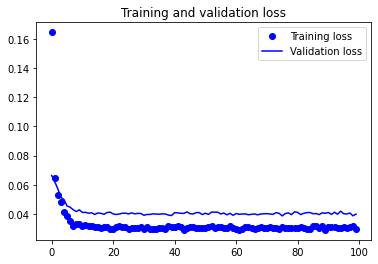

In [36]:
loss = running_loss_history
val_loss = val_running_loss_history

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("plot/train-valid-loss-resnet-101.jpg")
plt.show()

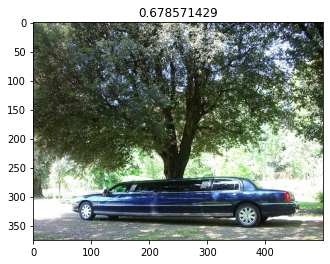

In [37]:
file = ""

def show_sample_from_dataset(i=0):
    global file

    def show_image(image, asethics_value=0):
        plt.imshow(image)
        plt.title(str(asethics_value))

    image_path = os.path.join(
        "images/"+str(dataset_validation.iloc[i]["image"]))
    file = image_path
    mem_val = os.path.join(
        str(dataset_validation.iloc[i]["memorability_score"]))
    show_image(io.imread(image_path), mem_val)


show_sample_from_dataset()

In [38]:
image = None
import PIL

def image_loader(loader, image_name):
    global image
    image = PIL.Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image


data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),

    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
print((resmodel_101(image_loader(data_transforms, file).double().to(device)).cpu().item()))

/var/folders/sh/0km6g5cd0kj3scm6mhtchtp00000gn/T/ipykernel_1860/1970836421.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)


-0.26256769001846525


/var/folders/sh/0km6g5cd0kj3scm6mhtchtp00000gn/T/ipykernel_1860/1970836421.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)


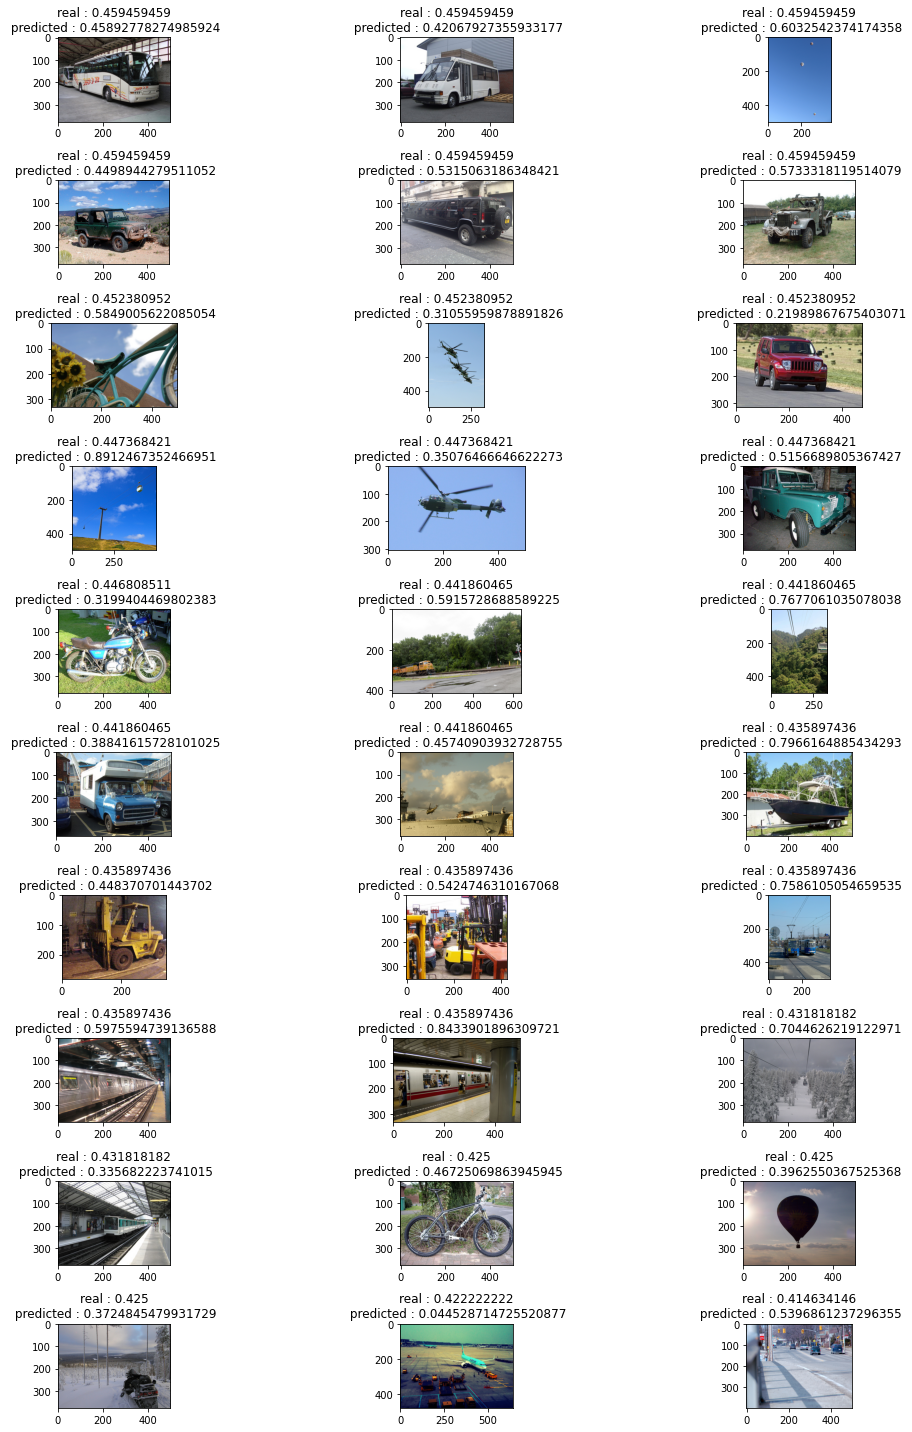

In [39]:
def show_grid(n_row, n_col):
    i = 100
    _, fig = plt.subplots(n_row, n_col, figsize=(20, 20))
    fig = fig.flatten()
    for f in fig:
        image_path = os.path.join(
            "images/"+str(dataset_validation.iloc[i]["image"]))
        mem_val = os.path.join(
            str(dataset_validation.iloc[i]["memorability_score"]))
        pred = original_model_101(image_loader(
            data_transforms, image_path).double().to(device)).cpu().item()

        f.imshow(io.imread(image_path))
        plt.tight_layout()
        f.title.set_text("real : " + str(mem_val)+"\n predicted : "+str(pred))
        i = i+1

show_grid(10, 3)

In [40]:
val_running_loss_history

[0.06631974829357076,
 0.06201382189843084,
 0.05712783981269612,
 0.05122773870904321,
 0.04976537357108859,
 0.04536557603365587,
 0.04451026128904948,
 0.04278401802971628,
 0.04149664759976472,
 0.042672380916230566,
 0.04090733710820736,
 0.04096782780768992,
 0.04038031005630302,
 0.04067296673799277,
 0.03951412644120438,
 0.04052889352222702,
 0.040304255324441304,
 0.03962576467247338,
 0.04081193589435593,
 0.04112686227578797,
 0.039875770032074695,
 0.039501220452070905,
 0.039860998643030214,
 0.040326768514617445,
 0.040442311556177446,
 0.0398768920756149,
 0.040630126395208424,
 0.039944372469170465,
 0.040281956007162445,
 0.04015272231370679,
 0.03897504351515077,
 0.03950539971606894,
 0.039549228453715696,
 0.0399946489695276,
 0.03975509138746408,
 0.039686402740145454,
 0.03995152280098139,
 0.039824259941047636,
 0.03908608882373942,
 0.03878461400860123,
 0.04074883110725239,
 0.04061181450129937,
 0.040319993818086514,
 0.04025652367587463,
 0.04128009651174968

In [41]:
running_loss_history

[0.1647735344325257,
 0.06481541043869593,
 0.05288665015305079,
 0.04778440041817749,
 0.04120980999193041,
 0.0387593445889825,
 0.034852482495131,
 0.031247594090056122,
 0.03297977464385701,
 0.03262150529844776,
 0.031667167268176484,
 0.032060236273833864,
 0.03142705858923991,
 0.031508331111143886,
 0.03096703912342791,
 0.030882169826080448,
 0.03027343759566415,
 0.030593830149504286,
 0.030830508796483098,
 0.02977465114216089,
 0.029556139565960097,
 0.03110735722215618,
 0.03137220745552058,
 0.031107868944736574,
 0.03119303301189691,
 0.02982872526094741,
 0.030121089006423466,
 0.030442051384764458,
 0.030359102211043404,
 0.030650577428960244,
 0.029250201639810895,
 0.03100938130984559,
 0.029756839015467097,
 0.02986036817528177,
 0.02951754796883546,
 0.02999289635024188,
 0.03013699880863061,
 0.029772966949674396,
 0.031251812343413676,
 0.03070861296103775,
 0.030580952806697273,
 0.031309321904354016,
 0.030817855878879655,
 0.02917604314362415,
 0.0304767757128

In [42]:
predictions = []

for index, row in dataset_validation.iterrows():
    image_path = os.path.join("images/"+str(row["image"]))
    mem_val = os.path.join(str(row["memorability_score"]))

    pred = original_model_101(image_loader(
        data_transforms, image_path).double().to(device)).cpu().item()

    predictions.append({
        "image": row["image"],
        "real": row["memorability_score"],
        "prediction": pred,
        "tpye": "validation"

    })

for index, row in dataset_train.iterrows():
    image_path = os.path.join("images/"+str(row["image"]))
    mem_val = os.path.join(str(row["memorability_score"]))

    pred = original_model_101(image_loader(
        data_transforms, image_path).double().to(device)).cpu().item()

    predictions.append({
        "image": row["image"],
        "real": row["memorability_score"],
        "prediction": pred,
        "tpye": "train"

    })

/var/folders/sh/0km6g5cd0kj3scm6mhtchtp00000gn/T/ipykernel_1860/1970836421.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)


In [43]:
image_list = []
real_list = []
prediction_list = []
image_type_list = []
for p in predictions:
    image_list.append(p["image"])
    real_list.append(p["real"])
    prediction_list.append(p["prediction"])
    image_type_list.append(p["tpye"])

dataframe_dict = {"image": image_list, "real": real_list,
                  "prediction": prediction_list, "tpye": image_type_list}

df = pd.DataFrame(dataframe_dict)

df.to_csv('csv/predictions_resnet101.csv')